# Импортирование необходимых библиотек

In [1]:
import os
from datetime import datetime
import uuid
import tarfile
import numpy as np
import urllib.request
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import onnx
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

2024-12-06 11:14:03.672387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-06 11:14:04.460775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


# Загрузка и распаковка набора данных CIFAR100

In [3]:
def download_and_extract_cifar100(
    filename="cifar-100-python.tar.gz", 
    url="https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", 
    extract_dir="cifar-100-python"
    ):
    """
    Функция для скачивания и распаковки архива CIFAR-100.
    
    Args:
        filename (str): Имя архива, который нужно скачать.
        url (str): URL для скачивания архива.
        extract_dir (str): Папка, куда нужно распаковать архив.
    """
    
    # Проверяем наличие файла
    if not os.path.exists(filename):
        # Файла нет, скачиваем
        print(f"Скачивание {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"Файл '{filename}' был успешно скачан.")
    else:
        print(f"Файл '{filename}' уже существует.")

    # Проверяем, был ли архив распакован
    if not os.path.exists(extract_dir):
        print(f"Распаковка {filename}...")
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()
        print(f"Архив распакован в папку '{extract_dir}'.")
    else:
        print("Архив уже распакован.")
        
download_and_extract_cifar100()

Файл 'cifar-100-python.tar.gz' уже существует.
Архив уже распакован.


## Архитектуры модели

### Класс модели CIFAR100

In [4]:
class CIFAR100Trainer:
    def __init__(self, classes, batch_size=128, lr_rate=1e-4, patience=2, factor=0.9, dropout_rate=0.5, experiment_name='cifar100_cnn', device=None):
        self.classes = classes
        self.batch_size = batch_size
        self.lr_rate = lr_rate
        self.dropout_rate = dropout_rate
        self.criterion = nn.CrossEntropyLoss()
        self.patience = patience
        self.factor = factor
        self.device = self.get_device(device)
        self.history = {"epoch": [], "loss": []}  # История обучения
        # Загрузка названий классов
        self.class_names = self.load_class_names()
        # Инициализация логгера
        self.writer = self.initialize_log_dir(experiment_name)

        # Чтение тренировочной выборки (обучающих данных)
        with open('cifar-100-python/train', 'rb') as f:
            data_train = pickle.load(f, encoding='latin1')

        # Чтение тестовой выборки (тестовых данных)
        with open('cifar-100-python/test', 'rb') as f:
            data_test = pickle.load(f, encoding='latin1')

        # Фильтрация данных и создание датасетов
        self.train_dataset = self.prepare_data(data_train, 'train')
        self.test_dataset = self.prepare_data(data_test, 'test')

        # Загрузка данных в батчи
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def initialize_log_dir(self, experiment_name):
        """Создает уникальную директорию для эксперимента и инициализирует SummaryWriter."""
        self.experiment_name = experiment_name  # Сохраняем название эксперимента
        self.log_dir = f'logs/{experiment_name}'  # Базовый путь для логов
        # Проверка существования директории и генерация нового имени, если необходимо
        i = 0
        while os.path.exists(self.log_dir):
            self.log_dir = f'logs/{experiment_name}_{i}'
            i += 1
        os.makedirs(self.log_dir)   # Создаем директорию, если она не существует
        # Вывод информации о названии эксперимента
        print(f"Директория для эксперимента '{experiment_name}' инициализирована по пути: {self.log_dir}")
        # Сохраняем уникальное имя для использования в save_model
        self.unique_experiment_name = os.path.basename(self.log_dir)  

        return SummaryWriter(log_dir=self.log_dir) # Возвращаем инициализированный SummaryWriter

    def log_model_graph(self, model):
        """Визуализирует граф модели в TensorBoard."""
        dummy_input = torch.randn(1, self.classes.__len__(), 32, 32).to('cpu')  # Размер входа для CIFAR100 (N, C, H, W)
        
        self.writer.add_graph(model, dummy_input)  # Добавляем граф модели
        print(f"Граф модели добавлен в лог: {self.writer.log_dir}")

    def log_hparams_and_metrics(self, accuracy):
        hparams = {
            'batch_size': self.batch_size,
            'learning_rate': self.lr_rate,
            'dropout_rate': self.dropout_rate,
            'epochs': self.epochs
        }
        # Получение текущего времени в читаемом формате
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_name = f"{timestamp}"  # Читаемое имя
    
        # Логирование гиперпараметров и метрик
        self.writer.add_hparams(hparams, { 
            'accuracy': accuracy,
        }, run_name=run_name)
        
        self.writer.close()
        
    def close_writer(self):
        """Закрывает SummaryWriter."""
        self.writer.close()
        print("SummaryWriter закрыт.")

    def load_class_names(self):
        """Загружает названия классов из мета-файла."""
        with open('cifar-100-python/meta', 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
        return meta['fine_label_names']

    def prepare_data(self, data, part):
        """Фильтрация данных и преобразование в TensorDataset."""
        X = data['data'].reshape(-1, 3, 32, 32)  # Данные в формате NCHW
        y = np.array(data['fine_labels'])

        mask = np.isin(y, self.classes)
        X = X[mask].copy()
        y = y[mask].copy()
        y = np.unique(y, return_inverse=1)[1]

        tensor_x = torch.Tensor(X)
        tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(self.classes)) / 1.
        dataset = TensorDataset(tensor_x, tensor_y)
        return dataset
        
    def train(self, model, epochs=10, max_early_stopping_counter=100):
        self.epochs = epochs
        early_stopping_counter = 0
        best_loss = float('inf')
        model = model.to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.lr_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=self.patience, factor=self.factor)

        self.history = {"epoch": [], "loss": []}  # Инициализация истории

        for epoch in range(epochs):
            model.train()  # Установка модели в режим обучения
            running_loss = 0.0

            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit="batch")
            for batch_idx, (data, target) in enumerate(progress_bar):
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                # Вызов метода forward() модели
                output = model.forward(data) 
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                # Получение текущего значения learning rate
                current_learning_rate = optimizer.param_groups[0]['lr']
                progress_bar.set_postfix(loss=f"{loss:.6f}", lr=f"{current_learning_rate:.6f}")
                
            average_loss = running_loss / len(self.train_loader)
            self.history["epoch"].append(epoch + 1)
            self.history["loss"].append(average_loss)  # Сохранение средней потери
    
            # Логирование потерь в TensorBoard
            self.writer.add_scalar('Loss/train', average_loss, epoch)
            self.writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)
            print(f'Epoch: {epoch+1}/{epochs}, Loss: {running_loss/len(self.train_loader):.6f}')
            
            # Обновляем планировщик в каждой эпохе
            self.scheduler.step(average_loss)

            # Early Stopping
            if average_loss < best_loss:
                best_loss = average_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= max_early_stopping_counter:  # Параметр patience для Early Stopping
                print("Early stopping activated.")
                break

    def evaluate(self, model):
        model = model.to(self.device)
        model.eval()  # Установка модели в режим оценки
        
        # Обрабатываем обе выборки: тренировочную и тестовую
        dataloaders = {'train': self.train_loader, 'test': self.test_loader}
        
        for part in ['train', 'test']:
            all_predicted = []
            all_target = []
            with torch.no_grad():
                for data, target in dataloaders[part]:
                    data, target = data.to(self.device), target.to(self.device)

                    output = model(data)
                    
                    # Получаем предсказания
                    _, predicted = torch.max(output.data, 1)
                    
                    # Преобразуем target обратно в одномерный тензор
                    target_indices = torch.argmax(target, dim=1)
                    
                    all_predicted.extend(predicted.cpu().numpy())
                    all_target.extend(target_indices.cpu().numpy())
            
            # Преобразуем списки в массивы NumPy
            all_predicted = np.array(all_predicted)
            all_target = np.array(all_target)
            
            # Выводим наименования классов для выбранных индексов
            selected_class_names = [self.class_names[i] for i in self.classes]
            
            # Выводим отчет о классификации
            print(f"Classification report for {part} dataset:")
            report = classification_report(all_target, all_predicted, target_names=selected_class_names, zero_division=0, digits=4)
            print(report)
            print('-' * 50)
            
        # Вычисляем и логируем точность
        accuracy = np.sum(all_predicted == all_target) / len(all_target)
        self.writer.add_scalar(f'Accuracy/{part}', accuracy, len(self.history["epoch"]) - 1)
        
        self.log_hparams_and_metrics(accuracy)

    def save_model(self, model, path='models/'):
        # Формируем название модели на основе уникального имени эксперимента
        model_name = f"{self.unique_experiment_name}_model.onnx"  # Используем уникальное имя эксперимента
        
        # Создаем полный путь для сохранения модели
        filepath = os.path.join(path, model_name)  # Корректное соединение пути и имени файла
        
        # Убедимся, что директория для сохранения существует
        os.makedirs(path, exist_ok=True)  # Создаем директорию, если она не существует

        # Входной тензор для модели (с учетом правильного порядка: (N, C, H, W))
        dummy_input = torch.randn(1, 3, 32, 32, requires_grad=True).to(self.device)

        # Экспорт модели
        torch.onnx.export(
            model,               # модель
            dummy_input,         # входной тензор
            filepath,            # куда сохранить
            export_params=True,  # сохраняет веса обученных параметров внутри файла модели
            opset_version=9,    # версия ONNX
            do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
            input_names=['input'],    # имя входного слоя
            output_names=['output'],   # имя выходного слоя
            dynamic_axes={'input': {0: 'batch_size'},    # динамичные оси
                          'output': {0: 'batch_size'}}
        )
        
        # Вывод информации о сохраненной модели
        print(f"Model saved as: {model_name}")

    @staticmethod
    def get_device(select=None):
        """
        Определение устройства для вычислений (CPU или GPU).
        Args:
            select (str, optional): Выбор устройства ('cpu', 'cuda'). По умолчанию None.
            torch.device: Устройство для вычислений.
        """
        if select is None or select == 'cuda':
            return torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return torch.device('cpu')

    def plot_training_history(self, window_size = 5):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
        loss = self.history["loss"]
            
        # Вычисляем скользящее среднее
        smoothed_loss = np.convolve(loss, np.ones(window_size)/window_size, mode='valid')
    
        # Первый график: Полная история с скользящим средним
        axs[0].plot(epochs, loss, marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[0].plot(epochs[window_size-1:], smoothed_loss, color='orange', label='Smoothed Loss (Moving Average)')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()
    
        # Второй график: Половина истории с скользящим средним
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], loss[mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[1].plot(epochs[mid_index + window_size - 1:], smoothed_loss[mid_index:], color='orange', label='Smoothed Loss (Moving Average)')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average Loss')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

### Архитектура модели

In [5]:
class CIFAR100ModelCNN(nn.Module):
    def __init__(self, hidden_layers=[64, 128, 64], dropout_rate=0.5, num_classes=100):
        super(CIFAR100ModelCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier_conv = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier_conv(x)
        x = F.adaptive_avg_pool2d(x, 1)  # Global average pooling
        x = torch.flatten(x, 1)
        return x

## Установки параметров

### По варианту

In [6]:
CLASSES = [94, 21, 51]

In [7]:
# Счетчик экспериментов
count_experiments = 1

## Машинное обучение 

### Эксперимент №1

#### Гиперпараметры

In [8]:
batch_size=2**5
epochs=100
lr_rate=1e-4
dropout_rate=0.5
hidden_layers=[2**4, 2**6, 2**4]

#### Инициализация модели

In [9]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100_cnn' инициализирована по пути: logs/cifar100_cnn
CPU times: user 166 ms, sys: 317 ms, total: 483 ms
Wall time: 347 ms


In [10]:
%%time
cifar100 = CIFAR100ModelCNN(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 24.2 ms, sys: 3.96 ms, total: 28.1 ms
Wall time: 3.4 ms


In [11]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_cnn


#### Информация о модели

In [12]:
cifar100

CIFAR100ModelCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_conv): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
)

#### Обучение

In [13]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/10: 100%|██████████████████████| 47/47 [00:00<00:00, 85.91batch/s, loss=0.599202, lr=0.000100]


Epoch: 1/10, Loss: 1.769664


Epoch 2/10: 100%|█████████████████████| 47/47 [00:00<00:00, 185.77batch/s, loss=0.873526, lr=0.000100]


Epoch: 2/10, Loss: 0.644090


Epoch 3/10: 100%|█████████████████████| 47/47 [00:00<00:00, 187.37batch/s, loss=0.493768, lr=0.000100]


Epoch: 3/10, Loss: 0.516378


Epoch 4/10: 100%|█████████████████████| 47/47 [00:00<00:00, 195.36batch/s, loss=0.442935, lr=0.000100]


Epoch: 4/10, Loss: 0.487513


Epoch 5/10: 100%|█████████████████████| 47/47 [00:00<00:00, 184.17batch/s, loss=0.409273, lr=0.000100]


Epoch: 5/10, Loss: 0.452735


Epoch 6/10: 100%|█████████████████████| 47/47 [00:00<00:00, 190.44batch/s, loss=0.795809, lr=0.000100]


Epoch: 6/10, Loss: 0.393498


Epoch 7/10: 100%|█████████████████████| 47/47 [00:00<00:00, 189.76batch/s, loss=0.168892, lr=0.000100]


Epoch: 7/10, Loss: 0.363291


Epoch 8/10: 100%|█████████████████████| 47/47 [00:00<00:00, 206.11batch/s, loss=0.167142, lr=0.000100]


Epoch: 8/10, Loss: 0.316355


Epoch 9/10: 100%|█████████████████████| 47/47 [00:00<00:00, 193.57batch/s, loss=0.172161, lr=0.000100]


Epoch: 9/10, Loss: 0.290921


Epoch 10/10: 100%|████████████████████| 47/47 [00:00<00:00, 189.15batch/s, loss=0.295970, lr=0.000100]

Epoch: 10/10, Loss: 0.292336
CPU times: user 3.19 s, sys: 964 ms, total: 4.15 s
Wall time: 2.89 s


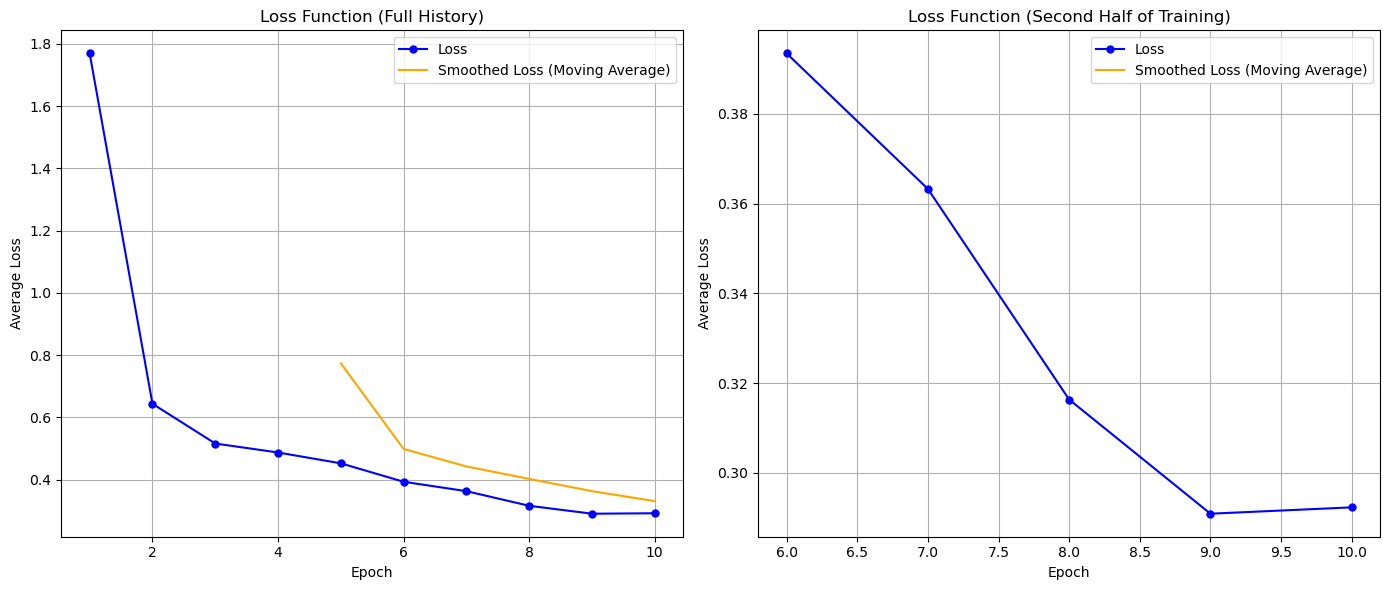

In [14]:
trainer.plot_training_history()

#### Оценка

In [15]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9239    0.8980    0.9108       500
  chimpanzee     0.8305    0.9800    0.8991       500
    mushroom     0.9858    0.8360    0.9048       500

    accuracy                         0.9047      1500
   macro avg     0.9134    0.9047    0.9049      1500
weighted avg     0.9134    0.9047    0.9049      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9175    0.8900    0.9036       100
  chimpanzee     0.8250    0.9900    0.9000       100
    mushroom     0.9880    0.8200    0.8962       100

    accuracy                         0.9000       300
   macro avg     0.9102    0.9000    0.8999       300
weighted avg     0.9102    0.9000    0.8999       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [16]:
trainer.save_model(cifar100)

Model saved as: cifar100_cnn_model.onnx


### Эксперимент №2

#### Гиперпараметры

In [18]:
batch_size=2**5
epochs=100
lr_rate=1e-4
dropout_rate=0.25
hidden_layers=[2**4, 2**6, 2**4]

#### Инициализация модели

In [19]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_0
CPU times: user 182 ms, sys: 293 ms, total: 475 ms
Wall time: 334 ms


In [20]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 18.8 ms, sys: 495 µs, total: 19.3 ms
Wall time: 2.38 ms


In [21]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_0


#### Информация о модели

In [22]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=16, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)

#### Обучение

In [23]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/100: 100%|████████████████████| 47/47 [00:00<00:00, 281.49batch/s, loss=1.124989, lr=0.000100]


Epoch: 1/100, Loss: 1.086585


Epoch 2/100: 100%|████████████████████| 47/47 [00:00<00:00, 243.41batch/s, loss=0.947700, lr=0.000100]


Epoch: 2/100, Loss: 0.995700


Epoch 3/100: 100%|████████████████████| 47/47 [00:00<00:00, 242.86batch/s, loss=0.881268, lr=0.000100]


Epoch: 3/100, Loss: 0.905603


Epoch 4/100: 100%|████████████████████| 47/47 [00:00<00:00, 248.57batch/s, loss=0.667056, lr=0.000100]


Epoch: 4/100, Loss: 0.849666


Epoch 5/100: 100%|████████████████████| 47/47 [00:00<00:00, 298.46batch/s, loss=0.749543, lr=0.000100]


Epoch: 5/100, Loss: 0.793696


Epoch 6/100: 100%|████████████████████| 47/47 [00:00<00:00, 310.94batch/s, loss=0.680041, lr=0.000100]


Epoch: 6/100, Loss: 0.760063


Epoch 7/100: 100%|████████████████████| 47/47 [00:00<00:00, 307.19batch/s, loss=0.784080, lr=0.000100]


Epoch: 7/100, Loss: 0.745386


Epoch 8/100: 100%|████████████████████| 47/47 [00:00<00:00, 270.51batch/s, loss=0.573302, lr=0.000100]


Epoch: 8/100, Loss: 0.701763


Epoch 9/100: 100%|████████████████████| 47/47 [00:00<00:00, 278.39batch/s, loss=0.809943, lr=0.000100]


Epoch: 9/100, Loss: 0.708722


Epoch 10/100: 100%|███████████████████| 47/47 [00:00<00:00, 283.57batch/s, loss=0.562785, lr=0.000100]


Epoch: 10/100, Loss: 0.674494


Epoch 11/100: 100%|███████████████████| 47/47 [00:00<00:00, 276.47batch/s, loss=0.540790, lr=0.000100]


Epoch: 11/100, Loss: 0.664535


Epoch 12/100: 100%|███████████████████| 47/47 [00:00<00:00, 320.53batch/s, loss=0.673433, lr=0.000100]


Epoch: 12/100, Loss: 0.635285


Epoch 13/100: 100%|███████████████████| 47/47 [00:00<00:00, 282.35batch/s, loss=0.631034, lr=0.000100]


Epoch: 13/100, Loss: 0.637741


Epoch 14/100: 100%|███████████████████| 47/47 [00:00<00:00, 285.05batch/s, loss=0.612420, lr=0.000100]


Epoch: 14/100, Loss: 0.620388


Epoch 15/100: 100%|███████████████████| 47/47 [00:00<00:00, 249.26batch/s, loss=0.740237, lr=0.000100]


Epoch: 15/100, Loss: 0.616864


Epoch 16/100: 100%|███████████████████| 47/47 [00:00<00:00, 237.69batch/s, loss=0.548128, lr=0.000100]


Epoch: 16/100, Loss: 0.599178


Epoch 17/100: 100%|███████████████████| 47/47 [00:00<00:00, 230.22batch/s, loss=0.634116, lr=0.000100]


Epoch: 17/100, Loss: 0.591391


Epoch 18/100: 100%|███████████████████| 47/47 [00:00<00:00, 262.45batch/s, loss=0.800550, lr=0.000100]


Epoch: 18/100, Loss: 0.555660


Epoch 19/100: 100%|███████████████████| 47/47 [00:00<00:00, 268.67batch/s, loss=0.427653, lr=0.000100]


Epoch: 19/100, Loss: 0.579689


Epoch 20/100: 100%|███████████████████| 47/47 [00:00<00:00, 275.68batch/s, loss=0.512046, lr=0.000100]


Epoch: 20/100, Loss: 0.553120


Epoch 21/100: 100%|███████████████████| 47/47 [00:00<00:00, 269.26batch/s, loss=0.612466, lr=0.000100]


Epoch: 21/100, Loss: 0.544764


Epoch 22/100: 100%|███████████████████| 47/47 [00:00<00:00, 285.38batch/s, loss=0.632920, lr=0.000100]


Epoch: 22/100, Loss: 0.536431


Epoch 23/100: 100%|███████████████████| 47/47 [00:00<00:00, 274.24batch/s, loss=0.261820, lr=0.000100]


Epoch: 23/100, Loss: 0.516437


Epoch 24/100: 100%|███████████████████| 47/47 [00:00<00:00, 264.97batch/s, loss=0.501866, lr=0.000100]


Epoch: 24/100, Loss: 0.521663


Epoch 25/100: 100%|███████████████████| 47/47 [00:00<00:00, 313.67batch/s, loss=0.495159, lr=0.000100]


Epoch: 25/100, Loss: 0.519244


Epoch 26/100: 100%|███████████████████| 47/47 [00:00<00:00, 277.70batch/s, loss=0.331678, lr=0.000100]


Epoch: 26/100, Loss: 0.498553


Epoch 27/100: 100%|███████████████████| 47/47 [00:00<00:00, 280.71batch/s, loss=0.488571, lr=0.000100]


Epoch: 27/100, Loss: 0.496215


Epoch 28/100: 100%|███████████████████| 47/47 [00:00<00:00, 279.34batch/s, loss=0.438389, lr=0.000100]


Epoch: 28/100, Loss: 0.477177


Epoch 29/100: 100%|███████████████████| 47/47 [00:00<00:00, 326.65batch/s, loss=0.332528, lr=0.000100]


Epoch: 29/100, Loss: 0.470481


Epoch 30/100: 100%|███████████████████| 47/47 [00:00<00:00, 290.16batch/s, loss=0.352200, lr=0.000100]


Epoch: 30/100, Loss: 0.463894


Epoch 31/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.12batch/s, loss=0.407557, lr=0.000100]


Epoch: 31/100, Loss: 0.451708


Epoch 32/100: 100%|███████████████████| 47/47 [00:00<00:00, 274.86batch/s, loss=0.282166, lr=0.000100]


Epoch: 32/100, Loss: 0.467799


Epoch 33/100: 100%|███████████████████| 47/47 [00:00<00:00, 272.57batch/s, loss=0.582473, lr=0.000100]


Epoch: 33/100, Loss: 0.464206


Epoch 34/100: 100%|███████████████████| 47/47 [00:00<00:00, 303.31batch/s, loss=0.308790, lr=0.000100]


Epoch: 34/100, Loss: 0.437710


Epoch 35/100: 100%|███████████████████| 47/47 [00:00<00:00, 303.78batch/s, loss=0.458921, lr=0.000100]


Epoch: 35/100, Loss: 0.428937


Epoch 36/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.83batch/s, loss=0.378611, lr=0.000100]


Epoch: 36/100, Loss: 0.395517


Epoch 37/100: 100%|███████████████████| 47/47 [00:00<00:00, 303.47batch/s, loss=0.466288, lr=0.000100]


Epoch: 37/100, Loss: 0.431471


Epoch 38/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.74batch/s, loss=0.603026, lr=0.000100]


Epoch: 38/100, Loss: 0.407429


Epoch 39/100: 100%|███████████████████| 47/47 [00:00<00:00, 301.49batch/s, loss=0.424269, lr=0.000100]


Epoch: 39/100, Loss: 0.398517


Epoch 40/100: 100%|███████████████████| 47/47 [00:00<00:00, 286.55batch/s, loss=0.331934, lr=0.000090]


Epoch: 40/100, Loss: 0.390538


Epoch 41/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.14batch/s, loss=0.385550, lr=0.000090]


Epoch: 41/100, Loss: 0.386664


Epoch 42/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.45batch/s, loss=0.343386, lr=0.000090]


Epoch: 42/100, Loss: 0.411511


Epoch 43/100: 100%|███████████████████| 47/47 [00:00<00:00, 276.14batch/s, loss=0.360887, lr=0.000090]


Epoch: 43/100, Loss: 0.397070


Epoch 44/100: 100%|███████████████████| 47/47 [00:00<00:00, 278.46batch/s, loss=0.277744, lr=0.000090]


Epoch: 44/100, Loss: 0.395580


Epoch 45/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.58batch/s, loss=0.385877, lr=0.000081]


Epoch: 45/100, Loss: 0.387732


Epoch 46/100: 100%|███████████████████| 47/47 [00:00<00:00, 269.83batch/s, loss=0.288874, lr=0.000081]


Epoch: 46/100, Loss: 0.352157


Epoch 47/100: 100%|███████████████████| 47/47 [00:00<00:00, 235.84batch/s, loss=0.318089, lr=0.000081]


Epoch: 47/100, Loss: 0.353986


Epoch 48/100: 100%|███████████████████| 47/47 [00:00<00:00, 291.39batch/s, loss=0.445929, lr=0.000081]


Epoch: 48/100, Loss: 0.356980


Epoch 49/100: 100%|███████████████████| 47/47 [00:00<00:00, 255.00batch/s, loss=0.431357, lr=0.000081]


Epoch: 49/100, Loss: 0.355770


Epoch 50/100: 100%|███████████████████| 47/47 [00:00<00:00, 257.39batch/s, loss=0.323092, lr=0.000073]


Epoch: 50/100, Loss: 0.352290


Epoch 51/100: 100%|███████████████████| 47/47 [00:00<00:00, 263.53batch/s, loss=0.283578, lr=0.000073]


Epoch: 51/100, Loss: 0.349365


Epoch 52/100: 100%|███████████████████| 47/47 [00:00<00:00, 306.56batch/s, loss=0.596902, lr=0.000073]


Epoch: 52/100, Loss: 0.355943


Epoch 53/100: 100%|███████████████████| 47/47 [00:00<00:00, 281.27batch/s, loss=0.548064, lr=0.000073]


Epoch: 53/100, Loss: 0.346779


Epoch 54/100: 100%|███████████████████| 47/47 [00:00<00:00, 289.22batch/s, loss=0.300045, lr=0.000073]


Epoch: 54/100, Loss: 0.354636


Epoch 55/100: 100%|███████████████████| 47/47 [00:00<00:00, 283.14batch/s, loss=0.316863, lr=0.000073]


Epoch: 55/100, Loss: 0.345058


Epoch 56/100: 100%|███████████████████| 47/47 [00:00<00:00, 292.39batch/s, loss=0.419545, lr=0.000073]


Epoch: 56/100, Loss: 0.309161


Epoch 57/100: 100%|███████████████████| 47/47 [00:00<00:00, 299.16batch/s, loss=0.440318, lr=0.000073]


Epoch: 57/100, Loss: 0.317630


Epoch 58/100: 100%|███████████████████| 47/47 [00:00<00:00, 294.04batch/s, loss=0.313138, lr=0.000073]


Epoch: 58/100, Loss: 0.320380


Epoch 59/100: 100%|███████████████████| 47/47 [00:00<00:00, 289.30batch/s, loss=0.210932, lr=0.000073]


Epoch: 59/100, Loss: 0.312433


Epoch 60/100: 100%|███████████████████| 47/47 [00:00<00:00, 288.79batch/s, loss=0.258674, lr=0.000066]


Epoch: 60/100, Loss: 0.304126


Epoch 61/100: 100%|███████████████████| 47/47 [00:00<00:00, 249.08batch/s, loss=0.207659, lr=0.000066]


Epoch: 61/100, Loss: 0.297417


Epoch 62/100: 100%|███████████████████| 47/47 [00:00<00:00, 277.03batch/s, loss=0.221384, lr=0.000066]


Epoch: 62/100, Loss: 0.299018


Epoch 63/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.68batch/s, loss=0.341728, lr=0.000066]


Epoch: 63/100, Loss: 0.309835


Epoch 64/100: 100%|███████████████████| 47/47 [00:00<00:00, 262.27batch/s, loss=0.237274, lr=0.000066]


Epoch: 64/100, Loss: 0.293286


Epoch 65/100: 100%|███████████████████| 47/47 [00:00<00:00, 268.30batch/s, loss=0.331177, lr=0.000066]


Epoch: 65/100, Loss: 0.307834


Epoch 66/100: 100%|███████████████████| 47/47 [00:00<00:00, 263.57batch/s, loss=0.443242, lr=0.000066]


Epoch: 66/100, Loss: 0.278881


Epoch 67/100: 100%|███████████████████| 47/47 [00:00<00:00, 251.10batch/s, loss=0.111592, lr=0.000066]


Epoch: 67/100, Loss: 0.288015


Epoch 68/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.58batch/s, loss=0.252480, lr=0.000066]


Epoch: 68/100, Loss: 0.281828


Epoch 69/100: 100%|███████████████████| 47/47 [00:00<00:00, 289.55batch/s, loss=0.502889, lr=0.000066]


Epoch: 69/100, Loss: 0.282867


Epoch 70/100: 100%|███████████████████| 47/47 [00:00<00:00, 251.37batch/s, loss=0.327514, lr=0.000059]


Epoch: 70/100, Loss: 0.293305


Epoch 71/100: 100%|███████████████████| 47/47 [00:00<00:00, 255.61batch/s, loss=0.233480, lr=0.000059]


Epoch: 71/100, Loss: 0.295042


Epoch 72/100: 100%|███████████████████| 47/47 [00:00<00:00, 254.94batch/s, loss=0.193183, lr=0.000059]


Epoch: 72/100, Loss: 0.266014


Epoch 73/100: 100%|███████████████████| 47/47 [00:00<00:00, 260.71batch/s, loss=0.135528, lr=0.000059]


Epoch: 73/100, Loss: 0.274353


Epoch 74/100: 100%|███████████████████| 47/47 [00:00<00:00, 282.68batch/s, loss=0.259370, lr=0.000059]


Epoch: 74/100, Loss: 0.274605


Epoch 75/100: 100%|███████████████████| 47/47 [00:00<00:00, 262.40batch/s, loss=0.270338, lr=0.000059]


Epoch: 75/100, Loss: 0.283003


Epoch 76/100: 100%|███████████████████| 47/47 [00:00<00:00, 281.45batch/s, loss=0.258046, lr=0.000053]


Epoch: 76/100, Loss: 0.256041


Epoch 77/100: 100%|███████████████████| 47/47 [00:00<00:00, 297.96batch/s, loss=0.252388, lr=0.000053]


Epoch: 77/100, Loss: 0.275893


Epoch 78/100: 100%|███████████████████| 47/47 [00:00<00:00, 303.72batch/s, loss=0.323801, lr=0.000053]


Epoch: 78/100, Loss: 0.262550


Epoch 79/100: 100%|███████████████████| 47/47 [00:00<00:00, 264.70batch/s, loss=0.340963, lr=0.000053]


Epoch: 79/100, Loss: 0.258447


Epoch 80/100: 100%|███████████████████| 47/47 [00:00<00:00, 243.85batch/s, loss=0.149890, lr=0.000048]


Epoch: 80/100, Loss: 0.262791


Epoch 81/100: 100%|███████████████████| 47/47 [00:00<00:00, 282.27batch/s, loss=0.282644, lr=0.000048]


Epoch: 81/100, Loss: 0.252942


Epoch 82/100: 100%|███████████████████| 47/47 [00:00<00:00, 263.87batch/s, loss=0.185757, lr=0.000048]


Epoch: 82/100, Loss: 0.266149


Epoch 83/100: 100%|███████████████████| 47/47 [00:00<00:00, 247.55batch/s, loss=0.163758, lr=0.000048]


Epoch: 83/100, Loss: 0.255002


Epoch 84/100: 100%|███████████████████| 47/47 [00:00<00:00, 278.58batch/s, loss=0.294903, lr=0.000048]


Epoch: 84/100, Loss: 0.247528


Epoch 85/100: 100%|███████████████████| 47/47 [00:00<00:00, 281.11batch/s, loss=0.156001, lr=0.000048]


Epoch: 85/100, Loss: 0.241050


Epoch 86/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.97batch/s, loss=0.240494, lr=0.000048]


Epoch: 86/100, Loss: 0.243395


Epoch 87/100: 100%|███████████████████| 47/47 [00:00<00:00, 260.52batch/s, loss=0.305869, lr=0.000048]


Epoch: 87/100, Loss: 0.248533


Epoch 88/100: 100%|███████████████████| 47/47 [00:00<00:00, 257.11batch/s, loss=0.221185, lr=0.000048]


Epoch: 88/100, Loss: 0.244709


Epoch 89/100: 100%|███████████████████| 47/47 [00:00<00:00, 256.51batch/s, loss=0.261271, lr=0.000043]


Epoch: 89/100, Loss: 0.248328


Epoch 90/100: 100%|███████████████████| 47/47 [00:00<00:00, 256.45batch/s, loss=0.158100, lr=0.000043]


Epoch: 90/100, Loss: 0.244561


Epoch 91/100: 100%|███████████████████| 47/47 [00:00<00:00, 289.03batch/s, loss=0.098180, lr=0.000043]


Epoch: 91/100, Loss: 0.237803


Epoch 92/100: 100%|███████████████████| 47/47 [00:00<00:00, 244.20batch/s, loss=0.292516, lr=0.000043]


Epoch: 92/100, Loss: 0.226049


Epoch 93/100: 100%|███████████████████| 47/47 [00:00<00:00, 276.86batch/s, loss=0.509383, lr=0.000043]


Epoch: 93/100, Loss: 0.227123


Epoch 94/100: 100%|███████████████████| 47/47 [00:00<00:00, 291.55batch/s, loss=0.319670, lr=0.000043]


Epoch: 94/100, Loss: 0.234657


Epoch 95/100: 100%|███████████████████| 47/47 [00:00<00:00, 218.07batch/s, loss=0.242654, lr=0.000043]


Epoch: 95/100, Loss: 0.245601


Epoch 96/100: 100%|███████████████████| 47/47 [00:00<00:00, 258.37batch/s, loss=0.312909, lr=0.000039]


Epoch: 96/100, Loss: 0.244297


Epoch 97/100: 100%|███████████████████| 47/47 [00:00<00:00, 271.41batch/s, loss=0.274370, lr=0.000039]


Epoch: 97/100, Loss: 0.221566


Epoch 98/100: 100%|███████████████████| 47/47 [00:00<00:00, 283.40batch/s, loss=0.261311, lr=0.000039]


Epoch: 98/100, Loss: 0.230836


Epoch 99/100: 100%|███████████████████| 47/47 [00:00<00:00, 276.83batch/s, loss=0.321746, lr=0.000039]


Epoch: 99/100, Loss: 0.221452


Epoch 100/100: 100%|██████████████████| 47/47 [00:00<00:00, 265.84batch/s, loss=0.170054, lr=0.000039]

Epoch: 100/100, Loss: 0.211102
CPU times: user 18.4 s, sys: 1.24 s, total: 19.6 s
Wall time: 17.4 s


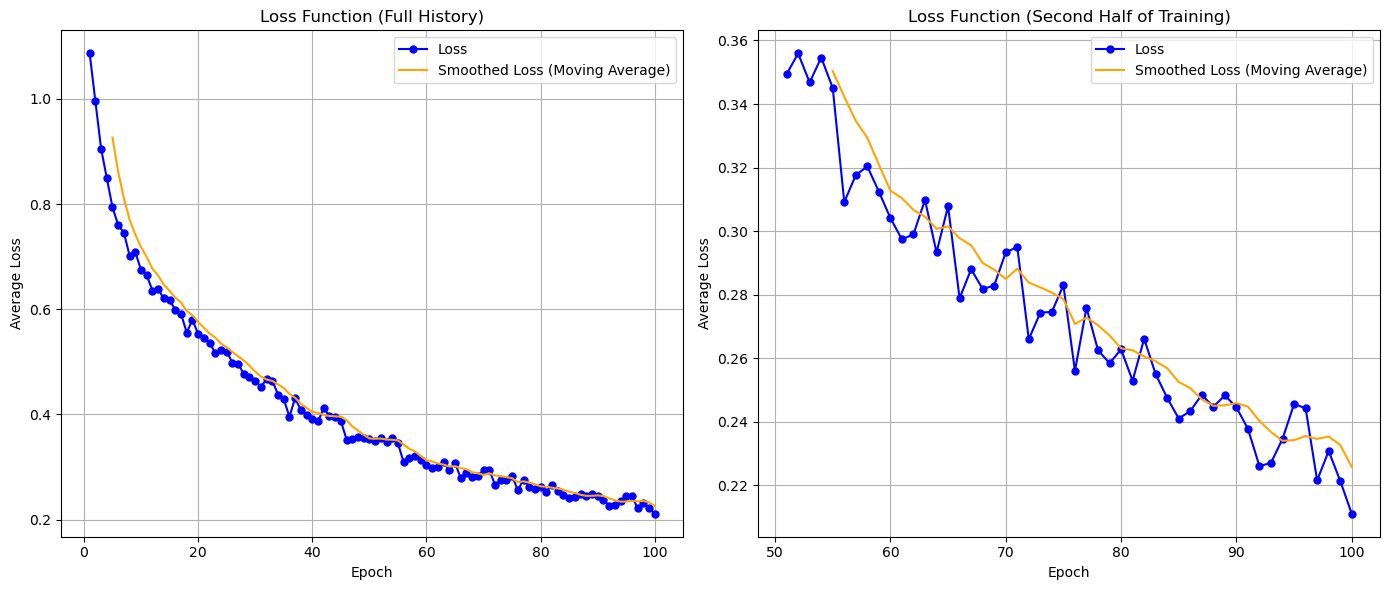

In [24]:
trainer.plot_training_history()

#### Оценка

In [25]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9781    0.9840    0.9811       500
  chimpanzee     0.9537    0.9880    0.9705       500
    mushroom     0.9875    0.9460    0.9663       500

    accuracy                         0.9727      1500
   macro avg     0.9731    0.9727    0.9726      1500
weighted avg     0.9731    0.9727    0.9726      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8911    0.9000    0.8955       100
  chimpanzee     0.8571    0.8400    0.8485       100
    mushroom     0.8020    0.8100    0.8060       100

    accuracy                         0.8500       300
   macro avg     0.8501    0.8500    0.8500       300
weighted avg     0.8501    0.8500    0.8500       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [26]:
trainer.save_model(cifar100)

Model saved as: cifar100_0_model.onnx


### Эксперимент №3

#### Гиперпараметры

In [27]:
batch_size=2**5
epochs=100
lr_rate=1e-4
dropout_rate=0.2
hidden_layers=[2**4, 2**6, 2**4]

#### Инициализация модели

In [28]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_1
CPU times: user 168 ms, sys: 283 ms, total: 450 ms
Wall time: 324 ms


In [29]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 8.63 ms, sys: 1.07 ms, total: 9.71 ms
Wall time: 1.11 ms


In [30]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_1


#### Информация о модели

In [31]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)

#### Обучение

In [32]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/100: 100%|████████████████████| 47/47 [00:00<00:00, 291.59batch/s, loss=1.012689, lr=0.000100]


Epoch: 1/100, Loss: 1.052008


Epoch 2/100: 100%|████████████████████| 47/47 [00:00<00:00, 253.70batch/s, loss=0.893027, lr=0.000100]


Epoch: 2/100, Loss: 0.975341


Epoch 3/100: 100%|████████████████████| 47/47 [00:00<00:00, 290.79batch/s, loss=1.005279, lr=0.000100]


Epoch: 3/100, Loss: 0.891692


Epoch 4/100: 100%|████████████████████| 47/47 [00:00<00:00, 269.32batch/s, loss=0.699156, lr=0.000100]


Epoch: 4/100, Loss: 0.830603


Epoch 5/100: 100%|████████████████████| 47/47 [00:00<00:00, 258.02batch/s, loss=0.772276, lr=0.000100]


Epoch: 5/100, Loss: 0.758207


Epoch 6/100: 100%|████████████████████| 47/47 [00:00<00:00, 260.62batch/s, loss=0.831693, lr=0.000100]


Epoch: 6/100, Loss: 0.737139


Epoch 7/100: 100%|████████████████████| 47/47 [00:00<00:00, 264.02batch/s, loss=0.789255, lr=0.000100]


Epoch: 7/100, Loss: 0.706992


Epoch 8/100: 100%|████████████████████| 47/47 [00:00<00:00, 269.03batch/s, loss=0.650563, lr=0.000100]


Epoch: 8/100, Loss: 0.684237


Epoch 9/100: 100%|████████████████████| 47/47 [00:00<00:00, 278.69batch/s, loss=0.601123, lr=0.000100]


Epoch: 9/100, Loss: 0.642442


Epoch 10/100: 100%|███████████████████| 47/47 [00:00<00:00, 275.75batch/s, loss=0.683171, lr=0.000100]


Epoch: 10/100, Loss: 0.656684


Epoch 11/100: 100%|███████████████████| 47/47 [00:00<00:00, 280.46batch/s, loss=0.725482, lr=0.000100]


Epoch: 11/100, Loss: 0.616640


Epoch 12/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.86batch/s, loss=0.668573, lr=0.000100]


Epoch: 12/100, Loss: 0.615914


Epoch 13/100: 100%|███████████████████| 47/47 [00:00<00:00, 265.53batch/s, loss=0.590874, lr=0.000100]


Epoch: 13/100, Loss: 0.602315


Epoch 14/100: 100%|███████████████████| 47/47 [00:00<00:00, 297.94batch/s, loss=0.804740, lr=0.000100]


Epoch: 14/100, Loss: 0.606227


Epoch 15/100: 100%|███████████████████| 47/47 [00:00<00:00, 307.85batch/s, loss=0.442993, lr=0.000100]


Epoch: 15/100, Loss: 0.588027


Epoch 16/100: 100%|███████████████████| 47/47 [00:00<00:00, 278.45batch/s, loss=0.588464, lr=0.000100]


Epoch: 16/100, Loss: 0.556036


Epoch 17/100: 100%|███████████████████| 47/47 [00:00<00:00, 282.94batch/s, loss=0.469206, lr=0.000100]


Epoch: 17/100, Loss: 0.546412


Epoch 18/100: 100%|███████████████████| 47/47 [00:00<00:00, 279.66batch/s, loss=0.353879, lr=0.000100]


Epoch: 18/100, Loss: 0.537777


Epoch 19/100: 100%|███████████████████| 47/47 [00:00<00:00, 258.04batch/s, loss=0.651194, lr=0.000100]


Epoch: 19/100, Loss: 0.520833


Epoch 20/100: 100%|███████████████████| 47/47 [00:00<00:00, 267.30batch/s, loss=0.630434, lr=0.000100]


Epoch: 20/100, Loss: 0.510299


Epoch 21/100: 100%|███████████████████| 47/47 [00:00<00:00, 308.64batch/s, loss=0.339552, lr=0.000100]


Epoch: 21/100, Loss: 0.510658


Epoch 22/100: 100%|███████████████████| 47/47 [00:00<00:00, 288.30batch/s, loss=0.501936, lr=0.000100]


Epoch: 22/100, Loss: 0.500191


Epoch 23/100: 100%|███████████████████| 47/47 [00:00<00:00, 262.58batch/s, loss=0.432124, lr=0.000100]


Epoch: 23/100, Loss: 0.486777


Epoch 24/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.41batch/s, loss=0.413777, lr=0.000100]


Epoch: 24/100, Loss: 0.466814


Epoch 25/100: 100%|███████████████████| 47/47 [00:00<00:00, 280.49batch/s, loss=0.662592, lr=0.000100]


Epoch: 25/100, Loss: 0.482625


Epoch 26/100: 100%|███████████████████| 47/47 [00:00<00:00, 301.26batch/s, loss=0.326272, lr=0.000100]


Epoch: 26/100, Loss: 0.439291


Epoch 27/100: 100%|███████████████████| 47/47 [00:00<00:00, 300.10batch/s, loss=0.557198, lr=0.000100]


Epoch: 27/100, Loss: 0.453588


Epoch 28/100: 100%|███████████████████| 47/47 [00:00<00:00, 310.00batch/s, loss=0.456148, lr=0.000100]


Epoch: 28/100, Loss: 0.445389


Epoch 29/100: 100%|███████████████████| 47/47 [00:00<00:00, 279.38batch/s, loss=0.586011, lr=0.000100]


Epoch: 29/100, Loss: 0.448564


Epoch 30/100: 100%|███████████████████| 47/47 [00:00<00:00, 269.28batch/s, loss=0.465063, lr=0.000090]


Epoch: 30/100, Loss: 0.426599


Epoch 31/100: 100%|███████████████████| 47/47 [00:00<00:00, 288.85batch/s, loss=0.542728, lr=0.000090]


Epoch: 31/100, Loss: 0.413908


Epoch 32/100: 100%|███████████████████| 47/47 [00:00<00:00, 303.84batch/s, loss=0.205554, lr=0.000090]


Epoch: 32/100, Loss: 0.400825


Epoch 33/100: 100%|███████████████████| 47/47 [00:00<00:00, 304.59batch/s, loss=0.554437, lr=0.000090]


Epoch: 33/100, Loss: 0.420035


Epoch 34/100: 100%|███████████████████| 47/47 [00:00<00:00, 281.51batch/s, loss=0.390476, lr=0.000090]


Epoch: 34/100, Loss: 0.396401


Epoch 35/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.87batch/s, loss=0.714175, lr=0.000090]


Epoch: 35/100, Loss: 0.395029


Epoch 36/100: 100%|███████████████████| 47/47 [00:00<00:00, 284.16batch/s, loss=0.525030, lr=0.000090]


Epoch: 36/100, Loss: 0.378292


Epoch 37/100: 100%|███████████████████| 47/47 [00:00<00:00, 286.72batch/s, loss=0.362314, lr=0.000090]


Epoch: 37/100, Loss: 0.389745


Epoch 38/100: 100%|███████████████████| 47/47 [00:00<00:00, 284.27batch/s, loss=0.250741, lr=0.000090]


Epoch: 38/100, Loss: 0.375883


Epoch 39/100: 100%|███████████████████| 47/47 [00:00<00:00, 285.55batch/s, loss=0.538987, lr=0.000090]


Epoch: 39/100, Loss: 0.354472


Epoch 40/100: 100%|███████████████████| 47/47 [00:00<00:00, 281.08batch/s, loss=0.506998, lr=0.000090]


Epoch: 40/100, Loss: 0.371383


Epoch 41/100: 100%|███████████████████| 47/47 [00:00<00:00, 291.87batch/s, loss=0.409436, lr=0.000090]


Epoch: 41/100, Loss: 0.339285


Epoch 42/100: 100%|███████████████████| 47/47 [00:00<00:00, 284.67batch/s, loss=0.376717, lr=0.000090]


Epoch: 42/100, Loss: 0.356160


Epoch 43/100: 100%|███████████████████| 47/47 [00:00<00:00, 274.95batch/s, loss=0.281076, lr=0.000090]


Epoch: 43/100, Loss: 0.348685


Epoch 44/100: 100%|███████████████████| 47/47 [00:00<00:00, 285.30batch/s, loss=0.521685, lr=0.000090]


Epoch: 44/100, Loss: 0.347037


Epoch 45/100: 100%|███████████████████| 47/47 [00:00<00:00, 298.80batch/s, loss=0.347287, lr=0.000081]


Epoch: 45/100, Loss: 0.338792


Epoch 46/100: 100%|███████████████████| 47/47 [00:00<00:00, 266.94batch/s, loss=0.347130, lr=0.000081]


Epoch: 46/100, Loss: 0.326614


Epoch 47/100: 100%|███████████████████| 47/47 [00:00<00:00, 300.44batch/s, loss=0.417648, lr=0.000081]


Epoch: 47/100, Loss: 0.350268


Epoch 48/100: 100%|███████████████████| 47/47 [00:00<00:00, 307.03batch/s, loss=0.416261, lr=0.000081]


Epoch: 48/100, Loss: 0.317012


Epoch 49/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.53batch/s, loss=0.409210, lr=0.000081]


Epoch: 49/100, Loss: 0.317569


Epoch 50/100: 100%|███████████████████| 47/47 [00:00<00:00, 304.17batch/s, loss=0.473576, lr=0.000081]


Epoch: 50/100, Loss: 0.312267


Epoch 51/100: 100%|███████████████████| 47/47 [00:00<00:00, 299.53batch/s, loss=0.387217, lr=0.000081]


Epoch: 51/100, Loss: 0.304080


Epoch 52/100: 100%|███████████████████| 47/47 [00:00<00:00, 262.46batch/s, loss=0.145414, lr=0.000081]


Epoch: 52/100, Loss: 0.310107


Epoch 53/100: 100%|███████████████████| 47/47 [00:00<00:00, 267.06batch/s, loss=0.187423, lr=0.000081]


Epoch: 53/100, Loss: 0.299925


Epoch 54/100: 100%|███████████████████| 47/47 [00:00<00:00, 281.86batch/s, loss=0.359471, lr=0.000081]


Epoch: 54/100, Loss: 0.284236


Epoch 55/100: 100%|███████████████████| 47/47 [00:00<00:00, 292.67batch/s, loss=0.175649, lr=0.000081]


Epoch: 55/100, Loss: 0.289635


Epoch 56/100: 100%|███████████████████| 47/47 [00:00<00:00, 290.12batch/s, loss=0.198923, lr=0.000081]


Epoch: 56/100, Loss: 0.272642


Epoch 57/100: 100%|███████████████████| 47/47 [00:00<00:00, 294.13batch/s, loss=0.293148, lr=0.000081]


Epoch: 57/100, Loss: 0.279679


Epoch 58/100: 100%|███████████████████| 47/47 [00:00<00:00, 303.91batch/s, loss=0.537766, lr=0.000081]


Epoch: 58/100, Loss: 0.284457


Epoch 59/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.89batch/s, loss=0.325339, lr=0.000081]


Epoch: 59/100, Loss: 0.273407


Epoch 60/100: 100%|███████████████████| 47/47 [00:00<00:00, 275.46batch/s, loss=0.069687, lr=0.000073]


Epoch: 60/100, Loss: 0.274207


Epoch 61/100: 100%|███████████████████| 47/47 [00:00<00:00, 289.26batch/s, loss=0.272169, lr=0.000073]


Epoch: 61/100, Loss: 0.267218


Epoch 62/100: 100%|███████████████████| 47/47 [00:00<00:00, 294.99batch/s, loss=0.110297, lr=0.000073]


Epoch: 62/100, Loss: 0.264760


Epoch 63/100: 100%|███████████████████| 47/47 [00:00<00:00, 290.79batch/s, loss=0.310332, lr=0.000073]


Epoch: 63/100, Loss: 0.261881


Epoch 64/100: 100%|███████████████████| 47/47 [00:00<00:00, 313.55batch/s, loss=0.211332, lr=0.000073]


Epoch: 64/100, Loss: 0.253153


Epoch 65/100: 100%|███████████████████| 47/47 [00:00<00:00, 297.95batch/s, loss=0.237250, lr=0.000073]


Epoch: 65/100, Loss: 0.257877


Epoch 66/100: 100%|███████████████████| 47/47 [00:00<00:00, 302.69batch/s, loss=0.224000, lr=0.000073]


Epoch: 66/100, Loss: 0.242520


Epoch 67/100: 100%|███████████████████| 47/47 [00:00<00:00, 293.58batch/s, loss=0.256654, lr=0.000073]


Epoch: 67/100, Loss: 0.237186


Epoch 68/100: 100%|███████████████████| 47/47 [00:00<00:00, 270.99batch/s, loss=0.133029, lr=0.000073]


Epoch: 68/100, Loss: 0.244792


Epoch 69/100: 100%|███████████████████| 47/47 [00:00<00:00, 279.13batch/s, loss=0.206393, lr=0.000073]


Epoch: 69/100, Loss: 0.236931


Epoch 70/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.41batch/s, loss=0.220650, lr=0.000073]


Epoch: 70/100, Loss: 0.236297


Epoch 71/100: 100%|███████████████████| 47/47 [00:00<00:00, 272.95batch/s, loss=0.187054, lr=0.000073]


Epoch: 71/100, Loss: 0.234694


Epoch 72/100: 100%|███████████████████| 47/47 [00:00<00:00, 231.13batch/s, loss=0.251132, lr=0.000073]


Epoch: 72/100, Loss: 0.215171


Epoch 73/100: 100%|███████████████████| 47/47 [00:00<00:00, 240.45batch/s, loss=0.229384, lr=0.000073]


Epoch: 73/100, Loss: 0.224906


Epoch 74/100: 100%|███████████████████| 47/47 [00:00<00:00, 229.67batch/s, loss=0.228621, lr=0.000073]


Epoch: 74/100, Loss: 0.206581


Epoch 75/100: 100%|███████████████████| 47/47 [00:00<00:00, 255.58batch/s, loss=0.081503, lr=0.000073]


Epoch: 75/100, Loss: 0.198060


Epoch 76/100: 100%|███████████████████| 47/47 [00:00<00:00, 275.09batch/s, loss=0.487870, lr=0.000073]


Epoch: 76/100, Loss: 0.226872


Epoch 77/100: 100%|███████████████████| 47/47 [00:00<00:00, 289.51batch/s, loss=0.142647, lr=0.000073]


Epoch: 77/100, Loss: 0.230808


Epoch 78/100: 100%|███████████████████| 47/47 [00:00<00:00, 224.87batch/s, loss=0.163085, lr=0.000073]


Epoch: 78/100, Loss: 0.209294


Epoch 79/100: 100%|███████████████████| 47/47 [00:00<00:00, 235.35batch/s, loss=0.354547, lr=0.000066]


Epoch: 79/100, Loss: 0.205147


Epoch 80/100: 100%|███████████████████| 47/47 [00:00<00:00, 288.04batch/s, loss=0.136924, lr=0.000066]


Epoch: 80/100, Loss: 0.189156


Epoch 81/100: 100%|███████████████████| 47/47 [00:00<00:00, 303.35batch/s, loss=0.360995, lr=0.000066]


Epoch: 81/100, Loss: 0.184520


Epoch 82/100: 100%|███████████████████| 47/47 [00:00<00:00, 292.67batch/s, loss=0.201127, lr=0.000066]


Epoch: 82/100, Loss: 0.204954


Epoch 83/100: 100%|███████████████████| 47/47 [00:00<00:00, 277.47batch/s, loss=0.126927, lr=0.000066]


Epoch: 83/100, Loss: 0.203314


Epoch 84/100: 100%|███████████████████| 47/47 [00:00<00:00, 260.31batch/s, loss=0.215171, lr=0.000066]


Epoch: 84/100, Loss: 0.187208


Epoch 85/100: 100%|███████████████████| 47/47 [00:00<00:00, 282.11batch/s, loss=0.267244, lr=0.000059]


Epoch: 85/100, Loss: 0.198269


Epoch 86/100: 100%|███████████████████| 47/47 [00:00<00:00, 299.29batch/s, loss=0.177374, lr=0.000059]


Epoch: 86/100, Loss: 0.202457


Epoch 87/100: 100%|███████████████████| 47/47 [00:00<00:00, 291.25batch/s, loss=0.143745, lr=0.000059]


Epoch: 87/100, Loss: 0.180200


Epoch 88/100: 100%|███████████████████| 47/47 [00:00<00:00, 239.90batch/s, loss=0.253648, lr=0.000059]


Epoch: 88/100, Loss: 0.173864


Epoch 89/100: 100%|███████████████████| 47/47 [00:00<00:00, 287.76batch/s, loss=0.202213, lr=0.000059]


Epoch: 89/100, Loss: 0.176725


Epoch 90/100: 100%|███████████████████| 47/47 [00:00<00:00, 288.11batch/s, loss=0.181347, lr=0.000059]


Epoch: 90/100, Loss: 0.173828


Epoch 91/100: 100%|███████████████████| 47/47 [00:00<00:00, 301.12batch/s, loss=0.360013, lr=0.000059]


Epoch: 91/100, Loss: 0.173773


Epoch 92/100: 100%|███████████████████| 47/47 [00:00<00:00, 310.94batch/s, loss=0.150756, lr=0.000059]


Epoch: 92/100, Loss: 0.186760


Epoch 93/100: 100%|███████████████████| 47/47 [00:00<00:00, 244.80batch/s, loss=0.245087, lr=0.000059]


Epoch: 93/100, Loss: 0.169742


Epoch 94/100: 100%|███████████████████| 47/47 [00:00<00:00, 269.23batch/s, loss=0.082035, lr=0.000059]


Epoch: 94/100, Loss: 0.173881


Epoch 95/100: 100%|███████████████████| 47/47 [00:00<00:00, 271.01batch/s, loss=0.092279, lr=0.000059]


Epoch: 95/100, Loss: 0.167189


Epoch 96/100: 100%|███████████████████| 47/47 [00:00<00:00, 275.60batch/s, loss=0.167077, lr=0.000059]


Epoch: 96/100, Loss: 0.164652


Epoch 97/100: 100%|███████████████████| 47/47 [00:00<00:00, 282.35batch/s, loss=0.121635, lr=0.000059]


Epoch: 97/100, Loss: 0.174715


Epoch 98/100: 100%|███████████████████| 47/47 [00:00<00:00, 283.42batch/s, loss=0.175823, lr=0.000059]


Epoch: 98/100, Loss: 0.162870


Epoch 99/100: 100%|███████████████████| 47/47 [00:00<00:00, 276.03batch/s, loss=0.091973, lr=0.000059]


Epoch: 99/100, Loss: 0.155653


Epoch 100/100: 100%|██████████████████| 47/47 [00:00<00:00, 263.32batch/s, loss=0.066526, lr=0.000059]


Epoch: 100/100, Loss: 0.166491
CPU times: user 18 s, sys: 1.32 s, total: 19.3 s
Wall time: 17.1 s


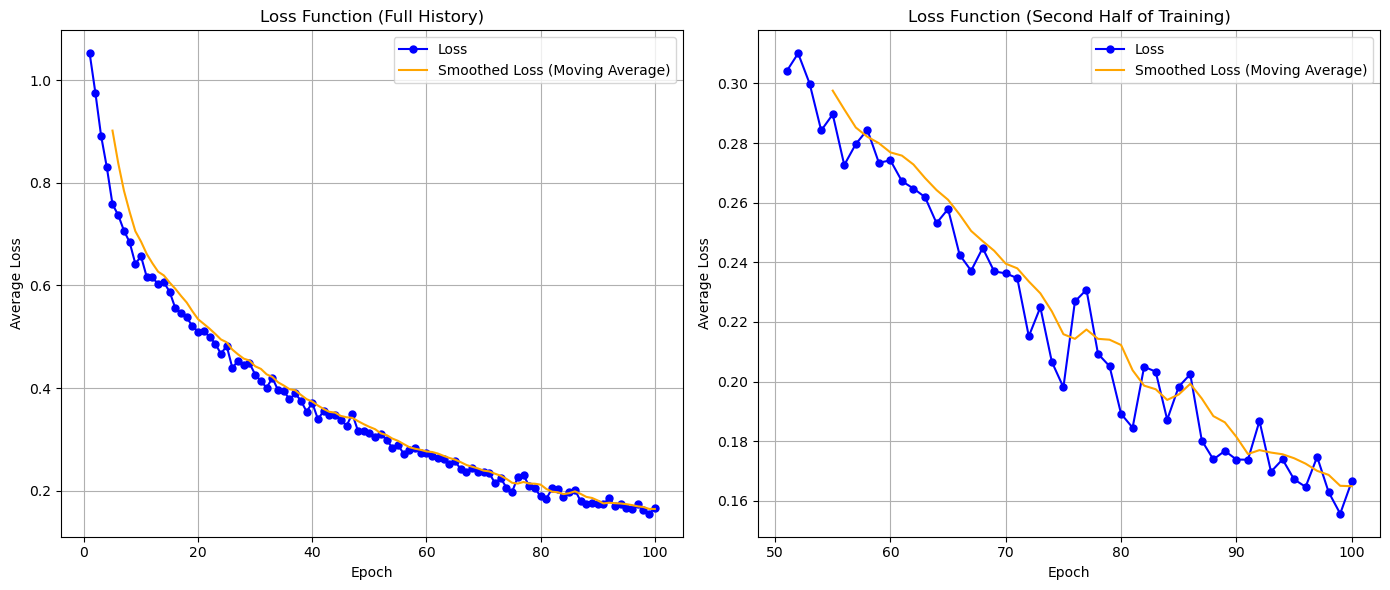

In [33]:
trainer.plot_training_history()

#### Оценка

In [34]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9803    0.9940    0.9871       500
  chimpanzee     0.9822    0.9960    0.9891       500
    mushroom     0.9918    0.9640    0.9777       500

    accuracy                         0.9847      1500
   macro avg     0.9848    0.9847    0.9846      1500
weighted avg     0.9848    0.9847    0.9846      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8348    0.9600    0.8930       100
  chimpanzee     0.8587    0.7900    0.8229       100
    mushroom     0.8280    0.7700    0.7979       100

    accuracy                         0.8400       300
   macro avg     0.8405    0.8400    0.8380       300
weighted avg     0.8405    0.8400    0.8380       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [35]:
trainer.save_model(cifar100)

Model saved as: cifar100_1_model.onnx


### Эксперимент №4

#### Гиперпараметры

In [36]:
batch_size=2**5
epochs=100
lr_rate = 1e-4
dropout_rate=0.3
hidden_layers=[2**5, 2**6, 2**7, 2**7, 2**6, 2**5]

#### Инициализация модели

In [37]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_2
CPU times: user 167 ms, sys: 280 ms, total: 447 ms
Wall time: 320 ms


In [38]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 1.51 ms


In [39]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_2


#### Информация о модели

In [40]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=64, out_features=32, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inplace=False)
    (18): Linear(in_features=32, out_features=3, bias=True)
  )
)

#### Обучение

In [41]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/100: 100%|████████████████████| 47/47 [00:00<00:00, 228.15batch/s, loss=1.052368, lr=0.000100]


Epoch: 1/100, Loss: 1.093281


Epoch 2/100: 100%|████████████████████| 47/47 [00:00<00:00, 203.28batch/s, loss=0.978523, lr=0.000100]


Epoch: 2/100, Loss: 1.060138


Epoch 3/100: 100%|████████████████████| 47/47 [00:00<00:00, 188.57batch/s, loss=0.984053, lr=0.000100]


Epoch: 3/100, Loss: 1.006730


Epoch 4/100: 100%|████████████████████| 47/47 [00:00<00:00, 182.93batch/s, loss=0.918944, lr=0.000100]


Epoch: 4/100, Loss: 0.983634


Epoch 5/100: 100%|████████████████████| 47/47 [00:00<00:00, 196.15batch/s, loss=1.067916, lr=0.000100]


Epoch: 5/100, Loss: 0.957871


Epoch 6/100: 100%|████████████████████| 47/47 [00:00<00:00, 183.66batch/s, loss=1.058125, lr=0.000100]


Epoch: 6/100, Loss: 0.931818


Epoch 7/100: 100%|████████████████████| 47/47 [00:00<00:00, 188.16batch/s, loss=0.896899, lr=0.000100]


Epoch: 7/100, Loss: 0.902953


Epoch 8/100: 100%|████████████████████| 47/47 [00:00<00:00, 195.22batch/s, loss=0.824158, lr=0.000100]


Epoch: 8/100, Loss: 0.829132


Epoch 9/100: 100%|████████████████████| 47/47 [00:00<00:00, 192.24batch/s, loss=0.593579, lr=0.000100]


Epoch: 9/100, Loss: 0.766099


Epoch 10/100: 100%|███████████████████| 47/47 [00:00<00:00, 178.66batch/s, loss=0.636377, lr=0.000100]


Epoch: 10/100, Loss: 0.712734


Epoch 11/100: 100%|███████████████████| 47/47 [00:00<00:00, 211.68batch/s, loss=0.876406, lr=0.000100]


Epoch: 11/100, Loss: 0.700388


Epoch 12/100: 100%|███████████████████| 47/47 [00:00<00:00, 212.62batch/s, loss=0.635744, lr=0.000100]


Epoch: 12/100, Loss: 0.693345


Epoch 13/100: 100%|███████████████████| 47/47 [00:00<00:00, 228.37batch/s, loss=0.742679, lr=0.000100]


Epoch: 13/100, Loss: 0.672948


Epoch 14/100: 100%|███████████████████| 47/47 [00:00<00:00, 229.72batch/s, loss=0.712582, lr=0.000100]


Epoch: 14/100, Loss: 0.662453


Epoch 15/100: 100%|███████████████████| 47/47 [00:00<00:00, 230.34batch/s, loss=0.473181, lr=0.000100]


Epoch: 15/100, Loss: 0.659078


Epoch 16/100: 100%|███████████████████| 47/47 [00:00<00:00, 212.92batch/s, loss=0.625361, lr=0.000100]


Epoch: 16/100, Loss: 0.629583


Epoch 17/100: 100%|███████████████████| 47/47 [00:00<00:00, 217.26batch/s, loss=0.490159, lr=0.000100]


Epoch: 17/100, Loss: 0.602910


Epoch 18/100: 100%|███████████████████| 47/47 [00:00<00:00, 228.91batch/s, loss=0.584033, lr=0.000100]


Epoch: 18/100, Loss: 0.584634


Epoch 19/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.57batch/s, loss=0.788573, lr=0.000100]


Epoch: 19/100, Loss: 0.568269


Epoch 20/100: 100%|███████████████████| 47/47 [00:00<00:00, 214.81batch/s, loss=0.543585, lr=0.000100]


Epoch: 20/100, Loss: 0.564101


Epoch 21/100: 100%|███████████████████| 47/47 [00:00<00:00, 209.73batch/s, loss=0.479174, lr=0.000100]


Epoch: 21/100, Loss: 0.516189


Epoch 22/100: 100%|███████████████████| 47/47 [00:00<00:00, 184.03batch/s, loss=0.696009, lr=0.000100]


Epoch: 22/100, Loss: 0.526939


Epoch 23/100: 100%|███████████████████| 47/47 [00:00<00:00, 258.47batch/s, loss=0.628278, lr=0.000100]


Epoch: 23/100, Loss: 0.506278


Epoch 24/100: 100%|███████████████████| 47/47 [00:00<00:00, 228.06batch/s, loss=0.510315, lr=0.000100]


Epoch: 24/100, Loss: 0.485190


Epoch 25/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.26batch/s, loss=0.494457, lr=0.000100]


Epoch: 25/100, Loss: 0.473830


Epoch 26/100: 100%|███████████████████| 47/47 [00:00<00:00, 200.37batch/s, loss=0.379930, lr=0.000100]


Epoch: 26/100, Loss: 0.440407


Epoch 27/100: 100%|███████████████████| 47/47 [00:00<00:00, 272.03batch/s, loss=0.487264, lr=0.000100]


Epoch: 27/100, Loss: 0.433847


Epoch 28/100: 100%|███████████████████| 47/47 [00:00<00:00, 241.81batch/s, loss=0.731809, lr=0.000100]


Epoch: 28/100, Loss: 0.431948


Epoch 29/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.73batch/s, loss=0.353114, lr=0.000100]


Epoch: 29/100, Loss: 0.430038


Epoch 30/100: 100%|███████████████████| 47/47 [00:00<00:00, 240.89batch/s, loss=0.261924, lr=0.000100]


Epoch: 30/100, Loss: 0.405416


Epoch 31/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.09batch/s, loss=0.333483, lr=0.000100]


Epoch: 31/100, Loss: 0.403563


Epoch 32/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.09batch/s, loss=0.507325, lr=0.000100]


Epoch: 32/100, Loss: 0.374324


Epoch 33/100: 100%|███████████████████| 47/47 [00:00<00:00, 260.61batch/s, loss=0.204557, lr=0.000100]


Epoch: 33/100, Loss: 0.364598


Epoch 34/100: 100%|███████████████████| 47/47 [00:00<00:00, 266.43batch/s, loss=0.283772, lr=0.000100]


Epoch: 34/100, Loss: 0.357959


Epoch 35/100: 100%|███████████████████| 47/47 [00:00<00:00, 259.87batch/s, loss=0.287825, lr=0.000100]


Epoch: 35/100, Loss: 0.339869


Epoch 36/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.71batch/s, loss=0.192604, lr=0.000100]


Epoch: 36/100, Loss: 0.342105


Epoch 37/100: 100%|███████████████████| 47/47 [00:00<00:00, 255.52batch/s, loss=0.260157, lr=0.000100]


Epoch: 37/100, Loss: 0.355518


Epoch 38/100: 100%|███████████████████| 47/47 [00:00<00:00, 271.59batch/s, loss=0.351965, lr=0.000100]


Epoch: 38/100, Loss: 0.319515


Epoch 39/100: 100%|███████████████████| 47/47 [00:00<00:00, 263.27batch/s, loss=0.254777, lr=0.000100]


Epoch: 39/100, Loss: 0.310496


Epoch 40/100: 100%|███████████████████| 47/47 [00:00<00:00, 242.63batch/s, loss=0.530384, lr=0.000100]


Epoch: 40/100, Loss: 0.315641


Epoch 41/100: 100%|███████████████████| 47/47 [00:00<00:00, 273.58batch/s, loss=0.391294, lr=0.000100]


Epoch: 41/100, Loss: 0.305544


Epoch 42/100: 100%|███████████████████| 47/47 [00:00<00:00, 274.58batch/s, loss=0.249862, lr=0.000100]


Epoch: 42/100, Loss: 0.286612


Epoch 43/100: 100%|███████████████████| 47/47 [00:00<00:00, 273.47batch/s, loss=0.207620, lr=0.000100]


Epoch: 43/100, Loss: 0.306253


Epoch 44/100: 100%|███████████████████| 47/47 [00:00<00:00, 273.37batch/s, loss=0.072676, lr=0.000100]


Epoch: 44/100, Loss: 0.268935


Epoch 45/100: 100%|███████████████████| 47/47 [00:00<00:00, 256.59batch/s, loss=0.171360, lr=0.000100]


Epoch: 45/100, Loss: 0.268811


Epoch 46/100: 100%|███████████████████| 47/47 [00:00<00:00, 237.04batch/s, loss=0.437785, lr=0.000100]


Epoch: 46/100, Loss: 0.275795


Epoch 47/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.82batch/s, loss=0.124921, lr=0.000100]


Epoch: 47/100, Loss: 0.255240


Epoch 48/100: 100%|███████████████████| 47/47 [00:00<00:00, 234.58batch/s, loss=0.160830, lr=0.000100]


Epoch: 48/100, Loss: 0.249410


Epoch 49/100: 100%|███████████████████| 47/47 [00:00<00:00, 205.29batch/s, loss=0.167123, lr=0.000100]


Epoch: 49/100, Loss: 0.253043


Epoch 50/100: 100%|███████████████████| 47/47 [00:00<00:00, 226.00batch/s, loss=0.113342, lr=0.000100]


Epoch: 50/100, Loss: 0.220924


Epoch 51/100: 100%|███████████████████| 47/47 [00:00<00:00, 215.76batch/s, loss=0.341618, lr=0.000100]


Epoch: 51/100, Loss: 0.238690


Epoch 52/100: 100%|███████████████████| 47/47 [00:00<00:00, 242.98batch/s, loss=0.239903, lr=0.000100]


Epoch: 52/100, Loss: 0.242584


Epoch 53/100: 100%|███████████████████| 47/47 [00:00<00:00, 253.55batch/s, loss=0.302491, lr=0.000100]


Epoch: 53/100, Loss: 0.237923


Epoch 54/100: 100%|███████████████████| 47/47 [00:00<00:00, 207.51batch/s, loss=0.435132, lr=0.000090]


Epoch: 54/100, Loss: 0.219575


Epoch 55/100: 100%|███████████████████| 47/47 [00:00<00:00, 232.49batch/s, loss=0.187524, lr=0.000090]


Epoch: 55/100, Loss: 0.221049


Epoch 56/100: 100%|███████████████████| 47/47 [00:00<00:00, 240.23batch/s, loss=0.277048, lr=0.000090]


Epoch: 56/100, Loss: 0.222008


Epoch 57/100: 100%|███████████████████| 47/47 [00:00<00:00, 227.87batch/s, loss=0.283994, lr=0.000090]


Epoch: 57/100, Loss: 0.184013


Epoch 58/100: 100%|███████████████████| 47/47 [00:00<00:00, 275.65batch/s, loss=0.136868, lr=0.000090]


Epoch: 58/100, Loss: 0.198072


Epoch 59/100: 100%|███████████████████| 47/47 [00:00<00:00, 254.57batch/s, loss=0.239670, lr=0.000090]


Epoch: 59/100, Loss: 0.184523


Epoch 60/100: 100%|███████████████████| 47/47 [00:00<00:00, 243.00batch/s, loss=0.062303, lr=0.000090]


Epoch: 60/100, Loss: 0.190182


Epoch 61/100: 100%|███████████████████| 47/47 [00:00<00:00, 230.27batch/s, loss=0.235693, lr=0.000081]


Epoch: 61/100, Loss: 0.202028


Epoch 62/100: 100%|███████████████████| 47/47 [00:00<00:00, 225.48batch/s, loss=0.248929, lr=0.000081]


Epoch: 62/100, Loss: 0.202902


Epoch 63/100: 100%|███████████████████| 47/47 [00:00<00:00, 235.21batch/s, loss=0.088476, lr=0.000081]


Epoch: 63/100, Loss: 0.165012


Epoch 64/100: 100%|███████████████████| 47/47 [00:00<00:00, 266.25batch/s, loss=0.226076, lr=0.000081]


Epoch: 64/100, Loss: 0.172714


Epoch 65/100: 100%|███████████████████| 47/47 [00:00<00:00, 263.44batch/s, loss=0.062393, lr=0.000081]


Epoch: 65/100, Loss: 0.188712


Epoch 66/100: 100%|███████████████████| 47/47 [00:00<00:00, 229.58batch/s, loss=0.354052, lr=0.000081]


Epoch: 66/100, Loss: 0.163338


Epoch 67/100: 100%|███████████████████| 47/47 [00:00<00:00, 245.62batch/s, loss=0.132222, lr=0.000081]


Epoch: 67/100, Loss: 0.170294


Epoch 68/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.75batch/s, loss=0.210410, lr=0.000081]


Epoch: 68/100, Loss: 0.169645


Epoch 69/100: 100%|███████████████████| 47/47 [00:00<00:00, 209.14batch/s, loss=0.052652, lr=0.000081]


Epoch: 69/100, Loss: 0.181843


Epoch 70/100: 100%|███████████████████| 47/47 [00:00<00:00, 206.92batch/s, loss=0.296939, lr=0.000073]


Epoch: 70/100, Loss: 0.175908


Epoch 71/100: 100%|███████████████████| 47/47 [00:00<00:00, 223.42batch/s, loss=0.106894, lr=0.000073]


Epoch: 71/100, Loss: 0.160341


Epoch 72/100: 100%|███████████████████| 47/47 [00:00<00:00, 173.57batch/s, loss=0.077626, lr=0.000073]


Epoch: 72/100, Loss: 0.148980


Epoch 73/100: 100%|███████████████████| 47/47 [00:00<00:00, 215.45batch/s, loss=0.099371, lr=0.000073]


Epoch: 73/100, Loss: 0.173458


Epoch 74/100: 100%|███████████████████| 47/47 [00:00<00:00, 239.94batch/s, loss=0.075367, lr=0.000073]


Epoch: 74/100, Loss: 0.154020


Epoch 75/100: 100%|███████████████████| 47/47 [00:00<00:00, 208.27batch/s, loss=0.294042, lr=0.000073]


Epoch: 75/100, Loss: 0.147142


Epoch 76/100: 100%|███████████████████| 47/47 [00:00<00:00, 220.62batch/s, loss=0.209399, lr=0.000073]


Epoch: 76/100, Loss: 0.157187


Epoch 77/100: 100%|███████████████████| 47/47 [00:00<00:00, 247.53batch/s, loss=0.175721, lr=0.000073]


Epoch: 77/100, Loss: 0.152557


Epoch 78/100: 100%|███████████████████| 47/47 [00:00<00:00, 246.66batch/s, loss=0.367451, lr=0.000073]


Epoch: 78/100, Loss: 0.154921


Epoch 79/100: 100%|███████████████████| 47/47 [00:00<00:00, 228.38batch/s, loss=0.148760, lr=0.000066]


Epoch: 79/100, Loss: 0.128591


Epoch 80/100: 100%|███████████████████| 47/47 [00:00<00:00, 235.00batch/s, loss=0.017993, lr=0.000066]


Epoch: 80/100, Loss: 0.128443


Epoch 81/100: 100%|███████████████████| 47/47 [00:00<00:00, 223.49batch/s, loss=0.214548, lr=0.000066]


Epoch: 81/100, Loss: 0.150761


Epoch 82/100: 100%|███████████████████| 47/47 [00:00<00:00, 266.53batch/s, loss=0.051574, lr=0.000066]


Epoch: 82/100, Loss: 0.136379


Epoch 83/100: 100%|███████████████████| 47/47 [00:00<00:00, 259.98batch/s, loss=0.124723, lr=0.000066]


Epoch: 83/100, Loss: 0.138094


Epoch 84/100: 100%|███████████████████| 47/47 [00:00<00:00, 231.97batch/s, loss=0.044985, lr=0.000059]


Epoch: 84/100, Loss: 0.129959


Epoch 85/100: 100%|███████████████████| 47/47 [00:00<00:00, 242.23batch/s, loss=0.043162, lr=0.000059]


Epoch: 85/100, Loss: 0.120251


Epoch 86/100: 100%|███████████████████| 47/47 [00:00<00:00, 208.47batch/s, loss=0.304863, lr=0.000059]


Epoch: 86/100, Loss: 0.133808


Epoch 87/100: 100%|███████████████████| 47/47 [00:00<00:00, 243.04batch/s, loss=0.185114, lr=0.000059]


Epoch: 87/100, Loss: 0.114484


Epoch 88/100: 100%|███████████████████| 47/47 [00:00<00:00, 250.28batch/s, loss=0.335036, lr=0.000059]


Epoch: 88/100, Loss: 0.107140


Epoch 89/100: 100%|███████████████████| 47/47 [00:00<00:00, 234.68batch/s, loss=0.055156, lr=0.000059]


Epoch: 89/100, Loss: 0.109502


Epoch 90/100: 100%|███████████████████| 47/47 [00:00<00:00, 230.92batch/s, loss=0.059510, lr=0.000059]


Epoch: 90/100, Loss: 0.108366


Epoch 91/100: 100%|███████████████████| 47/47 [00:00<00:00, 252.77batch/s, loss=0.158959, lr=0.000059]


Epoch: 91/100, Loss: 0.109063


Epoch 92/100: 100%|███████████████████| 47/47 [00:00<00:00, 252.64batch/s, loss=0.111638, lr=0.000053]


Epoch: 92/100, Loss: 0.149181


Epoch 93/100: 100%|███████████████████| 47/47 [00:00<00:00, 249.90batch/s, loss=0.086057, lr=0.000053]


Epoch: 93/100, Loss: 0.105039


Epoch 94/100: 100%|███████████████████| 47/47 [00:00<00:00, 199.72batch/s, loss=0.096581, lr=0.000053]


Epoch: 94/100, Loss: 0.127790


Epoch 95/100: 100%|███████████████████| 47/47 [00:00<00:00, 211.20batch/s, loss=0.028626, lr=0.000053]


Epoch: 95/100, Loss: 0.103995


Epoch 96/100: 100%|███████████████████| 47/47 [00:00<00:00, 208.63batch/s, loss=0.392264, lr=0.000053]


Epoch: 96/100, Loss: 0.126176


Epoch 97/100: 100%|███████████████████| 47/47 [00:00<00:00, 226.81batch/s, loss=0.052008, lr=0.000053]


Epoch: 97/100, Loss: 0.098560


Epoch 98/100: 100%|███████████████████| 47/47 [00:00<00:00, 235.28batch/s, loss=0.030004, lr=0.000053]


Epoch: 98/100, Loss: 0.104876


Epoch 99/100: 100%|███████████████████| 47/47 [00:00<00:00, 248.31batch/s, loss=0.063126, lr=0.000053]


Epoch: 99/100, Loss: 0.098491


Epoch 100/100: 100%|██████████████████| 47/47 [00:00<00:00, 230.35batch/s, loss=0.178171, lr=0.000053]


Epoch: 100/100, Loss: 0.119196
CPU times: user 21.6 s, sys: 1.3 s, total: 22.9 s
Wall time: 20.8 s


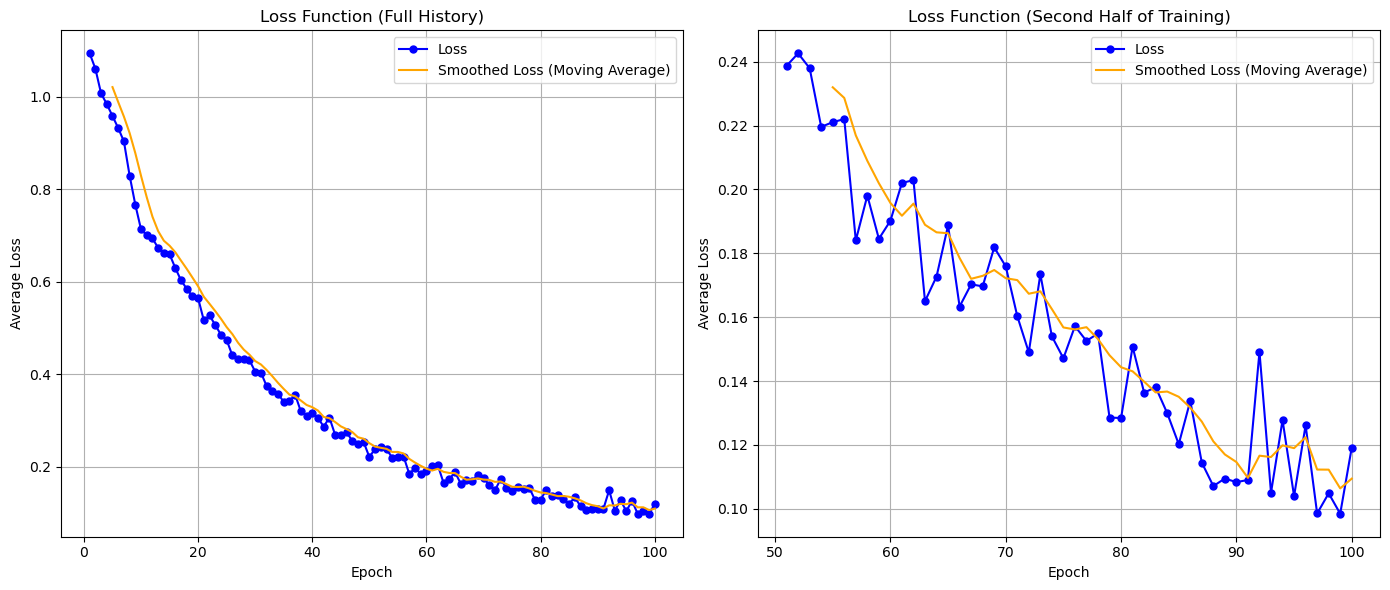

In [42]:
trainer.plot_training_history()

#### Оценка

In [43]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9921    1.0000    0.9960       500
  chimpanzee     0.9843    1.0000    0.9921       500
    mushroom     1.0000    0.9760    0.9879       500

    accuracy                         0.9920      1500
   macro avg     0.9921    0.9920    0.9920      1500
weighted avg     0.9921    0.9920    0.9920      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8230    0.9300    0.8732       100
  chimpanzee     0.8444    0.7600    0.8000       100
    mushroom     0.8247    0.8000    0.8122       100

    accuracy                         0.8300       300
   macro avg     0.8307    0.8300    0.8285       300
weighted avg     0.8307    0.8300    0.8285       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [44]:
trainer.save_model(cifar100)

Model saved as: cifar100_2_model.onnx


### Эксперимент №5

#### Гиперпараметры

In [45]:
batch_size=2**5
epochs=1000
lr_rate = 1e-4
dropout_rate=0.2
hidden_layers=[2**5, 2**7, 2**10, 2**7, 2**5]

#### Инициализация модели

In [46]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_3
CPU times: user 190 ms, sys: 273 ms, total: 462 ms
Wall time: 314 ms


In [47]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 24.2 ms, sys: 1.44 ms, total: 25.6 ms
Wall time: 3.07 ms


In [48]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_3


#### Информация о модели

In [49]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=1024, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=32, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=32, out_features=3, bias=True)
  )
)

#### Обучение

In [50]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/1000: 100%|███████████████████| 47/47 [00:00<00:00, 254.32batch/s, loss=0.936508, lr=0.000100]


Epoch: 1/1000, Loss: 1.052833


Epoch 2/1000: 100%|███████████████████| 47/47 [00:00<00:00, 242.20batch/s, loss=0.742525, lr=0.000100]


Epoch: 2/1000, Loss: 0.793119


Epoch 3/1000: 100%|███████████████████| 47/47 [00:00<00:00, 218.95batch/s, loss=0.498794, lr=0.000100]


Epoch: 3/1000, Loss: 0.673294


Epoch 4/1000: 100%|███████████████████| 47/47 [00:00<00:00, 258.14batch/s, loss=0.906543, lr=0.000100]


Epoch: 4/1000, Loss: 0.612068


Epoch 5/1000: 100%|███████████████████| 47/47 [00:00<00:00, 264.52batch/s, loss=0.420616, lr=0.000100]


Epoch: 5/1000, Loss: 0.572165


Epoch 6/1000: 100%|███████████████████| 47/47 [00:00<00:00, 249.89batch/s, loss=0.456448, lr=0.000100]


Epoch: 6/1000, Loss: 0.534415


Epoch 7/1000: 100%|███████████████████| 47/47 [00:00<00:00, 234.77batch/s, loss=0.447570, lr=0.000100]


Epoch: 7/1000, Loss: 0.501424


Epoch 8/1000: 100%|███████████████████| 47/47 [00:00<00:00, 237.23batch/s, loss=0.408687, lr=0.000100]


Epoch: 8/1000, Loss: 0.483003


Epoch 9/1000: 100%|███████████████████| 47/47 [00:00<00:00, 238.22batch/s, loss=0.533833, lr=0.000100]


Epoch: 9/1000, Loss: 0.442447


Epoch 10/1000: 100%|██████████████████| 47/47 [00:00<00:00, 257.45batch/s, loss=0.391911, lr=0.000100]


Epoch: 10/1000, Loss: 0.428561


Epoch 11/1000: 100%|██████████████████| 47/47 [00:00<00:00, 254.25batch/s, loss=0.692486, lr=0.000100]


Epoch: 11/1000, Loss: 0.392155


Epoch 12/1000: 100%|██████████████████| 47/47 [00:00<00:00, 257.20batch/s, loss=0.432087, lr=0.000100]


Epoch: 12/1000, Loss: 0.381444


Epoch 13/1000: 100%|██████████████████| 47/47 [00:00<00:00, 233.54batch/s, loss=0.450848, lr=0.000100]


Epoch: 13/1000, Loss: 0.346767


Epoch 14/1000: 100%|██████████████████| 47/47 [00:00<00:00, 230.87batch/s, loss=0.488833, lr=0.000100]


Epoch: 14/1000, Loss: 0.340623


Epoch 15/1000: 100%|██████████████████| 47/47 [00:00<00:00, 247.93batch/s, loss=0.361894, lr=0.000100]


Epoch: 15/1000, Loss: 0.315854


Epoch 16/1000: 100%|██████████████████| 47/47 [00:00<00:00, 259.85batch/s, loss=0.280410, lr=0.000100]


Epoch: 16/1000, Loss: 0.327717


Epoch 17/1000: 100%|██████████████████| 47/47 [00:00<00:00, 246.08batch/s, loss=0.115558, lr=0.000100]


Epoch: 17/1000, Loss: 0.268838


Epoch 18/1000: 100%|██████████████████| 47/47 [00:00<00:00, 220.68batch/s, loss=0.287940, lr=0.000100]


Epoch: 18/1000, Loss: 0.265411


Epoch 19/1000: 100%|██████████████████| 47/47 [00:00<00:00, 216.96batch/s, loss=0.367195, lr=0.000100]


Epoch: 19/1000, Loss: 0.237086


Epoch 20/1000: 100%|██████████████████| 47/47 [00:00<00:00, 237.34batch/s, loss=0.231750, lr=0.000100]


Epoch: 20/1000, Loss: 0.223331


Epoch 21/1000: 100%|██████████████████| 47/47 [00:00<00:00, 215.84batch/s, loss=0.220742, lr=0.000100]


Epoch: 21/1000, Loss: 0.231983


Epoch 22/1000: 100%|██████████████████| 47/47 [00:00<00:00, 218.12batch/s, loss=0.295435, lr=0.000100]


Epoch: 22/1000, Loss: 0.212475


Epoch 23/1000: 100%|██████████████████| 47/47 [00:00<00:00, 238.64batch/s, loss=0.241790, lr=0.000100]


Epoch: 23/1000, Loss: 0.224173


Epoch 24/1000: 100%|██████████████████| 47/47 [00:00<00:00, 236.83batch/s, loss=0.212854, lr=0.000100]


Epoch: 24/1000, Loss: 0.201796


Epoch 25/1000: 100%|██████████████████| 47/47 [00:00<00:00, 227.56batch/s, loss=0.197196, lr=0.000100]


Epoch: 25/1000, Loss: 0.209935


Epoch 26/1000: 100%|██████████████████| 47/47 [00:00<00:00, 250.35batch/s, loss=0.207992, lr=0.000100]


Epoch: 26/1000, Loss: 0.177874


Epoch 27/1000: 100%|██████████████████| 47/47 [00:00<00:00, 253.40batch/s, loss=0.237285, lr=0.000100]


Epoch: 27/1000, Loss: 0.172920


Epoch 28/1000: 100%|██████████████████| 47/47 [00:00<00:00, 251.29batch/s, loss=0.031249, lr=0.000100]


Epoch: 28/1000, Loss: 0.157463


Epoch 29/1000: 100%|██████████████████| 47/47 [00:00<00:00, 222.72batch/s, loss=0.206125, lr=0.000100]


Epoch: 29/1000, Loss: 0.167175


Epoch 30/1000: 100%|██████████████████| 47/47 [00:00<00:00, 226.02batch/s, loss=0.080500, lr=0.000100]


Epoch: 30/1000, Loss: 0.159083


Epoch 31/1000: 100%|██████████████████| 47/47 [00:00<00:00, 223.66batch/s, loss=0.105472, lr=0.000100]


Epoch: 31/1000, Loss: 0.149115


Epoch 32/1000: 100%|██████████████████| 47/47 [00:00<00:00, 242.83batch/s, loss=0.169629, lr=0.000100]


Epoch: 32/1000, Loss: 0.154615


Epoch 33/1000: 100%|██████████████████| 47/47 [00:00<00:00, 216.88batch/s, loss=0.165316, lr=0.000100]


Epoch: 33/1000, Loss: 0.125909


Epoch 34/1000: 100%|██████████████████| 47/47 [00:00<00:00, 222.89batch/s, loss=0.131575, lr=0.000100]


Epoch: 34/1000, Loss: 0.118147


Epoch 35/1000: 100%|██████████████████| 47/47 [00:00<00:00, 244.71batch/s, loss=0.071468, lr=0.000100]


Epoch: 35/1000, Loss: 0.141239


Epoch 36/1000: 100%|██████████████████| 47/47 [00:00<00:00, 226.04batch/s, loss=0.205521, lr=0.000100]


Epoch: 36/1000, Loss: 0.128126


Epoch 37/1000: 100%|██████████████████| 47/47 [00:00<00:00, 236.33batch/s, loss=0.304489, lr=0.000100]


Epoch: 37/1000, Loss: 0.133810


Epoch 38/1000: 100%|██████████████████| 47/47 [00:00<00:00, 237.24batch/s, loss=0.186526, lr=0.000090]


Epoch: 38/1000, Loss: 0.110520


Epoch 39/1000: 100%|██████████████████| 47/47 [00:00<00:00, 228.73batch/s, loss=0.156327, lr=0.000090]


Epoch: 39/1000, Loss: 0.123705


Epoch 40/1000: 100%|██████████████████| 47/47 [00:00<00:00, 236.15batch/s, loss=0.080928, lr=0.000090]


Epoch: 40/1000, Loss: 0.114240


Epoch 41/1000: 100%|██████████████████| 47/47 [00:00<00:00, 235.64batch/s, loss=0.095156, lr=0.000090]


Epoch: 41/1000, Loss: 0.133070


Epoch 42/1000: 100%|██████████████████| 47/47 [00:00<00:00, 214.92batch/s, loss=0.110803, lr=0.000081]


Epoch: 42/1000, Loss: 0.091815


Epoch 43/1000: 100%|██████████████████| 47/47 [00:00<00:00, 232.33batch/s, loss=0.079021, lr=0.000081]


Epoch: 43/1000, Loss: 0.094244


Epoch 44/1000: 100%|██████████████████| 47/47 [00:00<00:00, 242.67batch/s, loss=0.123813, lr=0.000081]


Epoch: 44/1000, Loss: 0.080796


Epoch 45/1000: 100%|██████████████████| 47/47 [00:00<00:00, 236.20batch/s, loss=0.033901, lr=0.000081]


Epoch: 45/1000, Loss: 0.095605


Epoch 46/1000: 100%|██████████████████| 47/47 [00:00<00:00, 254.11batch/s, loss=0.263399, lr=0.000081]


Epoch: 46/1000, Loss: 0.096805


Epoch 47/1000: 100%|██████████████████| 47/47 [00:00<00:00, 230.76batch/s, loss=0.046759, lr=0.000081]


Epoch: 47/1000, Loss: 0.097184


Epoch 48/1000: 100%|██████████████████| 47/47 [00:00<00:00, 209.34batch/s, loss=0.054071, lr=0.000073]


Epoch: 48/1000, Loss: 0.091573


Epoch 49/1000: 100%|██████████████████| 47/47 [00:00<00:00, 227.95batch/s, loss=0.155378, lr=0.000073]


Epoch: 49/1000, Loss: 0.089766


Epoch 50/1000: 100%|██████████████████| 47/47 [00:00<00:00, 236.22batch/s, loss=0.017257, lr=0.000073]


Epoch: 50/1000, Loss: 0.072647


Epoch 51/1000: 100%|██████████████████| 47/47 [00:00<00:00, 237.09batch/s, loss=0.044120, lr=0.000073]


Epoch: 51/1000, Loss: 0.086674


Epoch 52/1000: 100%|██████████████████| 47/47 [00:00<00:00, 215.52batch/s, loss=0.120301, lr=0.000073]


Epoch: 52/1000, Loss: 0.080393


Epoch 53/1000: 100%|██████████████████| 47/47 [00:00<00:00, 243.11batch/s, loss=0.023991, lr=0.000073]


Epoch: 53/1000, Loss: 0.059663


Epoch 54/1000: 100%|██████████████████| 47/47 [00:00<00:00, 253.02batch/s, loss=0.025784, lr=0.000073]


Epoch: 54/1000, Loss: 0.080176


Epoch 55/1000: 100%|██████████████████| 47/47 [00:00<00:00, 239.49batch/s, loss=0.005814, lr=0.000073]


Epoch: 55/1000, Loss: 0.067017


Epoch 56/1000: 100%|██████████████████| 47/47 [00:00<00:00, 215.36batch/s, loss=0.080631, lr=0.000073]


Epoch: 56/1000, Loss: 0.079476


Epoch 57/1000: 100%|██████████████████| 47/47 [00:00<00:00, 239.30batch/s, loss=0.112286, lr=0.000066]


Epoch: 57/1000, Loss: 0.061639


Epoch 58/1000: 100%|██████████████████| 47/47 [00:00<00:00, 226.95batch/s, loss=0.016988, lr=0.000066]


Epoch: 58/1000, Loss: 0.060326


Epoch 59/1000: 100%|██████████████████| 47/47 [00:00<00:00, 251.90batch/s, loss=0.403988, lr=0.000066]


Epoch: 59/1000, Loss: 0.057305


Epoch 60/1000: 100%|██████████████████| 47/47 [00:00<00:00, 240.73batch/s, loss=0.005683, lr=0.000066]


Epoch: 60/1000, Loss: 0.056938


Epoch 61/1000: 100%|██████████████████| 47/47 [00:00<00:00, 246.09batch/s, loss=0.139424, lr=0.000066]


Epoch: 61/1000, Loss: 0.059968


Epoch 62/1000: 100%|██████████████████| 47/47 [00:00<00:00, 228.33batch/s, loss=0.062093, lr=0.000066]


Epoch: 62/1000, Loss: 0.060645


Epoch 63/1000: 100%|██████████████████| 47/47 [00:00<00:00, 238.97batch/s, loss=0.015122, lr=0.000066]


Epoch: 63/1000, Loss: 0.047993


Epoch 64/1000: 100%|██████████████████| 47/47 [00:00<00:00, 248.61batch/s, loss=0.010870, lr=0.000066]


Epoch: 64/1000, Loss: 0.059920


Epoch 65/1000: 100%|██████████████████| 47/47 [00:00<00:00, 256.46batch/s, loss=0.020260, lr=0.000066]


Epoch: 65/1000, Loss: 0.053281


Epoch 66/1000: 100%|██████████████████| 47/47 [00:00<00:00, 237.93batch/s, loss=0.012401, lr=0.000066]


Epoch: 66/1000, Loss: 0.060430


Epoch 67/1000: 100%|██████████████████| 47/47 [00:00<00:00, 223.86batch/s, loss=0.014413, lr=0.000059]


Epoch: 67/1000, Loss: 0.055641


Epoch 68/1000: 100%|██████████████████| 47/47 [00:00<00:00, 242.43batch/s, loss=0.101797, lr=0.000059]


Epoch: 68/1000, Loss: 0.049738


Epoch 69/1000: 100%|██████████████████| 47/47 [00:00<00:00, 230.70batch/s, loss=0.006237, lr=0.000059]


Epoch: 69/1000, Loss: 0.064471


Epoch 70/1000: 100%|██████████████████| 47/47 [00:00<00:00, 249.21batch/s, loss=0.009843, lr=0.000053]


Epoch: 70/1000, Loss: 0.050646


Epoch 71/1000: 100%|██████████████████| 47/47 [00:00<00:00, 257.24batch/s, loss=0.095582, lr=0.000053]


Epoch: 71/1000, Loss: 0.051899


Epoch 72/1000: 100%|██████████████████| 47/47 [00:00<00:00, 251.96batch/s, loss=0.009301, lr=0.000053]


Epoch: 72/1000, Loss: 0.039045


Epoch 73/1000: 100%|██████████████████| 47/47 [00:00<00:00, 260.65batch/s, loss=0.068064, lr=0.000053]


Epoch: 73/1000, Loss: 0.042503


Epoch 74/1000: 100%|██████████████████| 47/47 [00:00<00:00, 242.23batch/s, loss=0.006307, lr=0.000053]


Epoch: 74/1000, Loss: 0.042275


Epoch 75/1000: 100%|██████████████████| 47/47 [00:00<00:00, 203.52batch/s, loss=0.065282, lr=0.000053]


Epoch: 75/1000, Loss: 0.045478


Epoch 76/1000: 100%|██████████████████| 47/47 [00:00<00:00, 211.57batch/s, loss=0.011956, lr=0.000048]


Epoch: 76/1000, Loss: 0.026119


Epoch 77/1000: 100%|██████████████████| 47/47 [00:00<00:00, 219.21batch/s, loss=0.028242, lr=0.000048]


Epoch: 77/1000, Loss: 0.042013


Epoch 78/1000: 100%|██████████████████| 47/47 [00:00<00:00, 207.07batch/s, loss=0.010591, lr=0.000048]


Epoch: 78/1000, Loss: 0.046499


Epoch 79/1000: 100%|██████████████████| 47/47 [00:00<00:00, 203.81batch/s, loss=0.026539, lr=0.000048]


Epoch: 79/1000, Loss: 0.045790


Epoch 80/1000: 100%|██████████████████| 47/47 [00:00<00:00, 213.03batch/s, loss=0.074396, lr=0.000043]


Epoch: 80/1000, Loss: 0.044282


Epoch 81/1000: 100%|██████████████████| 47/47 [00:00<00:00, 216.93batch/s, loss=0.001651, lr=0.000043]


Epoch: 81/1000, Loss: 0.037034


Epoch 82/1000: 100%|██████████████████| 47/47 [00:00<00:00, 262.06batch/s, loss=0.000441, lr=0.000043]


Epoch: 82/1000, Loss: 0.042197


Epoch 83/1000: 100%|██████████████████| 47/47 [00:00<00:00, 251.53batch/s, loss=0.013855, lr=0.000039]


Epoch: 83/1000, Loss: 0.045509


Epoch 84/1000: 100%|██████████████████| 47/47 [00:00<00:00, 274.86batch/s, loss=0.078793, lr=0.000039]


Epoch: 84/1000, Loss: 0.035010


Epoch 85/1000: 100%|██████████████████| 47/47 [00:00<00:00, 246.53batch/s, loss=0.005669, lr=0.000039]


Epoch: 85/1000, Loss: 0.023611


Epoch 86/1000: 100%|██████████████████| 47/47 [00:00<00:00, 243.01batch/s, loss=0.022726, lr=0.000039]


Epoch: 86/1000, Loss: 0.044419


Epoch 87/1000: 100%|██████████████████| 47/47 [00:00<00:00, 244.81batch/s, loss=0.014820, lr=0.000039]


Epoch: 87/1000, Loss: 0.042311


Epoch 88/1000: 100%|██████████████████| 47/47 [00:00<00:00, 248.03batch/s, loss=0.017846, lr=0.000039]


Epoch: 88/1000, Loss: 0.034957


Epoch 89/1000: 100%|██████████████████| 47/47 [00:00<00:00, 248.53batch/s, loss=0.024430, lr=0.000035]


Epoch: 89/1000, Loss: 0.027174


Epoch 90/1000: 100%|██████████████████| 47/47 [00:00<00:00, 261.81batch/s, loss=0.013981, lr=0.000035]


Epoch: 90/1000, Loss: 0.039805


Epoch 91/1000: 100%|██████████████████| 47/47 [00:00<00:00, 239.18batch/s, loss=0.001607, lr=0.000035]


Epoch: 91/1000, Loss: 0.047227


Epoch 92/1000: 100%|██████████████████| 47/47 [00:00<00:00, 254.31batch/s, loss=0.009874, lr=0.000031]


Epoch: 92/1000, Loss: 0.043083


Epoch 93/1000: 100%|██████████████████| 47/47 [00:00<00:00, 241.98batch/s, loss=0.027647, lr=0.000031]


Epoch: 93/1000, Loss: 0.025466


Epoch 94/1000: 100%|██████████████████| 47/47 [00:00<00:00, 252.79batch/s, loss=0.001667, lr=0.000031]


Epoch: 94/1000, Loss: 0.026116


Epoch 95/1000: 100%|██████████████████| 47/47 [00:00<00:00, 264.22batch/s, loss=0.015656, lr=0.000028]


Epoch: 95/1000, Loss: 0.019273


Epoch 96/1000: 100%|██████████████████| 47/47 [00:00<00:00, 265.27batch/s, loss=0.002060, lr=0.000028]


Epoch: 96/1000, Loss: 0.029247


Epoch 97/1000: 100%|██████████████████| 47/47 [00:00<00:00, 281.21batch/s, loss=0.009356, lr=0.000028]


Epoch: 97/1000, Loss: 0.032716


Epoch 98/1000: 100%|██████████████████| 47/47 [00:00<00:00, 260.73batch/s, loss=0.001088, lr=0.000028]


Epoch: 98/1000, Loss: 0.019390


Epoch 99/1000: 100%|██████████████████| 47/47 [00:00<00:00, 234.40batch/s, loss=0.008132, lr=0.000025]


Epoch: 99/1000, Loss: 0.023577


Epoch 100/1000: 100%|█████████████████| 47/47 [00:00<00:00, 251.51batch/s, loss=0.038027, lr=0.000025]


Epoch: 100/1000, Loss: 0.032862


Epoch 101/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.81batch/s, loss=0.005228, lr=0.000025]


Epoch: 101/1000, Loss: 0.019624


Epoch 102/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.77batch/s, loss=0.041524, lr=0.000023]


Epoch: 102/1000, Loss: 0.021693


Epoch 103/1000: 100%|█████████████████| 47/47 [00:00<00:00, 271.09batch/s, loss=0.007360, lr=0.000023]


Epoch: 103/1000, Loss: 0.023569


Epoch 104/1000: 100%|█████████████████| 47/47 [00:00<00:00, 286.90batch/s, loss=0.006652, lr=0.000023]


Epoch: 104/1000, Loss: 0.030598


Epoch 105/1000: 100%|█████████████████| 47/47 [00:00<00:00, 264.41batch/s, loss=0.009249, lr=0.000021]


Epoch: 105/1000, Loss: 0.027787


Epoch 106/1000: 100%|█████████████████| 47/47 [00:00<00:00, 258.12batch/s, loss=0.012381, lr=0.000021]


Epoch: 106/1000, Loss: 0.030918


Epoch 107/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.90batch/s, loss=0.069930, lr=0.000021]


Epoch: 107/1000, Loss: 0.024285


Epoch 108/1000: 100%|█████████████████| 47/47 [00:00<00:00, 251.83batch/s, loss=0.004420, lr=0.000019]


Epoch: 108/1000, Loss: 0.017712


Epoch 109/1000: 100%|█████████████████| 47/47 [00:00<00:00, 291.92batch/s, loss=0.002465, lr=0.000019]


Epoch: 109/1000, Loss: 0.018813


Epoch 110/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.76batch/s, loss=0.001125, lr=0.000019]


Epoch: 110/1000, Loss: 0.026912


Epoch 111/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.98batch/s, loss=0.017967, lr=0.000019]


Epoch: 111/1000, Loss: 0.028739


Epoch 112/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.67batch/s, loss=0.008087, lr=0.000017]

Epoch: 112/1000, Loss: 0.025600



Epoch 113/1000: 100%|█████████████████| 47/47 [00:00<00:00, 283.71batch/s, loss=0.007796, lr=0.000017]


Epoch: 113/1000, Loss: 0.038295


Epoch 114/1000: 100%|█████████████████| 47/47 [00:00<00:00, 217.43batch/s, loss=0.000733, lr=0.000017]


Epoch: 114/1000, Loss: 0.015364


Epoch 115/1000: 100%|█████████████████| 47/47 [00:00<00:00, 269.43batch/s, loss=0.010244, lr=0.000017]


Epoch: 115/1000, Loss: 0.020490


Epoch 116/1000: 100%|█████████████████| 47/47 [00:00<00:00, 272.40batch/s, loss=0.002923, lr=0.000017]


Epoch: 116/1000, Loss: 0.021952


Epoch 117/1000: 100%|█████████████████| 47/47 [00:00<00:00, 285.42batch/s, loss=0.007837, lr=0.000017]


Epoch: 117/1000, Loss: 0.019375


Epoch 118/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.68batch/s, loss=0.001062, lr=0.000015]


Epoch: 118/1000, Loss: 0.037174


Epoch 119/1000: 100%|█████████████████| 47/47 [00:00<00:00, 204.52batch/s, loss=0.095396, lr=0.000015]


Epoch: 119/1000, Loss: 0.023887


Epoch 120/1000: 100%|█████████████████| 47/47 [00:00<00:00, 191.11batch/s, loss=0.058080, lr=0.000015]


Epoch: 120/1000, Loss: 0.014002


Epoch 121/1000: 100%|█████████████████| 47/47 [00:00<00:00, 205.30batch/s, loss=0.015494, lr=0.000015]


Epoch: 121/1000, Loss: 0.024149


Epoch 122/1000: 100%|█████████████████| 47/47 [00:00<00:00, 238.38batch/s, loss=0.022023, lr=0.000015]


Epoch: 122/1000, Loss: 0.022679


Epoch 123/1000: 100%|█████████████████| 47/47 [00:00<00:00, 260.95batch/s, loss=0.002327, lr=0.000015]


Epoch: 123/1000, Loss: 0.024479


Epoch 124/1000: 100%|█████████████████| 47/47 [00:00<00:00, 280.35batch/s, loss=0.006057, lr=0.000014]


Epoch: 124/1000, Loss: 0.044871


Epoch 125/1000: 100%|█████████████████| 47/47 [00:00<00:00, 266.15batch/s, loss=0.002794, lr=0.000014]


Epoch: 125/1000, Loss: 0.027996


Epoch 126/1000: 100%|█████████████████| 47/47 [00:00<00:00, 254.99batch/s, loss=0.004003, lr=0.000014]


Epoch: 126/1000, Loss: 0.037662


Epoch 127/1000: 100%|█████████████████| 47/47 [00:00<00:00, 270.10batch/s, loss=0.177304, lr=0.000012]


Epoch: 127/1000, Loss: 0.019095


Epoch 128/1000: 100%|█████████████████| 47/47 [00:00<00:00, 238.95batch/s, loss=0.008878, lr=0.000012]


Epoch: 128/1000, Loss: 0.027858


Epoch 129/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.12batch/s, loss=0.045587, lr=0.000012]


Epoch: 129/1000, Loss: 0.018263


Epoch 130/1000: 100%|█████████████████| 47/47 [00:00<00:00, 248.01batch/s, loss=0.023906, lr=0.000011]


Epoch: 130/1000, Loss: 0.026404


Epoch 131/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.51batch/s, loss=0.004147, lr=0.000011]


Epoch: 131/1000, Loss: 0.028638


Epoch 132/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.42batch/s, loss=0.001786, lr=0.000011]


Epoch: 132/1000, Loss: 0.024500


Epoch 133/1000: 100%|█████████████████| 47/47 [00:00<00:00, 247.64batch/s, loss=0.007979, lr=0.000010]


Epoch: 133/1000, Loss: 0.025746


Epoch 134/1000: 100%|█████████████████| 47/47 [00:00<00:00, 264.22batch/s, loss=0.027223, lr=0.000010]


Epoch: 134/1000, Loss: 0.016942


Epoch 135/1000: 100%|█████████████████| 47/47 [00:00<00:00, 241.49batch/s, loss=0.001941, lr=0.000010]


Epoch: 135/1000, Loss: 0.019413


Epoch 136/1000: 100%|█████████████████| 47/47 [00:00<00:00, 260.51batch/s, loss=0.027555, lr=0.000009]


Epoch: 136/1000, Loss: 0.034854


Epoch 137/1000: 100%|█████████████████| 47/47 [00:00<00:00, 268.96batch/s, loss=0.051834, lr=0.000009]


Epoch: 137/1000, Loss: 0.024725


Epoch 138/1000: 100%|█████████████████| 47/47 [00:00<00:00, 283.55batch/s, loss=0.007777, lr=0.000009]


Epoch: 138/1000, Loss: 0.022799


Epoch 139/1000: 100%|█████████████████| 47/47 [00:00<00:00, 238.75batch/s, loss=0.004932, lr=0.000008]


Epoch: 139/1000, Loss: 0.027678


Epoch 140/1000: 100%|█████████████████| 47/47 [00:00<00:00, 232.25batch/s, loss=0.005465, lr=0.000008]


Epoch: 140/1000, Loss: 0.017195


Epoch 141/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.64batch/s, loss=0.134204, lr=0.000008]


Epoch: 141/1000, Loss: 0.027410


Epoch 142/1000: 100%|█████████████████| 47/47 [00:00<00:00, 216.41batch/s, loss=0.001856, lr=0.000007]


Epoch: 142/1000, Loss: 0.028292


Epoch 143/1000: 100%|█████████████████| 47/47 [00:00<00:00, 204.58batch/s, loss=0.022957, lr=0.000007]


Epoch: 143/1000, Loss: 0.034740


Epoch 144/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.34batch/s, loss=0.001497, lr=0.000007]


Epoch: 144/1000, Loss: 0.017527


Epoch 145/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.18batch/s, loss=0.009399, lr=0.000006]


Epoch: 145/1000, Loss: 0.009839


Epoch 146/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.42batch/s, loss=0.033564, lr=0.000006]


Epoch: 146/1000, Loss: 0.018789


Epoch 147/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.58batch/s, loss=0.317208, lr=0.000006]


Epoch: 147/1000, Loss: 0.032968


Epoch 148/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.26batch/s, loss=0.003107, lr=0.000006]


Epoch: 148/1000, Loss: 0.021679


Epoch 149/1000: 100%|█████████████████| 47/47 [00:00<00:00, 218.68batch/s, loss=0.003802, lr=0.000006]


Epoch: 149/1000, Loss: 0.020968


Epoch 150/1000: 100%|█████████████████| 47/47 [00:00<00:00, 209.00batch/s, loss=0.062962, lr=0.000006]


Epoch: 150/1000, Loss: 0.017446


Epoch 151/1000: 100%|█████████████████| 47/47 [00:00<00:00, 201.13batch/s, loss=0.055517, lr=0.000006]


Epoch: 151/1000, Loss: 0.015324


Epoch 152/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.30batch/s, loss=0.011121, lr=0.000005]


Epoch: 152/1000, Loss: 0.028677


Epoch 153/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.92batch/s, loss=0.001897, lr=0.000005]


Epoch: 153/1000, Loss: 0.012267


Epoch 154/1000: 100%|█████████████████| 47/47 [00:00<00:00, 204.66batch/s, loss=0.014831, lr=0.000005]


Epoch: 154/1000, Loss: 0.020246


Epoch 155/1000: 100%|█████████████████| 47/47 [00:00<00:00, 207.42batch/s, loss=0.046505, lr=0.000005]


Epoch: 155/1000, Loss: 0.029453


Epoch 156/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.20batch/s, loss=0.001253, lr=0.000005]


Epoch: 156/1000, Loss: 0.020494


Epoch 157/1000: 100%|█████████████████| 47/47 [00:00<00:00, 248.27batch/s, loss=0.001705, lr=0.000005]


Epoch: 157/1000, Loss: 0.019191


Epoch 158/1000: 100%|█████████████████| 47/47 [00:00<00:00, 244.97batch/s, loss=0.009364, lr=0.000004]


Epoch: 158/1000, Loss: 0.015625


Epoch 159/1000: 100%|█████████████████| 47/47 [00:00<00:00, 241.95batch/s, loss=0.002444, lr=0.000004]


Epoch: 159/1000, Loss: 0.014952


Epoch 160/1000: 100%|█████████████████| 47/47 [00:00<00:00, 245.67batch/s, loss=0.007620, lr=0.000004]


Epoch: 160/1000, Loss: 0.021445


Epoch 161/1000: 100%|█████████████████| 47/47 [00:00<00:00, 233.32batch/s, loss=0.003453, lr=0.000004]


Epoch: 161/1000, Loss: 0.021529


Epoch 162/1000: 100%|█████████████████| 47/47 [00:00<00:00, 232.58batch/s, loss=0.013272, lr=0.000004]


Epoch: 162/1000, Loss: 0.018635


Epoch 163/1000: 100%|█████████████████| 47/47 [00:00<00:00, 255.08batch/s, loss=0.002350, lr=0.000004]


Epoch: 163/1000, Loss: 0.011406


Epoch 164/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.98batch/s, loss=0.001242, lr=0.000003]


Epoch: 164/1000, Loss: 0.016915


Epoch 165/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.38batch/s, loss=0.003545, lr=0.000003]


Epoch: 165/1000, Loss: 0.016267


Epoch 166/1000: 100%|█████████████████| 47/47 [00:00<00:00, 271.40batch/s, loss=0.003174, lr=0.000003]


Epoch: 166/1000, Loss: 0.017206


Epoch 167/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.74batch/s, loss=0.017660, lr=0.000003]


Epoch: 167/1000, Loss: 0.014637


Epoch 168/1000: 100%|█████████████████| 47/47 [00:00<00:00, 232.02batch/s, loss=0.001704, lr=0.000003]


Epoch: 168/1000, Loss: 0.021943


Epoch 169/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.76batch/s, loss=0.001822, lr=0.000003]


Epoch: 169/1000, Loss: 0.019209


Epoch 170/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.81batch/s, loss=0.072832, lr=0.000003]


Epoch: 170/1000, Loss: 0.021263


Epoch 171/1000: 100%|█████████████████| 47/47 [00:00<00:00, 256.36batch/s, loss=0.013885, lr=0.000003]


Epoch: 171/1000, Loss: 0.012842


Epoch 172/1000: 100%|█████████████████| 47/47 [00:00<00:00, 252.43batch/s, loss=0.016194, lr=0.000003]


Epoch: 172/1000, Loss: 0.015254


Epoch 173/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.54batch/s, loss=0.006478, lr=0.000003]


Epoch: 173/1000, Loss: 0.012928


Epoch 174/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.94batch/s, loss=0.007174, lr=0.000003]

Epoch: 174/1000, Loss: 0.022173



Epoch 175/1000: 100%|█████████████████| 47/47 [00:00<00:00, 245.82batch/s, loss=0.001486, lr=0.000003]


Epoch: 175/1000, Loss: 0.012650


Epoch 176/1000: 100%|█████████████████| 47/47 [00:00<00:00, 248.25batch/s, loss=0.002601, lr=0.000002]


Epoch: 176/1000, Loss: 0.026425


Epoch 177/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.57batch/s, loss=0.002531, lr=0.000002]


Epoch: 177/1000, Loss: 0.019993


Epoch 178/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.04batch/s, loss=0.004064, lr=0.000002]


Epoch: 178/1000, Loss: 0.026703


Epoch 179/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.84batch/s, loss=0.116126, lr=0.000002]


Epoch: 179/1000, Loss: 0.021644


Epoch 180/1000: 100%|█████████████████| 47/47 [00:00<00:00, 233.04batch/s, loss=0.001993, lr=0.000002]


Epoch: 180/1000, Loss: 0.017319


Epoch 181/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.06batch/s, loss=0.000999, lr=0.000002]


Epoch: 181/1000, Loss: 0.012836


Epoch 182/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.68batch/s, loss=0.013622, lr=0.000002]


Epoch: 182/1000, Loss: 0.020202


Epoch 183/1000: 100%|█████████████████| 47/47 [00:00<00:00, 220.81batch/s, loss=0.007918, lr=0.000002]


Epoch: 183/1000, Loss: 0.015567


Epoch 184/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.98batch/s, loss=0.059530, lr=0.000002]


Epoch: 184/1000, Loss: 0.015859


Epoch 185/1000: 100%|█████████████████| 47/47 [00:00<00:00, 242.68batch/s, loss=0.000972, lr=0.000002]


Epoch: 185/1000, Loss: 0.016701


Epoch 186/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.34batch/s, loss=0.001402, lr=0.000002]


Epoch: 186/1000, Loss: 0.017578


Epoch 187/1000: 100%|█████████████████| 47/47 [00:00<00:00, 267.60batch/s, loss=0.006700, lr=0.000002]


Epoch: 187/1000, Loss: 0.010821


Epoch 188/1000: 100%|█████████████████| 47/47 [00:00<00:00, 261.27batch/s, loss=0.000450, lr=0.000001]


Epoch: 188/1000, Loss: 0.015807


Epoch 189/1000: 100%|█████████████████| 47/47 [00:00<00:00, 261.42batch/s, loss=0.011267, lr=0.000001]


Epoch: 189/1000, Loss: 0.014727


Epoch 190/1000: 100%|█████████████████| 47/47 [00:00<00:00, 292.29batch/s, loss=0.001546, lr=0.000001]


Epoch: 190/1000, Loss: 0.032400


Epoch 191/1000: 100%|█████████████████| 47/47 [00:00<00:00, 269.04batch/s, loss=0.014936, lr=0.000001]


Epoch: 191/1000, Loss: 0.019061


Epoch 192/1000: 100%|█████████████████| 47/47 [00:00<00:00, 264.40batch/s, loss=0.005513, lr=0.000001]


Epoch: 192/1000, Loss: 0.014036


Epoch 193/1000: 100%|█████████████████| 47/47 [00:00<00:00, 261.08batch/s, loss=0.184164, lr=0.000001]


Epoch: 193/1000, Loss: 0.027078


Epoch 194/1000: 100%|█████████████████| 47/47 [00:00<00:00, 247.14batch/s, loss=0.000963, lr=0.000001]


Epoch: 194/1000, Loss: 0.023069


Epoch 195/1000: 100%|█████████████████| 47/47 [00:00<00:00, 261.50batch/s, loss=0.009039, lr=0.000001]


Epoch: 195/1000, Loss: 0.021681


Epoch 196/1000: 100%|█████████████████| 47/47 [00:00<00:00, 266.58batch/s, loss=0.034327, lr=0.000001]


Epoch: 196/1000, Loss: 0.022608


Epoch 197/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.17batch/s, loss=0.069448, lr=0.000001]


Epoch: 197/1000, Loss: 0.024166


Epoch 198/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.51batch/s, loss=0.002077, lr=0.000001]


Epoch: 198/1000, Loss: 0.020363


Epoch 199/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.23batch/s, loss=0.005274, lr=0.000001]


Epoch: 199/1000, Loss: 0.015598


Epoch 200/1000: 100%|█████████████████| 47/47 [00:00<00:00, 261.58batch/s, loss=0.007245, lr=0.000001]


Epoch: 200/1000, Loss: 0.029219


Epoch 201/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.35batch/s, loss=0.001084, lr=0.000001]


Epoch: 201/1000, Loss: 0.019797


Epoch 202/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.26batch/s, loss=0.016256, lr=0.000001]


Epoch: 202/1000, Loss: 0.019851


Epoch 203/1000: 100%|█████████████████| 47/47 [00:00<00:00, 259.51batch/s, loss=0.066491, lr=0.000001]


Epoch: 203/1000, Loss: 0.015480


Epoch 204/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.14batch/s, loss=0.006350, lr=0.000001]


Epoch: 204/1000, Loss: 0.021246


Epoch 205/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.96batch/s, loss=0.003712, lr=0.000001]


Epoch: 205/1000, Loss: 0.009631


Epoch 206/1000: 100%|█████████████████| 47/47 [00:00<00:00, 259.05batch/s, loss=0.015698, lr=0.000001]


Epoch: 206/1000, Loss: 0.015402


Epoch 207/1000: 100%|█████████████████| 47/47 [00:00<00:00, 257.64batch/s, loss=0.002698, lr=0.000001]


Epoch: 207/1000, Loss: 0.016744


Epoch 208/1000: 100%|█████████████████| 47/47 [00:00<00:00, 275.78batch/s, loss=0.002312, lr=0.000001]


Epoch: 208/1000, Loss: 0.018835


Epoch 209/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.33batch/s, loss=0.002745, lr=0.000001]


Epoch: 209/1000, Loss: 0.011980


Epoch 210/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.57batch/s, loss=0.001070, lr=0.000001]


Epoch: 210/1000, Loss: 0.014401


Epoch 211/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.09batch/s, loss=0.007674, lr=0.000001]


Epoch: 211/1000, Loss: 0.016382


Epoch 212/1000: 100%|█████████████████| 47/47 [00:00<00:00, 227.44batch/s, loss=0.008813, lr=0.000001]


Epoch: 212/1000, Loss: 0.024827


Epoch 213/1000: 100%|█████████████████| 47/47 [00:00<00:00, 251.16batch/s, loss=0.026150, lr=0.000001]


Epoch: 213/1000, Loss: 0.023919


Epoch 214/1000: 100%|█████████████████| 47/47 [00:00<00:00, 256.10batch/s, loss=0.000769, lr=0.000001]


Epoch: 214/1000, Loss: 0.019307


Epoch 215/1000: 100%|█████████████████| 47/47 [00:00<00:00, 247.35batch/s, loss=0.001992, lr=0.000001]


Epoch: 215/1000, Loss: 0.015991


Epoch 216/1000: 100%|█████████████████| 47/47 [00:00<00:00, 251.60batch/s, loss=0.023189, lr=0.000001]


Epoch: 216/1000, Loss: 0.018320


Epoch 217/1000: 100%|█████████████████| 47/47 [00:00<00:00, 227.87batch/s, loss=0.003256, lr=0.000001]


Epoch: 217/1000, Loss: 0.010986


Epoch 218/1000: 100%|█████████████████| 47/47 [00:00<00:00, 222.32batch/s, loss=0.063409, lr=0.000001]


Epoch: 218/1000, Loss: 0.017689


Epoch 219/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.39batch/s, loss=0.002380, lr=0.000001]


Epoch: 219/1000, Loss: 0.015356


Epoch 220/1000: 100%|█████████████████| 47/47 [00:00<00:00, 178.59batch/s, loss=0.001431, lr=0.000001]


Epoch: 220/1000, Loss: 0.014953


Epoch 221/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.95batch/s, loss=0.001727, lr=0.000001]


Epoch: 221/1000, Loss: 0.010096


Epoch 222/1000: 100%|█████████████████| 47/47 [00:00<00:00, 215.41batch/s, loss=0.000438, lr=0.000001]


Epoch: 222/1000, Loss: 0.021682


Epoch 223/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.22batch/s, loss=0.001547, lr=0.000001]


Epoch: 223/1000, Loss: 0.014651


Epoch 224/1000: 100%|█████████████████| 47/47 [00:00<00:00, 263.44batch/s, loss=0.005454, lr=0.000000]


Epoch: 224/1000, Loss: 0.030723


Epoch 225/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.38batch/s, loss=0.009775, lr=0.000000]


Epoch: 225/1000, Loss: 0.018360


Epoch 226/1000: 100%|█████████████████| 47/47 [00:00<00:00, 207.25batch/s, loss=0.002594, lr=0.000000]


Epoch: 226/1000, Loss: 0.015910


Epoch 227/1000: 100%|█████████████████| 47/47 [00:00<00:00, 223.25batch/s, loss=0.048889, lr=0.000000]


Epoch: 227/1000, Loss: 0.022102


Epoch 228/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.29batch/s, loss=0.014102, lr=0.000000]


Epoch: 228/1000, Loss: 0.016331


Epoch 229/1000: 100%|█████████████████| 47/47 [00:00<00:00, 264.20batch/s, loss=0.007915, lr=0.000000]


Epoch: 229/1000, Loss: 0.020163


Epoch 230/1000: 100%|█████████████████| 47/47 [00:00<00:00, 271.34batch/s, loss=0.006536, lr=0.000000]


Epoch: 230/1000, Loss: 0.023433


Epoch 231/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.01batch/s, loss=0.005556, lr=0.000000]


Epoch: 231/1000, Loss: 0.022263


Epoch 232/1000: 100%|█████████████████| 47/47 [00:00<00:00, 256.45batch/s, loss=0.001733, lr=0.000000]


Epoch: 232/1000, Loss: 0.018604


Epoch 233/1000: 100%|█████████████████| 47/47 [00:00<00:00, 266.33batch/s, loss=0.245727, lr=0.000000]


Epoch: 233/1000, Loss: 0.019131


Epoch 234/1000: 100%|█████████████████| 47/47 [00:00<00:00, 258.82batch/s, loss=0.158572, lr=0.000000]


Epoch: 234/1000, Loss: 0.024604


Epoch 235/1000: 100%|█████████████████| 47/47 [00:00<00:00, 271.43batch/s, loss=0.017078, lr=0.000000]


Epoch: 235/1000, Loss: 0.017281


Epoch 236/1000: 100%|█████████████████| 47/47 [00:00<00:00, 269.46batch/s, loss=0.000878, lr=0.000000]


Epoch: 236/1000, Loss: 0.016101


Epoch 237/1000: 100%|█████████████████| 47/47 [00:00<00:00, 239.31batch/s, loss=0.007748, lr=0.000000]


Epoch: 237/1000, Loss: 0.014701


Epoch 238/1000: 100%|█████████████████| 47/47 [00:00<00:00, 242.87batch/s, loss=0.001761, lr=0.000000]


Epoch: 238/1000, Loss: 0.018634


Epoch 239/1000: 100%|█████████████████| 47/47 [00:00<00:00, 260.91batch/s, loss=0.013108, lr=0.000000]


Epoch: 239/1000, Loss: 0.013330


Epoch 240/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.82batch/s, loss=0.013730, lr=0.000000]


Epoch: 240/1000, Loss: 0.014162


Epoch 241/1000: 100%|█████████████████| 47/47 [00:00<00:00, 239.45batch/s, loss=0.008406, lr=0.000000]


Epoch: 241/1000, Loss: 0.020632


Epoch 242/1000: 100%|█████████████████| 47/47 [00:00<00:00, 252.14batch/s, loss=0.002703, lr=0.000000]


Epoch: 242/1000, Loss: 0.017257


Epoch 243/1000: 100%|█████████████████| 47/47 [00:00<00:00, 261.87batch/s, loss=0.002938, lr=0.000000]


Epoch: 243/1000, Loss: 0.019109


Epoch 244/1000: 100%|█████████████████| 47/47 [00:00<00:00, 248.99batch/s, loss=0.001760, lr=0.000000]


Epoch: 244/1000, Loss: 0.018652


Epoch 245/1000: 100%|█████████████████| 47/47 [00:00<00:00, 266.97batch/s, loss=0.048261, lr=0.000000]


Epoch: 245/1000, Loss: 0.026860


Epoch 246/1000: 100%|█████████████████| 47/47 [00:00<00:00, 244.43batch/s, loss=0.000302, lr=0.000000]


Epoch: 246/1000, Loss: 0.022885


Epoch 247/1000: 100%|█████████████████| 47/47 [00:00<00:00, 251.43batch/s, loss=0.015634, lr=0.000000]


Epoch: 247/1000, Loss: 0.020919


Epoch 248/1000: 100%|█████████████████| 47/47 [00:00<00:00, 263.96batch/s, loss=0.046994, lr=0.000000]


Epoch: 248/1000, Loss: 0.015212


Epoch 249/1000: 100%|█████████████████| 47/47 [00:00<00:00, 272.71batch/s, loss=0.001497, lr=0.000000]


Epoch: 249/1000, Loss: 0.014692


Epoch 250/1000: 100%|█████████████████| 47/47 [00:00<00:00, 269.61batch/s, loss=0.056473, lr=0.000000]


Epoch: 250/1000, Loss: 0.017246


Epoch 251/1000: 100%|█████████████████| 47/47 [00:00<00:00, 262.50batch/s, loss=0.048407, lr=0.000000]


Epoch: 251/1000, Loss: 0.018549


Epoch 252/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.74batch/s, loss=0.001601, lr=0.000000]


Epoch: 252/1000, Loss: 0.014222


Epoch 253/1000: 100%|█████████████████| 47/47 [00:00<00:00, 245.41batch/s, loss=0.004628, lr=0.000000]


Epoch: 253/1000, Loss: 0.015425


Epoch 254/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.31batch/s, loss=0.007912, lr=0.000000]


Epoch: 254/1000, Loss: 0.014754


Epoch 255/1000: 100%|█████████████████| 47/47 [00:00<00:00, 277.53batch/s, loss=0.206904, lr=0.000000]


Epoch: 255/1000, Loss: 0.016153


Epoch 256/1000: 100%|█████████████████| 47/47 [00:00<00:00, 267.19batch/s, loss=0.007338, lr=0.000000]


Epoch: 256/1000, Loss: 0.023793


Epoch 257/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.62batch/s, loss=0.010765, lr=0.000000]


Epoch: 257/1000, Loss: 0.019944


Epoch 258/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.94batch/s, loss=0.000406, lr=0.000000]


Epoch: 258/1000, Loss: 0.026198


Epoch 259/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.57batch/s, loss=0.000786, lr=0.000000]


Epoch: 259/1000, Loss: 0.023852


Epoch 260/1000: 100%|█████████████████| 47/47 [00:00<00:00, 251.57batch/s, loss=0.007260, lr=0.000000]


Epoch: 260/1000, Loss: 0.015546


Epoch 261/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.73batch/s, loss=0.014366, lr=0.000000]


Epoch: 261/1000, Loss: 0.024344


Epoch 262/1000: 100%|█████████████████| 47/47 [00:00<00:00, 244.63batch/s, loss=0.043804, lr=0.000000]


Epoch: 262/1000, Loss: 0.020368


Epoch 263/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.40batch/s, loss=0.001124, lr=0.000000]


Epoch: 263/1000, Loss: 0.024309


Epoch 264/1000: 100%|█████████████████| 47/47 [00:00<00:00, 241.29batch/s, loss=0.010215, lr=0.000000]


Epoch: 264/1000, Loss: 0.015709


Epoch 265/1000: 100%|█████████████████| 47/47 [00:00<00:00, 248.48batch/s, loss=0.000629, lr=0.000000]


Epoch: 265/1000, Loss: 0.018510


Epoch 266/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.94batch/s, loss=0.002872, lr=0.000000]


Epoch: 266/1000, Loss: 0.020259


Epoch 267/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.92batch/s, loss=0.000765, lr=0.000000]


Epoch: 267/1000, Loss: 0.017721


Epoch 268/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.41batch/s, loss=0.002312, lr=0.000000]


Epoch: 268/1000, Loss: 0.017864


Epoch 269/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.21batch/s, loss=0.179157, lr=0.000000]


Epoch: 269/1000, Loss: 0.026897


Epoch 270/1000: 100%|█████████████████| 47/47 [00:00<00:00, 239.03batch/s, loss=0.003647, lr=0.000000]


Epoch: 270/1000, Loss: 0.014315


Epoch 271/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.56batch/s, loss=0.005168, lr=0.000000]


Epoch: 271/1000, Loss: 0.019845


Epoch 272/1000: 100%|█████████████████| 47/47 [00:00<00:00, 222.80batch/s, loss=0.001765, lr=0.000000]


Epoch: 272/1000, Loss: 0.017558


Epoch 273/1000: 100%|█████████████████| 47/47 [00:00<00:00, 218.96batch/s, loss=0.010206, lr=0.000000]


Epoch: 273/1000, Loss: 0.026066


Epoch 274/1000: 100%|█████████████████| 47/47 [00:00<00:00, 220.06batch/s, loss=0.000626, lr=0.000000]


Epoch: 274/1000, Loss: 0.016802


Epoch 275/1000: 100%|█████████████████| 47/47 [00:00<00:00, 233.08batch/s, loss=0.151063, lr=0.000000]


Epoch: 275/1000, Loss: 0.015867


Epoch 276/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.26batch/s, loss=0.033907, lr=0.000000]


Epoch: 276/1000, Loss: 0.014774


Epoch 277/1000: 100%|█████████████████| 47/47 [00:00<00:00, 272.06batch/s, loss=0.029701, lr=0.000000]


Epoch: 277/1000, Loss: 0.020156


Epoch 278/1000: 100%|█████████████████| 47/47 [00:00<00:00, 255.96batch/s, loss=0.018279, lr=0.000000]


Epoch: 278/1000, Loss: 0.016860


Epoch 279/1000: 100%|█████████████████| 47/47 [00:00<00:00, 259.19batch/s, loss=0.012288, lr=0.000000]


Epoch: 279/1000, Loss: 0.018950


Epoch 280/1000: 100%|█████████████████| 47/47 [00:00<00:00, 276.04batch/s, loss=0.092304, lr=0.000000]


Epoch: 280/1000, Loss: 0.016356


Epoch 281/1000: 100%|█████████████████| 47/47 [00:00<00:00, 259.44batch/s, loss=0.001274, lr=0.000000]


Epoch: 281/1000, Loss: 0.013011


Epoch 282/1000: 100%|█████████████████| 47/47 [00:00<00:00, 252.54batch/s, loss=0.017421, lr=0.000000]


Epoch: 282/1000, Loss: 0.014676


Epoch 283/1000: 100%|█████████████████| 47/47 [00:00<00:00, 238.93batch/s, loss=0.003890, lr=0.000000]


Epoch: 283/1000, Loss: 0.011546


Epoch 284/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.46batch/s, loss=0.017939, lr=0.000000]


Epoch: 284/1000, Loss: 0.013534


Epoch 285/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.40batch/s, loss=0.003186, lr=0.000000]


Epoch: 285/1000, Loss: 0.012088


Epoch 286/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.30batch/s, loss=0.009834, lr=0.000000]


Epoch: 286/1000, Loss: 0.016369


Epoch 287/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.59batch/s, loss=0.003916, lr=0.000000]


Epoch: 287/1000, Loss: 0.017893


Epoch 288/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.28batch/s, loss=0.000778, lr=0.000000]


Epoch: 288/1000, Loss: 0.017147


Epoch 289/1000: 100%|█████████████████| 47/47 [00:00<00:00, 218.60batch/s, loss=0.003424, lr=0.000000]


Epoch: 289/1000, Loss: 0.019415


Epoch 290/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.24batch/s, loss=0.010064, lr=0.000000]


Epoch: 290/1000, Loss: 0.013894


Epoch 291/1000: 100%|█████████████████| 47/47 [00:00<00:00, 238.19batch/s, loss=0.027773, lr=0.000000]


Epoch: 291/1000, Loss: 0.017581


Epoch 292/1000: 100%|█████████████████| 47/47 [00:00<00:00, 241.23batch/s, loss=0.001146, lr=0.000000]


Epoch: 292/1000, Loss: 0.013652


Epoch 293/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.02batch/s, loss=0.001931, lr=0.000000]


Epoch: 293/1000, Loss: 0.023723


Epoch 294/1000: 100%|█████████████████| 47/47 [00:00<00:00, 216.58batch/s, loss=0.002862, lr=0.000000]


Epoch: 294/1000, Loss: 0.008381


Epoch 295/1000: 100%|█████████████████| 47/47 [00:00<00:00, 234.65batch/s, loss=0.003545, lr=0.000000]


Epoch: 295/1000, Loss: 0.025361


Epoch 296/1000: 100%|█████████████████| 47/47 [00:00<00:00, 244.43batch/s, loss=0.001338, lr=0.000000]


Epoch: 296/1000, Loss: 0.020770


Epoch 297/1000: 100%|█████████████████| 47/47 [00:00<00:00, 211.46batch/s, loss=0.002954, lr=0.000000]


Epoch: 297/1000, Loss: 0.012733


Epoch 298/1000: 100%|█████████████████| 47/47 [00:00<00:00, 213.92batch/s, loss=0.036573, lr=0.000000]


Epoch: 298/1000, Loss: 0.011568


Epoch 299/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.14batch/s, loss=0.045810, lr=0.000000]


Epoch: 299/1000, Loss: 0.014477


Epoch 300/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.73batch/s, loss=0.035821, lr=0.000000]


Epoch: 300/1000, Loss: 0.014416


Epoch 301/1000: 100%|█████████████████| 47/47 [00:00<00:00, 232.71batch/s, loss=0.004677, lr=0.000000]


Epoch: 301/1000, Loss: 0.013487


Epoch 302/1000: 100%|█████████████████| 47/47 [00:00<00:00, 207.77batch/s, loss=0.033991, lr=0.000000]


Epoch: 302/1000, Loss: 0.014804


Epoch 303/1000: 100%|█████████████████| 47/47 [00:00<00:00, 260.85batch/s, loss=0.000339, lr=0.000000]


Epoch: 303/1000, Loss: 0.016808


Epoch 304/1000: 100%|█████████████████| 47/47 [00:00<00:00, 263.65batch/s, loss=0.004358, lr=0.000000]


Epoch: 304/1000, Loss: 0.017218


Epoch 305/1000: 100%|█████████████████| 47/47 [00:00<00:00, 273.45batch/s, loss=0.003958, lr=0.000000]


Epoch: 305/1000, Loss: 0.017573


Epoch 306/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.50batch/s, loss=0.004909, lr=0.000000]


Epoch: 306/1000, Loss: 0.015092


Epoch 307/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.55batch/s, loss=0.000522, lr=0.000000]


Epoch: 307/1000, Loss: 0.023169


Epoch 308/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.92batch/s, loss=0.018165, lr=0.000000]


Epoch: 308/1000, Loss: 0.015061


Epoch 309/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.71batch/s, loss=0.002576, lr=0.000000]


Epoch: 309/1000, Loss: 0.008794


Epoch 310/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.63batch/s, loss=0.003525, lr=0.000000]


Epoch: 310/1000, Loss: 0.028865


Epoch 311/1000: 100%|█████████████████| 47/47 [00:00<00:00, 217.17batch/s, loss=0.036059, lr=0.000000]


Epoch: 311/1000, Loss: 0.010966


Epoch 312/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.19batch/s, loss=0.001935, lr=0.000000]


Epoch: 312/1000, Loss: 0.015894


Epoch 313/1000: 100%|█████████████████| 47/47 [00:00<00:00, 202.71batch/s, loss=0.053155, lr=0.000000]


Epoch: 313/1000, Loss: 0.022295


Epoch 314/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.75batch/s, loss=0.111179, lr=0.000000]


Epoch: 314/1000, Loss: 0.032255


Epoch 315/1000: 100%|█████████████████| 47/47 [00:00<00:00, 198.62batch/s, loss=0.002258, lr=0.000000]


Epoch: 315/1000, Loss: 0.020495


Epoch 316/1000: 100%|█████████████████| 47/47 [00:00<00:00, 206.64batch/s, loss=0.002165, lr=0.000000]


Epoch: 316/1000, Loss: 0.022961


Epoch 317/1000: 100%|█████████████████| 47/47 [00:00<00:00, 199.96batch/s, loss=0.002517, lr=0.000000]


Epoch: 317/1000, Loss: 0.021500


Epoch 318/1000: 100%|█████████████████| 47/47 [00:00<00:00, 216.16batch/s, loss=0.058518, lr=0.000000]


Epoch: 318/1000, Loss: 0.019054


Epoch 319/1000: 100%|█████████████████| 47/47 [00:00<00:00, 216.10batch/s, loss=0.006656, lr=0.000000]


Epoch: 319/1000, Loss: 0.016692


Epoch 320/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.25batch/s, loss=0.004016, lr=0.000000]


Epoch: 320/1000, Loss: 0.017560


Epoch 321/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.02batch/s, loss=0.001832, lr=0.000000]


Epoch: 321/1000, Loss: 0.023576


Epoch 322/1000: 100%|█████████████████| 47/47 [00:00<00:00, 255.14batch/s, loss=0.018329, lr=0.000000]


Epoch: 322/1000, Loss: 0.014588


Epoch 323/1000: 100%|█████████████████| 47/47 [00:00<00:00, 265.62batch/s, loss=0.016112, lr=0.000000]


Epoch: 323/1000, Loss: 0.018533


Epoch 324/1000: 100%|█████████████████| 47/47 [00:00<00:00, 247.96batch/s, loss=0.013639, lr=0.000000]


Epoch: 324/1000, Loss: 0.018091


Epoch 325/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.18batch/s, loss=0.006410, lr=0.000000]


Epoch: 325/1000, Loss: 0.011715


Epoch 326/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.78batch/s, loss=0.000577, lr=0.000000]


Epoch: 326/1000, Loss: 0.020612


Epoch 327/1000: 100%|█████████████████| 47/47 [00:00<00:00, 195.88batch/s, loss=0.008075, lr=0.000000]


Epoch: 327/1000, Loss: 0.018829


Epoch 328/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.33batch/s, loss=0.003082, lr=0.000000]


Epoch: 328/1000, Loss: 0.014122


Epoch 329/1000: 100%|█████████████████| 47/47 [00:00<00:00, 241.30batch/s, loss=0.005931, lr=0.000000]


Epoch: 329/1000, Loss: 0.018896


Epoch 330/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.40batch/s, loss=0.004201, lr=0.000000]


Epoch: 330/1000, Loss: 0.015737


Epoch 331/1000: 100%|█████████████████| 47/47 [00:00<00:00, 222.38batch/s, loss=0.005459, lr=0.000000]


Epoch: 331/1000, Loss: 0.012725


Epoch 332/1000: 100%|█████████████████| 47/47 [00:00<00:00, 254.12batch/s, loss=0.000784, lr=0.000000]


Epoch: 332/1000, Loss: 0.022239


Epoch 333/1000: 100%|█████████████████| 47/47 [00:00<00:00, 247.50batch/s, loss=0.004691, lr=0.000000]


Epoch: 333/1000, Loss: 0.025113


Epoch 334/1000: 100%|█████████████████| 47/47 [00:00<00:00, 238.39batch/s, loss=0.016786, lr=0.000000]


Epoch: 334/1000, Loss: 0.022553


Epoch 335/1000: 100%|█████████████████| 47/47 [00:00<00:00, 232.34batch/s, loss=0.004786, lr=0.000000]


Epoch: 335/1000, Loss: 0.017060


Epoch 336/1000: 100%|█████████████████| 47/47 [00:00<00:00, 268.82batch/s, loss=0.008893, lr=0.000000]


Epoch: 336/1000, Loss: 0.015413


Epoch 337/1000: 100%|█████████████████| 47/47 [00:00<00:00, 251.84batch/s, loss=0.005274, lr=0.000000]


Epoch: 337/1000, Loss: 0.011383


Epoch 338/1000: 100%|█████████████████| 47/47 [00:00<00:00, 258.69batch/s, loss=0.008433, lr=0.000000]


Epoch: 338/1000, Loss: 0.017614


Epoch 339/1000: 100%|█████████████████| 47/47 [00:00<00:00, 267.28batch/s, loss=0.000580, lr=0.000000]


Epoch: 339/1000, Loss: 0.017406


Epoch 340/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.12batch/s, loss=0.005639, lr=0.000000]


Epoch: 340/1000, Loss: 0.011662


Epoch 341/1000: 100%|█████████████████| 47/47 [00:00<00:00, 262.19batch/s, loss=0.009236, lr=0.000000]


Epoch: 341/1000, Loss: 0.018116


Epoch 342/1000: 100%|█████████████████| 47/47 [00:00<00:00, 252.43batch/s, loss=0.284599, lr=0.000000]


Epoch: 342/1000, Loss: 0.020358


Epoch 343/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.77batch/s, loss=0.006489, lr=0.000000]


Epoch: 343/1000, Loss: 0.023612


Epoch 344/1000: 100%|█████████████████| 47/47 [00:00<00:00, 263.99batch/s, loss=0.004621, lr=0.000000]


Epoch: 344/1000, Loss: 0.015050


Epoch 345/1000: 100%|█████████████████| 47/47 [00:00<00:00, 255.16batch/s, loss=0.002328, lr=0.000000]


Epoch: 345/1000, Loss: 0.022408


Epoch 346/1000: 100%|█████████████████| 47/47 [00:00<00:00, 256.71batch/s, loss=0.034587, lr=0.000000]


Epoch: 346/1000, Loss: 0.012051


Epoch 347/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.03batch/s, loss=0.055312, lr=0.000000]


Epoch: 347/1000, Loss: 0.013583


Epoch 348/1000: 100%|█████████████████| 47/47 [00:00<00:00, 264.06batch/s, loss=0.003249, lr=0.000000]


Epoch: 348/1000, Loss: 0.018944


Epoch 349/1000: 100%|█████████████████| 47/47 [00:00<00:00, 271.37batch/s, loss=0.004097, lr=0.000000]


Epoch: 349/1000, Loss: 0.019501


Epoch 350/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.58batch/s, loss=0.009626, lr=0.000000]


Epoch: 350/1000, Loss: 0.019896


Epoch 351/1000: 100%|█████████████████| 47/47 [00:00<00:00, 252.52batch/s, loss=0.001555, lr=0.000000]


Epoch: 351/1000, Loss: 0.018919


Epoch 352/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.74batch/s, loss=0.008142, lr=0.000000]


Epoch: 352/1000, Loss: 0.008339


Epoch 353/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.04batch/s, loss=0.001277, lr=0.000000]


Epoch: 353/1000, Loss: 0.013864


Epoch 354/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.67batch/s, loss=0.001155, lr=0.000000]


Epoch: 354/1000, Loss: 0.022459


Epoch 355/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.88batch/s, loss=0.010152, lr=0.000000]


Epoch: 355/1000, Loss: 0.021183


Epoch 356/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.61batch/s, loss=0.018770, lr=0.000000]


Epoch: 356/1000, Loss: 0.022964


Epoch 357/1000: 100%|█████████████████| 47/47 [00:00<00:00, 213.59batch/s, loss=0.057048, lr=0.000000]


Epoch: 357/1000, Loss: 0.017265


Epoch 358/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.16batch/s, loss=0.003285, lr=0.000000]


Epoch: 358/1000, Loss: 0.026436


Epoch 359/1000: 100%|█████████████████| 47/47 [00:00<00:00, 271.92batch/s, loss=0.001067, lr=0.000000]


Epoch: 359/1000, Loss: 0.020511


Epoch 360/1000: 100%|█████████████████| 47/47 [00:00<00:00, 266.12batch/s, loss=0.007849, lr=0.000000]


Epoch: 360/1000, Loss: 0.009140


Epoch 361/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.99batch/s, loss=0.047285, lr=0.000000]


Epoch: 361/1000, Loss: 0.019307


Epoch 362/1000: 100%|█████████████████| 47/47 [00:00<00:00, 273.37batch/s, loss=0.022074, lr=0.000000]


Epoch: 362/1000, Loss: 0.023255


Epoch 363/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.86batch/s, loss=0.123481, lr=0.000000]


Epoch: 363/1000, Loss: 0.026255


Epoch 364/1000: 100%|█████████████████| 47/47 [00:00<00:00, 238.73batch/s, loss=0.010562, lr=0.000000]


Epoch: 364/1000, Loss: 0.014974


Epoch 365/1000: 100%|█████████████████| 47/47 [00:00<00:00, 245.81batch/s, loss=0.006541, lr=0.000000]


Epoch: 365/1000, Loss: 0.012392


Epoch 366/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.30batch/s, loss=0.004420, lr=0.000000]


Epoch: 366/1000, Loss: 0.024590


Epoch 367/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.72batch/s, loss=0.009281, lr=0.000000]


Epoch: 367/1000, Loss: 0.015804


Epoch 368/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.91batch/s, loss=0.001421, lr=0.000000]


Epoch: 368/1000, Loss: 0.028124


Epoch 369/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.75batch/s, loss=0.004090, lr=0.000000]


Epoch: 369/1000, Loss: 0.025216


Epoch 370/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.68batch/s, loss=0.012315, lr=0.000000]


Epoch: 370/1000, Loss: 0.022984


Epoch 371/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.67batch/s, loss=0.014534, lr=0.000000]


Epoch: 371/1000, Loss: 0.028453


Epoch 372/1000: 100%|█████████████████| 47/47 [00:00<00:00, 227.27batch/s, loss=0.002909, lr=0.000000]


Epoch: 372/1000, Loss: 0.021236


Epoch 373/1000: 100%|█████████████████| 47/47 [00:00<00:00, 216.26batch/s, loss=0.001203, lr=0.000000]


Epoch: 373/1000, Loss: 0.010128


Epoch 374/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.53batch/s, loss=0.004397, lr=0.000000]


Epoch: 374/1000, Loss: 0.020099


Epoch 375/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.04batch/s, loss=0.027673, lr=0.000000]


Epoch: 375/1000, Loss: 0.018825


Epoch 376/1000: 100%|█████████████████| 47/47 [00:00<00:00, 211.12batch/s, loss=0.005014, lr=0.000000]


Epoch: 376/1000, Loss: 0.022419


Epoch 377/1000: 100%|█████████████████| 47/47 [00:00<00:00, 227.81batch/s, loss=0.001218, lr=0.000000]


Epoch: 377/1000, Loss: 0.013319


Epoch 378/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.14batch/s, loss=0.054460, lr=0.000000]


Epoch: 378/1000, Loss: 0.013866


Epoch 379/1000: 100%|█████████████████| 47/47 [00:00<00:00, 244.87batch/s, loss=0.013822, lr=0.000000]


Epoch: 379/1000, Loss: 0.017014


Epoch 380/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.82batch/s, loss=0.001013, lr=0.000000]


Epoch: 380/1000, Loss: 0.014114


Epoch 381/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.18batch/s, loss=0.000572, lr=0.000000]


Epoch: 381/1000, Loss: 0.012824


Epoch 382/1000: 100%|█████████████████| 47/47 [00:00<00:00, 211.88batch/s, loss=0.025799, lr=0.000000]


Epoch: 382/1000, Loss: 0.013723


Epoch 383/1000: 100%|█████████████████| 47/47 [00:00<00:00, 205.77batch/s, loss=0.002799, lr=0.000000]


Epoch: 383/1000, Loss: 0.023417


Epoch 384/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.09batch/s, loss=0.001693, lr=0.000000]


Epoch: 384/1000, Loss: 0.015358


Epoch 385/1000: 100%|█████████████████| 47/47 [00:00<00:00, 252.63batch/s, loss=0.005323, lr=0.000000]


Epoch: 385/1000, Loss: 0.020697


Epoch 386/1000: 100%|█████████████████| 47/47 [00:00<00:00, 277.24batch/s, loss=0.001510, lr=0.000000]


Epoch: 386/1000, Loss: 0.016593


Epoch 387/1000: 100%|█████████████████| 47/47 [00:00<00:00, 245.69batch/s, loss=0.001288, lr=0.000000]


Epoch: 387/1000, Loss: 0.012244


Epoch 388/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.69batch/s, loss=0.004089, lr=0.000000]


Epoch: 388/1000, Loss: 0.018343


Epoch 389/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.05batch/s, loss=0.002813, lr=0.000000]


Epoch: 389/1000, Loss: 0.020398


Epoch 390/1000: 100%|█████████████████| 47/47 [00:00<00:00, 217.53batch/s, loss=0.074533, lr=0.000000]


Epoch: 390/1000, Loss: 0.030146


Epoch 391/1000: 100%|█████████████████| 47/47 [00:00<00:00, 255.97batch/s, loss=0.002359, lr=0.000000]


Epoch: 391/1000, Loss: 0.021826


Epoch 392/1000: 100%|█████████████████| 47/47 [00:00<00:00, 255.98batch/s, loss=0.004542, lr=0.000000]


Epoch: 392/1000, Loss: 0.023355


Epoch 393/1000: 100%|█████████████████| 47/47 [00:00<00:00, 248.77batch/s, loss=0.001493, lr=0.000000]


Epoch: 393/1000, Loss: 0.017216


Epoch 394/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.19batch/s, loss=0.010539, lr=0.000000]


Epoch: 394/1000, Loss: 0.018124


Epoch 395/1000: 100%|█████████████████| 47/47 [00:00<00:00, 233.01batch/s, loss=0.003284, lr=0.000000]


Epoch: 395/1000, Loss: 0.021776


Epoch 396/1000: 100%|█████████████████| 47/47 [00:00<00:00, 255.32batch/s, loss=0.000898, lr=0.000000]


Epoch: 396/1000, Loss: 0.023597


Epoch 397/1000: 100%|█████████████████| 47/47 [00:00<00:00, 229.20batch/s, loss=0.290092, lr=0.000000]


Epoch: 397/1000, Loss: 0.018954


Epoch 398/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.17batch/s, loss=0.003787, lr=0.000000]


Epoch: 398/1000, Loss: 0.025608


Epoch 399/1000: 100%|█████████████████| 47/47 [00:00<00:00, 242.26batch/s, loss=0.018035, lr=0.000000]


Epoch: 399/1000, Loss: 0.021494


Epoch 400/1000: 100%|█████████████████| 47/47 [00:00<00:00, 244.88batch/s, loss=0.002979, lr=0.000000]


Epoch: 400/1000, Loss: 0.016702


Epoch 401/1000: 100%|█████████████████| 47/47 [00:00<00:00, 233.33batch/s, loss=0.009908, lr=0.000000]


Epoch: 401/1000, Loss: 0.024763


Epoch 402/1000: 100%|█████████████████| 47/47 [00:00<00:00, 247.16batch/s, loss=0.030301, lr=0.000000]


Epoch: 402/1000, Loss: 0.015373


Epoch 403/1000: 100%|█████████████████| 47/47 [00:00<00:00, 265.77batch/s, loss=0.003493, lr=0.000000]


Epoch: 403/1000, Loss: 0.012761


Epoch 404/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.17batch/s, loss=0.004438, lr=0.000000]


Epoch: 404/1000, Loss: 0.023024


Epoch 405/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.82batch/s, loss=0.009341, lr=0.000000]


Epoch: 405/1000, Loss: 0.018395


Epoch 406/1000: 100%|█████████████████| 47/47 [00:00<00:00, 227.88batch/s, loss=0.026692, lr=0.000000]


Epoch: 406/1000, Loss: 0.018719


Epoch 407/1000: 100%|█████████████████| 47/47 [00:00<00:00, 245.31batch/s, loss=0.001032, lr=0.000000]


Epoch: 407/1000, Loss: 0.011807


Epoch 408/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.40batch/s, loss=0.026093, lr=0.000000]


Epoch: 408/1000, Loss: 0.008476


Epoch 409/1000: 100%|█████████████████| 47/47 [00:00<00:00, 245.88batch/s, loss=0.031687, lr=0.000000]


Epoch: 409/1000, Loss: 0.013675


Epoch 410/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.80batch/s, loss=0.022692, lr=0.000000]


Epoch: 410/1000, Loss: 0.020334


Epoch 411/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.45batch/s, loss=0.003646, lr=0.000000]


Epoch: 411/1000, Loss: 0.010868


Epoch 412/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.40batch/s, loss=0.010246, lr=0.000000]


Epoch: 412/1000, Loss: 0.011348


Epoch 413/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.82batch/s, loss=0.031778, lr=0.000000]


Epoch: 413/1000, Loss: 0.020801


Epoch 414/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.04batch/s, loss=0.000202, lr=0.000000]


Epoch: 414/1000, Loss: 0.039466


Epoch 415/1000: 100%|█████████████████| 47/47 [00:00<00:00, 262.30batch/s, loss=0.009634, lr=0.000000]


Epoch: 415/1000, Loss: 0.025576


Epoch 416/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.21batch/s, loss=0.031111, lr=0.000000]


Epoch: 416/1000, Loss: 0.016917


Epoch 417/1000: 100%|█████████████████| 47/47 [00:00<00:00, 239.33batch/s, loss=0.015225, lr=0.000000]


Epoch: 417/1000, Loss: 0.016584


Epoch 418/1000: 100%|█████████████████| 47/47 [00:00<00:00, 244.57batch/s, loss=0.015829, lr=0.000000]


Epoch: 418/1000, Loss: 0.019409


Epoch 419/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.92batch/s, loss=0.072038, lr=0.000000]


Epoch: 419/1000, Loss: 0.013753


Epoch 420/1000: 100%|█████████████████| 47/47 [00:00<00:00, 256.61batch/s, loss=0.017616, lr=0.000000]


Epoch: 420/1000, Loss: 0.017164


Epoch 421/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.42batch/s, loss=0.000525, lr=0.000000]


Epoch: 421/1000, Loss: 0.014434


Epoch 422/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.11batch/s, loss=0.003815, lr=0.000000]


Epoch: 422/1000, Loss: 0.011258


Epoch 423/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.48batch/s, loss=0.002486, lr=0.000000]


Epoch: 423/1000, Loss: 0.019962


Epoch 424/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.67batch/s, loss=0.004205, lr=0.000000]


Epoch: 424/1000, Loss: 0.024836


Epoch 425/1000: 100%|█████████████████| 47/47 [00:00<00:00, 229.02batch/s, loss=0.000615, lr=0.000000]


Epoch: 425/1000, Loss: 0.016433


Epoch 426/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.19batch/s, loss=0.081298, lr=0.000000]


Epoch: 426/1000, Loss: 0.016202


Epoch 427/1000: 100%|█████████████████| 47/47 [00:00<00:00, 241.08batch/s, loss=0.016403, lr=0.000000]


Epoch: 427/1000, Loss: 0.015733


Epoch 428/1000: 100%|█████████████████| 47/47 [00:00<00:00, 239.80batch/s, loss=0.023409, lr=0.000000]


Epoch: 428/1000, Loss: 0.018272


Epoch 429/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.25batch/s, loss=0.016969, lr=0.000000]


Epoch: 429/1000, Loss: 0.014303


Epoch 430/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.49batch/s, loss=0.002667, lr=0.000000]


Epoch: 430/1000, Loss: 0.012271


Epoch 431/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.48batch/s, loss=0.005069, lr=0.000000]


Epoch: 431/1000, Loss: 0.010834


Epoch 432/1000: 100%|█████████████████| 47/47 [00:00<00:00, 252.21batch/s, loss=0.000925, lr=0.000000]


Epoch: 432/1000, Loss: 0.016478


Epoch 433/1000: 100%|█████████████████| 47/47 [00:00<00:00, 205.48batch/s, loss=0.002329, lr=0.000000]


Epoch: 433/1000, Loss: 0.018787


Epoch 434/1000: 100%|█████████████████| 47/47 [00:00<00:00, 202.71batch/s, loss=0.000921, lr=0.000000]


Epoch: 434/1000, Loss: 0.014572


Epoch 435/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.55batch/s, loss=0.002375, lr=0.000000]


Epoch: 435/1000, Loss: 0.013572


Epoch 436/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.77batch/s, loss=0.002349, lr=0.000000]


Epoch: 436/1000, Loss: 0.016069


Epoch 437/1000: 100%|█████████████████| 47/47 [00:00<00:00, 209.31batch/s, loss=0.006427, lr=0.000000]


Epoch: 437/1000, Loss: 0.014226


Epoch 438/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.96batch/s, loss=0.001264, lr=0.000000]


Epoch: 438/1000, Loss: 0.014647


Epoch 439/1000: 100%|█████████████████| 47/47 [00:00<00:00, 211.90batch/s, loss=0.000874, lr=0.000000]


Epoch: 439/1000, Loss: 0.022475


Epoch 440/1000: 100%|█████████████████| 47/47 [00:00<00:00, 208.64batch/s, loss=0.015021, lr=0.000000]


Epoch: 440/1000, Loss: 0.018048


Epoch 441/1000: 100%|█████████████████| 47/47 [00:00<00:00, 218.59batch/s, loss=0.001161, lr=0.000000]


Epoch: 441/1000, Loss: 0.021174


Epoch 442/1000: 100%|█████████████████| 47/47 [00:00<00:00, 245.26batch/s, loss=0.010161, lr=0.000000]


Epoch: 442/1000, Loss: 0.008214


Epoch 443/1000: 100%|█████████████████| 47/47 [00:00<00:00, 266.14batch/s, loss=0.025590, lr=0.000000]


Epoch: 443/1000, Loss: 0.017751


Epoch 444/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.71batch/s, loss=0.001115, lr=0.000000]


Epoch: 444/1000, Loss: 0.016906


Epoch 445/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.52batch/s, loss=0.006305, lr=0.000000]


Epoch: 445/1000, Loss: 0.016051


Epoch 446/1000: 100%|█████████████████| 47/47 [00:00<00:00, 220.85batch/s, loss=0.002472, lr=0.000000]


Epoch: 446/1000, Loss: 0.014600


Epoch 447/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.87batch/s, loss=0.029130, lr=0.000000]


Epoch: 447/1000, Loss: 0.020229


Epoch 448/1000: 100%|█████████████████| 47/47 [00:00<00:00, 210.49batch/s, loss=0.004277, lr=0.000000]


Epoch: 448/1000, Loss: 0.011548


Epoch 449/1000: 100%|█████████████████| 47/47 [00:00<00:00, 220.52batch/s, loss=0.021546, lr=0.000000]


Epoch: 449/1000, Loss: 0.019904


Epoch 450/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.12batch/s, loss=0.005067, lr=0.000000]


Epoch: 450/1000, Loss: 0.019992


Epoch 451/1000: 100%|█████████████████| 47/47 [00:00<00:00, 229.87batch/s, loss=0.001757, lr=0.000000]


Epoch: 451/1000, Loss: 0.027587


Epoch 452/1000: 100%|█████████████████| 47/47 [00:00<00:00, 217.37batch/s, loss=0.003208, lr=0.000000]


Epoch: 452/1000, Loss: 0.019534


Epoch 453/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.67batch/s, loss=0.042964, lr=0.000000]


Epoch: 453/1000, Loss: 0.029114


Epoch 454/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.49batch/s, loss=0.008760, lr=0.000000]


Epoch: 454/1000, Loss: 0.013666


Epoch 455/1000: 100%|█████████████████| 47/47 [00:00<00:00, 176.73batch/s, loss=0.290276, lr=0.000000]


Epoch: 455/1000, Loss: 0.022033


Epoch 456/1000: 100%|█████████████████| 47/47 [00:00<00:00, 195.20batch/s, loss=0.125799, lr=0.000000]


Epoch: 456/1000, Loss: 0.028267


Epoch 457/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.56batch/s, loss=0.003769, lr=0.000000]


Epoch: 457/1000, Loss: 0.020237


Epoch 458/1000: 100%|█████████████████| 47/47 [00:00<00:00, 201.37batch/s, loss=0.008129, lr=0.000000]


Epoch: 458/1000, Loss: 0.018135


Epoch 459/1000: 100%|█████████████████| 47/47 [00:00<00:00, 223.00batch/s, loss=0.013016, lr=0.000000]


Epoch: 459/1000, Loss: 0.009839


Epoch 460/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.33batch/s, loss=0.001936, lr=0.000000]


Epoch: 460/1000, Loss: 0.013719


Epoch 461/1000: 100%|█████████████████| 47/47 [00:00<00:00, 216.74batch/s, loss=0.004591, lr=0.000000]


Epoch: 461/1000, Loss: 0.016047


Epoch 462/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.58batch/s, loss=0.018083, lr=0.000000]


Epoch: 462/1000, Loss: 0.016284


Epoch 463/1000: 100%|█████████████████| 47/47 [00:00<00:00, 215.29batch/s, loss=0.000368, lr=0.000000]


Epoch: 463/1000, Loss: 0.016578


Epoch 464/1000: 100%|█████████████████| 47/47 [00:00<00:00, 213.19batch/s, loss=0.014064, lr=0.000000]


Epoch: 464/1000, Loss: 0.009828


Epoch 465/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.08batch/s, loss=0.001120, lr=0.000000]


Epoch: 465/1000, Loss: 0.022714


Epoch 466/1000: 100%|█████████████████| 47/47 [00:00<00:00, 209.99batch/s, loss=0.002830, lr=0.000000]


Epoch: 466/1000, Loss: 0.013142


Epoch 467/1000: 100%|█████████████████| 47/47 [00:00<00:00, 211.18batch/s, loss=0.002721, lr=0.000000]


Epoch: 467/1000, Loss: 0.021331


Epoch 468/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.58batch/s, loss=0.004776, lr=0.000000]


Epoch: 468/1000, Loss: 0.022009


Epoch 469/1000: 100%|█████████████████| 47/47 [00:00<00:00, 247.59batch/s, loss=0.030679, lr=0.000000]


Epoch: 469/1000, Loss: 0.019892


Epoch 470/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.21batch/s, loss=0.003084, lr=0.000000]


Epoch: 470/1000, Loss: 0.022317


Epoch 471/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.53batch/s, loss=0.002560, lr=0.000000]


Epoch: 471/1000, Loss: 0.018814


Epoch 472/1000: 100%|█████████████████| 47/47 [00:00<00:00, 238.57batch/s, loss=0.008314, lr=0.000000]


Epoch: 472/1000, Loss: 0.009510


Epoch 473/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.44batch/s, loss=0.015180, lr=0.000000]


Epoch: 473/1000, Loss: 0.019414


Epoch 474/1000: 100%|█████████████████| 47/47 [00:00<00:00, 256.96batch/s, loss=0.003836, lr=0.000000]


Epoch: 474/1000, Loss: 0.015981


Epoch 475/1000: 100%|█████████████████| 47/47 [00:00<00:00, 265.18batch/s, loss=0.004403, lr=0.000000]


Epoch: 475/1000, Loss: 0.009871


Epoch 476/1000: 100%|█████████████████| 47/47 [00:00<00:00, 241.33batch/s, loss=0.001926, lr=0.000000]


Epoch: 476/1000, Loss: 0.008117


Epoch 477/1000: 100%|█████████████████| 47/47 [00:00<00:00, 268.66batch/s, loss=0.010874, lr=0.000000]


Epoch: 477/1000, Loss: 0.014667


Epoch 478/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.27batch/s, loss=0.001798, lr=0.000000]


Epoch: 478/1000, Loss: 0.021553


Epoch 479/1000: 100%|█████████████████| 47/47 [00:00<00:00, 235.20batch/s, loss=0.011831, lr=0.000000]


Epoch: 479/1000, Loss: 0.014940


Epoch 480/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.27batch/s, loss=0.001456, lr=0.000000]


Epoch: 480/1000, Loss: 0.021368


Epoch 481/1000: 100%|█████████████████| 47/47 [00:00<00:00, 242.51batch/s, loss=0.001186, lr=0.000000]


Epoch: 481/1000, Loss: 0.014690


Epoch 482/1000: 100%|█████████████████| 47/47 [00:00<00:00, 239.29batch/s, loss=0.011908, lr=0.000000]


Epoch: 482/1000, Loss: 0.014315


Epoch 483/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.91batch/s, loss=0.004502, lr=0.000000]


Epoch: 483/1000, Loss: 0.017274


Epoch 484/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.45batch/s, loss=0.006503, lr=0.000000]


Epoch: 484/1000, Loss: 0.018173


Epoch 485/1000: 100%|█████████████████| 47/47 [00:00<00:00, 223.47batch/s, loss=0.000769, lr=0.000000]


Epoch: 485/1000, Loss: 0.015174


Epoch 486/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.65batch/s, loss=0.001235, lr=0.000000]


Epoch: 486/1000, Loss: 0.024910


Epoch 487/1000: 100%|█████████████████| 47/47 [00:00<00:00, 260.64batch/s, loss=0.002949, lr=0.000000]


Epoch: 487/1000, Loss: 0.009646


Epoch 488/1000: 100%|█████████████████| 47/47 [00:00<00:00, 218.59batch/s, loss=0.002454, lr=0.000000]


Epoch: 488/1000, Loss: 0.027045


Epoch 489/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.19batch/s, loss=0.003345, lr=0.000000]


Epoch: 489/1000, Loss: 0.015270


Epoch 490/1000: 100%|█████████████████| 47/47 [00:00<00:00, 225.20batch/s, loss=0.074413, lr=0.000000]


Epoch: 490/1000, Loss: 0.016526


Epoch 491/1000: 100%|█████████████████| 47/47 [00:00<00:00, 216.47batch/s, loss=0.010348, lr=0.000000]


Epoch: 491/1000, Loss: 0.011739


Epoch 492/1000: 100%|█████████████████| 47/47 [00:00<00:00, 241.63batch/s, loss=0.002475, lr=0.000000]


Epoch: 492/1000, Loss: 0.023050


Epoch 493/1000: 100%|█████████████████| 47/47 [00:00<00:00, 223.86batch/s, loss=0.014062, lr=0.000000]


Epoch: 493/1000, Loss: 0.019274


Epoch 494/1000: 100%|█████████████████| 47/47 [00:00<00:00, 239.19batch/s, loss=0.002788, lr=0.000000]


Epoch: 494/1000, Loss: 0.018876


Epoch 495/1000: 100%|█████████████████| 47/47 [00:00<00:00, 247.04batch/s, loss=0.017524, lr=0.000000]


Epoch: 495/1000, Loss: 0.019066


Epoch 496/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.18batch/s, loss=0.002984, lr=0.000000]


Epoch: 496/1000, Loss: 0.015076


Epoch 497/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.63batch/s, loss=0.007167, lr=0.000000]


Epoch: 497/1000, Loss: 0.018593


Epoch 498/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.89batch/s, loss=0.016959, lr=0.000000]


Epoch: 498/1000, Loss: 0.015309


Epoch 499/1000: 100%|█████████████████| 47/47 [00:00<00:00, 233.33batch/s, loss=0.002154, lr=0.000000]


Epoch: 499/1000, Loss: 0.024413


Epoch 500/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.66batch/s, loss=0.010344, lr=0.000000]


Epoch: 500/1000, Loss: 0.014377


Epoch 501/1000: 100%|█████████████████| 47/47 [00:00<00:00, 213.71batch/s, loss=0.033367, lr=0.000000]


Epoch: 501/1000, Loss: 0.015940


Epoch 502/1000: 100%|█████████████████| 47/47 [00:00<00:00, 227.03batch/s, loss=0.007822, lr=0.000000]


Epoch: 502/1000, Loss: 0.025283


Epoch 503/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.44batch/s, loss=0.000747, lr=0.000000]


Epoch: 503/1000, Loss: 0.015411


Epoch 504/1000: 100%|█████████████████| 47/47 [00:00<00:00, 234.33batch/s, loss=0.003636, lr=0.000000]


Epoch: 504/1000, Loss: 0.019447


Epoch 505/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.43batch/s, loss=0.013499, lr=0.000000]


Epoch: 505/1000, Loss: 0.021341


Epoch 506/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.22batch/s, loss=0.000254, lr=0.000000]


Epoch: 506/1000, Loss: 0.014774


Epoch 507/1000: 100%|█████████████████| 47/47 [00:00<00:00, 252.92batch/s, loss=0.080219, lr=0.000000]


Epoch: 507/1000, Loss: 0.014629


Epoch 508/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.41batch/s, loss=0.127665, lr=0.000000]


Epoch: 508/1000, Loss: 0.018295


Epoch 509/1000: 100%|█████████████████| 47/47 [00:00<00:00, 211.02batch/s, loss=0.002009, lr=0.000000]


Epoch: 509/1000, Loss: 0.019041


Epoch 510/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.70batch/s, loss=0.003854, lr=0.000000]


Epoch: 510/1000, Loss: 0.011377


Epoch 511/1000: 100%|█████████████████| 47/47 [00:00<00:00, 243.26batch/s, loss=0.028529, lr=0.000000]


Epoch: 511/1000, Loss: 0.023053


Epoch 512/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.64batch/s, loss=0.022612, lr=0.000000]


Epoch: 512/1000, Loss: 0.017059


Epoch 513/1000: 100%|█████████████████| 47/47 [00:00<00:00, 205.86batch/s, loss=0.014530, lr=0.000000]


Epoch: 513/1000, Loss: 0.018607


Epoch 514/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.18batch/s, loss=0.009994, lr=0.000000]


Epoch: 514/1000, Loss: 0.017941


Epoch 515/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.84batch/s, loss=0.006630, lr=0.000000]


Epoch: 515/1000, Loss: 0.012161


Epoch 516/1000: 100%|█████████████████| 47/47 [00:00<00:00, 231.28batch/s, loss=0.019927, lr=0.000000]


Epoch: 516/1000, Loss: 0.015417


Epoch 517/1000: 100%|█████████████████| 47/47 [00:00<00:00, 177.30batch/s, loss=0.005717, lr=0.000000]


Epoch: 517/1000, Loss: 0.014912


Epoch 518/1000: 100%|█████████████████| 47/47 [00:00<00:00, 183.09batch/s, loss=0.000989, lr=0.000000]


Epoch: 518/1000, Loss: 0.020686


Epoch 519/1000: 100%|█████████████████| 47/47 [00:00<00:00, 205.66batch/s, loss=0.000944, lr=0.000000]


Epoch: 519/1000, Loss: 0.015343


Epoch 520/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.84batch/s, loss=0.003000, lr=0.000000]


Epoch: 520/1000, Loss: 0.016579


Epoch 521/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.65batch/s, loss=0.015781, lr=0.000000]


Epoch: 521/1000, Loss: 0.013700


Epoch 522/1000: 100%|█████████████████| 47/47 [00:00<00:00, 204.58batch/s, loss=0.001261, lr=0.000000]


Epoch: 522/1000, Loss: 0.013602


Epoch 523/1000: 100%|█████████████████| 47/47 [00:00<00:00, 213.66batch/s, loss=0.012654, lr=0.000000]


Epoch: 523/1000, Loss: 0.018426


Epoch 524/1000: 100%|█████████████████| 47/47 [00:00<00:00, 220.54batch/s, loss=0.002615, lr=0.000000]


Epoch: 524/1000, Loss: 0.013571


Epoch 525/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.04batch/s, loss=0.032141, lr=0.000000]


Epoch: 525/1000, Loss: 0.027227


Epoch 526/1000: 100%|█████████████████| 47/47 [00:00<00:00, 242.65batch/s, loss=0.003735, lr=0.000000]


Epoch: 526/1000, Loss: 0.012634


Epoch 527/1000: 100%|█████████████████| 47/47 [00:00<00:00, 233.31batch/s, loss=0.002569, lr=0.000000]


Epoch: 527/1000, Loss: 0.019760


Epoch 528/1000: 100%|█████████████████| 47/47 [00:00<00:00, 237.38batch/s, loss=0.006280, lr=0.000000]


Epoch: 528/1000, Loss: 0.021452


Epoch 529/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.50batch/s, loss=0.039154, lr=0.000000]


Epoch: 529/1000, Loss: 0.019036


Epoch 530/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.47batch/s, loss=0.019076, lr=0.000000]

Epoch: 530/1000, Loss: 0.013772



Epoch 531/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.73batch/s, loss=0.012744, lr=0.000000]


Epoch: 531/1000, Loss: 0.024717


Epoch 532/1000: 100%|█████████████████| 47/47 [00:00<00:00, 217.05batch/s, loss=0.003904, lr=0.000000]


Epoch: 532/1000, Loss: 0.027647


Epoch 533/1000: 100%|█████████████████| 47/47 [00:00<00:00, 205.02batch/s, loss=0.003347, lr=0.000000]


Epoch: 533/1000, Loss: 0.017022


Epoch 534/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.11batch/s, loss=0.027949, lr=0.000000]


Epoch: 534/1000, Loss: 0.019474


Epoch 535/1000: 100%|█████████████████| 47/47 [00:00<00:00, 230.00batch/s, loss=0.003697, lr=0.000000]


Epoch: 535/1000, Loss: 0.020077


Epoch 536/1000: 100%|█████████████████| 47/47 [00:00<00:00, 234.51batch/s, loss=0.006276, lr=0.000000]


Epoch: 536/1000, Loss: 0.017885


Epoch 537/1000: 100%|█████████████████| 47/47 [00:00<00:00, 240.09batch/s, loss=0.004137, lr=0.000000]


Epoch: 537/1000, Loss: 0.014321


Epoch 538/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.83batch/s, loss=0.009593, lr=0.000000]


Epoch: 538/1000, Loss: 0.014353


Epoch 539/1000: 100%|█████████████████| 47/47 [00:00<00:00, 210.39batch/s, loss=0.067794, lr=0.000000]


Epoch: 539/1000, Loss: 0.018825


Epoch 540/1000: 100%|█████████████████| 47/47 [00:00<00:00, 217.51batch/s, loss=0.011623, lr=0.000000]


Epoch: 540/1000, Loss: 0.014942


Epoch 541/1000: 100%|█████████████████| 47/47 [00:00<00:00, 218.49batch/s, loss=0.006146, lr=0.000000]


Epoch: 541/1000, Loss: 0.011496


Epoch 542/1000: 100%|█████████████████| 47/47 [00:00<00:00, 210.72batch/s, loss=0.010389, lr=0.000000]


Epoch: 542/1000, Loss: 0.014066


Epoch 543/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.07batch/s, loss=0.002137, lr=0.000000]


Epoch: 543/1000, Loss: 0.013174


Epoch 544/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.43batch/s, loss=0.005217, lr=0.000000]


Epoch: 544/1000, Loss: 0.017909


Epoch 545/1000: 100%|█████████████████| 47/47 [00:00<00:00, 222.94batch/s, loss=0.006823, lr=0.000000]


Epoch: 545/1000, Loss: 0.021209


Epoch 546/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.24batch/s, loss=0.001002, lr=0.000000]


Epoch: 546/1000, Loss: 0.019694


Epoch 547/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.50batch/s, loss=0.037542, lr=0.000000]


Epoch: 547/1000, Loss: 0.021022


Epoch 548/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.69batch/s, loss=0.001985, lr=0.000000]


Epoch: 548/1000, Loss: 0.014956


Epoch 549/1000: 100%|█████████████████| 47/47 [00:00<00:00, 233.22batch/s, loss=0.001794, lr=0.000000]


Epoch: 549/1000, Loss: 0.014467


Epoch 550/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.78batch/s, loss=0.001070, lr=0.000000]


Epoch: 550/1000, Loss: 0.019924


Epoch 551/1000: 100%|█████████████████| 47/47 [00:00<00:00, 221.40batch/s, loss=0.010339, lr=0.000000]


Epoch: 551/1000, Loss: 0.018926


Epoch 552/1000: 100%|█████████████████| 47/47 [00:00<00:00, 198.06batch/s, loss=0.000819, lr=0.000000]


Epoch: 552/1000, Loss: 0.013882


Epoch 553/1000: 100%|█████████████████| 47/47 [00:00<00:00, 248.84batch/s, loss=0.009556, lr=0.000000]


Epoch: 553/1000, Loss: 0.015250


Epoch 554/1000: 100%|█████████████████| 47/47 [00:00<00:00, 227.39batch/s, loss=0.004792, lr=0.000000]


Epoch: 554/1000, Loss: 0.016568


Epoch 555/1000: 100%|█████████████████| 47/47 [00:00<00:00, 208.66batch/s, loss=0.004743, lr=0.000000]


Epoch: 555/1000, Loss: 0.011974


Epoch 556/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.61batch/s, loss=0.033139, lr=0.000000]


Epoch: 556/1000, Loss: 0.015663


Epoch 557/1000: 100%|█████████████████| 47/47 [00:00<00:00, 208.93batch/s, loss=0.002579, lr=0.000000]


Epoch: 557/1000, Loss: 0.012078


Epoch 558/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.61batch/s, loss=0.025077, lr=0.000000]


Epoch: 558/1000, Loss: 0.017112


Epoch 559/1000: 100%|█████████████████| 47/47 [00:00<00:00, 219.33batch/s, loss=0.002433, lr=0.000000]


Epoch: 559/1000, Loss: 0.016133


Epoch 560/1000: 100%|█████████████████| 47/47 [00:00<00:00, 234.54batch/s, loss=0.004825, lr=0.000000]


Epoch: 560/1000, Loss: 0.016328


Epoch 561/1000: 100%|█████████████████| 47/47 [00:00<00:00, 250.90batch/s, loss=0.001242, lr=0.000000]


Epoch: 561/1000, Loss: 0.018071


Epoch 562/1000: 100%|█████████████████| 47/47 [00:00<00:00, 207.79batch/s, loss=0.002909, lr=0.000000]


Epoch: 562/1000, Loss: 0.020278


Epoch 563/1000: 100%|█████████████████| 47/47 [00:00<00:00, 249.03batch/s, loss=0.090817, lr=0.000000]


Epoch: 563/1000, Loss: 0.031543


Epoch 564/1000: 100%|█████████████████| 47/47 [00:00<00:00, 246.12batch/s, loss=0.004907, lr=0.000000]


Epoch: 564/1000, Loss: 0.020556


Epoch 565/1000: 100%|█████████████████| 47/47 [00:00<00:00, 236.27batch/s, loss=0.023509, lr=0.000000]


Epoch: 565/1000, Loss: 0.014411


Epoch 566/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.31batch/s, loss=0.004437, lr=0.000000]


Epoch: 566/1000, Loss: 0.022495


Epoch 567/1000: 100%|█████████████████| 47/47 [00:00<00:00, 205.66batch/s, loss=0.004093, lr=0.000000]


Epoch: 567/1000, Loss: 0.015942


Epoch 568/1000: 100%|█████████████████| 47/47 [00:00<00:00, 223.74batch/s, loss=0.040337, lr=0.000000]


Epoch: 568/1000, Loss: 0.018736


Epoch 569/1000: 100%|█████████████████| 47/47 [00:00<00:00, 224.51batch/s, loss=0.028911, lr=0.000000]


Epoch: 569/1000, Loss: 0.026554


Epoch 570/1000: 100%|█████████████████| 47/47 [00:00<00:00, 214.20batch/s, loss=0.005791, lr=0.000000]


Epoch: 570/1000, Loss: 0.011885


Epoch 571/1000: 100%|█████████████████| 47/47 [00:00<00:00, 212.57batch/s, loss=0.002712, lr=0.000000]


Epoch: 571/1000, Loss: 0.021706


Epoch 572/1000: 100%|█████████████████| 47/47 [00:00<00:00, 228.88batch/s, loss=0.015967, lr=0.000000]


Epoch: 572/1000, Loss: 0.016829


Epoch 573/1000: 100%|█████████████████| 47/47 [00:00<00:00, 265.45batch/s, loss=0.002297, lr=0.000000]


Epoch: 573/1000, Loss: 0.022839


Epoch 574/1000: 100%|█████████████████| 47/47 [00:00<00:00, 222.26batch/s, loss=0.001451, lr=0.000000]


Epoch: 574/1000, Loss: 0.014183


Epoch 575/1000: 100%|█████████████████| 47/47 [00:00<00:00, 226.27batch/s, loss=0.001025, lr=0.000000]


Epoch: 575/1000, Loss: 0.019986


Epoch 576/1000: 100%|█████████████████| 47/47 [00:00<00:00, 253.51batch/s, loss=0.009351, lr=0.000000]

Epoch: 576/1000, Loss: 0.023154
Early stopping activated.
CPU times: user 1min 58s, sys: 6.93 s, total: 2min 5s
Wall time: 1min 56s


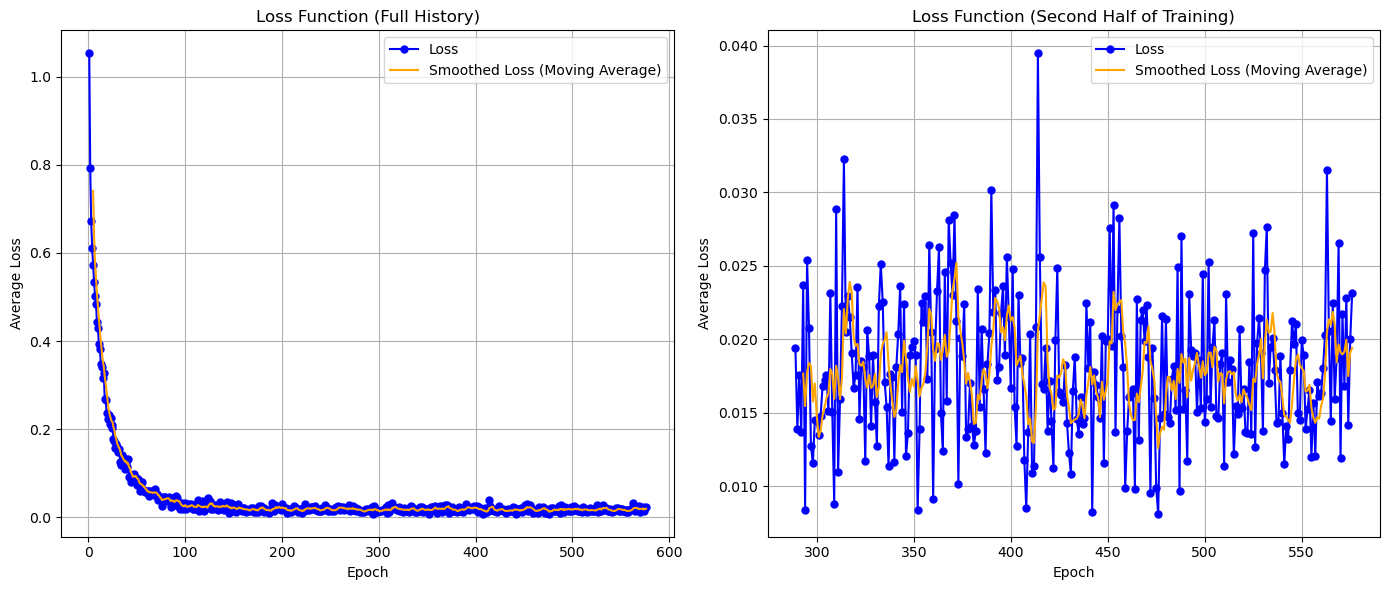

In [51]:
trainer.plot_training_history()

#### Оценка

In [52]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     1.0000    1.0000    1.0000       500
    mushroom     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8716    0.9500    0.9091       100
  chimpanzee     0.9043    0.8500    0.8763       100
    mushroom     0.8763    0.8500    0.8629       100

    accuracy                         0.8833       300
   macro avg     0.8840    0.8833    0.8828       300
weighted avg     0.8840    0.8833    0.8828       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [53]:
trainer.save_model(cifar100)

Model saved as: cifar100_3_model.onnx


### Эксперимент №6

#### Гиперпараметры

In [54]:
batch_size=2**10
epochs=500
lr_rate = 1e-4
dropout_rate=0.1
hidden_layers=[2**8, 2**6, 2**4]

#### Инициализация модели

In [55]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_4
CPU times: user 177 ms, sys: 287 ms, total: 463 ms
Wall time: 331 ms


In [56]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 33.6 ms, sys: 5.94 ms, total: 39.6 ms
Wall time: 4.83 ms


In [57]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_4


#### Информация о модели

In [58]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)

#### Обучение

In [59]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/500: 100%|███████████████████████| 2/2 [00:00<00:00, 75.78batch/s, loss=1.078592, lr=0.000100]


Epoch: 1/500, Loss: 1.088476


Epoch 2/500: 100%|███████████████████████| 2/2 [00:00<00:00, 74.23batch/s, loss=1.036591, lr=0.000100]


Epoch: 2/500, Loss: 1.045604


Epoch 3/500: 100%|███████████████████████| 2/2 [00:00<00:00, 80.61batch/s, loss=0.993961, lr=0.000100]


Epoch: 3/500, Loss: 1.004230


Epoch 4/500: 100%|███████████████████████| 2/2 [00:00<00:00, 78.77batch/s, loss=0.946625, lr=0.000100]


Epoch: 4/500, Loss: 0.960849


Epoch 5/500: 100%|███████████████████████| 2/2 [00:00<00:00, 93.22batch/s, loss=0.900283, lr=0.000100]


Epoch: 5/500, Loss: 0.917336


Epoch 6/500: 100%|███████████████████████| 2/2 [00:00<00:00, 94.02batch/s, loss=0.874634, lr=0.000100]


Epoch: 6/500, Loss: 0.883122


Epoch 7/500: 100%|███████████████████████| 2/2 [00:00<00:00, 94.57batch/s, loss=0.837095, lr=0.000100]


Epoch: 7/500, Loss: 0.847141


Epoch 8/500: 100%|███████████████████████| 2/2 [00:00<00:00, 95.71batch/s, loss=0.805089, lr=0.000100]


Epoch: 8/500, Loss: 0.814307


Epoch 9/500: 100%|███████████████████████| 2/2 [00:00<00:00, 91.05batch/s, loss=0.788024, lr=0.000100]


Epoch: 9/500, Loss: 0.785160


Epoch 10/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.45batch/s, loss=0.741992, lr=0.000100]


Epoch: 10/500, Loss: 0.756823


Epoch 11/500: 100%|██████████████████████| 2/2 [00:00<00:00, 90.08batch/s, loss=0.731101, lr=0.000100]


Epoch: 11/500, Loss: 0.733157


Epoch 12/500: 100%|██████████████████████| 2/2 [00:00<00:00, 94.52batch/s, loss=0.666802, lr=0.000100]


Epoch: 12/500, Loss: 0.703734


Epoch 13/500: 100%|██████████████████████| 2/2 [00:00<00:00, 79.33batch/s, loss=0.683069, lr=0.000100]


Epoch: 13/500, Loss: 0.690432


Epoch 14/500: 100%|██████████████████████| 2/2 [00:00<00:00, 74.20batch/s, loss=0.684960, lr=0.000100]


Epoch: 14/500, Loss: 0.671774


Epoch 15/500: 100%|██████████████████████| 2/2 [00:00<00:00, 77.31batch/s, loss=0.650294, lr=0.000100]


Epoch: 15/500, Loss: 0.656002


Epoch 16/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.50batch/s, loss=0.639486, lr=0.000100]


Epoch: 16/500, Loss: 0.642010


Epoch 17/500: 100%|██████████████████████| 2/2 [00:00<00:00, 74.12batch/s, loss=0.669551, lr=0.000100]


Epoch: 17/500, Loss: 0.651685


Epoch 18/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.61batch/s, loss=0.587439, lr=0.000100]


Epoch: 18/500, Loss: 0.616615


Epoch 19/500: 100%|██████████████████████| 2/2 [00:00<00:00, 90.51batch/s, loss=0.619214, lr=0.000100]


Epoch: 19/500, Loss: 0.609219


Epoch 20/500: 100%|██████████████████████| 2/2 [00:00<00:00, 82.81batch/s, loss=0.588610, lr=0.000100]


Epoch: 20/500, Loss: 0.599810


Epoch 21/500: 100%|██████████████████████| 2/2 [00:00<00:00, 78.05batch/s, loss=0.594009, lr=0.000100]


Epoch: 21/500, Loss: 0.595200


Epoch 22/500: 100%|██████████████████████| 2/2 [00:00<00:00, 80.91batch/s, loss=0.599234, lr=0.000100]


Epoch: 22/500, Loss: 0.581773


Epoch 23/500: 100%|██████████████████████| 2/2 [00:00<00:00, 84.56batch/s, loss=0.582036, lr=0.000100]


Epoch: 23/500, Loss: 0.574085


Epoch 24/500: 100%|██████████████████████| 2/2 [00:00<00:00, 88.30batch/s, loss=0.551259, lr=0.000100]


Epoch: 24/500, Loss: 0.559128


Epoch 25/500: 100%|██████████████████████| 2/2 [00:00<00:00, 81.15batch/s, loss=0.610504, lr=0.000100]


Epoch: 25/500, Loss: 0.575265


Epoch 26/500: 100%|██████████████████████| 2/2 [00:00<00:00, 83.73batch/s, loss=0.526314, lr=0.000100]


Epoch: 26/500, Loss: 0.546511


Epoch 27/500: 100%|██████████████████████| 2/2 [00:00<00:00, 81.23batch/s, loss=0.531619, lr=0.000100]


Epoch: 27/500, Loss: 0.535121


Epoch 28/500: 100%|██████████████████████| 2/2 [00:00<00:00, 85.78batch/s, loss=0.544200, lr=0.000100]


Epoch: 28/500, Loss: 0.531528


Epoch 29/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.60batch/s, loss=0.574679, lr=0.000100]


Epoch: 29/500, Loss: 0.539193


Epoch 30/500: 100%|██████████████████████| 2/2 [00:00<00:00, 98.75batch/s, loss=0.499790, lr=0.000100]


Epoch: 30/500, Loss: 0.514729


Epoch 31/500: 100%|██████████████████████| 2/2 [00:00<00:00, 83.18batch/s, loss=0.495082, lr=0.000100]


Epoch: 31/500, Loss: 0.507002


Epoch 32/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.62batch/s, loss=0.511404, lr=0.000100]


Epoch: 32/500, Loss: 0.507901


Epoch 33/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.10batch/s, loss=0.485975, lr=0.000100]


Epoch: 33/500, Loss: 0.489955


Epoch 34/500: 100%|██████████████████████| 2/2 [00:00<00:00, 91.48batch/s, loss=0.514657, lr=0.000100]


Epoch: 34/500, Loss: 0.495901


Epoch 35/500: 100%|██████████████████████| 2/2 [00:00<00:00, 89.67batch/s, loss=0.487458, lr=0.000100]


Epoch: 35/500, Loss: 0.480035


Epoch 36/500: 100%|██████████████████████| 2/2 [00:00<00:00, 90.95batch/s, loss=0.463187, lr=0.000100]


Epoch: 36/500, Loss: 0.469743


Epoch 37/500: 100%|██████████████████████| 2/2 [00:00<00:00, 76.68batch/s, loss=0.433332, lr=0.000100]


Epoch: 37/500, Loss: 0.448779


Epoch 38/500: 100%|██████████████████████| 2/2 [00:00<00:00, 90.81batch/s, loss=0.457171, lr=0.000100]


Epoch: 38/500, Loss: 0.455875


Epoch 39/500: 100%|██████████████████████| 2/2 [00:00<00:00, 84.98batch/s, loss=0.439992, lr=0.000100]


Epoch: 39/500, Loss: 0.446001


Epoch 40/500: 100%|██████████████████████| 2/2 [00:00<00:00, 89.55batch/s, loss=0.447797, lr=0.000100]


Epoch: 40/500, Loss: 0.440855


Epoch 41/500: 100%|██████████████████████| 2/2 [00:00<00:00, 82.68batch/s, loss=0.468426, lr=0.000100]


Epoch: 41/500, Loss: 0.454541


Epoch 42/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.20batch/s, loss=0.436025, lr=0.000100]


Epoch: 42/500, Loss: 0.430736


Epoch 43/500: 100%|██████████████████████| 2/2 [00:00<00:00, 95.49batch/s, loss=0.459039, lr=0.000100]


Epoch: 43/500, Loss: 0.438483


Epoch 44/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.59batch/s, loss=0.403474, lr=0.000100]


Epoch: 44/500, Loss: 0.416475


Epoch 45/500: 100%|██████████████████████| 2/2 [00:00<00:00, 95.14batch/s, loss=0.407883, lr=0.000100]


Epoch: 45/500, Loss: 0.418155


Epoch 46/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.13batch/s, loss=0.402215, lr=0.000100]


Epoch: 46/500, Loss: 0.402420


Epoch 47/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.05batch/s, loss=0.387693, lr=0.000100]


Epoch: 47/500, Loss: 0.395615


Epoch 48/500: 100%|██████████████████████| 2/2 [00:00<00:00, 95.03batch/s, loss=0.397564, lr=0.000100]


Epoch: 48/500, Loss: 0.400917


Epoch 49/500: 100%|██████████████████████| 2/2 [00:00<00:00, 96.57batch/s, loss=0.360117, lr=0.000100]


Epoch: 49/500, Loss: 0.376563


Epoch 50/500: 100%|██████████████████████| 2/2 [00:00<00:00, 91.84batch/s, loss=0.371210, lr=0.000100]


Epoch: 50/500, Loss: 0.379496


Epoch 51/500: 100%|██████████████████████| 2/2 [00:00<00:00, 98.11batch/s, loss=0.354889, lr=0.000100]


Epoch: 51/500, Loss: 0.369489


Epoch 52/500: 100%|██████████████████████| 2/2 [00:00<00:00, 99.58batch/s, loss=0.377531, lr=0.000100]


Epoch: 52/500, Loss: 0.371057


Epoch 53/500: 100%|██████████████████████| 2/2 [00:00<00:00, 90.17batch/s, loss=0.392058, lr=0.000100]


Epoch: 53/500, Loss: 0.373637


Epoch 54/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.28batch/s, loss=0.345151, lr=0.000100]


Epoch: 54/500, Loss: 0.356701


Epoch 55/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.82batch/s, loss=0.329014, lr=0.000100]


Epoch: 55/500, Loss: 0.340646


Epoch 56/500: 100%|██████████████████████| 2/2 [00:00<00:00, 88.28batch/s, loss=0.304524, lr=0.000100]


Epoch: 56/500, Loss: 0.333834


Epoch 57/500: 100%|██████████████████████| 2/2 [00:00<00:00, 84.43batch/s, loss=0.328129, lr=0.000100]


Epoch: 57/500, Loss: 0.337806


Epoch 58/500: 100%|██████████████████████| 2/2 [00:00<00:00, 80.87batch/s, loss=0.337184, lr=0.000100]


Epoch: 58/500, Loss: 0.336279


Epoch 59/500: 100%|██████████████████████| 2/2 [00:00<00:00, 86.03batch/s, loss=0.325055, lr=0.000100]


Epoch: 59/500, Loss: 0.330521


Epoch 60/500: 100%|██████████████████████| 2/2 [00:00<00:00, 88.76batch/s, loss=0.293553, lr=0.000100]


Epoch: 60/500, Loss: 0.310456


Epoch 61/500: 100%|██████████████████████| 2/2 [00:00<00:00, 83.05batch/s, loss=0.312831, lr=0.000100]

Epoch: 61/500, Loss: 0.316002



Epoch 62/500: 100%|██████████████████████| 2/2 [00:00<00:00, 83.81batch/s, loss=0.317942, lr=0.000100]


Epoch: 62/500, Loss: 0.312135


Epoch 63/500: 100%|██████████████████████| 2/2 [00:00<00:00, 84.63batch/s, loss=0.294301, lr=0.000100]


Epoch: 63/500, Loss: 0.300823


Epoch 64/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.55batch/s, loss=0.278991, lr=0.000100]


Epoch: 64/500, Loss: 0.296286


Epoch 65/500: 100%|██████████████████████| 2/2 [00:00<00:00, 81.99batch/s, loss=0.334819, lr=0.000100]


Epoch: 65/500, Loss: 0.311384


Epoch 66/500: 100%|██████████████████████| 2/2 [00:00<00:00, 91.57batch/s, loss=0.282188, lr=0.000100]


Epoch: 66/500, Loss: 0.288342


Epoch 67/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.19batch/s, loss=0.275773, lr=0.000100]


Epoch: 67/500, Loss: 0.277512


Epoch 68/500: 100%|██████████████████████| 2/2 [00:00<00:00, 95.05batch/s, loss=0.294921, lr=0.000100]


Epoch: 68/500, Loss: 0.286551


Epoch 69/500: 100%|██████████████████████| 2/2 [00:00<00:00, 97.73batch/s, loss=0.291879, lr=0.000100]


Epoch: 69/500, Loss: 0.276273


Epoch 70/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.69batch/s, loss=0.276848, lr=0.000100]


Epoch: 70/500, Loss: 0.266479


Epoch 71/500: 100%|██████████████████████| 2/2 [00:00<00:00, 89.91batch/s, loss=0.270239, lr=0.000100]


Epoch: 71/500, Loss: 0.267044


Epoch 72/500: 100%|██████████████████████| 2/2 [00:00<00:00, 91.18batch/s, loss=0.266707, lr=0.000100]


Epoch: 72/500, Loss: 0.255491


Epoch 73/500: 100%|██████████████████████| 2/2 [00:00<00:00, 88.21batch/s, loss=0.262803, lr=0.000100]


Epoch: 73/500, Loss: 0.257583


Epoch 74/500: 100%|██████████████████████| 2/2 [00:00<00:00, 77.21batch/s, loss=0.261086, lr=0.000100]


Epoch: 74/500, Loss: 0.253446


Epoch 75/500: 100%|██████████████████████| 2/2 [00:00<00:00, 79.31batch/s, loss=0.250445, lr=0.000100]


Epoch: 75/500, Loss: 0.251178


Epoch 76/500: 100%|██████████████████████| 2/2 [00:00<00:00, 86.44batch/s, loss=0.242164, lr=0.000100]

Epoch: 76/500, Loss: 0.243601



Epoch 77/500: 100%|██████████████████████| 2/2 [00:00<00:00, 94.74batch/s, loss=0.232017, lr=0.000100]


Epoch: 77/500, Loss: 0.239808


Epoch 78/500: 100%|██████████████████████| 2/2 [00:00<00:00, 96.56batch/s, loss=0.229376, lr=0.000100]


Epoch: 78/500, Loss: 0.233566


Epoch 79/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.19batch/s, loss=0.206166, lr=0.000100]


Epoch: 79/500, Loss: 0.220816


Epoch 80/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.66batch/s, loss=0.232378, lr=0.000100]


Epoch: 80/500, Loss: 0.232846


Epoch 81/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.97batch/s, loss=0.238579, lr=0.000100]


Epoch: 81/500, Loss: 0.227132


Epoch 82/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.16batch/s, loss=0.215693, lr=0.000100]


Epoch: 82/500, Loss: 0.220007


Epoch 83/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.95batch/s, loss=0.222960, lr=0.000100]


Epoch: 83/500, Loss: 0.216076


Epoch 84/500: 100%|██████████████████████| 2/2 [00:00<00:00, 86.50batch/s, loss=0.212007, lr=0.000100]


Epoch: 84/500, Loss: 0.209778


Epoch 85/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.93batch/s, loss=0.209946, lr=0.000100]


Epoch: 85/500, Loss: 0.204983


Epoch 86/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.05batch/s, loss=0.214390, lr=0.000100]


Epoch: 86/500, Loss: 0.198679


Epoch 87/500: 100%|██████████████████████| 2/2 [00:00<00:00, 89.93batch/s, loss=0.193335, lr=0.000100]


Epoch: 87/500, Loss: 0.195697


Epoch 88/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.04batch/s, loss=0.174270, lr=0.000100]


Epoch: 88/500, Loss: 0.184944


Epoch 89/500: 100%|██████████████████████| 2/2 [00:00<00:00, 94.82batch/s, loss=0.164714, lr=0.000100]


Epoch: 89/500, Loss: 0.178421


Epoch 90/500: 100%|██████████████████████| 2/2 [00:00<00:00, 88.06batch/s, loss=0.189728, lr=0.000100]


Epoch: 90/500, Loss: 0.187446


Epoch 91/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.99batch/s, loss=0.195723, lr=0.000100]


Epoch: 91/500, Loss: 0.184964


Epoch 92/500: 100%|██████████████████████| 2/2 [00:00<00:00, 85.24batch/s, loss=0.178908, lr=0.000100]


Epoch: 92/500, Loss: 0.177323


Epoch 93/500: 100%|██████████████████████| 2/2 [00:00<00:00, 78.15batch/s, loss=0.166718, lr=0.000100]


Epoch: 93/500, Loss: 0.172646


Epoch 94/500: 100%|██████████████████████| 2/2 [00:00<00:00, 89.29batch/s, loss=0.191353, lr=0.000100]


Epoch: 94/500, Loss: 0.181776


Epoch 95/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.15batch/s, loss=0.162862, lr=0.000100]


Epoch: 95/500, Loss: 0.163523


Epoch 96/500: 100%|██████████████████████| 2/2 [00:00<00:00, 92.40batch/s, loss=0.174902, lr=0.000100]


Epoch: 96/500, Loss: 0.171210


Epoch 97/500: 100%|██████████████████████| 2/2 [00:00<00:00, 90.49batch/s, loss=0.179034, lr=0.000100]


Epoch: 97/500, Loss: 0.165615


Epoch 98/500: 100%|██████████████████████| 2/2 [00:00<00:00, 87.65batch/s, loss=0.184997, lr=0.000100]


Epoch: 98/500, Loss: 0.160364


Epoch 99/500: 100%|██████████████████████| 2/2 [00:00<00:00, 93.26batch/s, loss=0.156698, lr=0.000100]


Epoch: 99/500, Loss: 0.155693


Epoch 100/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.53batch/s, loss=0.152175, lr=0.000100]


Epoch: 100/500, Loss: 0.153643


Epoch 101/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.80batch/s, loss=0.157160, lr=0.000100]


Epoch: 101/500, Loss: 0.153097


Epoch 102/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.07batch/s, loss=0.121497, lr=0.000100]


Epoch: 102/500, Loss: 0.140742


Epoch 103/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.90batch/s, loss=0.157466, lr=0.000100]


Epoch: 103/500, Loss: 0.149081


Epoch 104/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.43batch/s, loss=0.145493, lr=0.000100]


Epoch: 104/500, Loss: 0.140391


Epoch 105/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.24batch/s, loss=0.123249, lr=0.000100]


Epoch: 105/500, Loss: 0.133550


Epoch 106/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.20batch/s, loss=0.129009, lr=0.000100]


Epoch: 106/500, Loss: 0.135025


Epoch 107/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.31batch/s, loss=0.127811, lr=0.000100]


Epoch: 107/500, Loss: 0.127619


Epoch 108/500: 100%|█████████████████████| 2/2 [00:00<00:00, 81.54batch/s, loss=0.134978, lr=0.000100]


Epoch: 108/500, Loss: 0.132101


Epoch 109/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.08batch/s, loss=0.115522, lr=0.000100]


Epoch: 109/500, Loss: 0.122908


Epoch 110/500: 100%|█████████████████████| 2/2 [00:00<00:00, 78.35batch/s, loss=0.117884, lr=0.000100]


Epoch: 110/500, Loss: 0.133832


Epoch 111/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.03batch/s, loss=0.123346, lr=0.000100]


Epoch: 111/500, Loss: 0.122431


Epoch 112/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.39batch/s, loss=0.127688, lr=0.000100]


Epoch: 112/500, Loss: 0.121597


Epoch 113/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.07batch/s, loss=0.118380, lr=0.000100]


Epoch: 113/500, Loss: 0.115571


Epoch 114/500: 100%|█████████████████████| 2/2 [00:00<00:00, 81.98batch/s, loss=0.109801, lr=0.000100]


Epoch: 114/500, Loss: 0.111019


Epoch 115/500: 100%|█████████████████████| 2/2 [00:00<00:00, 83.15batch/s, loss=0.118683, lr=0.000100]


Epoch: 115/500, Loss: 0.116476


Epoch 116/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.56batch/s, loss=0.110554, lr=0.000100]


Epoch: 116/500, Loss: 0.112732


Epoch 117/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.58batch/s, loss=0.094500, lr=0.000100]


Epoch: 117/500, Loss: 0.107093


Epoch 118/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.37batch/s, loss=0.096988, lr=0.000100]


Epoch: 118/500, Loss: 0.096684


Epoch 119/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.04batch/s, loss=0.097143, lr=0.000100]


Epoch: 119/500, Loss: 0.101017


Epoch 120/500: 100%|█████████████████████| 2/2 [00:00<00:00,  9.62batch/s, loss=0.099460, lr=0.000100]


Epoch: 120/500, Loss: 0.103306


Epoch 121/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.22batch/s, loss=0.085825, lr=0.000100]


Epoch: 121/500, Loss: 0.095876


Epoch 122/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.72batch/s, loss=0.106710, lr=0.000100]


Epoch: 122/500, Loss: 0.103809


Epoch 123/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.96batch/s, loss=0.093600, lr=0.000100]


Epoch: 123/500, Loss: 0.092288


Epoch 124/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.73batch/s, loss=0.099587, lr=0.000100]


Epoch: 124/500, Loss: 0.097393


Epoch 125/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.54batch/s, loss=0.084483, lr=0.000100]


Epoch: 125/500, Loss: 0.089563


Epoch 126/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.46batch/s, loss=0.092703, lr=0.000100]


Epoch: 126/500, Loss: 0.085667


Epoch 127/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.88batch/s, loss=0.076581, lr=0.000100]


Epoch: 127/500, Loss: 0.083306


Epoch 128/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.14batch/s, loss=0.083460, lr=0.000100]


Epoch: 128/500, Loss: 0.083609


Epoch 129/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.12batch/s, loss=0.097670, lr=0.000100]


Epoch: 129/500, Loss: 0.090810


Epoch 130/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.49batch/s, loss=0.085514, lr=0.000100]


Epoch: 130/500, Loss: 0.078078


Epoch 131/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.19batch/s, loss=0.084181, lr=0.000100]


Epoch: 131/500, Loss: 0.081855


Epoch 132/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.21batch/s, loss=0.072770, lr=0.000100]


Epoch: 132/500, Loss: 0.076006


Epoch 133/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.71batch/s, loss=0.086804, lr=0.000100]


Epoch: 133/500, Loss: 0.079166


Epoch 134/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.47batch/s, loss=0.078688, lr=0.000100]


Epoch: 134/500, Loss: 0.076355


Epoch 135/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.64batch/s, loss=0.058962, lr=0.000100]


Epoch: 135/500, Loss: 0.070121


Epoch 136/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.18batch/s, loss=0.064276, lr=0.000100]


Epoch: 136/500, Loss: 0.068840


Epoch 137/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.18batch/s, loss=0.087063, lr=0.000100]


Epoch: 137/500, Loss: 0.078980


Epoch 138/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.98batch/s, loss=0.068295, lr=0.000100]


Epoch: 138/500, Loss: 0.069572


Epoch 139/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.63batch/s, loss=0.068257, lr=0.000100]


Epoch: 139/500, Loss: 0.067850


Epoch 140/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.03batch/s, loss=0.072748, lr=0.000100]


Epoch: 140/500, Loss: 0.065538


Epoch 141/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.87batch/s, loss=0.060532, lr=0.000100]


Epoch: 141/500, Loss: 0.064862


Epoch 142/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.34batch/s, loss=0.074913, lr=0.000100]


Epoch: 142/500, Loss: 0.068484


Epoch 143/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.54batch/s, loss=0.077597, lr=0.000100]


Epoch: 143/500, Loss: 0.071803


Epoch 144/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.68batch/s, loss=0.056017, lr=0.000100]


Epoch: 144/500, Loss: 0.063187


Epoch 145/500: 100%|█████████████████████| 2/2 [00:00<00:00, 65.03batch/s, loss=0.070451, lr=0.000100]


Epoch: 145/500, Loss: 0.064642


Epoch 146/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.93batch/s, loss=0.061289, lr=0.000100]


Epoch: 146/500, Loss: 0.060118


Epoch 147/500: 100%|█████████████████████| 2/2 [00:00<00:00, 69.25batch/s, loss=0.064067, lr=0.000100]


Epoch: 147/500, Loss: 0.057899


Epoch 148/500: 100%|█████████████████████| 2/2 [00:00<00:00, 70.93batch/s, loss=0.060833, lr=0.000100]


Epoch: 148/500, Loss: 0.059334


Epoch 149/500: 100%|█████████████████████| 2/2 [00:00<00:00, 74.30batch/s, loss=0.050382, lr=0.000100]


Epoch: 149/500, Loss: 0.057147


Epoch 150/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.43batch/s, loss=0.051408, lr=0.000100]


Epoch: 150/500, Loss: 0.056969


Epoch 151/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.72batch/s, loss=0.057110, lr=0.000100]


Epoch: 151/500, Loss: 0.054371


Epoch 152/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.88batch/s, loss=0.058236, lr=0.000100]


Epoch: 152/500, Loss: 0.055095


Epoch 153/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.43batch/s, loss=0.051949, lr=0.000100]


Epoch: 153/500, Loss: 0.055604


Epoch 154/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.11batch/s, loss=0.057481, lr=0.000100]


Epoch: 154/500, Loss: 0.054758


Epoch 155/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.06batch/s, loss=0.051898, lr=0.000090]


Epoch: 155/500, Loss: 0.052883


Epoch 156/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.52batch/s, loss=0.050744, lr=0.000090]


Epoch: 156/500, Loss: 0.049164


Epoch 157/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.93batch/s, loss=0.048979, lr=0.000090]


Epoch: 157/500, Loss: 0.049392


Epoch 158/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.00batch/s, loss=0.046325, lr=0.000090]


Epoch: 158/500, Loss: 0.049393


Epoch 159/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.41batch/s, loss=0.048847, lr=0.000090]


Epoch: 159/500, Loss: 0.045747


Epoch 160/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.95batch/s, loss=0.039186, lr=0.000090]


Epoch: 160/500, Loss: 0.045608


Epoch 161/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.65batch/s, loss=0.047435, lr=0.000090]


Epoch: 161/500, Loss: 0.044304


Epoch 162/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.79batch/s, loss=0.049016, lr=0.000090]


Epoch: 162/500, Loss: 0.045677


Epoch 163/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.91batch/s, loss=0.051837, lr=0.000090]


Epoch: 163/500, Loss: 0.046293


Epoch 164/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.95batch/s, loss=0.043308, lr=0.000090]


Epoch: 164/500, Loss: 0.042286


Epoch 165/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.65batch/s, loss=0.043958, lr=0.000090]


Epoch: 165/500, Loss: 0.041491


Epoch 166/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.05batch/s, loss=0.041466, lr=0.000090]


Epoch: 166/500, Loss: 0.041269


Epoch 167/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.06batch/s, loss=0.050290, lr=0.000090]


Epoch: 167/500, Loss: 0.045807


Epoch 168/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.72batch/s, loss=0.032772, lr=0.000090]


Epoch: 168/500, Loss: 0.035610


Epoch 169/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.17batch/s, loss=0.041313, lr=0.000090]


Epoch: 169/500, Loss: 0.041933


Epoch 170/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.04batch/s, loss=0.046292, lr=0.000090]


Epoch: 170/500, Loss: 0.043004


Epoch 171/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.99batch/s, loss=0.032754, lr=0.000090]


Epoch: 171/500, Loss: 0.039142


Epoch 172/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.41batch/s, loss=0.049876, lr=0.000081]


Epoch: 172/500, Loss: 0.044192


Epoch 173/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.82batch/s, loss=0.026503, lr=0.000081]


Epoch: 173/500, Loss: 0.033750


Epoch 174/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.16batch/s, loss=0.031514, lr=0.000081]


Epoch: 174/500, Loss: 0.033878


Epoch 175/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.05batch/s, loss=0.033801, lr=0.000081]


Epoch: 175/500, Loss: 0.033847


Epoch 176/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.76batch/s, loss=0.042605, lr=0.000081]


Epoch: 176/500, Loss: 0.040817


Epoch 177/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.70batch/s, loss=0.029452, lr=0.000073]


Epoch: 177/500, Loss: 0.035916


Epoch 178/500: 100%|█████████████████████| 2/2 [00:00<00:00, 80.70batch/s, loss=0.028609, lr=0.000073]


Epoch: 178/500, Loss: 0.029750


Epoch 179/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.82batch/s, loss=0.038279, lr=0.000073]


Epoch: 179/500, Loss: 0.033572


Epoch 180/500: 100%|█████████████████████| 2/2 [00:00<00:00, 83.17batch/s, loss=0.040682, lr=0.000073]


Epoch: 180/500, Loss: 0.037062


Epoch 181/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.63batch/s, loss=0.041451, lr=0.000073]


Epoch: 181/500, Loss: 0.037203


Epoch 182/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.25batch/s, loss=0.039585, lr=0.000066]


Epoch: 182/500, Loss: 0.032728


Epoch 183/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.03batch/s, loss=0.033837, lr=0.000066]


Epoch: 183/500, Loss: 0.034047


Epoch 184/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.12batch/s, loss=0.033516, lr=0.000066]


Epoch: 184/500, Loss: 0.036324


Epoch 185/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.89batch/s, loss=0.029061, lr=0.000059]


Epoch: 185/500, Loss: 0.029115


Epoch 186/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.86batch/s, loss=0.032577, lr=0.000059]


Epoch: 186/500, Loss: 0.033051


Epoch 187/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.21batch/s, loss=0.028305, lr=0.000059]


Epoch: 187/500, Loss: 0.031601


Epoch 188/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.96batch/s, loss=0.030881, lr=0.000059]


Epoch: 188/500, Loss: 0.031642


Epoch 189/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.00batch/s, loss=0.024448, lr=0.000053]


Epoch: 189/500, Loss: 0.029444


Epoch 190/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.37batch/s, loss=0.038307, lr=0.000053]


Epoch: 190/500, Loss: 0.036791


Epoch 191/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.42batch/s, loss=0.034968, lr=0.000053]


Epoch: 191/500, Loss: 0.033003


Epoch 192/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.18batch/s, loss=0.031267, lr=0.000048]


Epoch: 192/500, Loss: 0.031781


Epoch 193/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.06batch/s, loss=0.028557, lr=0.000048]


Epoch: 193/500, Loss: 0.027641


Epoch 194/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.13batch/s, loss=0.036591, lr=0.000048]


Epoch: 194/500, Loss: 0.032405


Epoch 195/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.64batch/s, loss=0.031496, lr=0.000048]


Epoch: 195/500, Loss: 0.028793


Epoch 196/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.50batch/s, loss=0.033635, lr=0.000048]


Epoch: 196/500, Loss: 0.030600


Epoch 197/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.12batch/s, loss=0.026815, lr=0.000043]


Epoch: 197/500, Loss: 0.027073


Epoch 198/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.45batch/s, loss=0.031268, lr=0.000043]


Epoch: 198/500, Loss: 0.030469


Epoch 199/500: 100%|█████████████████████| 2/2 [00:00<00:00, 83.73batch/s, loss=0.028097, lr=0.000043]


Epoch: 199/500, Loss: 0.027468


Epoch 200/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.71batch/s, loss=0.029155, lr=0.000043]


Epoch: 200/500, Loss: 0.028320


Epoch 201/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.36batch/s, loss=0.027046, lr=0.000039]


Epoch: 201/500, Loss: 0.026941


Epoch 202/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.61batch/s, loss=0.025668, lr=0.000039]


Epoch: 202/500, Loss: 0.024811


Epoch 203/500: 100%|█████████████████████| 2/2 [00:00<00:00, 81.31batch/s, loss=0.025141, lr=0.000039]


Epoch: 203/500, Loss: 0.025585


Epoch 204/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.66batch/s, loss=0.027299, lr=0.000039]


Epoch: 204/500, Loss: 0.025450


Epoch 205/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.53batch/s, loss=0.024470, lr=0.000039]


Epoch: 205/500, Loss: 0.027149


Epoch 206/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.32batch/s, loss=0.033894, lr=0.000035]


Epoch: 206/500, Loss: 0.030617


Epoch 207/500: 100%|█████████████████████| 2/2 [00:00<00:00, 77.54batch/s, loss=0.037686, lr=0.000035]


Epoch: 207/500, Loss: 0.031781


Epoch 208/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.29batch/s, loss=0.025680, lr=0.000035]


Epoch: 208/500, Loss: 0.028013


Epoch 209/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.92batch/s, loss=0.020792, lr=0.000031]


Epoch: 209/500, Loss: 0.022844


Epoch 210/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.16batch/s, loss=0.023232, lr=0.000031]


Epoch: 210/500, Loss: 0.024140


Epoch 211/500: 100%|█████████████████████| 2/2 [00:00<00:00, 82.93batch/s, loss=0.023378, lr=0.000031]


Epoch: 211/500, Loss: 0.024091


Epoch 212/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.17batch/s, loss=0.021351, lr=0.000031]


Epoch: 212/500, Loss: 0.022446


Epoch 213/500: 100%|█████████████████████| 2/2 [00:00<00:00, 79.51batch/s, loss=0.025860, lr=0.000031]


Epoch: 213/500, Loss: 0.026593


Epoch 214/500: 100%|█████████████████████| 2/2 [00:00<00:00, 80.74batch/s, loss=0.026819, lr=0.000031]


Epoch: 214/500, Loss: 0.027536


Epoch 215/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.10batch/s, loss=0.026119, lr=0.000031]


Epoch: 215/500, Loss: 0.027251


Epoch 216/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.43batch/s, loss=0.024059, lr=0.000028]


Epoch: 216/500, Loss: 0.026301


Epoch 217/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.61batch/s, loss=0.026898, lr=0.000028]


Epoch: 217/500, Loss: 0.026216


Epoch 218/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.03batch/s, loss=0.030053, lr=0.000028]


Epoch: 218/500, Loss: 0.027173


Epoch 219/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.22batch/s, loss=0.024012, lr=0.000025]


Epoch: 219/500, Loss: 0.023833


Epoch 220/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.00batch/s, loss=0.022368, lr=0.000025]


Epoch: 220/500, Loss: 0.024536


Epoch 221/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.46batch/s, loss=0.025064, lr=0.000025]


Epoch: 221/500, Loss: 0.027946


Epoch 222/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.58batch/s, loss=0.023115, lr=0.000023]


Epoch: 222/500, Loss: 0.025660


Epoch 223/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.58batch/s, loss=0.025923, lr=0.000023]


Epoch: 223/500, Loss: 0.024521


Epoch 224/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.88batch/s, loss=0.027821, lr=0.000023]


Epoch: 224/500, Loss: 0.025968


Epoch 225/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.53batch/s, loss=0.028704, lr=0.000021]


Epoch: 225/500, Loss: 0.024496


Epoch 226/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.70batch/s, loss=0.022281, lr=0.000021]


Epoch: 226/500, Loss: 0.023735


Epoch 227/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.11batch/s, loss=0.025726, lr=0.000021]


Epoch: 227/500, Loss: 0.023962


Epoch 228/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.37batch/s, loss=0.026823, lr=0.000019]


Epoch: 228/500, Loss: 0.024225


Epoch 229/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.66batch/s, loss=0.030798, lr=0.000019]


Epoch: 229/500, Loss: 0.025771


Epoch 230/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.30batch/s, loss=0.022622, lr=0.000019]


Epoch: 230/500, Loss: 0.022722


Epoch 231/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.02batch/s, loss=0.027769, lr=0.000017]


Epoch: 231/500, Loss: 0.026059


Epoch 232/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.97batch/s, loss=0.022680, lr=0.000017]


Epoch: 232/500, Loss: 0.022345


Epoch 233/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.80batch/s, loss=0.023432, lr=0.000017]


Epoch: 233/500, Loss: 0.024508


Epoch 234/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.51batch/s, loss=0.022138, lr=0.000017]


Epoch: 234/500, Loss: 0.023055


Epoch 235/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.76batch/s, loss=0.023627, lr=0.000017]


Epoch: 235/500, Loss: 0.024737


Epoch 236/500: 100%|████████████████████| 2/2 [00:00<00:00, 100.07batch/s, loss=0.020477, lr=0.000015]


Epoch: 236/500, Loss: 0.023197


Epoch 237/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.00batch/s, loss=0.023229, lr=0.000015]


Epoch: 237/500, Loss: 0.024019


Epoch 238/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.79batch/s, loss=0.025179, lr=0.000015]


Epoch: 238/500, Loss: 0.025665


Epoch 239/500: 100%|████████████████████| 2/2 [00:00<00:00, 101.23batch/s, loss=0.032669, lr=0.000014]


Epoch: 239/500, Loss: 0.028746


Epoch 240/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.54batch/s, loss=0.027921, lr=0.000014]


Epoch: 240/500, Loss: 0.024982


Epoch 241/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.75batch/s, loss=0.030416, lr=0.000014]


Epoch: 241/500, Loss: 0.028716


Epoch 242/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.19batch/s, loss=0.018845, lr=0.000012]


Epoch: 242/500, Loss: 0.023083


Epoch 243/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.36batch/s, loss=0.022736, lr=0.000012]


Epoch: 243/500, Loss: 0.023929


Epoch 244/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.71batch/s, loss=0.022144, lr=0.000012]


Epoch: 244/500, Loss: 0.022828


Epoch 245/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.46batch/s, loss=0.025823, lr=0.000011]


Epoch: 245/500, Loss: 0.023077


Epoch 246/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.14batch/s, loss=0.020501, lr=0.000011]


Epoch: 246/500, Loss: 0.022306


Epoch 247/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.67batch/s, loss=0.024463, lr=0.000011]


Epoch: 247/500, Loss: 0.024949


Epoch 248/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.93batch/s, loss=0.027894, lr=0.000011]


Epoch: 248/500, Loss: 0.025871


Epoch 249/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.41batch/s, loss=0.028405, lr=0.000011]


Epoch: 249/500, Loss: 0.023991


Epoch 250/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.61batch/s, loss=0.015892, lr=0.000010]


Epoch: 250/500, Loss: 0.018570


Epoch 251/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.32batch/s, loss=0.022419, lr=0.000010]


Epoch: 251/500, Loss: 0.022836


Epoch 252/500: 100%|█████████████████████| 2/2 [00:00<00:00, 10.62batch/s, loss=0.014927, lr=0.000010]


Epoch: 252/500, Loss: 0.019438


Epoch 253/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.39batch/s, loss=0.023205, lr=0.000010]


Epoch: 253/500, Loss: 0.022487


Epoch 254/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.12batch/s, loss=0.025683, lr=0.000009]


Epoch: 254/500, Loss: 0.023868


Epoch 255/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.80batch/s, loss=0.019931, lr=0.000009]


Epoch: 255/500, Loss: 0.018263


Epoch 256/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.15batch/s, loss=0.021124, lr=0.000009]


Epoch: 256/500, Loss: 0.021753


Epoch 257/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.22batch/s, loss=0.022576, lr=0.000009]


Epoch: 257/500, Loss: 0.023054


Epoch 258/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.75batch/s, loss=0.025706, lr=0.000009]


Epoch: 258/500, Loss: 0.026533


Epoch 259/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.27batch/s, loss=0.018754, lr=0.000008]


Epoch: 259/500, Loss: 0.020856


Epoch 260/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.52batch/s, loss=0.023974, lr=0.000008]


Epoch: 260/500, Loss: 0.022438


Epoch 261/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.65batch/s, loss=0.023984, lr=0.000008]


Epoch: 261/500, Loss: 0.027015


Epoch 262/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.42batch/s, loss=0.022865, lr=0.000007]


Epoch: 262/500, Loss: 0.022919


Epoch 263/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.55batch/s, loss=0.020351, lr=0.000007]


Epoch: 263/500, Loss: 0.020490


Epoch 264/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.31batch/s, loss=0.019353, lr=0.000007]


Epoch: 264/500, Loss: 0.023698


Epoch 265/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.05batch/s, loss=0.017165, lr=0.000006]


Epoch: 265/500, Loss: 0.020942


Epoch 266/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.87batch/s, loss=0.015875, lr=0.000006]


Epoch: 266/500, Loss: 0.020042


Epoch 267/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.95batch/s, loss=0.024555, lr=0.000006]


Epoch: 267/500, Loss: 0.023263


Epoch 268/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.44batch/s, loss=0.022223, lr=0.000006]


Epoch: 268/500, Loss: 0.022275


Epoch 269/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.23batch/s, loss=0.026657, lr=0.000006]


Epoch: 269/500, Loss: 0.023732


Epoch 270/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.99batch/s, loss=0.024812, lr=0.000006]


Epoch: 270/500, Loss: 0.022110


Epoch 271/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.98batch/s, loss=0.023346, lr=0.000005]


Epoch: 271/500, Loss: 0.023312


Epoch 272/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.50batch/s, loss=0.023457, lr=0.000005]


Epoch: 272/500, Loss: 0.021987


Epoch 273/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.99batch/s, loss=0.020600, lr=0.000005]


Epoch: 273/500, Loss: 0.020678


Epoch 274/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.78batch/s, loss=0.023637, lr=0.000005]


Epoch: 274/500, Loss: 0.023599


Epoch 275/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.71batch/s, loss=0.021860, lr=0.000005]


Epoch: 275/500, Loss: 0.022389


Epoch 276/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.31batch/s, loss=0.024136, lr=0.000005]


Epoch: 276/500, Loss: 0.023294


Epoch 277/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.52batch/s, loss=0.013805, lr=0.000004]


Epoch: 277/500, Loss: 0.020078


Epoch 278/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.97batch/s, loss=0.020331, lr=0.000004]


Epoch: 278/500, Loss: 0.021231


Epoch 279/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.19batch/s, loss=0.024392, lr=0.000004]


Epoch: 279/500, Loss: 0.023082


Epoch 280/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.23batch/s, loss=0.021418, lr=0.000004]


Epoch: 280/500, Loss: 0.023682


Epoch 281/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.41batch/s, loss=0.020033, lr=0.000004]


Epoch: 281/500, Loss: 0.023219


Epoch 282/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.33batch/s, loss=0.024175, lr=0.000004]


Epoch: 282/500, Loss: 0.023826


Epoch 283/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.77batch/s, loss=0.023583, lr=0.000003]


Epoch: 283/500, Loss: 0.024380


Epoch 284/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.79batch/s, loss=0.021928, lr=0.000003]


Epoch: 284/500, Loss: 0.019375


Epoch 285/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.40batch/s, loss=0.021133, lr=0.000003]


Epoch: 285/500, Loss: 0.022635


Epoch 286/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.35batch/s, loss=0.017556, lr=0.000003]


Epoch: 286/500, Loss: 0.020468


Epoch 287/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.30batch/s, loss=0.029893, lr=0.000003]


Epoch: 287/500, Loss: 0.026345


Epoch 288/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.43batch/s, loss=0.019256, lr=0.000003]


Epoch: 288/500, Loss: 0.021703


Epoch 289/500: 100%|█████████████████████| 2/2 [00:00<00:00, 78.93batch/s, loss=0.025999, lr=0.000003]


Epoch: 289/500, Loss: 0.022681


Epoch 290/500: 100%|█████████████████████| 2/2 [00:00<00:00, 80.72batch/s, loss=0.025226, lr=0.000003]


Epoch: 290/500, Loss: 0.023905


Epoch 291/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.17batch/s, loss=0.022031, lr=0.000003]


Epoch: 291/500, Loss: 0.021240


Epoch 292/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.31batch/s, loss=0.017768, lr=0.000003]


Epoch: 292/500, Loss: 0.020003


Epoch 293/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.95batch/s, loss=0.017908, lr=0.000003]


Epoch: 293/500, Loss: 0.020486


Epoch 294/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.73batch/s, loss=0.022162, lr=0.000003]


Epoch: 294/500, Loss: 0.023233


Epoch 295/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.11batch/s, loss=0.023913, lr=0.000002]


Epoch: 295/500, Loss: 0.021930


Epoch 296/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.43batch/s, loss=0.025032, lr=0.000002]


Epoch: 296/500, Loss: 0.024916


Epoch 297/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.35batch/s, loss=0.024786, lr=0.000002]


Epoch: 297/500, Loss: 0.024910


Epoch 298/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.94batch/s, loss=0.021804, lr=0.000002]


Epoch: 298/500, Loss: 0.021539


Epoch 299/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.35batch/s, loss=0.024154, lr=0.000002]


Epoch: 299/500, Loss: 0.022828


Epoch 300/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.22batch/s, loss=0.029415, lr=0.000002]


Epoch: 300/500, Loss: 0.025129


Epoch 301/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.31batch/s, loss=0.026287, lr=0.000002]


Epoch: 301/500, Loss: 0.021417


Epoch 302/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.31batch/s, loss=0.021708, lr=0.000002]


Epoch: 302/500, Loss: 0.022582


Epoch 303/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.20batch/s, loss=0.024998, lr=0.000002]


Epoch: 303/500, Loss: 0.023769


Epoch 304/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.80batch/s, loss=0.023633, lr=0.000002]


Epoch: 304/500, Loss: 0.021525


Epoch 305/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.51batch/s, loss=0.022113, lr=0.000002]


Epoch: 305/500, Loss: 0.022600


Epoch 306/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.70batch/s, loss=0.031988, lr=0.000002]


Epoch: 306/500, Loss: 0.025376


Epoch 307/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.59batch/s, loss=0.022464, lr=0.000001]


Epoch: 307/500, Loss: 0.021053


Epoch 308/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.93batch/s, loss=0.022664, lr=0.000001]


Epoch: 308/500, Loss: 0.021775


Epoch 309/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.20batch/s, loss=0.016048, lr=0.000001]


Epoch: 309/500, Loss: 0.019473


Epoch 310/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.34batch/s, loss=0.026490, lr=0.000001]


Epoch: 310/500, Loss: 0.022424


Epoch 311/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.70batch/s, loss=0.021504, lr=0.000001]


Epoch: 311/500, Loss: 0.023029


Epoch 312/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.78batch/s, loss=0.025174, lr=0.000001]


Epoch: 312/500, Loss: 0.022427


Epoch 313/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.58batch/s, loss=0.021741, lr=0.000001]


Epoch: 313/500, Loss: 0.020937


Epoch 314/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.87batch/s, loss=0.021014, lr=0.000001]


Epoch: 314/500, Loss: 0.021346


Epoch 315/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.58batch/s, loss=0.025424, lr=0.000001]


Epoch: 315/500, Loss: 0.024636


Epoch 316/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.56batch/s, loss=0.020182, lr=0.000001]


Epoch: 316/500, Loss: 0.023170


Epoch 317/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.01batch/s, loss=0.021023, lr=0.000001]


Epoch: 317/500, Loss: 0.021708


Epoch 318/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.53batch/s, loss=0.026177, lr=0.000001]


Epoch: 318/500, Loss: 0.024712


Epoch 319/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.31batch/s, loss=0.023670, lr=0.000001]


Epoch: 319/500, Loss: 0.022180


Epoch 320/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.66batch/s, loss=0.023252, lr=0.000001]


Epoch: 320/500, Loss: 0.024867


Epoch 321/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.81batch/s, loss=0.026096, lr=0.000001]


Epoch: 321/500, Loss: 0.022891


Epoch 322/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.76batch/s, loss=0.020628, lr=0.000001]


Epoch: 322/500, Loss: 0.021074


Epoch 323/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.28batch/s, loss=0.022952, lr=0.000001]


Epoch: 323/500, Loss: 0.020874


Epoch 324/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.14batch/s, loss=0.020308, lr=0.000001]


Epoch: 324/500, Loss: 0.022568


Epoch 325/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.54batch/s, loss=0.032196, lr=0.000001]


Epoch: 325/500, Loss: 0.026760


Epoch 326/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.02batch/s, loss=0.024783, lr=0.000001]


Epoch: 326/500, Loss: 0.022166


Epoch 327/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.72batch/s, loss=0.026145, lr=0.000001]


Epoch: 327/500, Loss: 0.020808


Epoch 328/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.58batch/s, loss=0.022627, lr=0.000001]


Epoch: 328/500, Loss: 0.024491


Epoch 329/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.91batch/s, loss=0.021069, lr=0.000001]


Epoch: 329/500, Loss: 0.020501


Epoch 330/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.77batch/s, loss=0.025267, lr=0.000001]


Epoch: 330/500, Loss: 0.022015


Epoch 331/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.73batch/s, loss=0.017798, lr=0.000001]


Epoch: 331/500, Loss: 0.018434


Epoch 332/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.67batch/s, loss=0.019913, lr=0.000001]


Epoch: 332/500, Loss: 0.020857


Epoch 333/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.73batch/s, loss=0.019874, lr=0.000001]


Epoch: 333/500, Loss: 0.022174


Epoch 334/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.56batch/s, loss=0.018536, lr=0.000001]


Epoch: 334/500, Loss: 0.021049


Epoch 335/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.64batch/s, loss=0.023288, lr=0.000001]


Epoch: 335/500, Loss: 0.022026


Epoch 336/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.51batch/s, loss=0.018707, lr=0.000001]


Epoch: 336/500, Loss: 0.018402


Epoch 337/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.09batch/s, loss=0.024914, lr=0.000001]


Epoch: 337/500, Loss: 0.022186


Epoch 338/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.83batch/s, loss=0.031019, lr=0.000001]


Epoch: 338/500, Loss: 0.027051


Epoch 339/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.30batch/s, loss=0.024984, lr=0.000001]


Epoch: 339/500, Loss: 0.022179


Epoch 340/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.07batch/s, loss=0.021156, lr=0.000000]


Epoch: 340/500, Loss: 0.021080


Epoch 341/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.05batch/s, loss=0.020141, lr=0.000000]


Epoch: 341/500, Loss: 0.022255


Epoch 342/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.92batch/s, loss=0.025507, lr=0.000000]


Epoch: 342/500, Loss: 0.023765


Epoch 343/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.21batch/s, loss=0.016283, lr=0.000000]


Epoch: 343/500, Loss: 0.017724


Epoch 344/500: 100%|████████████████████| 2/2 [00:00<00:00, 102.91batch/s, loss=0.022118, lr=0.000000]


Epoch: 344/500, Loss: 0.022621


Epoch 345/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.58batch/s, loss=0.022221, lr=0.000000]


Epoch: 345/500, Loss: 0.020819


Epoch 346/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.62batch/s, loss=0.019896, lr=0.000000]


Epoch: 346/500, Loss: 0.022270


Epoch 347/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.10batch/s, loss=0.024054, lr=0.000000]


Epoch: 347/500, Loss: 0.022308


Epoch 348/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.04batch/s, loss=0.021221, lr=0.000000]


Epoch: 348/500, Loss: 0.022881


Epoch 349/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.86batch/s, loss=0.016303, lr=0.000000]


Epoch: 349/500, Loss: 0.020936


Epoch 350/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.56batch/s, loss=0.019565, lr=0.000000]


Epoch: 350/500, Loss: 0.018799


Epoch 351/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.24batch/s, loss=0.025438, lr=0.000000]


Epoch: 351/500, Loss: 0.022734


Epoch 352/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.21batch/s, loss=0.016550, lr=0.000000]


Epoch: 352/500, Loss: 0.019940


Epoch 353/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.99batch/s, loss=0.018243, lr=0.000000]


Epoch: 353/500, Loss: 0.022240


Epoch 354/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.72batch/s, loss=0.021013, lr=0.000000]


Epoch: 354/500, Loss: 0.021011


Epoch 355/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.61batch/s, loss=0.023909, lr=0.000000]


Epoch: 355/500, Loss: 0.023760


Epoch 356/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.10batch/s, loss=0.021254, lr=0.000000]


Epoch: 356/500, Loss: 0.021205


Epoch 357/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.46batch/s, loss=0.020159, lr=0.000000]


Epoch: 357/500, Loss: 0.021927


Epoch 358/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.63batch/s, loss=0.018599, lr=0.000000]


Epoch: 358/500, Loss: 0.020586


Epoch 359/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.72batch/s, loss=0.019569, lr=0.000000]


Epoch: 359/500, Loss: 0.021422


Epoch 360/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.86batch/s, loss=0.022048, lr=0.000000]


Epoch: 360/500, Loss: 0.022584


Epoch 361/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.71batch/s, loss=0.024152, lr=0.000000]


Epoch: 361/500, Loss: 0.023716


Epoch 362/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.30batch/s, loss=0.016709, lr=0.000000]


Epoch: 362/500, Loss: 0.019170


Epoch 363/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.37batch/s, loss=0.029664, lr=0.000000]


Epoch: 363/500, Loss: 0.025001


Epoch 364/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.21batch/s, loss=0.025520, lr=0.000000]


Epoch: 364/500, Loss: 0.023120


Epoch 365/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.71batch/s, loss=0.022199, lr=0.000000]


Epoch: 365/500, Loss: 0.021137


Epoch 366/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.91batch/s, loss=0.024437, lr=0.000000]


Epoch: 366/500, Loss: 0.022576


Epoch 367/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.03batch/s, loss=0.020047, lr=0.000000]


Epoch: 367/500, Loss: 0.023330


Epoch 368/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.18batch/s, loss=0.024690, lr=0.000000]


Epoch: 368/500, Loss: 0.021134


Epoch 369/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.97batch/s, loss=0.023321, lr=0.000000]


Epoch: 369/500, Loss: 0.022525


Epoch 370/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.44batch/s, loss=0.031323, lr=0.000000]


Epoch: 370/500, Loss: 0.027141


Epoch 371/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.91batch/s, loss=0.021984, lr=0.000000]


Epoch: 371/500, Loss: 0.022726


Epoch 372/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.23batch/s, loss=0.020567, lr=0.000000]


Epoch: 372/500, Loss: 0.020748


Epoch 373/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.05batch/s, loss=0.023437, lr=0.000000]


Epoch: 373/500, Loss: 0.024048


Epoch 374/500: 100%|█████████████████████| 2/2 [00:00<00:00, 79.24batch/s, loss=0.024882, lr=0.000000]


Epoch: 374/500, Loss: 0.024363


Epoch 375/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.44batch/s, loss=0.019448, lr=0.000000]


Epoch: 375/500, Loss: 0.022002


Epoch 376/500: 100%|█████████████████████| 2/2 [00:00<00:00, 70.55batch/s, loss=0.016025, lr=0.000000]


Epoch: 376/500, Loss: 0.019642


Epoch 377/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.27batch/s, loss=0.025041, lr=0.000000]


Epoch: 377/500, Loss: 0.022303


Epoch 378/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.24batch/s, loss=0.017171, lr=0.000000]


Epoch: 378/500, Loss: 0.019677


Epoch 379/500: 100%|█████████████████████| 2/2 [00:00<00:00, 82.34batch/s, loss=0.021636, lr=0.000000]


Epoch: 379/500, Loss: 0.021693


Epoch 380/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.47batch/s, loss=0.021028, lr=0.000000]


Epoch: 380/500, Loss: 0.021106


Epoch 381/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.36batch/s, loss=0.018112, lr=0.000000]


Epoch: 381/500, Loss: 0.019848


Epoch 382/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.93batch/s, loss=0.028236, lr=0.000000]


Epoch: 382/500, Loss: 0.023557


Epoch 383/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.89batch/s, loss=0.022917, lr=0.000000]


Epoch: 383/500, Loss: 0.022544


Epoch 384/500: 100%|█████████████████████| 2/2 [00:00<00:00, 10.91batch/s, loss=0.024831, lr=0.000000]


Epoch: 384/500, Loss: 0.022853


Epoch 385/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.40batch/s, loss=0.021481, lr=0.000000]


Epoch: 385/500, Loss: 0.020955


Epoch 386/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.63batch/s, loss=0.022141, lr=0.000000]


Epoch: 386/500, Loss: 0.023716


Epoch 387/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.35batch/s, loss=0.021591, lr=0.000000]


Epoch: 387/500, Loss: 0.022502


Epoch 388/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.89batch/s, loss=0.022765, lr=0.000000]


Epoch: 388/500, Loss: 0.023858


Epoch 389/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.86batch/s, loss=0.022785, lr=0.000000]


Epoch: 389/500, Loss: 0.021848


Epoch 390/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.98batch/s, loss=0.026986, lr=0.000000]


Epoch: 390/500, Loss: 0.023718


Epoch 391/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.76batch/s, loss=0.023216, lr=0.000000]


Epoch: 391/500, Loss: 0.022708


Epoch 392/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.78batch/s, loss=0.024019, lr=0.000000]


Epoch: 392/500, Loss: 0.022090


Epoch 393/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.27batch/s, loss=0.020717, lr=0.000000]


Epoch: 393/500, Loss: 0.020070


Epoch 394/500: 100%|█████████████████████| 2/2 [00:00<00:00, 83.88batch/s, loss=0.025798, lr=0.000000]


Epoch: 394/500, Loss: 0.022570


Epoch 395/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.60batch/s, loss=0.017705, lr=0.000000]


Epoch: 395/500, Loss: 0.020571


Epoch 396/500: 100%|█████████████████████| 2/2 [00:00<00:00, 80.98batch/s, loss=0.018903, lr=0.000000]


Epoch: 396/500, Loss: 0.021171


Epoch 397/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.08batch/s, loss=0.026023, lr=0.000000]


Epoch: 397/500, Loss: 0.022502


Epoch 398/500: 100%|█████████████████████| 2/2 [00:00<00:00, 87.68batch/s, loss=0.017374, lr=0.000000]


Epoch: 398/500, Loss: 0.020731


Epoch 399/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.60batch/s, loss=0.018638, lr=0.000000]


Epoch: 399/500, Loss: 0.020502


Epoch 400/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.34batch/s, loss=0.021434, lr=0.000000]


Epoch: 400/500, Loss: 0.022370


Epoch 401/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.37batch/s, loss=0.020754, lr=0.000000]


Epoch: 401/500, Loss: 0.019974


Epoch 402/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.69batch/s, loss=0.013012, lr=0.000000]


Epoch: 402/500, Loss: 0.018587


Epoch 403/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.60batch/s, loss=0.018022, lr=0.000000]


Epoch: 403/500, Loss: 0.018713


Epoch 404/500: 100%|█████████████████████| 2/2 [00:00<00:00, 80.23batch/s, loss=0.022878, lr=0.000000]


Epoch: 404/500, Loss: 0.022474


Epoch 405/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.72batch/s, loss=0.023772, lr=0.000000]


Epoch: 405/500, Loss: 0.021905


Epoch 406/500: 100%|█████████████████████| 2/2 [00:00<00:00, 84.45batch/s, loss=0.024658, lr=0.000000]


Epoch: 406/500, Loss: 0.022112


Epoch 407/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.63batch/s, loss=0.025109, lr=0.000000]


Epoch: 407/500, Loss: 0.023704


Epoch 408/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.62batch/s, loss=0.025506, lr=0.000000]


Epoch: 408/500, Loss: 0.022587


Epoch 409/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.66batch/s, loss=0.023800, lr=0.000000]


Epoch: 409/500, Loss: 0.025343


Epoch 410/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.43batch/s, loss=0.020341, lr=0.000000]


Epoch: 410/500, Loss: 0.022272


Epoch 411/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.74batch/s, loss=0.029400, lr=0.000000]


Epoch: 411/500, Loss: 0.025604


Epoch 412/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.27batch/s, loss=0.024847, lr=0.000000]


Epoch: 412/500, Loss: 0.023228


Epoch 413/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.91batch/s, loss=0.022087, lr=0.000000]


Epoch: 413/500, Loss: 0.020681


Epoch 414/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.81batch/s, loss=0.015488, lr=0.000000]


Epoch: 414/500, Loss: 0.019612


Epoch 415/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.92batch/s, loss=0.017183, lr=0.000000]


Epoch: 415/500, Loss: 0.020927


Epoch 416/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.02batch/s, loss=0.021623, lr=0.000000]


Epoch: 416/500, Loss: 0.020790


Epoch 417/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.95batch/s, loss=0.023123, lr=0.000000]


Epoch: 417/500, Loss: 0.021877


Epoch 418/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.35batch/s, loss=0.020249, lr=0.000000]


Epoch: 418/500, Loss: 0.020333


Epoch 419/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.50batch/s, loss=0.022542, lr=0.000000]


Epoch: 419/500, Loss: 0.022013


Epoch 420/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.21batch/s, loss=0.020417, lr=0.000000]


Epoch: 420/500, Loss: 0.020732


Epoch 421/500: 100%|█████████████████████| 2/2 [00:00<00:00, 86.72batch/s, loss=0.022333, lr=0.000000]


Epoch: 421/500, Loss: 0.023745


Epoch 422/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.04batch/s, loss=0.023582, lr=0.000000]


Epoch: 422/500, Loss: 0.023384


Epoch 423/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.07batch/s, loss=0.022106, lr=0.000000]


Epoch: 423/500, Loss: 0.020859


Epoch 424/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.33batch/s, loss=0.021826, lr=0.000000]


Epoch: 424/500, Loss: 0.022339


Epoch 425/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.03batch/s, loss=0.018556, lr=0.000000]


Epoch: 425/500, Loss: 0.018878


Epoch 426/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.15batch/s, loss=0.021894, lr=0.000000]


Epoch: 426/500, Loss: 0.025021


Epoch 427/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.93batch/s, loss=0.025650, lr=0.000000]


Epoch: 427/500, Loss: 0.025230


Epoch 428/500: 100%|████████████████████| 2/2 [00:00<00:00, 101.15batch/s, loss=0.014289, lr=0.000000]


Epoch: 428/500, Loss: 0.016692


Epoch 429/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.22batch/s, loss=0.026004, lr=0.000000]


Epoch: 429/500, Loss: 0.026453


Epoch 430/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.69batch/s, loss=0.025310, lr=0.000000]


Epoch: 430/500, Loss: 0.023041


Epoch 431/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.55batch/s, loss=0.017287, lr=0.000000]


Epoch: 431/500, Loss: 0.021035


Epoch 432/500: 100%|████████████████████| 2/2 [00:00<00:00, 101.07batch/s, loss=0.032518, lr=0.000000]


Epoch: 432/500, Loss: 0.028732


Epoch 433/500: 100%|████████████████████| 2/2 [00:00<00:00, 101.77batch/s, loss=0.020651, lr=0.000000]


Epoch: 433/500, Loss: 0.020813


Epoch 434/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.18batch/s, loss=0.019856, lr=0.000000]


Epoch: 434/500, Loss: 0.021158


Epoch 435/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.83batch/s, loss=0.018943, lr=0.000000]


Epoch: 435/500, Loss: 0.019009


Epoch 436/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.34batch/s, loss=0.025879, lr=0.000000]


Epoch: 436/500, Loss: 0.024512


Epoch 437/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.97batch/s, loss=0.021036, lr=0.000000]


Epoch: 437/500, Loss: 0.020506


Epoch 438/500: 100%|████████████████████| 2/2 [00:00<00:00, 102.43batch/s, loss=0.020159, lr=0.000000]


Epoch: 438/500, Loss: 0.020554


Epoch 439/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.52batch/s, loss=0.017796, lr=0.000000]


Epoch: 439/500, Loss: 0.020190


Epoch 440/500: 100%|████████████████████| 2/2 [00:00<00:00, 100.58batch/s, loss=0.021761, lr=0.000000]


Epoch: 440/500, Loss: 0.022375


Epoch 441/500: 100%|████████████████████| 2/2 [00:00<00:00, 100.83batch/s, loss=0.022611, lr=0.000000]


Epoch: 441/500, Loss: 0.020521


Epoch 442/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.81batch/s, loss=0.018516, lr=0.000000]


Epoch: 442/500, Loss: 0.021492


Epoch 443/500: 100%|████████████████████| 2/2 [00:00<00:00, 100.89batch/s, loss=0.020483, lr=0.000000]


Epoch: 443/500, Loss: 0.022699


Epoch 444/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.71batch/s, loss=0.018280, lr=0.000000]


Epoch: 444/500, Loss: 0.020259


Epoch 445/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.78batch/s, loss=0.024456, lr=0.000000]


Epoch: 445/500, Loss: 0.022970


Epoch 446/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.22batch/s, loss=0.025840, lr=0.000000]


Epoch: 446/500, Loss: 0.025129


Epoch 447/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.07batch/s, loss=0.024610, lr=0.000000]


Epoch: 447/500, Loss: 0.024935


Epoch 448/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.39batch/s, loss=0.020319, lr=0.000000]


Epoch: 448/500, Loss: 0.020119


Epoch 449/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.77batch/s, loss=0.026109, lr=0.000000]


Epoch: 449/500, Loss: 0.024507


Epoch 450/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.55batch/s, loss=0.017367, lr=0.000000]


Epoch: 450/500, Loss: 0.020650


Epoch 451/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.90batch/s, loss=0.025780, lr=0.000000]


Epoch: 451/500, Loss: 0.023452


Epoch 452/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.39batch/s, loss=0.024788, lr=0.000000]


Epoch: 452/500, Loss: 0.023281


Epoch 453/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.85batch/s, loss=0.014663, lr=0.000000]


Epoch: 453/500, Loss: 0.019170


Epoch 454/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.12batch/s, loss=0.022948, lr=0.000000]


Epoch: 454/500, Loss: 0.021742


Epoch 455/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.55batch/s, loss=0.029765, lr=0.000000]


Epoch: 455/500, Loss: 0.027568


Epoch 456/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.88batch/s, loss=0.021178, lr=0.000000]


Epoch: 456/500, Loss: 0.020291


Epoch 457/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.27batch/s, loss=0.022361, lr=0.000000]


Epoch: 457/500, Loss: 0.023598


Epoch 458/500: 100%|█████████████████████| 2/2 [00:00<00:00, 82.82batch/s, loss=0.029964, lr=0.000000]


Epoch: 458/500, Loss: 0.024646


Epoch 459/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.45batch/s, loss=0.032228, lr=0.000000]


Epoch: 459/500, Loss: 0.029136


Epoch 460/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.81batch/s, loss=0.024364, lr=0.000000]


Epoch: 460/500, Loss: 0.021861


Epoch 461/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.64batch/s, loss=0.027706, lr=0.000000]


Epoch: 461/500, Loss: 0.025029


Epoch 462/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.39batch/s, loss=0.028486, lr=0.000000]


Epoch: 462/500, Loss: 0.023811


Epoch 463/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.19batch/s, loss=0.016653, lr=0.000000]


Epoch: 463/500, Loss: 0.017517


Epoch 464/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.00batch/s, loss=0.020947, lr=0.000000]


Epoch: 464/500, Loss: 0.021239


Epoch 465/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.64batch/s, loss=0.017066, lr=0.000000]


Epoch: 465/500, Loss: 0.019853


Epoch 466/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.88batch/s, loss=0.015502, lr=0.000000]


Epoch: 466/500, Loss: 0.020411


Epoch 467/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.56batch/s, loss=0.016028, lr=0.000000]


Epoch: 467/500, Loss: 0.020396


Epoch 468/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.66batch/s, loss=0.021040, lr=0.000000]


Epoch: 468/500, Loss: 0.018519


Epoch 469/500: 100%|█████████████████████| 2/2 [00:00<00:00, 99.59batch/s, loss=0.022015, lr=0.000000]


Epoch: 469/500, Loss: 0.020958


Epoch 470/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.26batch/s, loss=0.018928, lr=0.000000]


Epoch: 470/500, Loss: 0.019539


Epoch 471/500: 100%|█████████████████████| 2/2 [00:00<00:00, 89.55batch/s, loss=0.018833, lr=0.000000]


Epoch: 471/500, Loss: 0.022953


Epoch 472/500: 100%|█████████████████████| 2/2 [00:00<00:00, 81.29batch/s, loss=0.017078, lr=0.000000]


Epoch: 472/500, Loss: 0.019198


Epoch 473/500: 100%|█████████████████████| 2/2 [00:00<00:00, 83.33batch/s, loss=0.014253, lr=0.000000]


Epoch: 473/500, Loss: 0.018584


Epoch 474/500: 100%|█████████████████████| 2/2 [00:00<00:00, 88.49batch/s, loss=0.023568, lr=0.000000]


Epoch: 474/500, Loss: 0.021760


Epoch 475/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.82batch/s, loss=0.019081, lr=0.000000]


Epoch: 475/500, Loss: 0.019480


Epoch 476/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.91batch/s, loss=0.028788, lr=0.000000]


Epoch: 476/500, Loss: 0.024676


Epoch 477/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.02batch/s, loss=0.022318, lr=0.000000]


Epoch: 477/500, Loss: 0.021342


Epoch 478/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.60batch/s, loss=0.022048, lr=0.000000]


Epoch: 478/500, Loss: 0.019855


Epoch 479/500: 100%|█████████████████████| 2/2 [00:00<00:00, 96.85batch/s, loss=0.026568, lr=0.000000]


Epoch: 479/500, Loss: 0.024402


Epoch 480/500: 100%|█████████████████████| 2/2 [00:00<00:00, 97.95batch/s, loss=0.026367, lr=0.000000]


Epoch: 480/500, Loss: 0.024743


Epoch 481/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.38batch/s, loss=0.025948, lr=0.000000]


Epoch: 481/500, Loss: 0.022989


Epoch 482/500: 100%|█████████████████████| 2/2 [00:00<00:00, 95.65batch/s, loss=0.022096, lr=0.000000]


Epoch: 482/500, Loss: 0.022513


Epoch 483/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.67batch/s, loss=0.019462, lr=0.000000]


Epoch: 483/500, Loss: 0.020805


Epoch 484/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.39batch/s, loss=0.026295, lr=0.000000]


Epoch: 484/500, Loss: 0.022289


Epoch 485/500: 100%|█████████████████████| 2/2 [00:00<00:00, 94.62batch/s, loss=0.016090, lr=0.000000]


Epoch: 485/500, Loss: 0.019561


Epoch 486/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.84batch/s, loss=0.020070, lr=0.000000]


Epoch: 486/500, Loss: 0.021104


Epoch 487/500: 100%|█████████████████████| 2/2 [00:00<00:00, 91.88batch/s, loss=0.021128, lr=0.000000]


Epoch: 487/500, Loss: 0.020497


Epoch 488/500: 100%|█████████████████████| 2/2 [00:00<00:00, 83.95batch/s, loss=0.020923, lr=0.000000]


Epoch: 488/500, Loss: 0.019229


Epoch 489/500: 100%|█████████████████████| 2/2 [00:00<00:00, 90.74batch/s, loss=0.023242, lr=0.000000]


Epoch: 489/500, Loss: 0.024129


Epoch 490/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.37batch/s, loss=0.018550, lr=0.000000]


Epoch: 490/500, Loss: 0.021075


Epoch 491/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.86batch/s, loss=0.019004, lr=0.000000]


Epoch: 491/500, Loss: 0.022270


Epoch 492/500: 100%|█████████████████████| 2/2 [00:00<00:00, 82.94batch/s, loss=0.024520, lr=0.000000]


Epoch: 492/500, Loss: 0.020951


Epoch 493/500: 100%|█████████████████████| 2/2 [00:00<00:00, 83.65batch/s, loss=0.016370, lr=0.000000]


Epoch: 493/500, Loss: 0.019481


Epoch 494/500: 100%|█████████████████████| 2/2 [00:00<00:00, 92.85batch/s, loss=0.020376, lr=0.000000]


Epoch: 494/500, Loss: 0.020401


Epoch 495/500: 100%|█████████████████████| 2/2 [00:00<00:00, 93.59batch/s, loss=0.014296, lr=0.000000]


Epoch: 495/500, Loss: 0.020487


Epoch 496/500: 100%|█████████████████████| 2/2 [00:00<00:00, 82.74batch/s, loss=0.015937, lr=0.000000]


Epoch: 496/500, Loss: 0.018686


Epoch 497/500: 100%|█████████████████████| 2/2 [00:00<00:00, 81.59batch/s, loss=0.027896, lr=0.000000]


Epoch: 497/500, Loss: 0.024654


Epoch 498/500: 100%|█████████████████████| 2/2 [00:00<00:00, 83.59batch/s, loss=0.023128, lr=0.000000]


Epoch: 498/500, Loss: 0.022558


Epoch 499/500: 100%|█████████████████████| 2/2 [00:00<00:00, 85.84batch/s, loss=0.021909, lr=0.000000]


Epoch: 499/500, Loss: 0.021231


Epoch 500/500: 100%|█████████████████████| 2/2 [00:00<00:00, 98.21batch/s, loss=0.019354, lr=0.000000]

Epoch: 500/500, Loss: 0.020180
CPU times: user 13.4 s, sys: 653 ms, total: 14.1 s
Wall time: 12.7 s


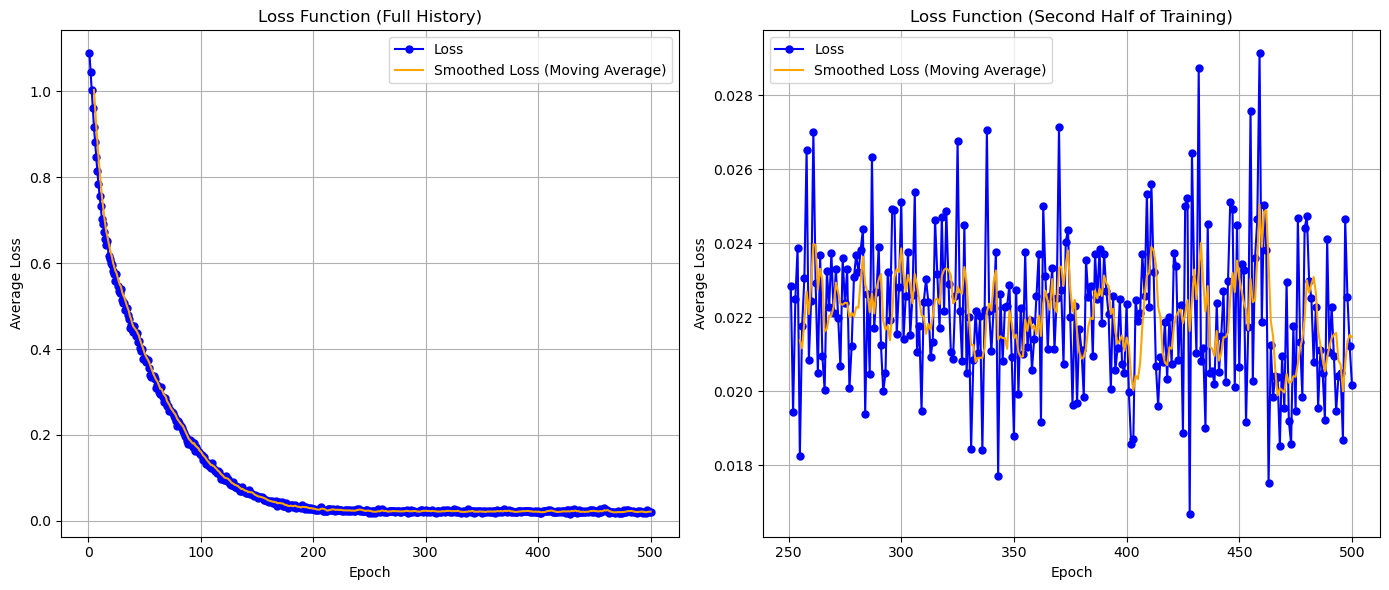

In [60]:
trainer.plot_training_history()

#### Оценка

In [61]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     0.9980    1.0000    0.9990       500
    mushroom     1.0000    0.9980    0.9990       500

    accuracy                         0.9993      1500
   macro avg     0.9993    0.9993    0.9993      1500
weighted avg     0.9993    0.9993    0.9993      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9029    0.9300    0.9163       100
  chimpanzee     0.9213    0.8200    0.8677       100
    mushroom     0.8148    0.8800    0.8462       100

    accuracy                         0.8767       300
   macro avg     0.8797    0.8767    0.8767       300
weighted avg     0.8797    0.8767    0.8767       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [62]:
trainer.save_model(cifar100)

Model saved as: cifar100_4_model.onnx


### Эксперимент №7

#### Гиперпараметры

In [63]:
batch_size=2**10
epochs=500
lr_rate = 1e-4
dropout_rate=0.15
hidden_layers=[2**12, 2**10, 2**8, 2**6, 2**4]

#### Инициализация модели

In [64]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate)

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_5
CPU times: user 185 ms, sys: 278 ms, total: 463 ms
Wall time: 318 ms


In [65]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 836 ms, sys: 122 ms, total: 958 ms
Wall time: 120 ms


In [66]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_5


#### Информация о модели

In [67]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=1024, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=256, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.15, inplace=False)
    (12): Linear(in_features=64, out_features=16, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.15, inplace=False)
    (15): Linear(in_features=16, out_features=3, bias=True)
  )
)

#### Обучение

In [68]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/500: 100%|███████████████████████| 2/2 [00:00<00:00, 19.36batch/s, loss=1.081115, lr=0.000100]


Epoch: 1/500, Loss: 1.090729


Epoch 2/500: 100%|███████████████████████| 2/2 [00:00<00:00, 22.58batch/s, loss=1.046919, lr=0.000100]


Epoch: 2/500, Loss: 1.056530


Epoch 3/500: 100%|███████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.987020, lr=0.000100]


Epoch: 3/500, Loss: 1.005329


Epoch 4/500: 100%|███████████████████████| 2/2 [00:00<00:00, 22.39batch/s, loss=0.929531, lr=0.000100]


Epoch: 4/500, Loss: 0.946234


Epoch 5/500: 100%|███████████████████████| 2/2 [00:00<00:00, 20.39batch/s, loss=0.860960, lr=0.000100]


Epoch: 5/500, Loss: 0.875853


Epoch 6/500: 100%|███████████████████████| 2/2 [00:00<00:00,  8.02batch/s, loss=0.778365, lr=0.000100]


Epoch: 6/500, Loss: 0.803379


Epoch 7/500: 100%|███████████████████████| 2/2 [00:00<00:00, 22.38batch/s, loss=0.744935, lr=0.000100]


Epoch: 7/500, Loss: 0.749612


Epoch 8/500: 100%|███████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.685511, lr=0.000100]


Epoch: 8/500, Loss: 0.703193


Epoch 9/500: 100%|███████████████████████| 2/2 [00:00<00:00, 22.51batch/s, loss=0.651390, lr=0.000100]


Epoch: 9/500, Loss: 0.664820


Epoch 10/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.95batch/s, loss=0.610893, lr=0.000100]


Epoch: 10/500, Loss: 0.626860


Epoch 11/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.19batch/s, loss=0.654818, lr=0.000100]


Epoch: 11/500, Loss: 0.632308


Epoch 12/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.27batch/s, loss=0.612432, lr=0.000100]


Epoch: 12/500, Loss: 0.599086


Epoch 13/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.04batch/s, loss=0.542824, lr=0.000100]


Epoch: 13/500, Loss: 0.568058


Epoch 14/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.33batch/s, loss=0.543181, lr=0.000100]


Epoch: 14/500, Loss: 0.535203


Epoch 15/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.94batch/s, loss=0.517432, lr=0.000100]


Epoch: 15/500, Loss: 0.528656


Epoch 16/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.51batch/s, loss=0.469297, lr=0.000100]


Epoch: 16/500, Loss: 0.486893


Epoch 17/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.74batch/s, loss=0.498970, lr=0.000100]


Epoch: 17/500, Loss: 0.482823


Epoch 18/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.08batch/s, loss=0.451235, lr=0.000100]


Epoch: 18/500, Loss: 0.444488


Epoch 19/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.43batch/s, loss=0.398081, lr=0.000100]


Epoch: 19/500, Loss: 0.417780


Epoch 20/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.96batch/s, loss=0.423304, lr=0.000100]


Epoch: 20/500, Loss: 0.410615


Epoch 21/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.52batch/s, loss=0.371050, lr=0.000100]


Epoch: 21/500, Loss: 0.376596


Epoch 22/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.39batch/s, loss=0.384618, lr=0.000100]


Epoch: 22/500, Loss: 0.371713


Epoch 23/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.07batch/s, loss=0.352094, lr=0.000100]


Epoch: 23/500, Loss: 0.358242


Epoch 24/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.30batch/s, loss=0.346629, lr=0.000100]


Epoch: 24/500, Loss: 0.344334


Epoch 25/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.95batch/s, loss=0.344048, lr=0.000100]


Epoch: 25/500, Loss: 0.325379


Epoch 26/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.36batch/s, loss=0.276513, lr=0.000100]


Epoch: 26/500, Loss: 0.290075


Epoch 27/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.62batch/s, loss=0.286182, lr=0.000100]


Epoch: 27/500, Loss: 0.280519


Epoch 28/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.30batch/s, loss=0.259617, lr=0.000100]


Epoch: 28/500, Loss: 0.270311


Epoch 29/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.99batch/s, loss=0.242113, lr=0.000100]


Epoch: 29/500, Loss: 0.255158


Epoch 30/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.19batch/s, loss=0.232334, lr=0.000100]


Epoch: 30/500, Loss: 0.229730


Epoch 31/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.11batch/s, loss=0.230364, lr=0.000100]


Epoch: 31/500, Loss: 0.228540


Epoch 32/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.73batch/s, loss=0.218131, lr=0.000100]


Epoch: 32/500, Loss: 0.215469


Epoch 33/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.09batch/s, loss=0.195592, lr=0.000100]


Epoch: 33/500, Loss: 0.199738


Epoch 34/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.229280, lr=0.000100]


Epoch: 34/500, Loss: 0.201019


Epoch 35/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.26batch/s, loss=0.189987, lr=0.000100]


Epoch: 35/500, Loss: 0.176153


Epoch 36/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.37batch/s, loss=0.158415, lr=0.000100]


Epoch: 36/500, Loss: 0.171459


Epoch 37/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.61batch/s, loss=0.156922, lr=0.000100]


Epoch: 37/500, Loss: 0.146423


Epoch 38/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.46batch/s, loss=0.127279, lr=0.000100]


Epoch: 38/500, Loss: 0.141711


Epoch 39/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.56batch/s, loss=0.127152, lr=0.000100]


Epoch: 39/500, Loss: 0.126759


Epoch 40/500: 100%|██████████████████████| 2/2 [00:00<00:00, 20.77batch/s, loss=0.108118, lr=0.000100]


Epoch: 40/500, Loss: 0.114730


Epoch 41/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.29batch/s, loss=0.111244, lr=0.000100]


Epoch: 41/500, Loss: 0.107020


Epoch 42/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.85batch/s, loss=0.108182, lr=0.000100]


Epoch: 42/500, Loss: 0.102433


Epoch 43/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.24batch/s, loss=0.111759, lr=0.000100]


Epoch: 43/500, Loss: 0.098583


Epoch 44/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.11batch/s, loss=0.092021, lr=0.000100]


Epoch: 44/500, Loss: 0.083995


Epoch 45/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.71batch/s, loss=0.068032, lr=0.000100]


Epoch: 45/500, Loss: 0.078134


Epoch 46/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.06batch/s, loss=0.075951, lr=0.000100]


Epoch: 46/500, Loss: 0.078306


Epoch 47/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.92batch/s, loss=0.078808, lr=0.000100]


Epoch: 47/500, Loss: 0.072089


Epoch 48/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.21batch/s, loss=0.045081, lr=0.000100]


Epoch: 48/500, Loss: 0.056112


Epoch 49/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.34batch/s, loss=0.049598, lr=0.000100]


Epoch: 49/500, Loss: 0.058690


Epoch 50/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.054092, lr=0.000100]


Epoch: 50/500, Loss: 0.051002


Epoch 51/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.39batch/s, loss=0.061182, lr=0.000100]


Epoch: 51/500, Loss: 0.058039


Epoch 52/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.07batch/s, loss=0.032155, lr=0.000100]


Epoch: 52/500, Loss: 0.042883


Epoch 53/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.35batch/s, loss=0.064762, lr=0.000100]


Epoch: 53/500, Loss: 0.052409


Epoch 54/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.77batch/s, loss=0.034044, lr=0.000100]


Epoch: 54/500, Loss: 0.039001


Epoch 55/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.33batch/s, loss=0.060535, lr=0.000100]


Epoch: 55/500, Loss: 0.048678


Epoch 56/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.030415, lr=0.000100]


Epoch: 56/500, Loss: 0.035707


Epoch 57/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.19batch/s, loss=0.042429, lr=0.000100]


Epoch: 57/500, Loss: 0.041039


Epoch 58/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.49batch/s, loss=0.038558, lr=0.000100]


Epoch: 58/500, Loss: 0.037124


Epoch 59/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.15batch/s, loss=0.044882, lr=0.000100]


Epoch: 59/500, Loss: 0.040604


Epoch 60/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.17batch/s, loss=0.038175, lr=0.000090]


Epoch: 60/500, Loss: 0.040311


Epoch 61/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.035016, lr=0.000090]


Epoch: 61/500, Loss: 0.042866


Epoch 62/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.39batch/s, loss=0.028324, lr=0.000090]


Epoch: 62/500, Loss: 0.029051


Epoch 63/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.86batch/s, loss=0.027413, lr=0.000090]


Epoch: 63/500, Loss: 0.036231


Epoch 64/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.14batch/s, loss=0.030135, lr=0.000090]


Epoch: 64/500, Loss: 0.029173


Epoch 65/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.40batch/s, loss=0.027459, lr=0.000090]


Epoch: 65/500, Loss: 0.033127


Epoch 66/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.04batch/s, loss=0.019029, lr=0.000081]


Epoch: 66/500, Loss: 0.024496


Epoch 67/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.50batch/s, loss=0.020559, lr=0.000081]


Epoch: 67/500, Loss: 0.022125


Epoch 68/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.018487, lr=0.000081]


Epoch: 68/500, Loss: 0.026798


Epoch 69/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.44batch/s, loss=0.021166, lr=0.000081]


Epoch: 69/500, Loss: 0.026235


Epoch 70/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.03batch/s, loss=0.022971, lr=0.000081]


Epoch: 70/500, Loss: 0.022392


Epoch 71/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.05batch/s, loss=0.026380, lr=0.000073]


Epoch: 71/500, Loss: 0.023125


Epoch 72/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.67batch/s, loss=0.025747, lr=0.000073]


Epoch: 72/500, Loss: 0.024268


Epoch 73/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.017015, lr=0.000073]


Epoch: 73/500, Loss: 0.019320


Epoch 74/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.41batch/s, loss=0.014642, lr=0.000073]


Epoch: 74/500, Loss: 0.016315


Epoch 75/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.97batch/s, loss=0.025101, lr=0.000073]


Epoch: 75/500, Loss: 0.022662


Epoch 76/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.98batch/s, loss=0.014716, lr=0.000073]


Epoch: 76/500, Loss: 0.019379


Epoch 77/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.69batch/s, loss=0.017929, lr=0.000073]


Epoch: 77/500, Loss: 0.017925


Epoch 78/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.83batch/s, loss=0.019569, lr=0.000066]


Epoch: 78/500, Loss: 0.016567


Epoch 79/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.27batch/s, loss=0.015986, lr=0.000066]


Epoch: 79/500, Loss: 0.016504


Epoch 80/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.16batch/s, loss=0.014826, lr=0.000066]


Epoch: 80/500, Loss: 0.016157


Epoch 81/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.96batch/s, loss=0.018204, lr=0.000066]


Epoch: 81/500, Loss: 0.016682


Epoch 82/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.39batch/s, loss=0.011830, lr=0.000066]


Epoch: 82/500, Loss: 0.014360


Epoch 83/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.96batch/s, loss=0.018332, lr=0.000066]


Epoch: 83/500, Loss: 0.016731


Epoch 84/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.70batch/s, loss=0.023775, lr=0.000066]


Epoch: 84/500, Loss: 0.019675


Epoch 85/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.014797, lr=0.000066]


Epoch: 85/500, Loss: 0.014841


Epoch 86/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.16batch/s, loss=0.009587, lr=0.000059]


Epoch: 86/500, Loss: 0.013995


Epoch 87/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.014780, lr=0.000059]


Epoch: 87/500, Loss: 0.013990


Epoch 88/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.81batch/s, loss=0.007611, lr=0.000059]


Epoch: 88/500, Loss: 0.010982


Epoch 89/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.52batch/s, loss=0.017603, lr=0.000059]


Epoch: 89/500, Loss: 0.014635


Epoch 90/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.35batch/s, loss=0.013977, lr=0.000059]


Epoch: 90/500, Loss: 0.014286


Epoch 91/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.009637, lr=0.000059]


Epoch: 91/500, Loss: 0.015433


Epoch 92/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.60batch/s, loss=0.015731, lr=0.000053]


Epoch: 92/500, Loss: 0.014965


Epoch 93/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.37batch/s, loss=0.009823, lr=0.000053]


Epoch: 93/500, Loss: 0.010394


Epoch 94/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.010042, lr=0.000053]


Epoch: 94/500, Loss: 0.011145


Epoch 95/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.35batch/s, loss=0.017032, lr=0.000053]


Epoch: 95/500, Loss: 0.015998


Epoch 96/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.58batch/s, loss=0.011759, lr=0.000053]


Epoch: 96/500, Loss: 0.011922


Epoch 97/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.91batch/s, loss=0.011669, lr=0.000048]


Epoch: 97/500, Loss: 0.012343


Epoch 98/500: 100%|██████████████████████| 2/2 [00:00<00:00, 22.21batch/s, loss=0.013375, lr=0.000048]


Epoch: 98/500, Loss: 0.016106


Epoch 99/500: 100%|██████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.013356, lr=0.000048]


Epoch: 99/500, Loss: 0.013482


Epoch 100/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.31batch/s, loss=0.005393, lr=0.000043]


Epoch: 100/500, Loss: 0.011348


Epoch 101/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.015245, lr=0.000043]


Epoch: 101/500, Loss: 0.014982


Epoch 102/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.79batch/s, loss=0.010099, lr=0.000043]


Epoch: 102/500, Loss: 0.010087


Epoch 103/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.45batch/s, loss=0.020344, lr=0.000043]


Epoch: 103/500, Loss: 0.014622


Epoch 104/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.013977, lr=0.000043]


Epoch: 104/500, Loss: 0.013579


Epoch 105/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.26batch/s, loss=0.013552, lr=0.000043]


Epoch: 105/500, Loss: 0.011169


Epoch 106/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.04batch/s, loss=0.018536, lr=0.000039]


Epoch: 106/500, Loss: 0.015334


Epoch 107/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.94batch/s, loss=0.009682, lr=0.000039]


Epoch: 107/500, Loss: 0.010313


Epoch 108/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.34batch/s, loss=0.011175, lr=0.000039]


Epoch: 108/500, Loss: 0.010448


Epoch 109/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.006728, lr=0.000035]


Epoch: 109/500, Loss: 0.008666


Epoch 110/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.012910, lr=0.000035]


Epoch: 110/500, Loss: 0.011051


Epoch 111/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.99batch/s, loss=0.017165, lr=0.000035]


Epoch: 111/500, Loss: 0.015016


Epoch 112/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.92batch/s, loss=0.012362, lr=0.000035]


Epoch: 112/500, Loss: 0.011054


Epoch 113/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.007992, lr=0.000031]


Epoch: 113/500, Loss: 0.010890


Epoch 114/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.008590, lr=0.000031]


Epoch: 114/500, Loss: 0.010253


Epoch 115/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.91batch/s, loss=0.009320, lr=0.000031]


Epoch: 115/500, Loss: 0.011538


Epoch 116/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.23batch/s, loss=0.010789, lr=0.000028]


Epoch: 116/500, Loss: 0.009613


Epoch 117/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.72batch/s, loss=0.010289, lr=0.000028]


Epoch: 117/500, Loss: 0.010903


Epoch 118/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.37batch/s, loss=0.021825, lr=0.000028]


Epoch: 118/500, Loss: 0.014961


Epoch 119/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.43batch/s, loss=0.010216, lr=0.000025]


Epoch: 119/500, Loss: 0.010577


Epoch 120/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.72batch/s, loss=0.009152, lr=0.000025]


Epoch: 120/500, Loss: 0.009305


Epoch 121/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.10batch/s, loss=0.004632, lr=0.000025]


Epoch: 121/500, Loss: 0.007532


Epoch 122/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.010904, lr=0.000025]


Epoch: 122/500, Loss: 0.010708


Epoch 123/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.92batch/s, loss=0.013020, lr=0.000025]


Epoch: 123/500, Loss: 0.011167


Epoch 124/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.53batch/s, loss=0.008771, lr=0.000025]


Epoch: 124/500, Loss: 0.008681


Epoch 125/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.012504, lr=0.000023]


Epoch: 125/500, Loss: 0.009537


Epoch 126/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.00batch/s, loss=0.016257, lr=0.000023]


Epoch: 126/500, Loss: 0.012511


Epoch 127/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.26batch/s, loss=0.006417, lr=0.000023]


Epoch: 127/500, Loss: 0.008559


Epoch 128/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.90batch/s, loss=0.005313, lr=0.000021]


Epoch: 128/500, Loss: 0.007858


Epoch 129/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.53batch/s, loss=0.008238, lr=0.000021]


Epoch: 129/500, Loss: 0.009082


Epoch 130/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.008953, lr=0.000021]


Epoch: 130/500, Loss: 0.010042


Epoch 131/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.51batch/s, loss=0.007293, lr=0.000019]


Epoch: 131/500, Loss: 0.008053


Epoch 132/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.90batch/s, loss=0.011170, lr=0.000019]


Epoch: 132/500, Loss: 0.009307


Epoch 133/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.33batch/s, loss=0.009748, lr=0.000019]


Epoch: 133/500, Loss: 0.010368


Epoch 134/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.34batch/s, loss=0.008178, lr=0.000017]


Epoch: 134/500, Loss: 0.008954


Epoch 135/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.99batch/s, loss=0.008178, lr=0.000017]


Epoch: 135/500, Loss: 0.008530


Epoch 136/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.23batch/s, loss=0.015794, lr=0.000017]


Epoch: 136/500, Loss: 0.012815


Epoch 137/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.71batch/s, loss=0.006213, lr=0.000015]


Epoch: 137/500, Loss: 0.007193


Epoch 138/500: 100%|█████████████████████| 2/2 [00:00<00:00,  8.25batch/s, loss=0.010559, lr=0.000015]


Epoch: 138/500, Loss: 0.008953


Epoch 139/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.014075, lr=0.000015]


Epoch: 139/500, Loss: 0.012339


Epoch 140/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.50batch/s, loss=0.009144, lr=0.000015]


Epoch: 140/500, Loss: 0.010025


Epoch 141/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.98batch/s, loss=0.012635, lr=0.000014]


Epoch: 141/500, Loss: 0.011949


Epoch 142/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.61batch/s, loss=0.016743, lr=0.000014]


Epoch: 142/500, Loss: 0.011729


Epoch 143/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.53batch/s, loss=0.008099, lr=0.000014]


Epoch: 143/500, Loss: 0.007838


Epoch 144/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.25batch/s, loss=0.009793, lr=0.000012]


Epoch: 144/500, Loss: 0.010506


Epoch 145/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.98batch/s, loss=0.012097, lr=0.000012]


Epoch: 145/500, Loss: 0.013989


Epoch 146/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.96batch/s, loss=0.015317, lr=0.000012]


Epoch: 146/500, Loss: 0.013252


Epoch 147/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.56batch/s, loss=0.017766, lr=0.000011]


Epoch: 147/500, Loss: 0.011547


Epoch 148/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.89batch/s, loss=0.010821, lr=0.000011]


Epoch: 148/500, Loss: 0.011122


Epoch 149/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.22batch/s, loss=0.008068, lr=0.000011]


Epoch: 149/500, Loss: 0.010744


Epoch 150/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.007846, lr=0.000010]


Epoch: 150/500, Loss: 0.008561


Epoch 151/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.85batch/s, loss=0.005448, lr=0.000010]


Epoch: 151/500, Loss: 0.007843


Epoch 152/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.41batch/s, loss=0.015063, lr=0.000010]


Epoch: 152/500, Loss: 0.011444


Epoch 153/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.007906, lr=0.000009]


Epoch: 153/500, Loss: 0.008346


Epoch 154/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.07batch/s, loss=0.007995, lr=0.000009]


Epoch: 154/500, Loss: 0.009593


Epoch 155/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.86batch/s, loss=0.010895, lr=0.000009]


Epoch: 155/500, Loss: 0.009005


Epoch 156/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.47batch/s, loss=0.009129, lr=0.000008]


Epoch: 156/500, Loss: 0.010658


Epoch 157/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.03batch/s, loss=0.008664, lr=0.000008]


Epoch: 157/500, Loss: 0.007899


Epoch 158/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.02batch/s, loss=0.007764, lr=0.000008]


Epoch: 158/500, Loss: 0.010522


Epoch 159/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.92batch/s, loss=0.008376, lr=0.000007]


Epoch: 159/500, Loss: 0.008145


Epoch 160/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.46batch/s, loss=0.012876, lr=0.000007]


Epoch: 160/500, Loss: 0.010642


Epoch 161/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.86batch/s, loss=0.009566, lr=0.000007]


Epoch: 161/500, Loss: 0.011338


Epoch 162/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.41batch/s, loss=0.008721, lr=0.000006]


Epoch: 162/500, Loss: 0.008777


Epoch 163/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.62batch/s, loss=0.003714, lr=0.000006]


Epoch: 163/500, Loss: 0.007172


Epoch 164/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.008147, lr=0.000006]


Epoch: 164/500, Loss: 0.007571


Epoch 165/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.24batch/s, loss=0.008334, lr=0.000006]


Epoch: 165/500, Loss: 0.008881


Epoch 166/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.73batch/s, loss=0.004203, lr=0.000006]


Epoch: 166/500, Loss: 0.006606


Epoch 167/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.69batch/s, loss=0.004220, lr=0.000006]


Epoch: 167/500, Loss: 0.005566


Epoch 168/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.45batch/s, loss=0.005098, lr=0.000006]


Epoch: 168/500, Loss: 0.007098


Epoch 169/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.011597, lr=0.000006]


Epoch: 169/500, Loss: 0.012348


Epoch 170/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.62batch/s, loss=0.013841, lr=0.000006]


Epoch: 170/500, Loss: 0.011965


Epoch 171/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.28batch/s, loss=0.013817, lr=0.000006]


Epoch: 171/500, Loss: 0.013199


Epoch 172/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.73batch/s, loss=0.010362, lr=0.000006]


Epoch: 172/500, Loss: 0.009139


Epoch 173/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.00batch/s, loss=0.006888, lr=0.000006]


Epoch: 173/500, Loss: 0.008550


Epoch 174/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.77batch/s, loss=0.012948, lr=0.000005]


Epoch: 174/500, Loss: 0.011267


Epoch 175/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.010587, lr=0.000005]


Epoch: 175/500, Loss: 0.008454


Epoch 176/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.25batch/s, loss=0.003016, lr=0.000005]


Epoch: 176/500, Loss: 0.006602


Epoch 177/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.54batch/s, loss=0.007570, lr=0.000005]


Epoch: 177/500, Loss: 0.007124


Epoch 178/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.93batch/s, loss=0.006671, lr=0.000005]


Epoch: 178/500, Loss: 0.006855


Epoch 179/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.04batch/s, loss=0.007523, lr=0.000005]


Epoch: 179/500, Loss: 0.007948


Epoch 180/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.30batch/s, loss=0.009229, lr=0.000004]


Epoch: 180/500, Loss: 0.007725


Epoch 181/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.81batch/s, loss=0.004973, lr=0.000004]


Epoch: 181/500, Loss: 0.006454


Epoch 182/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.42batch/s, loss=0.008123, lr=0.000004]


Epoch: 182/500, Loss: 0.008036


Epoch 183/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.75batch/s, loss=0.014673, lr=0.000004]


Epoch: 183/500, Loss: 0.011184


Epoch 184/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.003373, lr=0.000004]


Epoch: 184/500, Loss: 0.007447


Epoch 185/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.03batch/s, loss=0.015746, lr=0.000004]


Epoch: 185/500, Loss: 0.013183


Epoch 186/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.49batch/s, loss=0.009333, lr=0.000003]


Epoch: 186/500, Loss: 0.007805


Epoch 187/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.61batch/s, loss=0.006313, lr=0.000003]


Epoch: 187/500, Loss: 0.007085


Epoch 188/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.012214, lr=0.000003]


Epoch: 188/500, Loss: 0.009567


Epoch 189/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.70batch/s, loss=0.005738, lr=0.000003]


Epoch: 189/500, Loss: 0.007221


Epoch 190/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.009340, lr=0.000003]


Epoch: 190/500, Loss: 0.008895


Epoch 191/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.11batch/s, loss=0.007751, lr=0.000003]


Epoch: 191/500, Loss: 0.008251


Epoch 192/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.008491, lr=0.000003]


Epoch: 192/500, Loss: 0.008636


Epoch 193/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.60batch/s, loss=0.012222, lr=0.000003]


Epoch: 193/500, Loss: 0.008301


Epoch 194/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.30batch/s, loss=0.008415, lr=0.000003]


Epoch: 194/500, Loss: 0.008216


Epoch 195/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.48batch/s, loss=0.007380, lr=0.000003]


Epoch: 195/500, Loss: 0.008179


Epoch 196/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.69batch/s, loss=0.004645, lr=0.000003]


Epoch: 196/500, Loss: 0.006358


Epoch 197/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.10batch/s, loss=0.011663, lr=0.000003]


Epoch: 197/500, Loss: 0.008107


Epoch 198/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.67batch/s, loss=0.013123, lr=0.000002]


Epoch: 198/500, Loss: 0.010627


Epoch 199/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.20batch/s, loss=0.012954, lr=0.000002]


Epoch: 199/500, Loss: 0.010413


Epoch 200/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.90batch/s, loss=0.008480, lr=0.000002]


Epoch: 200/500, Loss: 0.009863


Epoch 201/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.10batch/s, loss=0.006257, lr=0.000002]


Epoch: 201/500, Loss: 0.006906


Epoch 202/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.47batch/s, loss=0.004078, lr=0.000002]


Epoch: 202/500, Loss: 0.005896


Epoch 203/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.00batch/s, loss=0.010424, lr=0.000002]


Epoch: 203/500, Loss: 0.008364


Epoch 204/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.14batch/s, loss=0.012615, lr=0.000002]


Epoch: 204/500, Loss: 0.011192


Epoch 205/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.77batch/s, loss=0.008105, lr=0.000002]


Epoch: 205/500, Loss: 0.008185


Epoch 206/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.42batch/s, loss=0.010149, lr=0.000002]


Epoch: 206/500, Loss: 0.008044


Epoch 207/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.67batch/s, loss=0.005439, lr=0.000002]


Epoch: 207/500, Loss: 0.006690


Epoch 208/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.39batch/s, loss=0.009396, lr=0.000002]


Epoch: 208/500, Loss: 0.008620


Epoch 209/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.009854, lr=0.000002]


Epoch: 209/500, Loss: 0.009315


Epoch 210/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.70batch/s, loss=0.003828, lr=0.000001]


Epoch: 210/500, Loss: 0.006503


Epoch 211/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.97batch/s, loss=0.009149, lr=0.000001]


Epoch: 211/500, Loss: 0.010181


Epoch 212/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.95batch/s, loss=0.008373, lr=0.000001]


Epoch: 212/500, Loss: 0.008386


Epoch 213/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.69batch/s, loss=0.006836, lr=0.000001]


Epoch: 213/500, Loss: 0.009225


Epoch 214/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.32batch/s, loss=0.010930, lr=0.000001]


Epoch: 214/500, Loss: 0.009852


Epoch 215/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.72batch/s, loss=0.009560, lr=0.000001]


Epoch: 215/500, Loss: 0.008110


Epoch 216/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.61batch/s, loss=0.003156, lr=0.000001]


Epoch: 216/500, Loss: 0.007018


Epoch 217/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.25batch/s, loss=0.010754, lr=0.000001]


Epoch: 217/500, Loss: 0.010149


Epoch 218/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.72batch/s, loss=0.005641, lr=0.000001]


Epoch: 218/500, Loss: 0.007724


Epoch 219/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.99batch/s, loss=0.012145, lr=0.000001]


Epoch: 219/500, Loss: 0.010096


Epoch 220/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.18batch/s, loss=0.008602, lr=0.000001]


Epoch: 220/500, Loss: 0.007248


Epoch 221/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.56batch/s, loss=0.011607, lr=0.000001]


Epoch: 221/500, Loss: 0.010214


Epoch 222/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.07batch/s, loss=0.015937, lr=0.000001]


Epoch: 222/500, Loss: 0.014855


Epoch 223/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.14batch/s, loss=0.004914, lr=0.000001]


Epoch: 223/500, Loss: 0.008093


Epoch 224/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.007159, lr=0.000001]


Epoch: 224/500, Loss: 0.007817


Epoch 225/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.40batch/s, loss=0.005727, lr=0.000001]


Epoch: 225/500, Loss: 0.008031


Epoch 226/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.011883, lr=0.000001]


Epoch: 226/500, Loss: 0.009822


Epoch 227/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.90batch/s, loss=0.007754, lr=0.000001]


Epoch: 227/500, Loss: 0.008302


Epoch 228/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.38batch/s, loss=0.008805, lr=0.000001]


Epoch: 228/500, Loss: 0.008175


Epoch 229/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.33batch/s, loss=0.006348, lr=0.000001]


Epoch: 229/500, Loss: 0.007864


Epoch 230/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.09batch/s, loss=0.013165, lr=0.000001]


Epoch: 230/500, Loss: 0.009156


Epoch 231/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.004504, lr=0.000001]


Epoch: 231/500, Loss: 0.005962


Epoch 232/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.76batch/s, loss=0.002396, lr=0.000001]


Epoch: 232/500, Loss: 0.005499


Epoch 233/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.32batch/s, loss=0.007534, lr=0.000001]


Epoch: 233/500, Loss: 0.008708


Epoch 234/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.50batch/s, loss=0.007277, lr=0.000001]


Epoch: 234/500, Loss: 0.009007


Epoch 235/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.70batch/s, loss=0.008212, lr=0.000001]


Epoch: 235/500, Loss: 0.007751


Epoch 236/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.97batch/s, loss=0.012259, lr=0.000001]


Epoch: 236/500, Loss: 0.011643


Epoch 237/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.22batch/s, loss=0.006750, lr=0.000001]


Epoch: 237/500, Loss: 0.007465


Epoch 238/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.43batch/s, loss=0.007920, lr=0.000001]


Epoch: 238/500, Loss: 0.008387


Epoch 239/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.83batch/s, loss=0.009657, lr=0.000001]


Epoch: 239/500, Loss: 0.010112


Epoch 240/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.87batch/s, loss=0.008932, lr=0.000001]


Epoch: 240/500, Loss: 0.009340


Epoch 241/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.65batch/s, loss=0.006614, lr=0.000001]


Epoch: 241/500, Loss: 0.008721


Epoch 242/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.27batch/s, loss=0.007727, lr=0.000001]


Epoch: 242/500, Loss: 0.008614


Epoch 243/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.008841, lr=0.000001]


Epoch: 243/500, Loss: 0.010756


Epoch 244/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.05batch/s, loss=0.008805, lr=0.000001]


Epoch: 244/500, Loss: 0.009560


Epoch 245/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.21batch/s, loss=0.008981, lr=0.000000]


Epoch: 245/500, Loss: 0.011419


Epoch 246/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.26batch/s, loss=0.009509, lr=0.000000]


Epoch: 246/500, Loss: 0.009935


Epoch 247/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.89batch/s, loss=0.008126, lr=0.000000]


Epoch: 247/500, Loss: 0.009545


Epoch 248/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.07batch/s, loss=0.014651, lr=0.000000]


Epoch: 248/500, Loss: 0.012580


Epoch 249/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.013334, lr=0.000000]


Epoch: 249/500, Loss: 0.013222


Epoch 250/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.14batch/s, loss=0.002832, lr=0.000000]


Epoch: 250/500, Loss: 0.006110


Epoch 251/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.54batch/s, loss=0.013502, lr=0.000000]


Epoch: 251/500, Loss: 0.010605


Epoch 252/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.63batch/s, loss=0.007685, lr=0.000000]


Epoch: 252/500, Loss: 0.009166


Epoch 253/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.63batch/s, loss=0.007665, lr=0.000000]


Epoch: 253/500, Loss: 0.006332


Epoch 254/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.11batch/s, loss=0.012559, lr=0.000000]


Epoch: 254/500, Loss: 0.011647


Epoch 255/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.29batch/s, loss=0.005522, lr=0.000000]


Epoch: 255/500, Loss: 0.006692


Epoch 256/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.02batch/s, loss=0.006032, lr=0.000000]


Epoch: 256/500, Loss: 0.007233


Epoch 257/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.62batch/s, loss=0.010207, lr=0.000000]


Epoch: 257/500, Loss: 0.008755


Epoch 258/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.30batch/s, loss=0.007224, lr=0.000000]


Epoch: 258/500, Loss: 0.008885


Epoch 259/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.48batch/s, loss=0.010196, lr=0.000000]


Epoch: 259/500, Loss: 0.008971


Epoch 260/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.007713, lr=0.000000]


Epoch: 260/500, Loss: 0.007887


Epoch 261/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.30batch/s, loss=0.005426, lr=0.000000]


Epoch: 261/500, Loss: 0.008228


Epoch 262/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.68batch/s, loss=0.009430, lr=0.000000]


Epoch: 262/500, Loss: 0.010084


Epoch 263/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.007699, lr=0.000000]


Epoch: 263/500, Loss: 0.009296


Epoch 264/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.57batch/s, loss=0.010552, lr=0.000000]


Epoch: 264/500, Loss: 0.010232


Epoch 265/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.59batch/s, loss=0.004465, lr=0.000000]


Epoch: 265/500, Loss: 0.007151


Epoch 266/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.23batch/s, loss=0.010076, lr=0.000000]


Epoch: 266/500, Loss: 0.011039


Epoch 267/500: 100%|█████████████████████| 2/2 [00:00<00:00,  7.90batch/s, loss=0.016308, lr=0.000000]


Epoch: 267/500, Loss: 0.010974


Epoch 268/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.49batch/s, loss=0.013084, lr=0.000000]


Epoch: 268/500, Loss: 0.011560


Epoch 269/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.35batch/s, loss=0.012695, lr=0.000000]


Epoch: 269/500, Loss: 0.010041


Epoch 270/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.72batch/s, loss=0.008322, lr=0.000000]


Epoch: 270/500, Loss: 0.007909


Epoch 271/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.46batch/s, loss=0.004422, lr=0.000000]


Epoch: 271/500, Loss: 0.007433


Epoch 272/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.76batch/s, loss=0.009240, lr=0.000000]


Epoch: 272/500, Loss: 0.010852


Epoch 273/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.67batch/s, loss=0.004301, lr=0.000000]


Epoch: 273/500, Loss: 0.006560


Epoch 274/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.40batch/s, loss=0.009482, lr=0.000000]


Epoch: 274/500, Loss: 0.012601


Epoch 275/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.21batch/s, loss=0.016312, lr=0.000000]


Epoch: 275/500, Loss: 0.012960


Epoch 276/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.84batch/s, loss=0.008819, lr=0.000000]


Epoch: 276/500, Loss: 0.008194


Epoch 277/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.89batch/s, loss=0.016969, lr=0.000000]


Epoch: 277/500, Loss: 0.013382


Epoch 278/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.69batch/s, loss=0.010645, lr=0.000000]


Epoch: 278/500, Loss: 0.009428


Epoch 279/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.99batch/s, loss=0.009406, lr=0.000000]


Epoch: 279/500, Loss: 0.009892


Epoch 280/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.97batch/s, loss=0.008352, lr=0.000000]


Epoch: 280/500, Loss: 0.009599


Epoch 281/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.62batch/s, loss=0.004170, lr=0.000000]


Epoch: 281/500, Loss: 0.006658


Epoch 282/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.24batch/s, loss=0.004688, lr=0.000000]


Epoch: 282/500, Loss: 0.005491


Epoch 283/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.90batch/s, loss=0.015601, lr=0.000000]


Epoch: 283/500, Loss: 0.011022


Epoch 284/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.31batch/s, loss=0.008435, lr=0.000000]


Epoch: 284/500, Loss: 0.009078


Epoch 285/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.46batch/s, loss=0.008164, lr=0.000000]


Epoch: 285/500, Loss: 0.007965


Epoch 286/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.85batch/s, loss=0.008486, lr=0.000000]


Epoch: 286/500, Loss: 0.009789


Epoch 287/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.35batch/s, loss=0.008825, lr=0.000000]


Epoch: 287/500, Loss: 0.009431


Epoch 288/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.81batch/s, loss=0.016770, lr=0.000000]


Epoch: 288/500, Loss: 0.014261


Epoch 289/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.20batch/s, loss=0.008414, lr=0.000000]


Epoch: 289/500, Loss: 0.008160


Epoch 290/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.87batch/s, loss=0.013124, lr=0.000000]


Epoch: 290/500, Loss: 0.009825


Epoch 291/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.84batch/s, loss=0.012755, lr=0.000000]


Epoch: 291/500, Loss: 0.011339


Epoch 292/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.41batch/s, loss=0.004381, lr=0.000000]


Epoch: 292/500, Loss: 0.006463


Epoch 293/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.69batch/s, loss=0.011976, lr=0.000000]


Epoch: 293/500, Loss: 0.011026


Epoch 294/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.004976, lr=0.000000]


Epoch: 294/500, Loss: 0.007300


Epoch 295/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.38batch/s, loss=0.009154, lr=0.000000]


Epoch: 295/500, Loss: 0.008964


Epoch 296/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.71batch/s, loss=0.008800, lr=0.000000]


Epoch: 296/500, Loss: 0.007947


Epoch 297/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.24batch/s, loss=0.006051, lr=0.000000]


Epoch: 297/500, Loss: 0.008501


Epoch 298/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.81batch/s, loss=0.009249, lr=0.000000]


Epoch: 298/500, Loss: 0.008869


Epoch 299/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.004910, lr=0.000000]


Epoch: 299/500, Loss: 0.006777


Epoch 300/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.29batch/s, loss=0.010000, lr=0.000000]


Epoch: 300/500, Loss: 0.009147


Epoch 301/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.18batch/s, loss=0.009668, lr=0.000000]


Epoch: 301/500, Loss: 0.009083


Epoch 302/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.32batch/s, loss=0.011850, lr=0.000000]


Epoch: 302/500, Loss: 0.009767


Epoch 303/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.48batch/s, loss=0.010858, lr=0.000000]


Epoch: 303/500, Loss: 0.009831


Epoch 304/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.006793, lr=0.000000]


Epoch: 304/500, Loss: 0.007785


Epoch 305/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.18batch/s, loss=0.007226, lr=0.000000]


Epoch: 305/500, Loss: 0.006794


Epoch 306/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.70batch/s, loss=0.006522, lr=0.000000]


Epoch: 306/500, Loss: 0.005501


Epoch 307/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.009100, lr=0.000000]


Epoch: 307/500, Loss: 0.008834


Epoch 308/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.70batch/s, loss=0.005705, lr=0.000000]


Epoch: 308/500, Loss: 0.007929


Epoch 309/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.005638, lr=0.000000]


Epoch: 309/500, Loss: 0.008959


Epoch 310/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.04batch/s, loss=0.008762, lr=0.000000]


Epoch: 310/500, Loss: 0.008910


Epoch 311/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.24batch/s, loss=0.008344, lr=0.000000]


Epoch: 311/500, Loss: 0.010813


Epoch 312/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.89batch/s, loss=0.006030, lr=0.000000]


Epoch: 312/500, Loss: 0.006779


Epoch 313/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.46batch/s, loss=0.010652, lr=0.000000]


Epoch: 313/500, Loss: 0.010181


Epoch 314/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.63batch/s, loss=0.007899, lr=0.000000]


Epoch: 314/500, Loss: 0.008385


Epoch 315/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.011271, lr=0.000000]


Epoch: 315/500, Loss: 0.011810


Epoch 316/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.84batch/s, loss=0.011444, lr=0.000000]


Epoch: 316/500, Loss: 0.009048


Epoch 317/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.009365, lr=0.000000]


Epoch: 317/500, Loss: 0.007872


Epoch 318/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.34batch/s, loss=0.008760, lr=0.000000]


Epoch: 318/500, Loss: 0.008326


Epoch 319/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.88batch/s, loss=0.006006, lr=0.000000]


Epoch: 319/500, Loss: 0.007123


Epoch 320/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.59batch/s, loss=0.010936, lr=0.000000]


Epoch: 320/500, Loss: 0.011262


Epoch 321/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.08batch/s, loss=0.011779, lr=0.000000]


Epoch: 321/500, Loss: 0.011100


Epoch 322/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.60batch/s, loss=0.009678, lr=0.000000]


Epoch: 322/500, Loss: 0.010740


Epoch 323/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.89batch/s, loss=0.013235, lr=0.000000]


Epoch: 323/500, Loss: 0.012398


Epoch 324/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.63batch/s, loss=0.008888, lr=0.000000]


Epoch: 324/500, Loss: 0.009456


Epoch 325/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.84batch/s, loss=0.008161, lr=0.000000]


Epoch: 325/500, Loss: 0.009026


Epoch 326/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.10batch/s, loss=0.006865, lr=0.000000]


Epoch: 326/500, Loss: 0.007818


Epoch 327/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.10batch/s, loss=0.011242, lr=0.000000]


Epoch: 327/500, Loss: 0.010011


Epoch 328/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.61batch/s, loss=0.006344, lr=0.000000]


Epoch: 328/500, Loss: 0.007497


Epoch 329/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.18batch/s, loss=0.006706, lr=0.000000]


Epoch: 329/500, Loss: 0.006922


Epoch 330/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.29batch/s, loss=0.012134, lr=0.000000]


Epoch: 330/500, Loss: 0.010252


Epoch 331/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.94batch/s, loss=0.005702, lr=0.000000]


Epoch: 331/500, Loss: 0.006115


Epoch 332/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.49batch/s, loss=0.007895, lr=0.000000]


Epoch: 332/500, Loss: 0.007905


Epoch 333/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.76batch/s, loss=0.013645, lr=0.000000]


Epoch: 333/500, Loss: 0.009385


Epoch 334/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.11batch/s, loss=0.007720, lr=0.000000]


Epoch: 334/500, Loss: 0.007641


Epoch 335/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.87batch/s, loss=0.005213, lr=0.000000]


Epoch: 335/500, Loss: 0.007166


Epoch 336/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.88batch/s, loss=0.004802, lr=0.000000]


Epoch: 336/500, Loss: 0.006329


Epoch 337/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.013286, lr=0.000000]


Epoch: 337/500, Loss: 0.011762


Epoch 338/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.83batch/s, loss=0.006902, lr=0.000000]


Epoch: 338/500, Loss: 0.009277


Epoch 339/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.68batch/s, loss=0.018062, lr=0.000000]


Epoch: 339/500, Loss: 0.013186


Epoch 340/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.06batch/s, loss=0.006853, lr=0.000000]


Epoch: 340/500, Loss: 0.008673


Epoch 341/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.70batch/s, loss=0.013250, lr=0.000000]


Epoch: 341/500, Loss: 0.009321


Epoch 342/500: 100%|█████████████████████| 2/2 [00:00<00:00, 20.52batch/s, loss=0.007917, lr=0.000000]


Epoch: 342/500, Loss: 0.007896


Epoch 343/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.17batch/s, loss=0.006804, lr=0.000000]


Epoch: 343/500, Loss: 0.007408


Epoch 344/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.43batch/s, loss=0.004210, lr=0.000000]


Epoch: 344/500, Loss: 0.005992


Epoch 345/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.84batch/s, loss=0.017526, lr=0.000000]


Epoch: 345/500, Loss: 0.012174


Epoch 346/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.36batch/s, loss=0.007678, lr=0.000000]


Epoch: 346/500, Loss: 0.008796


Epoch 347/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.31batch/s, loss=0.009460, lr=0.000000]


Epoch: 347/500, Loss: 0.011928


Epoch 348/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.03batch/s, loss=0.005685, lr=0.000000]


Epoch: 348/500, Loss: 0.006921


Epoch 349/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.62batch/s, loss=0.010460, lr=0.000000]


Epoch: 349/500, Loss: 0.009955


Epoch 350/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.41batch/s, loss=0.006459, lr=0.000000]


Epoch: 350/500, Loss: 0.008231


Epoch 351/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.43batch/s, loss=0.013347, lr=0.000000]


Epoch: 351/500, Loss: 0.014785


Epoch 352/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.91batch/s, loss=0.014740, lr=0.000000]


Epoch: 352/500, Loss: 0.010608


Epoch 353/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.99batch/s, loss=0.004555, lr=0.000000]


Epoch: 353/500, Loss: 0.005684


Epoch 354/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.22batch/s, loss=0.007910, lr=0.000000]


Epoch: 354/500, Loss: 0.008664


Epoch 355/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.52batch/s, loss=0.022296, lr=0.000000]


Epoch: 355/500, Loss: 0.015714


Epoch 356/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.20batch/s, loss=0.009769, lr=0.000000]


Epoch: 356/500, Loss: 0.011249


Epoch 357/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.10batch/s, loss=0.011661, lr=0.000000]


Epoch: 357/500, Loss: 0.008838


Epoch 358/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.91batch/s, loss=0.012268, lr=0.000000]


Epoch: 358/500, Loss: 0.011132


Epoch 359/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.34batch/s, loss=0.009316, lr=0.000000]


Epoch: 359/500, Loss: 0.009546


Epoch 360/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.07batch/s, loss=0.008308, lr=0.000000]


Epoch: 360/500, Loss: 0.006812


Epoch 361/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.014556, lr=0.000000]


Epoch: 361/500, Loss: 0.014041


Epoch 362/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.11batch/s, loss=0.006725, lr=0.000000]


Epoch: 362/500, Loss: 0.009023


Epoch 363/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.54batch/s, loss=0.015579, lr=0.000000]


Epoch: 363/500, Loss: 0.010667


Epoch 364/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.84batch/s, loss=0.015635, lr=0.000000]


Epoch: 364/500, Loss: 0.014340


Epoch 365/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.27batch/s, loss=0.010797, lr=0.000000]


Epoch: 365/500, Loss: 0.008750


Epoch 366/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.57batch/s, loss=0.005239, lr=0.000000]


Epoch: 366/500, Loss: 0.005469


Epoch 367/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.23batch/s, loss=0.009269, lr=0.000000]


Epoch: 367/500, Loss: 0.010072


Epoch 368/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.29batch/s, loss=0.004986, lr=0.000000]


Epoch: 368/500, Loss: 0.005982


Epoch 369/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.61batch/s, loss=0.006456, lr=0.000000]


Epoch: 369/500, Loss: 0.006201


Epoch 370/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.68batch/s, loss=0.004661, lr=0.000000]


Epoch: 370/500, Loss: 0.006443


Epoch 371/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.25batch/s, loss=0.011376, lr=0.000000]


Epoch: 371/500, Loss: 0.010670


Epoch 372/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.31batch/s, loss=0.007769, lr=0.000000]


Epoch: 372/500, Loss: 0.010431


Epoch 373/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.49batch/s, loss=0.010688, lr=0.000000]


Epoch: 373/500, Loss: 0.008487


Epoch 374/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.17batch/s, loss=0.007089, lr=0.000000]


Epoch: 374/500, Loss: 0.008497


Epoch 375/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.42batch/s, loss=0.002898, lr=0.000000]


Epoch: 375/500, Loss: 0.005098


Epoch 376/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.83batch/s, loss=0.004328, lr=0.000000]


Epoch: 376/500, Loss: 0.006696


Epoch 377/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.11batch/s, loss=0.009231, lr=0.000000]


Epoch: 377/500, Loss: 0.007362


Epoch 378/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.77batch/s, loss=0.014081, lr=0.000000]


Epoch: 378/500, Loss: 0.012408


Epoch 379/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.008803, lr=0.000000]


Epoch: 379/500, Loss: 0.008228


Epoch 380/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.60batch/s, loss=0.006080, lr=0.000000]


Epoch: 380/500, Loss: 0.007908


Epoch 381/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.006703, lr=0.000000]


Epoch: 381/500, Loss: 0.007452


Epoch 382/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.09batch/s, loss=0.004232, lr=0.000000]


Epoch: 382/500, Loss: 0.006719


Epoch 383/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.37batch/s, loss=0.008685, lr=0.000000]


Epoch: 383/500, Loss: 0.009573


Epoch 384/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.72batch/s, loss=0.007238, lr=0.000000]


Epoch: 384/500, Loss: 0.006990


Epoch 385/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.40batch/s, loss=0.008148, lr=0.000000]


Epoch: 385/500, Loss: 0.008631


Epoch 386/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.007782, lr=0.000000]


Epoch: 386/500, Loss: 0.011110


Epoch 387/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.86batch/s, loss=0.006355, lr=0.000000]


Epoch: 387/500, Loss: 0.005844


Epoch 388/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.40batch/s, loss=0.013184, lr=0.000000]


Epoch: 388/500, Loss: 0.012171


Epoch 389/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.61batch/s, loss=0.007633, lr=0.000000]


Epoch: 389/500, Loss: 0.007665


Epoch 390/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.99batch/s, loss=0.009287, lr=0.000000]


Epoch: 390/500, Loss: 0.010460


Epoch 391/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.24batch/s, loss=0.009921, lr=0.000000]


Epoch: 391/500, Loss: 0.010610


Epoch 392/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.33batch/s, loss=0.005152, lr=0.000000]


Epoch: 392/500, Loss: 0.007254


Epoch 393/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.01batch/s, loss=0.011493, lr=0.000000]


Epoch: 393/500, Loss: 0.010427


Epoch 394/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.04batch/s, loss=0.007391, lr=0.000000]


Epoch: 394/500, Loss: 0.010524


Epoch 395/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.012662, lr=0.000000]


Epoch: 395/500, Loss: 0.009995


Epoch 396/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.08batch/s, loss=0.011831, lr=0.000000]


Epoch: 396/500, Loss: 0.011372


Epoch 397/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.84batch/s, loss=0.008788, lr=0.000000]


Epoch: 397/500, Loss: 0.008722


Epoch 398/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.15batch/s, loss=0.009663, lr=0.000000]


Epoch: 398/500, Loss: 0.011293


Epoch 399/500: 100%|█████████████████████| 2/2 [00:00<00:00,  8.27batch/s, loss=0.007272, lr=0.000000]


Epoch: 399/500, Loss: 0.008254


Epoch 400/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.34batch/s, loss=0.007433, lr=0.000000]


Epoch: 400/500, Loss: 0.008281


Epoch 401/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.79batch/s, loss=0.013206, lr=0.000000]


Epoch: 401/500, Loss: 0.013457


Epoch 402/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.40batch/s, loss=0.006720, lr=0.000000]


Epoch: 402/500, Loss: 0.006116


Epoch 403/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.07batch/s, loss=0.011353, lr=0.000000]


Epoch: 403/500, Loss: 0.008695


Epoch 404/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.29batch/s, loss=0.008489, lr=0.000000]


Epoch: 404/500, Loss: 0.008790


Epoch 405/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.08batch/s, loss=0.007675, lr=0.000000]


Epoch: 405/500, Loss: 0.008549


Epoch 406/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.24batch/s, loss=0.014988, lr=0.000000]


Epoch: 406/500, Loss: 0.010777


Epoch 407/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.93batch/s, loss=0.007852, lr=0.000000]


Epoch: 407/500, Loss: 0.009639


Epoch 408/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.98batch/s, loss=0.006892, lr=0.000000]


Epoch: 408/500, Loss: 0.007047


Epoch 409/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.60batch/s, loss=0.009335, lr=0.000000]


Epoch: 409/500, Loss: 0.006962


Epoch 410/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.97batch/s, loss=0.008805, lr=0.000000]


Epoch: 410/500, Loss: 0.009913


Epoch 411/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.58batch/s, loss=0.010006, lr=0.000000]


Epoch: 411/500, Loss: 0.009788


Epoch 412/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.89batch/s, loss=0.004423, lr=0.000000]


Epoch: 412/500, Loss: 0.006376


Epoch 413/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.87batch/s, loss=0.006023, lr=0.000000]


Epoch: 413/500, Loss: 0.008432


Epoch 414/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.89batch/s, loss=0.004763, lr=0.000000]


Epoch: 414/500, Loss: 0.007527


Epoch 415/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.009605, lr=0.000000]


Epoch: 415/500, Loss: 0.010265


Epoch 416/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.37batch/s, loss=0.007372, lr=0.000000]


Epoch: 416/500, Loss: 0.008587


Epoch 417/500: 100%|█████████████████████| 2/2 [00:00<00:00, 20.81batch/s, loss=0.007926, lr=0.000000]


Epoch: 417/500, Loss: 0.009173


Epoch 418/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.05batch/s, loss=0.005475, lr=0.000000]


Epoch: 418/500, Loss: 0.007560


Epoch 419/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.62batch/s, loss=0.013190, lr=0.000000]


Epoch: 419/500, Loss: 0.009227


Epoch 420/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.90batch/s, loss=0.012527, lr=0.000000]


Epoch: 420/500, Loss: 0.010328


Epoch 421/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.40batch/s, loss=0.011320, lr=0.000000]


Epoch: 421/500, Loss: 0.013664


Epoch 422/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.73batch/s, loss=0.009065, lr=0.000000]


Epoch: 422/500, Loss: 0.008269


Epoch 423/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.81batch/s, loss=0.008089, lr=0.000000]


Epoch: 423/500, Loss: 0.009301


Epoch 424/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.76batch/s, loss=0.011656, lr=0.000000]


Epoch: 424/500, Loss: 0.012105


Epoch 425/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.87batch/s, loss=0.006882, lr=0.000000]


Epoch: 425/500, Loss: 0.006201


Epoch 426/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.30batch/s, loss=0.013487, lr=0.000000]


Epoch: 426/500, Loss: 0.011342


Epoch 427/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.64batch/s, loss=0.009356, lr=0.000000]


Epoch: 427/500, Loss: 0.010248


Epoch 428/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.66batch/s, loss=0.004296, lr=0.000000]


Epoch: 428/500, Loss: 0.006528


Epoch 429/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.79batch/s, loss=0.006848, lr=0.000000]


Epoch: 429/500, Loss: 0.006850


Epoch 430/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.03batch/s, loss=0.006169, lr=0.000000]


Epoch: 430/500, Loss: 0.008138


Epoch 431/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.59batch/s, loss=0.010788, lr=0.000000]


Epoch: 431/500, Loss: 0.009554


Epoch 432/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.90batch/s, loss=0.004247, lr=0.000000]


Epoch: 432/500, Loss: 0.004539


Epoch 433/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.38batch/s, loss=0.009028, lr=0.000000]


Epoch: 433/500, Loss: 0.009290


Epoch 434/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.005452, lr=0.000000]


Epoch: 434/500, Loss: 0.007090


Epoch 435/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.98batch/s, loss=0.009216, lr=0.000000]


Epoch: 435/500, Loss: 0.008950


Epoch 436/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.00batch/s, loss=0.009525, lr=0.000000]


Epoch: 436/500, Loss: 0.008335


Epoch 437/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.71batch/s, loss=0.006906, lr=0.000000]


Epoch: 437/500, Loss: 0.006523


Epoch 438/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.22batch/s, loss=0.006382, lr=0.000000]


Epoch: 438/500, Loss: 0.007402


Epoch 439/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.005667, lr=0.000000]


Epoch: 439/500, Loss: 0.007215


Epoch 440/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.56batch/s, loss=0.006129, lr=0.000000]


Epoch: 440/500, Loss: 0.006363


Epoch 441/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.011178, lr=0.000000]


Epoch: 441/500, Loss: 0.009237


Epoch 442/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.62batch/s, loss=0.011020, lr=0.000000]


Epoch: 442/500, Loss: 0.007562


Epoch 443/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.55batch/s, loss=0.006013, lr=0.000000]


Epoch: 443/500, Loss: 0.005818


Epoch 444/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.96batch/s, loss=0.006359, lr=0.000000]


Epoch: 444/500, Loss: 0.006849


Epoch 445/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.77batch/s, loss=0.007062, lr=0.000000]


Epoch: 445/500, Loss: 0.008224


Epoch 446/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.27batch/s, loss=0.008380, lr=0.000000]


Epoch: 446/500, Loss: 0.009263


Epoch 447/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.74batch/s, loss=0.004838, lr=0.000000]


Epoch: 447/500, Loss: 0.007013


Epoch 448/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.04batch/s, loss=0.011282, lr=0.000000]


Epoch: 448/500, Loss: 0.010266


Epoch 449/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.59batch/s, loss=0.007883, lr=0.000000]


Epoch: 449/500, Loss: 0.011198


Epoch 450/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.32batch/s, loss=0.006929, lr=0.000000]


Epoch: 450/500, Loss: 0.007279


Epoch 451/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.09batch/s, loss=0.003508, lr=0.000000]


Epoch: 451/500, Loss: 0.007265


Epoch 452/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.009652, lr=0.000000]


Epoch: 452/500, Loss: 0.009486


Epoch 453/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.90batch/s, loss=0.010664, lr=0.000000]


Epoch: 453/500, Loss: 0.010873


Epoch 454/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.47batch/s, loss=0.005518, lr=0.000000]


Epoch: 454/500, Loss: 0.007654


Epoch 455/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.61batch/s, loss=0.012335, lr=0.000000]


Epoch: 455/500, Loss: 0.010171


Epoch 456/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.77batch/s, loss=0.009785, lr=0.000000]


Epoch: 456/500, Loss: 0.009234


Epoch 457/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.86batch/s, loss=0.010106, lr=0.000000]


Epoch: 457/500, Loss: 0.009218


Epoch 458/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.50batch/s, loss=0.011924, lr=0.000000]


Epoch: 458/500, Loss: 0.009794


Epoch 459/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.74batch/s, loss=0.010225, lr=0.000000]


Epoch: 459/500, Loss: 0.010552


Epoch 460/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.12batch/s, loss=0.009226, lr=0.000000]


Epoch: 460/500, Loss: 0.008177


Epoch 461/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.77batch/s, loss=0.014758, lr=0.000000]


Epoch: 461/500, Loss: 0.010845


Epoch 462/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.80batch/s, loss=0.008624, lr=0.000000]


Epoch: 462/500, Loss: 0.007752


Epoch 463/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.77batch/s, loss=0.005478, lr=0.000000]


Epoch: 463/500, Loss: 0.006813


Epoch 464/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.02batch/s, loss=0.004677, lr=0.000000]


Epoch: 464/500, Loss: 0.006872


Epoch 465/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.21batch/s, loss=0.005182, lr=0.000000]


Epoch: 465/500, Loss: 0.006997


Epoch 466/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.16batch/s, loss=0.006837, lr=0.000000]


Epoch: 466/500, Loss: 0.006318


Epoch 467/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.27batch/s, loss=0.005951, lr=0.000000]


Epoch: 467/500, Loss: 0.008388


Epoch 468/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.26batch/s, loss=0.008776, lr=0.000000]


Epoch: 468/500, Loss: 0.008952


Epoch 469/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.10batch/s, loss=0.003358, lr=0.000000]


Epoch: 469/500, Loss: 0.005355


Epoch 470/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.55batch/s, loss=0.008888, lr=0.000000]


Epoch: 470/500, Loss: 0.008180


Epoch 471/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.94batch/s, loss=0.012429, lr=0.000000]


Epoch: 471/500, Loss: 0.010353


Epoch 472/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.32batch/s, loss=0.009526, lr=0.000000]


Epoch: 472/500, Loss: 0.008946


Epoch 473/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.35batch/s, loss=0.008558, lr=0.000000]


Epoch: 473/500, Loss: 0.011103


Epoch 474/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.10batch/s, loss=0.008247, lr=0.000000]


Epoch: 474/500, Loss: 0.009435


Epoch 475/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.97batch/s, loss=0.010568, lr=0.000000]


Epoch: 475/500, Loss: 0.010360


Epoch 476/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.67batch/s, loss=0.009980, lr=0.000000]


Epoch: 476/500, Loss: 0.008813


Epoch 477/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.32batch/s, loss=0.011219, lr=0.000000]


Epoch: 477/500, Loss: 0.008957


Epoch 478/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.54batch/s, loss=0.006091, lr=0.000000]


Epoch: 478/500, Loss: 0.007352


Epoch 479/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.78batch/s, loss=0.007716, lr=0.000000]


Epoch: 479/500, Loss: 0.006689


Epoch 480/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.42batch/s, loss=0.010295, lr=0.000000]


Epoch: 480/500, Loss: 0.009645


Epoch 481/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.51batch/s, loss=0.009109, lr=0.000000]


Epoch: 481/500, Loss: 0.007769


Epoch 482/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.21batch/s, loss=0.008112, lr=0.000000]


Epoch: 482/500, Loss: 0.007053


Epoch 483/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.13batch/s, loss=0.009972, lr=0.000000]


Epoch: 483/500, Loss: 0.010421


Epoch 484/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.74batch/s, loss=0.004727, lr=0.000000]


Epoch: 484/500, Loss: 0.005817


Epoch 485/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.39batch/s, loss=0.012719, lr=0.000000]


Epoch: 485/500, Loss: 0.010519


Epoch 486/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.85batch/s, loss=0.008244, lr=0.000000]


Epoch: 486/500, Loss: 0.008555


Epoch 487/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.74batch/s, loss=0.010023, lr=0.000000]


Epoch: 487/500, Loss: 0.008432


Epoch 488/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.43batch/s, loss=0.006073, lr=0.000000]


Epoch: 488/500, Loss: 0.007546


Epoch 489/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.60batch/s, loss=0.006779, lr=0.000000]


Epoch: 489/500, Loss: 0.010702


Epoch 490/500: 100%|█████████████████████| 2/2 [00:00<00:00, 20.85batch/s, loss=0.005814, lr=0.000000]


Epoch: 490/500, Loss: 0.005901


Epoch 491/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.48batch/s, loss=0.006048, lr=0.000000]


Epoch: 491/500, Loss: 0.007575


Epoch 492/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.11batch/s, loss=0.003606, lr=0.000000]


Epoch: 492/500, Loss: 0.005741


Epoch 493/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.47batch/s, loss=0.008753, lr=0.000000]


Epoch: 493/500, Loss: 0.008708


Epoch 494/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.82batch/s, loss=0.013359, lr=0.000000]


Epoch: 494/500, Loss: 0.009312


Epoch 495/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.74batch/s, loss=0.005292, lr=0.000000]


Epoch: 495/500, Loss: 0.008088


Epoch 496/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.56batch/s, loss=0.008922, lr=0.000000]


Epoch: 496/500, Loss: 0.008237


Epoch 497/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.65batch/s, loss=0.004758, lr=0.000000]


Epoch: 497/500, Loss: 0.006180


Epoch 498/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.53batch/s, loss=0.014416, lr=0.000000]


Epoch: 498/500, Loss: 0.011564


Epoch 499/500: 100%|█████████████████████| 2/2 [00:00<00:00, 21.81batch/s, loss=0.005216, lr=0.000000]


Epoch: 499/500, Loss: 0.008111


Epoch 500/500: 100%|█████████████████████| 2/2 [00:00<00:00, 22.08batch/s, loss=0.020693, lr=0.000000]

Epoch: 500/500, Loss: 0.014070
CPU times: user 47.8 s, sys: 623 ms, total: 48.4 s
Wall time: 47.6 s


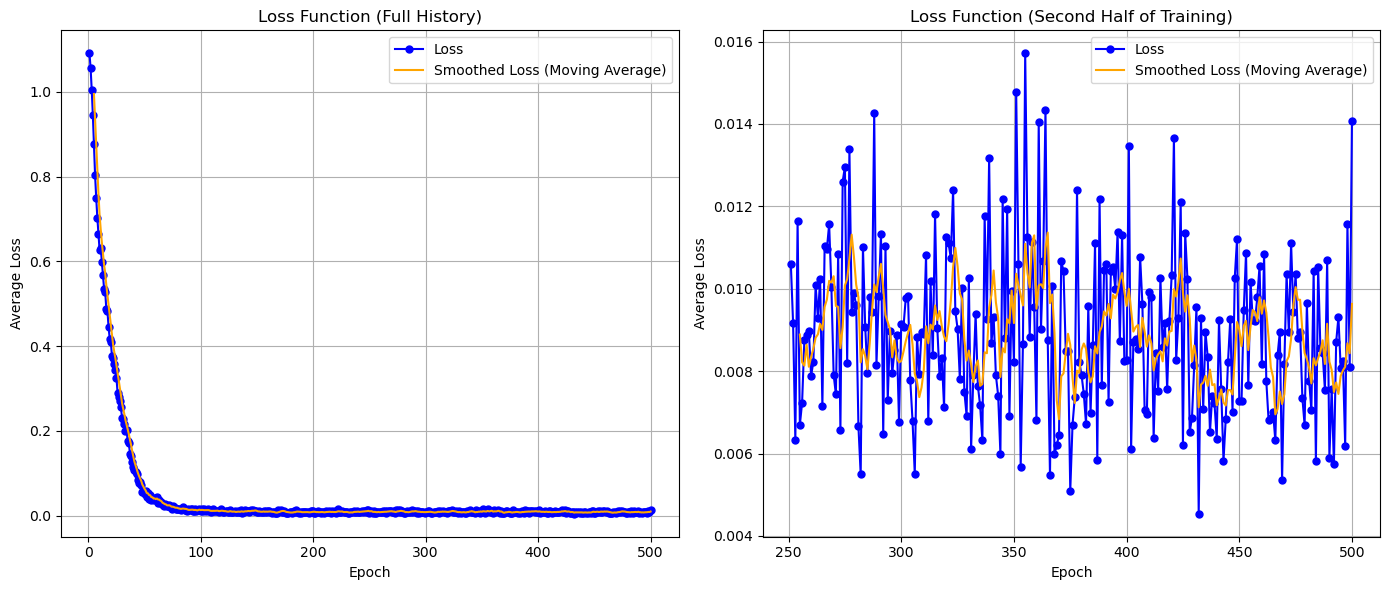

In [69]:
trainer.plot_training_history()

#### Оценка

In [70]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     1.0000    1.0000    1.0000       500
    mushroom     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9010    0.9100    0.9055       100
  chimpanzee     0.9043    0.8500    0.8763       100
    mushroom     0.8381    0.8800    0.8585       100

    accuracy                         0.8800       300
   macro avg     0.8811    0.8800    0.8801       300
weighted avg     0.8811    0.8800    0.8801       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [71]:
trainer.save_model(cifar100)

Model saved as: cifar100_5_model.onnx


### Эксперимент №8

#### Гиперпараметры

In [72]:
batch_size=2**10
epochs=500
lr_rate = 1e-4
dropout_rate=0.3
hidden_layers=[2**16, 2**12, 2**10, 2**8, 2**6]

#### Инициализация модели

In [73]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate, device='cpu')

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_6
CPU times: user 207 ms, sys: 290 ms, total: 497 ms
Wall time: 334 ms


In [74]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 2.76 s, sys: 928 ms, total: 3.69 s
Wall time: 2.49 s


In [75]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_6


#### Информация о модели

In [76]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=65536, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=65536, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=4096, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=1024, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.3, inplace=False)
    (15): Linear(in_features=64, out_features=3, bias=True)
  )
)

#### Обучение

In [77]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.93s/batch, loss=1.031286, lr=0.000100]


Epoch: 1/500, Loss: 1.068288


Epoch 2/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.80s/batch, loss=0.852602, lr=0.000100]


Epoch: 2/500, Loss: 0.873297


Epoch 3/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.78s/batch, loss=0.713531, lr=0.000100]


Epoch: 3/500, Loss: 0.738699


Epoch 4/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.78s/batch, loss=0.694534, lr=0.000100]


Epoch: 4/500, Loss: 0.661075


Epoch 5/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.58s/batch, loss=0.548002, lr=0.000100]


Epoch: 5/500, Loss: 0.576478


Epoch 6/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.91s/batch, loss=0.490079, lr=0.000100]


Epoch: 6/500, Loss: 0.532538


Epoch 7/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.94s/batch, loss=0.448139, lr=0.000100]


Epoch: 7/500, Loss: 0.472060


Epoch 8/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.59s/batch, loss=0.388738, lr=0.000100]


Epoch: 8/500, Loss: 0.415641


Epoch 9/500: 100%|███████████████████████| 2/2 [00:15<00:00,  7.67s/batch, loss=0.346578, lr=0.000100]


Epoch: 9/500, Loss: 0.370158


Epoch 10/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.28s/batch, loss=0.342776, lr=0.000100]


Epoch: 10/500, Loss: 0.339823


Epoch 11/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.34s/batch, loss=0.288363, lr=0.000100]


Epoch: 11/500, Loss: 0.293762


Epoch 12/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.39s/batch, loss=0.184628, lr=0.000100]


Epoch: 12/500, Loss: 0.229377


Epoch 13/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.34s/batch, loss=0.209793, lr=0.000100]


Epoch: 13/500, Loss: 0.215484


Epoch 14/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.167411, lr=0.000100]


Epoch: 14/500, Loss: 0.182078


Epoch 15/500: 100%|██████████████████████| 2/2 [00:15<00:00,  7.53s/batch, loss=0.160277, lr=0.000100]


Epoch: 15/500, Loss: 0.160821


Epoch 16/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.175405, lr=0.000100]


Epoch: 16/500, Loss: 0.154956


Epoch 17/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.34s/batch, loss=0.141242, lr=0.000100]


Epoch: 17/500, Loss: 0.131609


Epoch 18/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.20s/batch, loss=0.109450, lr=0.000100]


Epoch: 18/500, Loss: 0.103956


Epoch 19/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.20s/batch, loss=0.076951, lr=0.000100]


Epoch: 19/500, Loss: 0.079118


Epoch 20/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.066723, lr=0.000100]


Epoch: 20/500, Loss: 0.064351


Epoch 21/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.20s/batch, loss=0.033156, lr=0.000100]


Epoch: 21/500, Loss: 0.049592


Epoch 22/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.05s/batch, loss=0.033326, lr=0.000100]


Epoch: 22/500, Loss: 0.057005


Epoch 23/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.19s/batch, loss=0.067000, lr=0.000100]


Epoch: 23/500, Loss: 0.062025


Epoch 24/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.13s/batch, loss=0.071069, lr=0.000100]


Epoch: 24/500, Loss: 0.051322


Epoch 25/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.18s/batch, loss=0.022856, lr=0.000090]


Epoch: 25/500, Loss: 0.024153


Epoch 26/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.14s/batch, loss=0.020387, lr=0.000090]


Epoch: 26/500, Loss: 0.039274


Epoch 27/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.013450, lr=0.000090]


Epoch: 27/500, Loss: 0.017549


Epoch 28/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.16s/batch, loss=0.042045, lr=0.000090]


Epoch: 28/500, Loss: 0.028964


Epoch 29/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.26s/batch, loss=0.007741, lr=0.000090]


Epoch: 29/500, Loss: 0.012296


Epoch 30/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.46s/batch, loss=0.008204, lr=0.000090]


Epoch: 30/500, Loss: 0.017264


Epoch 31/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.007494, lr=0.000090]


Epoch: 31/500, Loss: 0.011000


Epoch 32/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.46s/batch, loss=0.008969, lr=0.000090]


Epoch: 32/500, Loss: 0.024563


Epoch 33/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.30s/batch, loss=0.038105, lr=0.000090]


Epoch: 33/500, Loss: 0.026385


Epoch 34/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.30s/batch, loss=0.087796, lr=0.000090]


Epoch: 34/500, Loss: 0.046459


Epoch 35/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.18s/batch, loss=0.010729, lr=0.000081]


Epoch: 35/500, Loss: 0.015963


Epoch 36/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.20s/batch, loss=0.007786, lr=0.000081]


Epoch: 36/500, Loss: 0.075031


Epoch 37/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.258958, lr=0.000081]


Epoch: 37/500, Loss: 0.166994


Epoch 38/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.40s/batch, loss=0.047770, lr=0.000073]


Epoch: 38/500, Loss: 0.073179


Epoch 39/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.025833, lr=0.000073]


Epoch: 39/500, Loss: 0.024226


Epoch 40/500: 100%|██████████████████████| 2/2 [00:15<00:00,  7.59s/batch, loss=0.041641, lr=0.000073]


Epoch: 40/500, Loss: 0.042599


Epoch 41/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.029960, lr=0.000066]


Epoch: 41/500, Loss: 0.031443


Epoch 42/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.20s/batch, loss=0.010265, lr=0.000066]


Epoch: 42/500, Loss: 0.015146


Epoch 43/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.16s/batch, loss=0.035765, lr=0.000066]


Epoch: 43/500, Loss: 0.031188


Epoch 44/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.28s/batch, loss=0.018312, lr=0.000059]


Epoch: 44/500, Loss: 0.022775


Epoch 45/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.35s/batch, loss=0.015385, lr=0.000059]


Epoch: 45/500, Loss: 0.015069


Epoch 46/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.006079, lr=0.000059]


Epoch: 46/500, Loss: 0.007431


Epoch 47/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.25s/batch, loss=0.014868, lr=0.000059]


Epoch: 47/500, Loss: 0.011797


Epoch 48/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.011908, lr=0.000059]


Epoch: 48/500, Loss: 0.009954


Epoch 49/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.10s/batch, loss=0.014581, lr=0.000059]


Epoch: 49/500, Loss: 0.010997


Epoch 50/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.33s/batch, loss=0.006135, lr=0.000053]


Epoch: 50/500, Loss: 0.007232


Epoch 51/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.25s/batch, loss=0.005447, lr=0.000053]


Epoch: 51/500, Loss: 0.005999


Epoch 52/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.21s/batch, loss=0.006531, lr=0.000053]


Epoch: 52/500, Loss: 0.005575


Epoch 53/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.002906, lr=0.000053]


Epoch: 53/500, Loss: 0.003792


Epoch 54/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.10s/batch, loss=0.003711, lr=0.000053]


Epoch: 54/500, Loss: 0.004328


Epoch 55/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.28s/batch, loss=0.002511, lr=0.000053]


Epoch: 55/500, Loss: 0.002771


Epoch 56/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.003896, lr=0.000053]


Epoch: 56/500, Loss: 0.003427


Epoch 57/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.31s/batch, loss=0.004689, lr=0.000053]


Epoch: 57/500, Loss: 0.004019


Epoch 58/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.003084, lr=0.000053]


Epoch: 58/500, Loss: 0.002652


Epoch 59/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.37s/batch, loss=0.001250, lr=0.000053]


Epoch: 59/500, Loss: 0.001892


Epoch 60/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.001614, lr=0.000053]


Epoch: 60/500, Loss: 0.002183


Epoch 61/500: 100%|██████████████████████| 2/2 [00:15<00:00,  7.65s/batch, loss=0.001969, lr=0.000053]


Epoch: 61/500, Loss: 0.002372


Epoch 62/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.43s/batch, loss=0.001546, lr=0.000053]


Epoch: 62/500, Loss: 0.001949


Epoch 63/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.001050, lr=0.000048]


Epoch: 63/500, Loss: 0.001221


Epoch 64/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.27s/batch, loss=0.001957, lr=0.000048]


Epoch: 64/500, Loss: 0.001605


Epoch 65/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.46s/batch, loss=0.002067, lr=0.000048]


Epoch: 65/500, Loss: 0.001486


Epoch 66/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.23s/batch, loss=0.001122, lr=0.000048]


Epoch: 66/500, Loss: 0.001253


Epoch 67/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.13s/batch, loss=0.001081, lr=0.000043]


Epoch: 67/500, Loss: 0.001040


Epoch 68/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.28s/batch, loss=0.001229, lr=0.000043]


Epoch: 68/500, Loss: 0.001390


Epoch 69/500: 100%|██████████████████████| 2/2 [00:15<00:00,  7.66s/batch, loss=0.000755, lr=0.000043]


Epoch: 69/500, Loss: 0.001017


Epoch 70/500: 100%|██████████████████████| 2/2 [00:15<00:00,  7.52s/batch, loss=0.000912, lr=0.000043]


Epoch: 70/500, Loss: 0.001138


Epoch 71/500: 100%|██████████████████████| 2/2 [00:16<00:00,  8.07s/batch, loss=0.000811, lr=0.000043]


Epoch: 71/500, Loss: 0.000956


Epoch 72/500: 100%|██████████████████████| 2/2 [00:15<00:00,  7.66s/batch, loss=0.000619, lr=0.000043]


Epoch: 72/500, Loss: 0.000958


Epoch 73/500: 100%|██████████████████████| 2/2 [00:15<00:00,  7.59s/batch, loss=0.001279, lr=0.000043]


Epoch: 73/500, Loss: 0.001004


Epoch 74/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.50s/batch, loss=0.000731, lr=0.000043]


Epoch: 74/500, Loss: 0.000980


Epoch 75/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.001556, lr=0.000039]


Epoch: 75/500, Loss: 0.001183


Epoch 76/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.25s/batch, loss=0.001625, lr=0.000039]


Epoch: 76/500, Loss: 0.001261


Epoch 77/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.40s/batch, loss=0.000828, lr=0.000039]


Epoch: 77/500, Loss: 0.001034


Epoch 78/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.14s/batch, loss=0.000688, lr=0.000035]


Epoch: 78/500, Loss: 0.000959


Epoch 79/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.001290, lr=0.000035]


Epoch: 79/500, Loss: 0.001251


Epoch 80/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.21s/batch, loss=0.000486, lr=0.000035]


Epoch: 80/500, Loss: 0.000911


Epoch 81/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.30s/batch, loss=0.000802, lr=0.000035]


Epoch: 81/500, Loss: 0.000839


Epoch 82/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.21s/batch, loss=0.000574, lr=0.000035]


Epoch: 82/500, Loss: 0.000599


Epoch 83/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.14s/batch, loss=0.001033, lr=0.000035]


Epoch: 83/500, Loss: 0.000803


Epoch 84/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.34s/batch, loss=0.000657, lr=0.000035]


Epoch: 84/500, Loss: 0.000855


Epoch 85/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.35s/batch, loss=0.000679, lr=0.000035]


Epoch: 85/500, Loss: 0.000940


Epoch 86/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.19s/batch, loss=0.001153, lr=0.000031]


Epoch: 86/500, Loss: 0.001012


Epoch 87/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.16s/batch, loss=0.001200, lr=0.000031]


Epoch: 87/500, Loss: 0.001266


Epoch 88/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.43s/batch, loss=0.000650, lr=0.000031]


Epoch: 88/500, Loss: 0.000610


Epoch 89/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.28s/batch, loss=0.000606, lr=0.000028]


Epoch: 89/500, Loss: 0.000757


Epoch 90/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.001058, lr=0.000028]


Epoch: 90/500, Loss: 0.000901


Epoch 91/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.000707, lr=0.000028]


Epoch: 91/500, Loss: 0.000637


Epoch 92/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.10s/batch, loss=0.001153, lr=0.000025]


Epoch: 92/500, Loss: 0.000907


Epoch 93/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.19s/batch, loss=0.000555, lr=0.000025]


Epoch: 93/500, Loss: 0.000776


Epoch 94/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.33s/batch, loss=0.000540, lr=0.000025]


Epoch: 94/500, Loss: 0.000528


Epoch 95/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.30s/batch, loss=0.000508, lr=0.000025]


Epoch: 95/500, Loss: 0.000632


Epoch 96/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.34s/batch, loss=0.001280, lr=0.000025]


Epoch: 96/500, Loss: 0.000888


Epoch 97/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.23s/batch, loss=0.001611, lr=0.000025]


Epoch: 97/500, Loss: 0.001256


Epoch 98/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.28s/batch, loss=0.000272, lr=0.000023]


Epoch: 98/500, Loss: 0.000499


Epoch 99/500: 100%|██████████████████████| 2/2 [00:14<00:00,  7.16s/batch, loss=0.000653, lr=0.000023]


Epoch: 99/500, Loss: 0.000707


Epoch 100/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.56s/batch, loss=0.000724, lr=0.000023]


Epoch: 100/500, Loss: 0.000525


Epoch 101/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.000393, lr=0.000023]


Epoch: 101/500, Loss: 0.000623


Epoch 102/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.000259, lr=0.000021]


Epoch: 102/500, Loss: 0.000518


Epoch 103/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.25s/batch, loss=0.000381, lr=0.000021]


Epoch: 103/500, Loss: 0.000552


Epoch 104/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.27s/batch, loss=0.000699, lr=0.000021]


Epoch: 104/500, Loss: 0.000573


Epoch 105/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.31s/batch, loss=0.001054, lr=0.000019]


Epoch: 105/500, Loss: 0.000796


Epoch 106/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.19s/batch, loss=0.000363, lr=0.000019]


Epoch: 106/500, Loss: 0.000462


Epoch 107/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.000817, lr=0.000019]


Epoch: 107/500, Loss: 0.000737


Epoch 108/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.29s/batch, loss=0.000506, lr=0.000019]


Epoch: 108/500, Loss: 0.000441


Epoch 109/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.29s/batch, loss=0.000924, lr=0.000019]


Epoch: 109/500, Loss: 0.000762


Epoch 110/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.000570, lr=0.000019]


Epoch: 110/500, Loss: 0.000937


Epoch 111/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.29s/batch, loss=0.000433, lr=0.000019]


Epoch: 111/500, Loss: 0.000534


Epoch 112/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.34s/batch, loss=0.000784, lr=0.000017]


Epoch: 112/500, Loss: 0.000754


Epoch 113/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.000367, lr=0.000017]


Epoch: 113/500, Loss: 0.000463


Epoch 114/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.46s/batch, loss=0.000392, lr=0.000017]


Epoch: 114/500, Loss: 0.000552


Epoch 115/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.000430, lr=0.000015]


Epoch: 115/500, Loss: 0.000647


Epoch 116/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.000734, lr=0.000015]


Epoch: 116/500, Loss: 0.000627


Epoch 117/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.06s/batch, loss=0.001918, lr=0.000015]


Epoch: 117/500, Loss: 0.001145


Epoch 118/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.27s/batch, loss=0.000637, lr=0.000014]


Epoch: 118/500, Loss: 0.000602


Epoch 119/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.000457, lr=0.000014]


Epoch: 119/500, Loss: 0.000600


Epoch 120/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.29s/batch, loss=0.002391, lr=0.000014]


Epoch: 120/500, Loss: 0.001500


Epoch 121/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.04s/batch, loss=0.000534, lr=0.000012]


Epoch: 121/500, Loss: 0.000474


Epoch 122/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.10s/batch, loss=0.000338, lr=0.000012]


Epoch: 122/500, Loss: 0.000437


Epoch 123/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.23s/batch, loss=0.001267, lr=0.000012]


Epoch: 123/500, Loss: 0.000810


Epoch 124/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.30s/batch, loss=0.000297, lr=0.000012]


Epoch: 124/500, Loss: 0.000610


Epoch 125/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.000730, lr=0.000012]


Epoch: 125/500, Loss: 0.000545


Epoch 126/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.20s/batch, loss=0.001565, lr=0.000011]


Epoch: 126/500, Loss: 0.001059


Epoch 127/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.001043, lr=0.000011]


Epoch: 127/500, Loss: 0.000999


Epoch 128/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.000426, lr=0.000011]


Epoch: 128/500, Loss: 0.000447


Epoch 129/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.000716, lr=0.000010]


Epoch: 129/500, Loss: 0.000744


Epoch 130/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.14s/batch, loss=0.000539, lr=0.000010]


Epoch: 130/500, Loss: 0.000481


Epoch 131/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.000223, lr=0.000010]


Epoch: 131/500, Loss: 0.000503


Epoch 132/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.000538, lr=0.000009]


Epoch: 132/500, Loss: 0.000484


Epoch 133/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.12s/batch, loss=0.000268, lr=0.000009]


Epoch: 133/500, Loss: 0.000497


Epoch 134/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.21s/batch, loss=0.000421, lr=0.000009]


Epoch: 134/500, Loss: 0.000489


Epoch 135/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.13s/batch, loss=0.000444, lr=0.000008]


Epoch: 135/500, Loss: 0.000539


Epoch 136/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.18s/batch, loss=0.000898, lr=0.000008]


Epoch: 136/500, Loss: 0.000637


Epoch 137/500: 100%|████████████████████| 2/2 [23:47<00:00, 713.81s/batch, loss=0.001020, lr=0.000008]


Epoch: 137/500, Loss: 0.000865


Epoch 138/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.23s/batch, loss=0.000529, lr=0.000007]


Epoch: 138/500, Loss: 0.000490


Epoch 139/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.24s/batch, loss=0.001023, lr=0.000007]


Epoch: 139/500, Loss: 0.000814


Epoch 140/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.96s/batch, loss=0.000450, lr=0.000007]


Epoch: 140/500, Loss: 0.000716


Epoch 141/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.98s/batch, loss=0.000520, lr=0.000006]


Epoch: 141/500, Loss: 0.000823


Epoch 142/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.00s/batch, loss=0.000775, lr=0.000006]


Epoch: 142/500, Loss: 0.000663


Epoch 143/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.000464, lr=0.000006]


Epoch: 143/500, Loss: 0.000450


Epoch 144/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.21s/batch, loss=0.000466, lr=0.000006]


Epoch: 144/500, Loss: 0.000453


Epoch 145/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.000712, lr=0.000006]


Epoch: 145/500, Loss: 0.000588


Epoch 146/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.31s/batch, loss=0.000402, lr=0.000006]


Epoch: 146/500, Loss: 0.000754


Epoch 147/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.31s/batch, loss=0.000299, lr=0.000005]


Epoch: 147/500, Loss: 0.000304


Epoch 148/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.000719, lr=0.000005]


Epoch: 148/500, Loss: 0.000551


Epoch 149/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.23s/batch, loss=0.000373, lr=0.000005]


Epoch: 149/500, Loss: 0.000450


Epoch 150/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.13s/batch, loss=0.000691, lr=0.000005]


Epoch: 150/500, Loss: 0.000544


Epoch 151/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.35s/batch, loss=0.000437, lr=0.000005]


Epoch: 151/500, Loss: 0.000403


Epoch 152/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.70s/batch, loss=0.000727, lr=0.000005]


Epoch: 152/500, Loss: 0.000536


Epoch 153/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.000349, lr=0.000005]


Epoch: 153/500, Loss: 0.000733


Epoch 154/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.07s/batch, loss=0.000616, lr=0.000004]


Epoch: 154/500, Loss: 0.000580


Epoch 155/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.08s/batch, loss=0.000345, lr=0.000004]


Epoch: 155/500, Loss: 0.000506


Epoch 156/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.03s/batch, loss=0.001405, lr=0.000004]


Epoch: 156/500, Loss: 0.000991


Epoch 157/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.12s/batch, loss=0.000822, lr=0.000004]


Epoch: 157/500, Loss: 0.000672


Epoch 158/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.33s/batch, loss=0.000399, lr=0.000004]


Epoch: 158/500, Loss: 0.000529


Epoch 159/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.98s/batch, loss=0.001047, lr=0.000004]


Epoch: 159/500, Loss: 0.000842


Epoch 160/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.10s/batch, loss=0.000574, lr=0.000003]


Epoch: 160/500, Loss: 0.000526


Epoch 161/500: 100%|█████████████████████| 2/2 [00:13<00:00,  7.00s/batch, loss=0.000435, lr=0.000003]


Epoch: 161/500, Loss: 0.000554


Epoch 162/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.000416, lr=0.000003]


Epoch: 162/500, Loss: 0.000390


Epoch 163/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.03s/batch, loss=0.000749, lr=0.000003]


Epoch: 163/500, Loss: 0.000559


Epoch 164/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.04s/batch, loss=0.000200, lr=0.000003]


Epoch: 164/500, Loss: 0.000433


Epoch 165/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.06s/batch, loss=0.000335, lr=0.000003]


Epoch: 165/500, Loss: 0.000396


Epoch 166/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.01s/batch, loss=0.001469, lr=0.000003]


Epoch: 166/500, Loss: 0.001261


Epoch 167/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.20s/batch, loss=0.000598, lr=0.000003]


Epoch: 167/500, Loss: 0.000479


Epoch 168/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.06s/batch, loss=0.000337, lr=0.000003]


Epoch: 168/500, Loss: 0.000471


Epoch 169/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.000438, lr=0.000003]


Epoch: 169/500, Loss: 0.000367


Epoch 170/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.03s/batch, loss=0.000137, lr=0.000003]


Epoch: 170/500, Loss: 0.000357


Epoch 171/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.06s/batch, loss=0.000418, lr=0.000003]


Epoch: 171/500, Loss: 0.000367


Epoch 172/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.09s/batch, loss=0.000457, lr=0.000002]


Epoch: 172/500, Loss: 0.000394


Epoch 173/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.000532, lr=0.000002]


Epoch: 173/500, Loss: 0.000490


Epoch 174/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.02s/batch, loss=0.000328, lr=0.000002]


Epoch: 174/500, Loss: 0.000475


Epoch 175/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.07s/batch, loss=0.000467, lr=0.000002]


Epoch: 175/500, Loss: 0.000407


Epoch 176/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.08s/batch, loss=0.000740, lr=0.000002]


Epoch: 176/500, Loss: 0.000578


Epoch 177/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.08s/batch, loss=0.000326, lr=0.000002]


Epoch: 177/500, Loss: 0.000727


Epoch 178/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.04s/batch, loss=0.000423, lr=0.000002]


Epoch: 178/500, Loss: 0.000416


Epoch 179/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.07s/batch, loss=0.000404, lr=0.000002]


Epoch: 179/500, Loss: 0.000713


Epoch 180/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.02s/batch, loss=0.000523, lr=0.000002]


Epoch: 180/500, Loss: 0.000525


Epoch 181/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.09s/batch, loss=0.000279, lr=0.000002]


Epoch: 181/500, Loss: 0.000294


Epoch 182/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.07s/batch, loss=0.000245, lr=0.000002]


Epoch: 182/500, Loss: 0.000344


Epoch 183/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.03s/batch, loss=0.000252, lr=0.000002]


Epoch: 183/500, Loss: 0.000313


Epoch 184/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.96s/batch, loss=0.000589, lr=0.000002]


Epoch: 184/500, Loss: 0.000542


Epoch 185/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.05s/batch, loss=0.002610, lr=0.000001]


Epoch: 185/500, Loss: 0.001533


Epoch 186/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.95s/batch, loss=0.000647, lr=0.000001]


Epoch: 186/500, Loss: 0.000458


Epoch 187/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.02s/batch, loss=0.000278, lr=0.000001]


Epoch: 187/500, Loss: 0.000329


Epoch 188/500: 100%|█████████████████████| 2/2 [00:13<00:00,  7.00s/batch, loss=0.000456, lr=0.000001]


Epoch: 188/500, Loss: 0.000514


Epoch 189/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.97s/batch, loss=0.000550, lr=0.000001]


Epoch: 189/500, Loss: 0.000491


Epoch 190/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.10s/batch, loss=0.000739, lr=0.000001]


Epoch: 190/500, Loss: 0.000613


Epoch 191/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.99s/batch, loss=0.000559, lr=0.000001]


Epoch: 191/500, Loss: 0.000653


Epoch 192/500: 100%|█████████████████████| 2/2 [00:13<00:00,  7.00s/batch, loss=0.000314, lr=0.000001]


Epoch: 192/500, Loss: 0.000570


Epoch 193/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.00s/batch, loss=0.000632, lr=0.000001]


Epoch: 193/500, Loss: 0.000628


Epoch 194/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.04s/batch, loss=0.000539, lr=0.000001]


Epoch: 194/500, Loss: 0.000630


Epoch 195/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.03s/batch, loss=0.000161, lr=0.000001]


Epoch: 195/500, Loss: 0.000349


Epoch 196/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.07s/batch, loss=0.000619, lr=0.000001]


Epoch: 196/500, Loss: 0.000486


Epoch 197/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.04s/batch, loss=0.000578, lr=0.000001]


Epoch: 197/500, Loss: 0.000459


Epoch 198/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.05s/batch, loss=0.000565, lr=0.000001]


Epoch: 198/500, Loss: 0.000446


Epoch 199/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.04s/batch, loss=0.000575, lr=0.000001]


Epoch: 199/500, Loss: 0.000547


Epoch 200/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.08s/batch, loss=0.000613, lr=0.000001]


Epoch: 200/500, Loss: 0.000572


Epoch 201/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.09s/batch, loss=0.000413, lr=0.000001]


Epoch: 201/500, Loss: 0.000535


Epoch 202/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.02s/batch, loss=0.000680, lr=0.000001]


Epoch: 202/500, Loss: 0.000597


Epoch 203/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.06s/batch, loss=0.000547, lr=0.000001]


Epoch: 203/500, Loss: 0.000511


Epoch 204/500: 100%|█████████████████████| 2/2 [00:13<00:00,  7.00s/batch, loss=0.000310, lr=0.000001]


Epoch: 204/500, Loss: 0.000391


Epoch 205/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.000238, lr=0.000001]


Epoch: 205/500, Loss: 0.000376


Epoch 206/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.96s/batch, loss=0.000800, lr=0.000001]


Epoch: 206/500, Loss: 0.000590


Epoch 207/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.13s/batch, loss=0.000868, lr=0.000001]


Epoch: 207/500, Loss: 0.000643


Epoch 208/500: 100%|█████████████████████| 2/2 [00:13<00:00,  6.97s/batch, loss=0.000608, lr=0.000001]


Epoch: 208/500, Loss: 0.000468


Epoch 209/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.11s/batch, loss=0.000719, lr=0.000001]


Epoch: 209/500, Loss: 0.000617


Epoch 210/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.14s/batch, loss=0.000504, lr=0.000001]


Epoch: 210/500, Loss: 0.000479


Epoch 211/500: 100%|████████████████| 2/2 [9:18:17<00:00, 16748.80s/batch, loss=0.000269, lr=0.000001]


Epoch: 211/500, Loss: 0.000358


Epoch 212/500: 100%|█████████████████████| 2/2 [00:16<00:00,  8.33s/batch, loss=0.000411, lr=0.000001]


Epoch: 212/500, Loss: 0.000449


Epoch 213/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.31s/batch, loss=0.000401, lr=0.000001]


Epoch: 213/500, Loss: 0.000410


Epoch 214/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.32s/batch, loss=0.000321, lr=0.000001]


Epoch: 214/500, Loss: 0.000436


Epoch 215/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.30s/batch, loss=0.001437, lr=0.000001]


Epoch: 215/500, Loss: 0.001001


Epoch 216/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.65s/batch, loss=0.001108, lr=0.000001]


Epoch: 216/500, Loss: 0.000770


Epoch 217/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.21s/batch, loss=0.000505, lr=0.000001]


Epoch: 217/500, Loss: 0.000473


Epoch 218/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.44s/batch, loss=0.000422, lr=0.000000]


Epoch: 218/500, Loss: 0.000458


Epoch 219/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.49s/batch, loss=0.000339, lr=0.000000]


Epoch: 219/500, Loss: 0.000400


Epoch 220/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.49s/batch, loss=0.000364, lr=0.000000]


Epoch: 220/500, Loss: 0.000537


Epoch 221/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.86s/batch, loss=0.000289, lr=0.000000]


Epoch: 221/500, Loss: 0.000452


Epoch 222/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.40s/batch, loss=0.000465, lr=0.000000]


Epoch: 222/500, Loss: 0.000533


Epoch 223/500: 100%|█████████████████████| 2/2 [00:16<00:00,  8.41s/batch, loss=0.000497, lr=0.000000]


Epoch: 223/500, Loss: 0.000691


Epoch 224/500: 100%|█████████████████████| 2/2 [00:16<00:00,  8.33s/batch, loss=0.000667, lr=0.000000]


Epoch: 224/500, Loss: 0.000607


Epoch 225/500: 100%|█████████████████████| 2/2 [00:17<00:00,  8.65s/batch, loss=0.000504, lr=0.000000]


Epoch: 225/500, Loss: 0.000547


Epoch 226/500: 100%|█████████████████████| 2/2 [00:16<00:00,  8.31s/batch, loss=0.000452, lr=0.000000]


Epoch: 226/500, Loss: 0.000516


Epoch 227/500: 100%|█████████████████████| 2/2 [00:16<00:00,  8.03s/batch, loss=0.000500, lr=0.000000]


Epoch: 227/500, Loss: 0.000418


Epoch 228/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.81s/batch, loss=0.000407, lr=0.000000]


Epoch: 228/500, Loss: 0.000440


Epoch 229/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.41s/batch, loss=0.000315, lr=0.000000]


Epoch: 229/500, Loss: 0.000440


Epoch 230/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.26s/batch, loss=0.000424, lr=0.000000]


Epoch: 230/500, Loss: 0.000433


Epoch 231/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.57s/batch, loss=0.000466, lr=0.000000]


Epoch: 231/500, Loss: 0.000473


Epoch 232/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.46s/batch, loss=0.000239, lr=0.000000]


Epoch: 232/500, Loss: 0.000359


Epoch 233/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.46s/batch, loss=0.000371, lr=0.000000]


Epoch: 233/500, Loss: 0.000492


Epoch 234/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.67s/batch, loss=0.000195, lr=0.000000]


Epoch: 234/500, Loss: 0.000463


Epoch 235/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.25s/batch, loss=0.000421, lr=0.000000]


Epoch: 235/500, Loss: 0.000413


Epoch 236/500: 100%|█████████████████████| 2/2 [00:16<00:00,  8.02s/batch, loss=0.000656, lr=0.000000]


Epoch: 236/500, Loss: 0.000615


Epoch 237/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.46s/batch, loss=0.000512, lr=0.000000]


Epoch: 237/500, Loss: 0.000439


Epoch 238/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.53s/batch, loss=0.001053, lr=0.000000]


Epoch: 238/500, Loss: 0.000750


Epoch 239/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.21s/batch, loss=0.000345, lr=0.000000]


Epoch: 239/500, Loss: 0.000420


Epoch 240/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.000354, lr=0.000000]


Epoch: 240/500, Loss: 0.000508


Epoch 241/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.29s/batch, loss=0.000716, lr=0.000000]


Epoch: 241/500, Loss: 0.000572


Epoch 242/500: 100%|█████████████████████| 2/2 [00:16<00:00,  8.11s/batch, loss=0.000316, lr=0.000000]


Epoch: 242/500, Loss: 0.000359


Epoch 243/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.17s/batch, loss=0.000427, lr=0.000000]


Epoch: 243/500, Loss: 0.000544


Epoch 244/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.000605, lr=0.000000]


Epoch: 244/500, Loss: 0.000463


Epoch 245/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.06s/batch, loss=0.000418, lr=0.000000]


Epoch: 245/500, Loss: 0.000507


Epoch 246/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.09s/batch, loss=0.000274, lr=0.000000]


Epoch: 246/500, Loss: 0.000368


Epoch 247/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.04s/batch, loss=0.000673, lr=0.000000]


Epoch: 247/500, Loss: 0.000507


Epoch 248/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.09s/batch, loss=0.000552, lr=0.000000]


Epoch: 248/500, Loss: 0.000461


Epoch 249/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.14s/batch, loss=0.000558, lr=0.000000]


Epoch: 249/500, Loss: 0.000506


Epoch 250/500: 100%|█████████████████████| 2/2 [00:16<00:00,  8.17s/batch, loss=0.000318, lr=0.000000]


Epoch: 250/500, Loss: 0.000541


Epoch 251/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.82s/batch, loss=0.000217, lr=0.000000]


Epoch: 251/500, Loss: 0.000296


Epoch 252/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.000275, lr=0.000000]


Epoch: 252/500, Loss: 0.000381


Epoch 253/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.28s/batch, loss=0.000557, lr=0.000000]


Epoch: 253/500, Loss: 0.000483


Epoch 254/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.15s/batch, loss=0.000387, lr=0.000000]


Epoch: 254/500, Loss: 0.000365


Epoch 255/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.23s/batch, loss=0.000768, lr=0.000000]


Epoch: 255/500, Loss: 0.000774


Epoch 256/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.55s/batch, loss=0.000529, lr=0.000000]


Epoch: 256/500, Loss: 0.000387


Epoch 257/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.70s/batch, loss=0.000506, lr=0.000000]


Epoch: 257/500, Loss: 0.000550


Epoch 258/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.44s/batch, loss=0.000313, lr=0.000000]


Epoch: 258/500, Loss: 0.000390


Epoch 259/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.39s/batch, loss=0.000526, lr=0.000000]


Epoch: 259/500, Loss: 0.000501


Epoch 260/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.49s/batch, loss=0.000450, lr=0.000000]


Epoch: 260/500, Loss: 0.000495


Epoch 261/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.74s/batch, loss=0.000307, lr=0.000000]


Epoch: 261/500, Loss: 0.000442


Epoch 262/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.57s/batch, loss=0.000200, lr=0.000000]


Epoch: 262/500, Loss: 0.000395


Epoch 263/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.85s/batch, loss=0.000202, lr=0.000000]


Epoch: 263/500, Loss: 0.000324


Epoch 264/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.48s/batch, loss=0.000516, lr=0.000000]


Epoch: 264/500, Loss: 0.000458


Epoch 265/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.31s/batch, loss=0.000388, lr=0.000000]


Epoch: 265/500, Loss: 0.000533


Epoch 266/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.41s/batch, loss=0.000844, lr=0.000000]


Epoch: 266/500, Loss: 0.000608


Epoch 267/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.27s/batch, loss=0.000259, lr=0.000000]


Epoch: 267/500, Loss: 0.000413


Epoch 268/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.71s/batch, loss=0.000176, lr=0.000000]


Epoch: 268/500, Loss: 0.000357


Epoch 269/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.69s/batch, loss=0.000896, lr=0.000000]


Epoch: 269/500, Loss: 0.000665


Epoch 270/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.38s/batch, loss=0.000837, lr=0.000000]


Epoch: 270/500, Loss: 0.000570


Epoch 271/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.16s/batch, loss=0.000268, lr=0.000000]


Epoch: 271/500, Loss: 0.000387


Epoch 272/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.14s/batch, loss=0.000519, lr=0.000000]


Epoch: 272/500, Loss: 0.000378


Epoch 273/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.30s/batch, loss=0.001570, lr=0.000000]


Epoch: 273/500, Loss: 0.001039


Epoch 274/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.34s/batch, loss=0.000670, lr=0.000000]


Epoch: 274/500, Loss: 0.000595


Epoch 275/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.000396, lr=0.000000]


Epoch: 275/500, Loss: 0.000619


Epoch 276/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.22s/batch, loss=0.000254, lr=0.000000]


Epoch: 276/500, Loss: 0.000507


Epoch 277/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.27s/batch, loss=0.000889, lr=0.000000]


Epoch: 277/500, Loss: 0.000760


Epoch 278/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.18s/batch, loss=0.000433, lr=0.000000]


Epoch: 278/500, Loss: 0.000387


Epoch 279/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.49s/batch, loss=0.000840, lr=0.000000]


Epoch: 279/500, Loss: 0.000603


Epoch 280/500: 100%|█████████████████████| 2/2 [00:15<00:00,  7.56s/batch, loss=0.001109, lr=0.000000]


Epoch: 280/500, Loss: 0.000787


Epoch 281/500: 100%|█████████████████████| 2/2 [00:14<00:00,  7.33s/batch, loss=0.000363, lr=0.000000]

Epoch: 281/500, Loss: 0.000388
Early stopping activated.
CPU times: user 8h 6min 41s, sys: 57min 47s, total: 9h 4min 28s
Wall time: 10h 49min 55s


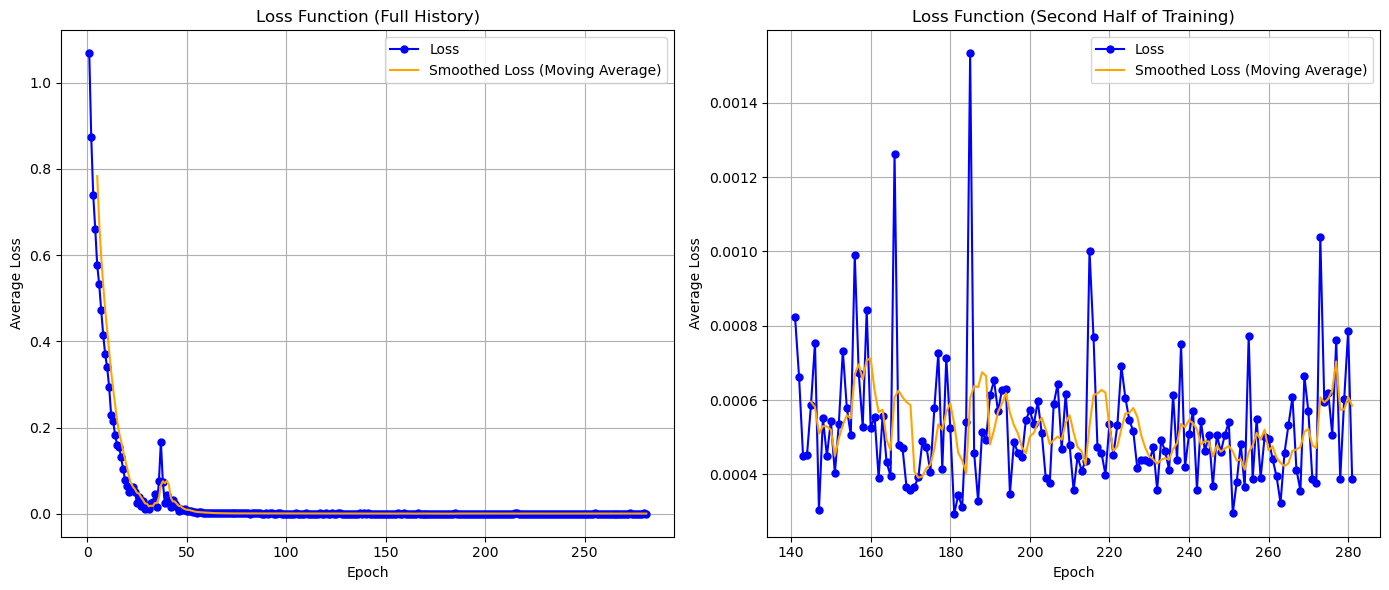

In [78]:
trainer.plot_training_history()

#### Оценка

In [79]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     1.0000    1.0000    1.0000       500
    mushroom     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9118    0.9300    0.9208       100
  chimpanzee     0.8990    0.8900    0.8945       100
    mushroom     0.8889    0.8800    0.8844       100

    accuracy                         0.9000       300
   macro avg     0.8999    0.9000    0.8999       300
weighted avg     0.8999    0.9000    0.8999       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [80]:
trainer.save_model(cifar100)

Model saved as: cifar100_6_model.onnx


### Эксперимент №9

#### Гиперпараметры

In [81]:
batch_size=2**10
epochs=500
lr_rate = 1e-4
dropout_rate=0.1
hidden_layers=[2**12, 2**11, 2**10, 2**9, 2**8, 2**7, 2**6, 2**5, 2**4, 2**3, 2**2]

#### Инициализация модели

In [82]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate, device='cpu')

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_7
CPU times: user 1.46 s, sys: 890 ms, total: 2.35 s
Wall time: 1.04 s


In [83]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 97.5 ms, sys: 32.3 ms, total: 130 ms
Wall time: 131 ms


In [84]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_7


#### Информация о модели

In [85]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=4096, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.1, inplace=False)
    (15): Linear(in_features=256, out_features=128, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.1, inplace=False)
    (18): Linear(in_features=128, out_features=64, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.1, inplace=False)
    (21): Linear(in_features=64, out_features=32, bias=True)
    (22): ReLU()
    (23): Dropout(p=0.1, inp

#### Обучение

In [86]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=1.137397, lr=0.000100]


Epoch: 1/500, Loss: 1.136642


Epoch 2/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=1.140571, lr=0.000100]


Epoch: 2/500, Loss: 1.136645


Epoch 3/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=1.123254, lr=0.000100]


Epoch: 3/500, Loss: 1.131844


Epoch 4/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.59batch/s, loss=1.139605, lr=0.000100]


Epoch: 4/500, Loss: 1.135722


Epoch 5/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=1.136212, lr=0.000100]


Epoch: 5/500, Loss: 1.132836


Epoch 6/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=1.119239, lr=0.000100]


Epoch: 6/500, Loss: 1.126332


Epoch 7/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=1.116116, lr=0.000100]


Epoch: 7/500, Loss: 1.121588


Epoch 8/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=1.109319, lr=0.000100]


Epoch: 8/500, Loss: 1.117354


Epoch 9/500: 100%|███████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=1.127644, lr=0.000100]


Epoch: 9/500, Loss: 1.120083


Epoch 10/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=1.113838, lr=0.000100]


Epoch: 10/500, Loss: 1.115139


Epoch 11/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=1.121952, lr=0.000100]


Epoch: 11/500, Loss: 1.115746


Epoch 12/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=1.106840, lr=0.000100]


Epoch: 12/500, Loss: 1.109755


Epoch 13/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=1.117225, lr=0.000100]


Epoch: 13/500, Loss: 1.111889


Epoch 14/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=1.107049, lr=0.000100]


Epoch: 14/500, Loss: 1.107988


Epoch 15/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=1.106223, lr=0.000100]


Epoch: 15/500, Loss: 1.106052


Epoch 16/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=1.105036, lr=0.000100]


Epoch: 16/500, Loss: 1.104059


Epoch 17/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=1.095547, lr=0.000100]


Epoch: 17/500, Loss: 1.099046


Epoch 18/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.49batch/s, loss=1.105283, lr=0.000100]


Epoch: 18/500, Loss: 1.098522


Epoch 19/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=1.074340, lr=0.000100]


Epoch: 19/500, Loss: 1.082755


Epoch 20/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=1.070179, lr=0.000100]


Epoch: 20/500, Loss: 1.071324


Epoch 21/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=1.034084, lr=0.000100]


Epoch: 21/500, Loss: 1.049122


Epoch 22/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=1.034412, lr=0.000100]


Epoch: 22/500, Loss: 1.033031


Epoch 23/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.27batch/s, loss=1.003454, lr=0.000100]


Epoch: 23/500, Loss: 1.014809


Epoch 24/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.54batch/s, loss=0.993178, lr=0.000100]


Epoch: 24/500, Loss: 0.978795


Epoch 25/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.949861, lr=0.000100]


Epoch: 25/500, Loss: 0.965673


Epoch 26/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.66batch/s, loss=0.924902, lr=0.000100]


Epoch: 26/500, Loss: 0.942677


Epoch 27/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.35batch/s, loss=0.945446, lr=0.000100]


Epoch: 27/500, Loss: 0.923913


Epoch 28/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=0.941437, lr=0.000100]


Epoch: 28/500, Loss: 0.929617


Epoch 29/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.894857, lr=0.000100]


Epoch: 29/500, Loss: 0.898943


Epoch 30/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.34batch/s, loss=0.875379, lr=0.000100]


Epoch: 30/500, Loss: 0.885868


Epoch 31/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.29batch/s, loss=0.874139, lr=0.000100]


Epoch: 31/500, Loss: 0.869338


Epoch 32/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.37batch/s, loss=0.852818, lr=0.000100]


Epoch: 32/500, Loss: 0.853827


Epoch 33/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.804497, lr=0.000100]


Epoch: 33/500, Loss: 0.823538


Epoch 34/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.50batch/s, loss=0.794726, lr=0.000100]


Epoch: 34/500, Loss: 0.822398


Epoch 35/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.843293, lr=0.000100]


Epoch: 35/500, Loss: 0.831536


Epoch 36/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.55batch/s, loss=0.855832, lr=0.000100]


Epoch: 36/500, Loss: 0.840988


Epoch 37/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.792778, lr=0.000100]


Epoch: 37/500, Loss: 0.799635


Epoch 38/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.779979, lr=0.000100]


Epoch: 38/500, Loss: 0.784636


Epoch 39/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.782075, lr=0.000100]


Epoch: 39/500, Loss: 0.784574


Epoch 40/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.791261, lr=0.000100]


Epoch: 40/500, Loss: 0.791663


Epoch 41/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.765120, lr=0.000100]


Epoch: 41/500, Loss: 0.782595


Epoch 42/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.788094, lr=0.000100]


Epoch: 42/500, Loss: 0.781504


Epoch 43/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.59batch/s, loss=0.779403, lr=0.000100]


Epoch: 43/500, Loss: 0.755865


Epoch 44/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.25batch/s, loss=0.739462, lr=0.000100]


Epoch: 44/500, Loss: 0.754222


Epoch 45/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.32batch/s, loss=0.812588, lr=0.000100]


Epoch: 45/500, Loss: 0.764130


Epoch 46/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.22batch/s, loss=0.741596, lr=0.000100]


Epoch: 46/500, Loss: 0.745085


Epoch 47/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.23batch/s, loss=0.727602, lr=0.000100]


Epoch: 47/500, Loss: 0.733201


Epoch 48/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.23batch/s, loss=0.711221, lr=0.000100]


Epoch: 48/500, Loss: 0.731689


Epoch 49/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.27batch/s, loss=0.661918, lr=0.000100]


Epoch: 49/500, Loss: 0.695209


Epoch 50/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.56batch/s, loss=0.735718, lr=0.000100]


Epoch: 50/500, Loss: 0.711964


Epoch 51/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.736179, lr=0.000100]


Epoch: 51/500, Loss: 0.720420


Epoch 52/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.692300, lr=0.000100]


Epoch: 52/500, Loss: 0.700886


Epoch 53/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.697890, lr=0.000090]


Epoch: 53/500, Loss: 0.703992


Epoch 54/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.697041, lr=0.000090]


Epoch: 54/500, Loss: 0.696411


Epoch 55/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.690785, lr=0.000090]


Epoch: 55/500, Loss: 0.697292


Epoch 56/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.730471, lr=0.000081]


Epoch: 56/500, Loss: 0.694785


Epoch 57/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=0.671799, lr=0.000081]


Epoch: 57/500, Loss: 0.666539


Epoch 58/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.61batch/s, loss=0.682782, lr=0.000081]


Epoch: 58/500, Loss: 0.683313


Epoch 59/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=0.703155, lr=0.000081]


Epoch: 59/500, Loss: 0.693292


Epoch 60/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.36batch/s, loss=0.632338, lr=0.000081]


Epoch: 60/500, Loss: 0.657515


Epoch 61/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.681917, lr=0.000081]


Epoch: 61/500, Loss: 0.660871


Epoch 62/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.697256, lr=0.000081]


Epoch: 62/500, Loss: 0.678724


Epoch 63/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.629828, lr=0.000081]


Epoch: 63/500, Loss: 0.648115


Epoch 64/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.672333, lr=0.000081]


Epoch: 64/500, Loss: 0.653865


Epoch 65/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.620566, lr=0.000081]


Epoch: 65/500, Loss: 0.636800


Epoch 66/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.665945, lr=0.000081]


Epoch: 66/500, Loss: 0.646890


Epoch 67/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.596208, lr=0.000081]


Epoch: 67/500, Loss: 0.618676


Epoch 68/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.587998, lr=0.000081]


Epoch: 68/500, Loss: 0.599302


Epoch 69/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.617609, lr=0.000081]


Epoch: 69/500, Loss: 0.624226


Epoch 70/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.576830, lr=0.000081]


Epoch: 70/500, Loss: 0.603046


Epoch 71/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.608018, lr=0.000081]


Epoch: 71/500, Loss: 0.608320


Epoch 72/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.65batch/s, loss=0.617446, lr=0.000073]


Epoch: 72/500, Loss: 0.609178


Epoch 73/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.621315, lr=0.000073]


Epoch: 73/500, Loss: 0.620223


Epoch 74/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=0.575102, lr=0.000073]


Epoch: 74/500, Loss: 0.606847


Epoch 75/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.609788, lr=0.000066]


Epoch: 75/500, Loss: 0.596615


Epoch 76/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.618906, lr=0.000066]


Epoch: 76/500, Loss: 0.605206


Epoch 77/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.541389, lr=0.000066]


Epoch: 77/500, Loss: 0.571913


Epoch 78/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.593866, lr=0.000066]


Epoch: 78/500, Loss: 0.589822


Epoch 79/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.584418, lr=0.000066]


Epoch: 79/500, Loss: 0.590071


Epoch 80/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.573399, lr=0.000066]


Epoch: 80/500, Loss: 0.577915


Epoch 81/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.95batch/s, loss=0.584252, lr=0.000059]


Epoch: 81/500, Loss: 0.581527


Epoch 82/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.558228, lr=0.000059]


Epoch: 82/500, Loss: 0.571450


Epoch 83/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.544282, lr=0.000059]


Epoch: 83/500, Loss: 0.560449


Epoch 84/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.595784, lr=0.000059]


Epoch: 84/500, Loss: 0.562740


Epoch 85/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.45batch/s, loss=0.553180, lr=0.000059]


Epoch: 85/500, Loss: 0.563222


Epoch 86/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.55batch/s, loss=0.561116, lr=0.000059]


Epoch: 86/500, Loss: 0.548769


Epoch 87/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.60batch/s, loss=0.524250, lr=0.000059]


Epoch: 87/500, Loss: 0.538187


Epoch 88/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.536785, lr=0.000059]


Epoch: 88/500, Loss: 0.545458


Epoch 89/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.557214, lr=0.000059]


Epoch: 89/500, Loss: 0.554973


Epoch 90/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.541163, lr=0.000059]


Epoch: 90/500, Loss: 0.545407


Epoch 91/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.535673, lr=0.000053]


Epoch: 91/500, Loss: 0.544466


Epoch 92/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.521506, lr=0.000053]


Epoch: 92/500, Loss: 0.538059


Epoch 93/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.492463, lr=0.000053]


Epoch: 93/500, Loss: 0.514747


Epoch 94/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.546480, lr=0.000053]


Epoch: 94/500, Loss: 0.535199


Epoch 95/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.30batch/s, loss=0.573728, lr=0.000053]


Epoch: 95/500, Loss: 0.535758


Epoch 96/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.44batch/s, loss=0.530039, lr=0.000053]


Epoch: 96/500, Loss: 0.534284


Epoch 97/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.40batch/s, loss=0.470544, lr=0.000048]


Epoch: 97/500, Loss: 0.491204


Epoch 98/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.486164, lr=0.000048]


Epoch: 98/500, Loss: 0.499960


Epoch 99/500: 100%|██████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.526155, lr=0.000048]


Epoch: 99/500, Loss: 0.522430


Epoch 100/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.537168, lr=0.000048]


Epoch: 100/500, Loss: 0.513060


Epoch 101/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.519267, lr=0.000043]


Epoch: 101/500, Loss: 0.517817


Epoch 102/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.500947, lr=0.000043]


Epoch: 102/500, Loss: 0.502318


Epoch 103/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.531061, lr=0.000043]


Epoch: 103/500, Loss: 0.512404


Epoch 104/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.479194, lr=0.000039]


Epoch: 104/500, Loss: 0.499852


Epoch 105/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.492889, lr=0.000039]


Epoch: 105/500, Loss: 0.494790


Epoch 106/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.481606, lr=0.000039]


Epoch: 106/500, Loss: 0.484012


Epoch 107/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.533529, lr=0.000039]


Epoch: 107/500, Loss: 0.508129


Epoch 108/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.490724, lr=0.000039]


Epoch: 108/500, Loss: 0.484225


Epoch 109/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.483477, lr=0.000039]


Epoch: 109/500, Loss: 0.485277


Epoch 110/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.509449, lr=0.000035]


Epoch: 110/500, Loss: 0.496652


Epoch 111/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.470704, lr=0.000035]


Epoch: 111/500, Loss: 0.476530


Epoch 112/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.487079, lr=0.000035]


Epoch: 112/500, Loss: 0.487385


Epoch 113/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.474327, lr=0.000035]


Epoch: 113/500, Loss: 0.479001


Epoch 114/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.477301, lr=0.000035]


Epoch: 114/500, Loss: 0.471943


Epoch 115/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.51batch/s, loss=0.525146, lr=0.000035]


Epoch: 115/500, Loss: 0.482251


Epoch 116/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.52batch/s, loss=0.480116, lr=0.000035]


Epoch: 116/500, Loss: 0.468226


Epoch 117/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.95batch/s, loss=0.476171, lr=0.000035]


Epoch: 117/500, Loss: 0.465780


Epoch 118/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.481089, lr=0.000035]


Epoch: 118/500, Loss: 0.469525


Epoch 119/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.461049, lr=0.000035]


Epoch: 119/500, Loss: 0.471534


Epoch 120/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.455133, lr=0.000035]


Epoch: 120/500, Loss: 0.466656


Epoch 121/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.455448, lr=0.000031]


Epoch: 121/500, Loss: 0.459768


Epoch 122/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.454058, lr=0.000031]


Epoch: 122/500, Loss: 0.453535


Epoch 123/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.490358, lr=0.000031]


Epoch: 123/500, Loss: 0.471875


Epoch 124/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.445489, lr=0.000031]


Epoch: 124/500, Loss: 0.452659


Epoch 125/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.424392, lr=0.000031]


Epoch: 125/500, Loss: 0.446388


Epoch 126/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.465587, lr=0.000031]


Epoch: 126/500, Loss: 0.448434


Epoch 127/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.440289, lr=0.000031]


Epoch: 127/500, Loss: 0.450526


Epoch 128/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.447189, lr=0.000031]


Epoch: 128/500, Loss: 0.453683


Epoch 129/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.449178, lr=0.000028]


Epoch: 129/500, Loss: 0.450389


Epoch 130/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.478116, lr=0.000028]


Epoch: 130/500, Loss: 0.464299


Epoch 131/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.426248, lr=0.000028]


Epoch: 131/500, Loss: 0.434995


Epoch 132/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.444497, lr=0.000028]


Epoch: 132/500, Loss: 0.451129


Epoch 133/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.430337, lr=0.000028]


Epoch: 133/500, Loss: 0.439332


Epoch 134/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.38batch/s, loss=0.445800, lr=0.000028]


Epoch: 134/500, Loss: 0.437349


Epoch 135/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.428010, lr=0.000025]


Epoch: 135/500, Loss: 0.439943


Epoch 136/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.457341, lr=0.000025]


Epoch: 136/500, Loss: 0.448569


Epoch 137/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.445206, lr=0.000025]


Epoch: 137/500, Loss: 0.446798


Epoch 138/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.56batch/s, loss=0.488338, lr=0.000023]


Epoch: 138/500, Loss: 0.456351


Epoch 139/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.454401, lr=0.000023]


Epoch: 139/500, Loss: 0.441323


Epoch 140/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.14batch/s, loss=0.461292, lr=0.000023]


Epoch: 140/500, Loss: 0.454499


Epoch 141/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.55batch/s, loss=0.402834, lr=0.000021]


Epoch: 141/500, Loss: 0.418183


Epoch 142/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=0.441698, lr=0.000021]


Epoch: 142/500, Loss: 0.434377


Epoch 143/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=0.474617, lr=0.000021]


Epoch: 143/500, Loss: 0.452342


Epoch 144/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.406533, lr=0.000021]


Epoch: 144/500, Loss: 0.420413


Epoch 145/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.48batch/s, loss=0.411401, lr=0.000019]


Epoch: 145/500, Loss: 0.426152


Epoch 146/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.42batch/s, loss=0.391588, lr=0.000019]


Epoch: 146/500, Loss: 0.415800


Epoch 147/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.420087, lr=0.000019]


Epoch: 147/500, Loss: 0.419107


Epoch 148/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.427197, lr=0.000019]


Epoch: 148/500, Loss: 0.429265


Epoch 149/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.65batch/s, loss=0.438411, lr=0.000019]


Epoch: 149/500, Loss: 0.432151


Epoch 150/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.449078, lr=0.000017]


Epoch: 150/500, Loss: 0.435185


Epoch 151/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.62batch/s, loss=0.442060, lr=0.000017]


Epoch: 151/500, Loss: 0.430868


Epoch 152/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.430874, lr=0.000017]


Epoch: 152/500, Loss: 0.422992


Epoch 153/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.435371, lr=0.000015]


Epoch: 153/500, Loss: 0.430626


Epoch 154/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.432348, lr=0.000015]


Epoch: 154/500, Loss: 0.421854


Epoch 155/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.398114, lr=0.000015]


Epoch: 155/500, Loss: 0.410262


Epoch 156/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.439750, lr=0.000015]


Epoch: 156/500, Loss: 0.432808


Epoch 157/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=0.385449, lr=0.000015]


Epoch: 157/500, Loss: 0.406594


Epoch 158/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.419618, lr=0.000015]


Epoch: 158/500, Loss: 0.421303


Epoch 159/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.464887, lr=0.000015]


Epoch: 159/500, Loss: 0.438655


Epoch 160/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.53batch/s, loss=0.402812, lr=0.000015]


Epoch: 160/500, Loss: 0.420308


Epoch 161/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.20batch/s, loss=0.421489, lr=0.000014]


Epoch: 161/500, Loss: 0.420583


Epoch 162/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.39batch/s, loss=0.411461, lr=0.000014]


Epoch: 162/500, Loss: 0.410469


Epoch 163/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.47batch/s, loss=0.410358, lr=0.000014]


Epoch: 163/500, Loss: 0.411100


Epoch 164/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.47batch/s, loss=0.400263, lr=0.000012]


Epoch: 164/500, Loss: 0.413250


Epoch 165/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.447499, lr=0.000012]


Epoch: 165/500, Loss: 0.429456


Epoch 166/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.47batch/s, loss=0.403482, lr=0.000012]


Epoch: 166/500, Loss: 0.426801


Epoch 167/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.60batch/s, loss=0.436399, lr=0.000011]


Epoch: 167/500, Loss: 0.423827


Epoch 168/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.392212, lr=0.000011]


Epoch: 168/500, Loss: 0.409832


Epoch 169/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.365865, lr=0.000011]


Epoch: 169/500, Loss: 0.402812


Epoch 170/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.425741, lr=0.000011]


Epoch: 170/500, Loss: 0.420865


Epoch 171/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.422122, lr=0.000011]


Epoch: 171/500, Loss: 0.416472


Epoch 172/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.451947, lr=0.000011]


Epoch: 172/500, Loss: 0.426253


Epoch 173/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.434514, lr=0.000010]


Epoch: 173/500, Loss: 0.428565


Epoch 174/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.95batch/s, loss=0.416123, lr=0.000010]


Epoch: 174/500, Loss: 0.409308


Epoch 175/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.423496, lr=0.000010]


Epoch: 175/500, Loss: 0.427351


Epoch 176/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.32batch/s, loss=0.412006, lr=0.000009]


Epoch: 176/500, Loss: 0.407926


Epoch 177/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.455729, lr=0.000009]


Epoch: 177/500, Loss: 0.432322


Epoch 178/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.420011, lr=0.000009]


Epoch: 178/500, Loss: 0.417172


Epoch 179/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.408671, lr=0.000008]


Epoch: 179/500, Loss: 0.416242


Epoch 180/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.435002, lr=0.000008]


Epoch: 180/500, Loss: 0.423821


Epoch 181/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.423820, lr=0.000008]


Epoch: 181/500, Loss: 0.427524


Epoch 182/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.422032, lr=0.000007]


Epoch: 182/500, Loss: 0.424586


Epoch 183/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.432011, lr=0.000007]


Epoch: 183/500, Loss: 0.420457


Epoch 184/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.413287, lr=0.000007]


Epoch: 184/500, Loss: 0.417594


Epoch 185/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.426393, lr=0.000006]


Epoch: 185/500, Loss: 0.418126


Epoch 186/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.409085, lr=0.000006]


Epoch: 186/500, Loss: 0.413857


Epoch 187/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.47batch/s, loss=0.419160, lr=0.000006]


Epoch: 187/500, Loss: 0.409779


Epoch 188/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.404298, lr=0.000006]


Epoch: 188/500, Loss: 0.415018


Epoch 189/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.427542, lr=0.000006]


Epoch: 189/500, Loss: 0.414814


Epoch 190/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.455019, lr=0.000006]


Epoch: 190/500, Loss: 0.434594


Epoch 191/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.424779, lr=0.000005]


Epoch: 191/500, Loss: 0.413842


Epoch 192/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.454258, lr=0.000005]


Epoch: 192/500, Loss: 0.436544


Epoch 193/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.410777, lr=0.000005]


Epoch: 193/500, Loss: 0.417939


Epoch 194/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.412151, lr=0.000005]


Epoch: 194/500, Loss: 0.414036


Epoch 195/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.372693, lr=0.000005]


Epoch: 195/500, Loss: 0.404955


Epoch 196/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.396153, lr=0.000005]


Epoch: 196/500, Loss: 0.403572


Epoch 197/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.62batch/s, loss=0.456507, lr=0.000004]


Epoch: 197/500, Loss: 0.430160


Epoch 198/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.49batch/s, loss=0.432419, lr=0.000004]


Epoch: 198/500, Loss: 0.429563


Epoch 199/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.34batch/s, loss=0.433994, lr=0.000004]


Epoch: 199/500, Loss: 0.416380


Epoch 200/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.405934, lr=0.000004]


Epoch: 200/500, Loss: 0.408583


Epoch 201/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.428866, lr=0.000004]


Epoch: 201/500, Loss: 0.426341


Epoch 202/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.18batch/s, loss=0.435665, lr=0.000004]


Epoch: 202/500, Loss: 0.421193


Epoch 203/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.39batch/s, loss=0.366725, lr=0.000003]


Epoch: 203/500, Loss: 0.404487


Epoch 204/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.393054, lr=0.000003]


Epoch: 204/500, Loss: 0.408436


Epoch 205/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.401433, lr=0.000003]


Epoch: 205/500, Loss: 0.405819


Epoch 206/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.418799, lr=0.000003]


Epoch: 206/500, Loss: 0.408682


Epoch 207/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.62batch/s, loss=0.426614, lr=0.000003]


Epoch: 207/500, Loss: 0.417947


Epoch 208/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.441292, lr=0.000003]


Epoch: 208/500, Loss: 0.423031


Epoch 209/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=0.384572, lr=0.000003]


Epoch: 209/500, Loss: 0.409098


Epoch 210/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.64batch/s, loss=0.413523, lr=0.000003]


Epoch: 210/500, Loss: 0.411980


Epoch 211/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.437597, lr=0.000003]


Epoch: 211/500, Loss: 0.418484


Epoch 212/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.39batch/s, loss=0.383145, lr=0.000003]


Epoch: 212/500, Loss: 0.399163


Epoch 213/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.424542, lr=0.000003]


Epoch: 213/500, Loss: 0.420448


Epoch 214/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.405238, lr=0.000003]


Epoch: 214/500, Loss: 0.412771


Epoch 215/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.45batch/s, loss=0.431015, lr=0.000003]


Epoch: 215/500, Loss: 0.417211


Epoch 216/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=0.417038, lr=0.000002]


Epoch: 216/500, Loss: 0.412693


Epoch 217/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.52batch/s, loss=0.426975, lr=0.000002]


Epoch: 217/500, Loss: 0.413229


Epoch 218/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.417610, lr=0.000002]


Epoch: 218/500, Loss: 0.416523


Epoch 219/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.414954, lr=0.000002]


Epoch: 219/500, Loss: 0.412121


Epoch 220/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.388311, lr=0.000002]


Epoch: 220/500, Loss: 0.407131


Epoch 221/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.410961, lr=0.000002]


Epoch: 221/500, Loss: 0.406880


Epoch 222/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.386459, lr=0.000002]


Epoch: 222/500, Loss: 0.403976


Epoch 223/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.398498, lr=0.000002]


Epoch: 223/500, Loss: 0.405331


Epoch 224/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.402650, lr=0.000002]


Epoch: 224/500, Loss: 0.411380


Epoch 225/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.65batch/s, loss=0.401239, lr=0.000002]


Epoch: 225/500, Loss: 0.407903


Epoch 226/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.59batch/s, loss=0.381017, lr=0.000002]


Epoch: 226/500, Loss: 0.402545


Epoch 227/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.405048, lr=0.000002]


Epoch: 227/500, Loss: 0.413320


Epoch 228/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=0.401058, lr=0.000001]


Epoch: 228/500, Loss: 0.403327


Epoch 229/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.431671, lr=0.000001]


Epoch: 229/500, Loss: 0.412487


Epoch 230/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.383025, lr=0.000001]


Epoch: 230/500, Loss: 0.399028


Epoch 231/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.399075, lr=0.000001]


Epoch: 231/500, Loss: 0.405928


Epoch 232/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=0.426871, lr=0.000001]


Epoch: 232/500, Loss: 0.423658


Epoch 233/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.424182, lr=0.000001]


Epoch: 233/500, Loss: 0.418588


Epoch 234/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.420653, lr=0.000001]


Epoch: 234/500, Loss: 0.411354


Epoch 235/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.387971, lr=0.000001]


Epoch: 235/500, Loss: 0.405112


Epoch 236/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.59batch/s, loss=0.412006, lr=0.000001]


Epoch: 236/500, Loss: 0.411954


Epoch 237/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.29batch/s, loss=0.351909, lr=0.000001]


Epoch: 237/500, Loss: 0.387917


Epoch 238/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.54batch/s, loss=0.405539, lr=0.000001]


Epoch: 238/500, Loss: 0.410609


Epoch 239/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.435062, lr=0.000001]


Epoch: 239/500, Loss: 0.420051


Epoch 240/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.54batch/s, loss=0.416989, lr=0.000001]


Epoch: 240/500, Loss: 0.417227


Epoch 241/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.398205, lr=0.000001]


Epoch: 241/500, Loss: 0.400711


Epoch 242/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.406152, lr=0.000001]


Epoch: 242/500, Loss: 0.413563


Epoch 243/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.437429, lr=0.000001]


Epoch: 243/500, Loss: 0.411976


Epoch 244/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.397004, lr=0.000001]


Epoch: 244/500, Loss: 0.411438


Epoch 245/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.418105, lr=0.000001]


Epoch: 245/500, Loss: 0.423286


Epoch 246/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.61batch/s, loss=0.402807, lr=0.000001]


Epoch: 246/500, Loss: 0.404112


Epoch 247/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.408559, lr=0.000001]


Epoch: 247/500, Loss: 0.416942


Epoch 248/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.403400, lr=0.000001]


Epoch: 248/500, Loss: 0.408927


Epoch 249/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.402997, lr=0.000001]


Epoch: 249/500, Loss: 0.402038


Epoch 250/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.405905, lr=0.000001]


Epoch: 250/500, Loss: 0.409704


Epoch 251/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.55batch/s, loss=0.423057, lr=0.000001]


Epoch: 251/500, Loss: 0.411890


Epoch 252/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.49batch/s, loss=0.399638, lr=0.000001]


Epoch: 252/500, Loss: 0.414099


Epoch 253/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.401218, lr=0.000001]


Epoch: 253/500, Loss: 0.406349


Epoch 254/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.411986, lr=0.000001]


Epoch: 254/500, Loss: 0.413392


Epoch 255/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.404895, lr=0.000001]


Epoch: 255/500, Loss: 0.411835


Epoch 256/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.410636, lr=0.000001]


Epoch: 256/500, Loss: 0.422517


Epoch 257/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.429146, lr=0.000001]


Epoch: 257/500, Loss: 0.411478


Epoch 258/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.374444, lr=0.000001]


Epoch: 258/500, Loss: 0.394115


Epoch 259/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.406509, lr=0.000001]


Epoch: 259/500, Loss: 0.407692


Epoch 260/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.395055, lr=0.000001]


Epoch: 260/500, Loss: 0.402273


Epoch 261/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.398188, lr=0.000001]


Epoch: 261/500, Loss: 0.402058


Epoch 262/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.429080, lr=0.000001]


Epoch: 262/500, Loss: 0.425703


Epoch 263/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.396517, lr=0.000001]


Epoch: 263/500, Loss: 0.396049


Epoch 264/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.410405, lr=0.000001]


Epoch: 264/500, Loss: 0.406954


Epoch 265/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.408825, lr=0.000000]


Epoch: 265/500, Loss: 0.409333


Epoch 266/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.422763, lr=0.000000]


Epoch: 266/500, Loss: 0.414144


Epoch 267/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.401964, lr=0.000000]


Epoch: 267/500, Loss: 0.410081


Epoch 268/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.393054, lr=0.000000]


Epoch: 268/500, Loss: 0.396929


Epoch 269/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.416277, lr=0.000000]


Epoch: 269/500, Loss: 0.408556


Epoch 270/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.37batch/s, loss=0.398145, lr=0.000000]


Epoch: 270/500, Loss: 0.404302


Epoch 271/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.389032, lr=0.000000]


Epoch: 271/500, Loss: 0.402049


Epoch 272/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.415859, lr=0.000000]


Epoch: 272/500, Loss: 0.410677


Epoch 273/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.393110, lr=0.000000]


Epoch: 273/500, Loss: 0.408413


Epoch 274/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.395601, lr=0.000000]


Epoch: 274/500, Loss: 0.401195


Epoch 275/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.404136, lr=0.000000]


Epoch: 275/500, Loss: 0.410918


Epoch 276/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.410272, lr=0.000000]


Epoch: 276/500, Loss: 0.412423


Epoch 277/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.423378, lr=0.000000]


Epoch: 277/500, Loss: 0.421210


Epoch 278/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.389854, lr=0.000000]


Epoch: 278/500, Loss: 0.408785


Epoch 279/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.419316, lr=0.000000]


Epoch: 279/500, Loss: 0.409092


Epoch 280/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.369182, lr=0.000000]


Epoch: 280/500, Loss: 0.391489


Epoch 281/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.422772, lr=0.000000]


Epoch: 281/500, Loss: 0.416959


Epoch 282/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.387875, lr=0.000000]


Epoch: 282/500, Loss: 0.399043


Epoch 283/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.382766, lr=0.000000]


Epoch: 283/500, Loss: 0.398160


Epoch 284/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.376761, lr=0.000000]


Epoch: 284/500, Loss: 0.393137


Epoch 285/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.411845, lr=0.000000]


Epoch: 285/500, Loss: 0.417940


Epoch 286/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.54batch/s, loss=0.437435, lr=0.000000]


Epoch: 286/500, Loss: 0.407008


Epoch 287/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.455271, lr=0.000000]


Epoch: 287/500, Loss: 0.428980


Epoch 288/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.427876, lr=0.000000]


Epoch: 288/500, Loss: 0.415138


Epoch 289/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.411836, lr=0.000000]


Epoch: 289/500, Loss: 0.410840


Epoch 290/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.95batch/s, loss=0.437612, lr=0.000000]


Epoch: 290/500, Loss: 0.413000


Epoch 291/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.461182, lr=0.000000]


Epoch: 291/500, Loss: 0.433144


Epoch 292/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.96batch/s, loss=0.402059, lr=0.000000]


Epoch: 292/500, Loss: 0.405685


Epoch 293/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.96batch/s, loss=0.418547, lr=0.000000]


Epoch: 293/500, Loss: 0.412369


Epoch 294/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.95batch/s, loss=0.432084, lr=0.000000]


Epoch: 294/500, Loss: 0.421684


Epoch 295/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.421324, lr=0.000000]


Epoch: 295/500, Loss: 0.416116


Epoch 296/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.444629, lr=0.000000]


Epoch: 296/500, Loss: 0.413334


Epoch 297/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.386253, lr=0.000000]


Epoch: 297/500, Loss: 0.401736


Epoch 298/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.393422, lr=0.000000]


Epoch: 298/500, Loss: 0.400677


Epoch 299/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.403204, lr=0.000000]


Epoch: 299/500, Loss: 0.404964


Epoch 300/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.413078, lr=0.000000]


Epoch: 300/500, Loss: 0.405190


Epoch 301/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.393871, lr=0.000000]


Epoch: 301/500, Loss: 0.408671


Epoch 302/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.417299, lr=0.000000]


Epoch: 302/500, Loss: 0.408561


Epoch 303/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.95batch/s, loss=0.402475, lr=0.000000]


Epoch: 303/500, Loss: 0.403839


Epoch 304/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.419710, lr=0.000000]


Epoch: 304/500, Loss: 0.412582


Epoch 305/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.409874, lr=0.000000]


Epoch: 305/500, Loss: 0.401895


Epoch 306/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.95batch/s, loss=0.447277, lr=0.000000]


Epoch: 306/500, Loss: 0.419524


Epoch 307/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.401830, lr=0.000000]


Epoch: 307/500, Loss: 0.410959


Epoch 308/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.415486, lr=0.000000]


Epoch: 308/500, Loss: 0.413982


Epoch 309/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.404224, lr=0.000000]


Epoch: 309/500, Loss: 0.408674


Epoch 310/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.60batch/s, loss=0.403046, lr=0.000000]


Epoch: 310/500, Loss: 0.411421


Epoch 311/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.389081, lr=0.000000]


Epoch: 311/500, Loss: 0.404435


Epoch 312/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.408044, lr=0.000000]


Epoch: 312/500, Loss: 0.405471


Epoch 313/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.437906, lr=0.000000]


Epoch: 313/500, Loss: 0.409952


Epoch 314/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.412072, lr=0.000000]


Epoch: 314/500, Loss: 0.408151


Epoch 315/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.408128, lr=0.000000]


Epoch: 315/500, Loss: 0.406789


Epoch 316/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.395855, lr=0.000000]


Epoch: 316/500, Loss: 0.401805


Epoch 317/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.410689, lr=0.000000]


Epoch: 317/500, Loss: 0.408660


Epoch 318/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.397859, lr=0.000000]


Epoch: 318/500, Loss: 0.405554


Epoch 319/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.405520, lr=0.000000]


Epoch: 319/500, Loss: 0.409213


Epoch 320/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.416944, lr=0.000000]


Epoch: 320/500, Loss: 0.409651


Epoch 321/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.404382, lr=0.000000]


Epoch: 321/500, Loss: 0.405538


Epoch 322/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.403568, lr=0.000000]


Epoch: 322/500, Loss: 0.411033


Epoch 323/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.44batch/s, loss=0.404342, lr=0.000000]


Epoch: 323/500, Loss: 0.397885


Epoch 324/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.424667, lr=0.000000]


Epoch: 324/500, Loss: 0.417009


Epoch 325/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.414981, lr=0.000000]


Epoch: 325/500, Loss: 0.415296


Epoch 326/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.447038, lr=0.000000]


Epoch: 326/500, Loss: 0.411403


Epoch 327/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.397054, lr=0.000000]


Epoch: 327/500, Loss: 0.408526


Epoch 328/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.58batch/s, loss=0.415090, lr=0.000000]


Epoch: 328/500, Loss: 0.408459


Epoch 329/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.32batch/s, loss=0.413873, lr=0.000000]


Epoch: 329/500, Loss: 0.406133


Epoch 330/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.421142, lr=0.000000]


Epoch: 330/500, Loss: 0.419261


Epoch 331/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.40batch/s, loss=0.446509, lr=0.000000]


Epoch: 331/500, Loss: 0.425393


Epoch 332/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.404692, lr=0.000000]


Epoch: 332/500, Loss: 0.402083


Epoch 333/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.429710, lr=0.000000]


Epoch: 333/500, Loss: 0.415114


Epoch 334/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=0.434461, lr=0.000000]


Epoch: 334/500, Loss: 0.409132


Epoch 335/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.416523, lr=0.000000]


Epoch: 335/500, Loss: 0.408811


Epoch 336/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.411610, lr=0.000000]


Epoch: 336/500, Loss: 0.411859


Epoch 337/500: 100%|█████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.428042, lr=0.000000]

Epoch: 337/500, Loss: 0.415696
Early stopping activated.
CPU times: user 30min 27s, sys: 2min 37s, total: 33min 4s
Wall time: 4min 8s


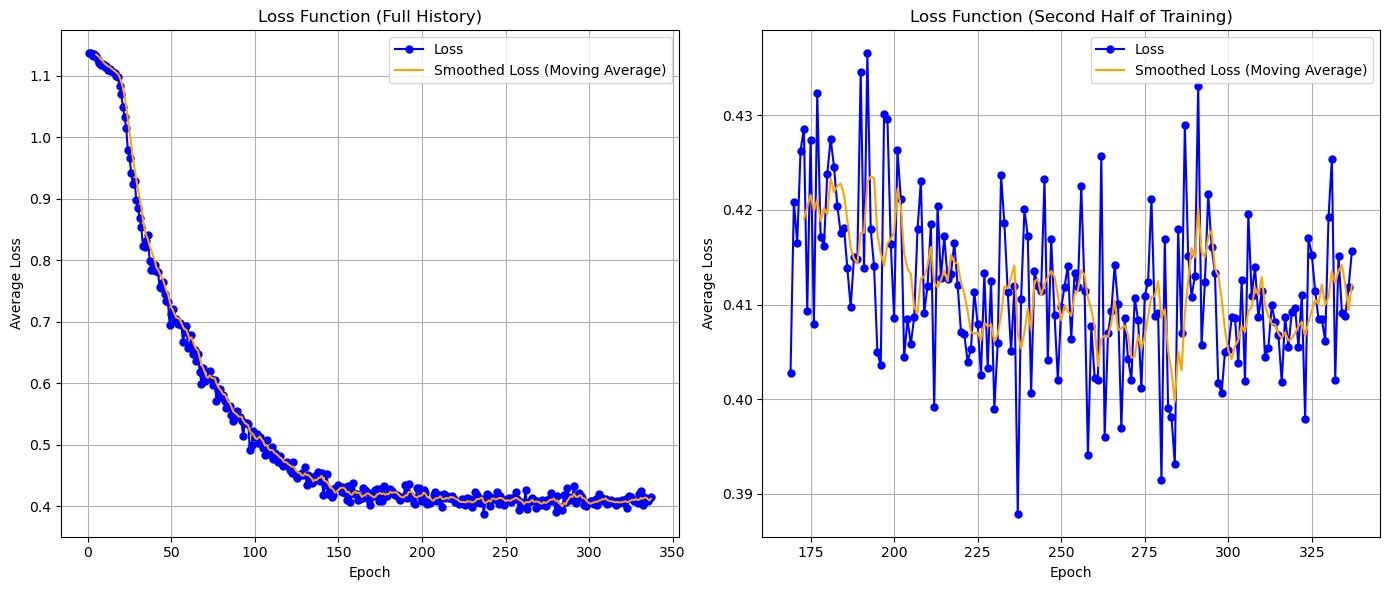

In [87]:
trainer.plot_training_history()

#### Оценка

In [88]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.0000    0.0000    0.0000       500
  chimpanzee     0.9861    0.9920    0.9890       500
    mushroom     0.4995    0.9960    0.6653       500

    accuracy                         0.6627      1500
   macro avg     0.4952    0.6627    0.5515      1500
weighted avg     0.4952    0.6627    0.5515      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.0000    0.0000    0.0000       100
  chimpanzee     0.8462    0.8800    0.8627       100
    mushroom     0.4694    0.9200    0.6216       100

    accuracy                         0.6000       300
   macro avg     0.4385    0.6000    0.4948       300
weighted avg     0.4385    0.6000    0.4948       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [89]:
trainer.save_model(cifar100)

Model saved as: cifar100_7_model.onnx


### Эксперимент №10

#### Гиперпараметры

In [90]:
batch_size=2**10
epochs=1000
lr_rate = 1e-4
dropout_rate=0.2
hidden_layers=[2**12, 2**11, 2**10, 2**9, 2**8, 2**7, 2**6, 2**5, 2**4, 2**3, 2**2]

#### Инициализация модели

In [91]:
%%time
trainer = CIFAR100Trainer(classes=CLASSES, batch_size=batch_size, lr_rate=lr_rate, dropout_rate=dropout_rate, device='cpu')

Директория для эксперимента 'cifar100' инициализирована по пути: logs/cifar100_8
CPU times: user 333 ms, sys: 323 ms, total: 656 ms
Wall time: 356 ms


In [92]:
%%time
cifar100 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_rate=dropout_rate, 
    num_classes=CLASSES.__len__()
)

CPU times: user 1.02 s, sys: 125 ms, total: 1.15 s
Wall time: 143 ms


In [93]:
trainer.log_model_graph(cifar100)

Граф модели добавлен в лог: logs/cifar100_8


#### Информация о модели

In [94]:
cifar100

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=4096, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Linear(in_features=256, out_features=128, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.2, inplace=False)
    (18): Linear(in_features=128, out_features=64, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.2, inplace=False)
    (21): Linear(in_features=64, out_features=32, bias=True)
    (22): ReLU()
    (23): Dropout(p=0.2, inp

#### Обучение

In [95]:
%%time
trainer.train(cifar100, epochs)

Epoch 1/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.64batch/s, loss=1.119653, lr=0.000100]


Epoch: 1/1000, Loss: 1.119234


Epoch 2/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=1.120380, lr=0.000100]


Epoch: 2/1000, Loss: 1.118903


Epoch 3/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.65batch/s, loss=1.114672, lr=0.000100]


Epoch: 3/1000, Loss: 1.115339


Epoch 4/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=1.125089, lr=0.000100]


Epoch: 4/1000, Loss: 1.119968


Epoch 5/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=1.110366, lr=0.000100]


Epoch: 5/1000, Loss: 1.112837


Epoch 6/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=1.119836, lr=0.000100]


Epoch: 6/1000, Loss: 1.116547


Epoch 7/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=1.105984, lr=0.000100]


Epoch: 7/1000, Loss: 1.112434


Epoch 8/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=1.105462, lr=0.000100]


Epoch: 8/1000, Loss: 1.113940


Epoch 9/1000: 100%|██████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=1.104906, lr=0.000100]


Epoch: 9/1000, Loss: 1.111891


Epoch 10/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=1.117703, lr=0.000100]


Epoch: 10/1000, Loss: 1.113823


Epoch 11/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=1.115224, lr=0.000100]


Epoch: 11/1000, Loss: 1.114752


Epoch 12/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=1.107556, lr=0.000100]


Epoch: 12/1000, Loss: 1.108205


Epoch 13/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=1.091940, lr=0.000100]


Epoch: 13/1000, Loss: 1.100732


Epoch 14/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=1.072480, lr=0.000100]


Epoch: 14/1000, Loss: 1.081227


Epoch 15/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.66batch/s, loss=1.070125, lr=0.000100]


Epoch: 15/1000, Loss: 1.069984


Epoch 16/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=1.058368, lr=0.000100]


Epoch: 16/1000, Loss: 1.063103


Epoch 17/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=1.049766, lr=0.000100]


Epoch: 17/1000, Loss: 1.049346


Epoch 18/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.49batch/s, loss=0.998024, lr=0.000100]


Epoch: 18/1000, Loss: 1.011547


Epoch 19/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.999104, lr=0.000100]


Epoch: 19/1000, Loss: 1.002401


Epoch 20/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.965407, lr=0.000100]


Epoch: 20/1000, Loss: 0.989039


Epoch 21/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.21batch/s, loss=1.014149, lr=0.000100]


Epoch: 21/1000, Loss: 1.002589


Epoch 22/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.39batch/s, loss=1.001461, lr=0.000100]


Epoch: 22/1000, Loss: 1.017696


Epoch 23/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.64batch/s, loss=0.988439, lr=0.000100]


Epoch: 23/1000, Loss: 0.987451


Epoch 24/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.965041, lr=0.000100]


Epoch: 24/1000, Loss: 0.972053


Epoch 25/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.25batch/s, loss=0.945737, lr=0.000100]


Epoch: 25/1000, Loss: 0.966483


Epoch 26/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.32batch/s, loss=0.957740, lr=0.000100]


Epoch: 26/1000, Loss: 0.967938


Epoch 27/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.40batch/s, loss=0.947541, lr=0.000100]


Epoch: 27/1000, Loss: 0.959128


Epoch 28/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.34batch/s, loss=0.944300, lr=0.000100]


Epoch: 28/1000, Loss: 0.946245


Epoch 29/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.64batch/s, loss=0.918257, lr=0.000100]


Epoch: 29/1000, Loss: 0.933092


Epoch 30/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.908355, lr=0.000100]


Epoch: 30/1000, Loss: 0.922158


Epoch 31/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.990545, lr=0.000100]


Epoch: 31/1000, Loss: 0.956176


Epoch 32/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.920178, lr=0.000100]


Epoch: 32/1000, Loss: 0.929438


Epoch 33/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=0.865213, lr=0.000100]


Epoch: 33/1000, Loss: 0.883534


Epoch 34/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.68batch/s, loss=0.890191, lr=0.000100]


Epoch: 34/1000, Loss: 0.904838


Epoch 35/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=0.886781, lr=0.000100]


Epoch: 35/1000, Loss: 0.900912


Epoch 36/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.925136, lr=0.000100]


Epoch: 36/1000, Loss: 0.923758


Epoch 37/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.65batch/s, loss=0.890764, lr=0.000090]


Epoch: 37/1000, Loss: 0.895510


Epoch 38/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.866958, lr=0.000090]


Epoch: 38/1000, Loss: 0.883929


Epoch 39/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.885438, lr=0.000090]


Epoch: 39/1000, Loss: 0.891216


Epoch 40/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.869446, lr=0.000081]


Epoch: 40/1000, Loss: 0.878915


Epoch 41/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.880740, lr=0.000081]


Epoch: 41/1000, Loss: 0.891836


Epoch 42/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.859623, lr=0.000081]


Epoch: 42/1000, Loss: 0.883974


Epoch 43/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.43batch/s, loss=0.865506, lr=0.000081]


Epoch: 43/1000, Loss: 0.856198


Epoch 44/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.878387, lr=0.000081]


Epoch: 44/1000, Loss: 0.867023


Epoch 45/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.875621, lr=0.000081]


Epoch: 45/1000, Loss: 0.865417


Epoch 46/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.856609, lr=0.000081]


Epoch: 46/1000, Loss: 0.844472


Epoch 47/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.847110, lr=0.000081]


Epoch: 47/1000, Loss: 0.841612


Epoch 48/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.817007, lr=0.000081]


Epoch: 48/1000, Loss: 0.810258


Epoch 49/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.821024, lr=0.000081]


Epoch: 49/1000, Loss: 0.820729


Epoch 50/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.825771, lr=0.000081]


Epoch: 50/1000, Loss: 0.824164


Epoch 51/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.794400, lr=0.000081]


Epoch: 51/1000, Loss: 0.800204


Epoch 52/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.757135, lr=0.000081]


Epoch: 52/1000, Loss: 0.784401


Epoch 53/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.812948, lr=0.000081]


Epoch: 53/1000, Loss: 0.795792


Epoch 54/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.791047, lr=0.000081]


Epoch: 54/1000, Loss: 0.795920


Epoch 55/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.758011, lr=0.000081]


Epoch: 55/1000, Loss: 0.770601


Epoch 56/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.770417, lr=0.000081]


Epoch: 56/1000, Loss: 0.783719


Epoch 57/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.25batch/s, loss=0.757164, lr=0.000081]


Epoch: 57/1000, Loss: 0.767481


Epoch 58/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.758685, lr=0.000081]


Epoch: 58/1000, Loss: 0.764750


Epoch 59/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.766321, lr=0.000081]


Epoch: 59/1000, Loss: 0.763697


Epoch 60/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.747612, lr=0.000081]


Epoch: 60/1000, Loss: 0.759670


Epoch 61/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.734663, lr=0.000081]


Epoch: 61/1000, Loss: 0.730830


Epoch 62/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.61batch/s, loss=0.748916, lr=0.000081]


Epoch: 62/1000, Loss: 0.741616


Epoch 63/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.767416, lr=0.000081]


Epoch: 63/1000, Loss: 0.744632


Epoch 64/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.674479, lr=0.000081]


Epoch: 64/1000, Loss: 0.693908


Epoch 65/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.801165, lr=0.000081]


Epoch: 65/1000, Loss: 0.748362


Epoch 66/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.729740, lr=0.000081]


Epoch: 66/1000, Loss: 0.723269


Epoch 67/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=0.770181, lr=0.000081]


Epoch: 67/1000, Loss: 0.735378


Epoch 68/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.698104, lr=0.000073]


Epoch: 68/1000, Loss: 0.692108


Epoch 69/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.745481, lr=0.000073]


Epoch: 69/1000, Loss: 0.725799


Epoch 70/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.683729, lr=0.000073]


Epoch: 70/1000, Loss: 0.679970


Epoch 71/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.659494, lr=0.000073]


Epoch: 71/1000, Loss: 0.672704


Epoch 72/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.695423, lr=0.000073]


Epoch: 72/1000, Loss: 0.684224


Epoch 73/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.726880, lr=0.000073]


Epoch: 73/1000, Loss: 0.695520


Epoch 74/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.697381, lr=0.000073]


Epoch: 74/1000, Loss: 0.685626


Epoch 75/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.651859, lr=0.000066]


Epoch: 75/1000, Loss: 0.650044


Epoch 76/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.668099, lr=0.000066]


Epoch: 76/1000, Loss: 0.672814


Epoch 77/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.687376, lr=0.000066]


Epoch: 77/1000, Loss: 0.671514


Epoch 78/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.661641, lr=0.000066]


Epoch: 78/1000, Loss: 0.655842


Epoch 79/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.671915, lr=0.000059]


Epoch: 79/1000, Loss: 0.671222


Epoch 80/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.648928, lr=0.000059]


Epoch: 80/1000, Loss: 0.637172


Epoch 81/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.636862, lr=0.000059]


Epoch: 81/1000, Loss: 0.628094


Epoch 82/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.632262, lr=0.000059]


Epoch: 82/1000, Loss: 0.646878


Epoch 83/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.631642, lr=0.000059]


Epoch: 83/1000, Loss: 0.639409


Epoch 84/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.671527, lr=0.000059]


Epoch: 84/1000, Loss: 0.642077


Epoch 85/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.638956, lr=0.000053]


Epoch: 85/1000, Loss: 0.643028


Epoch 86/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.645592, lr=0.000053]


Epoch: 86/1000, Loss: 0.643031


Epoch 87/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.648442, lr=0.000053]


Epoch: 87/1000, Loss: 0.636685


Epoch 88/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.636543, lr=0.000048]


Epoch: 88/1000, Loss: 0.622231


Epoch 89/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.553506, lr=0.000048]


Epoch: 89/1000, Loss: 0.575850


Epoch 90/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.621745, lr=0.000048]


Epoch: 90/1000, Loss: 0.607050


Epoch 91/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.609447, lr=0.000048]


Epoch: 91/1000, Loss: 0.600431


Epoch 92/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=0.623507, lr=0.000048]


Epoch: 92/1000, Loss: 0.616478


Epoch 93/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.48batch/s, loss=0.594192, lr=0.000043]


Epoch: 93/1000, Loss: 0.588223


Epoch 94/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.18batch/s, loss=0.583213, lr=0.000043]


Epoch: 94/1000, Loss: 0.591959


Epoch 95/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.58batch/s, loss=0.628195, lr=0.000043]


Epoch: 95/1000, Loss: 0.587578


Epoch 96/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.56batch/s, loss=0.570298, lr=0.000039]


Epoch: 96/1000, Loss: 0.584152


Epoch 97/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.41batch/s, loss=0.633323, lr=0.000039]


Epoch: 97/1000, Loss: 0.598826


Epoch 98/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.62batch/s, loss=0.542537, lr=0.000039]


Epoch: 98/1000, Loss: 0.567678


Epoch 99/1000: 100%|█████████████████████| 2/2 [00:00<00:00,  2.47batch/s, loss=0.595120, lr=0.000039]


Epoch: 99/1000, Loss: 0.587517


Epoch 100/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.46batch/s, loss=0.554847, lr=0.000039]


Epoch: 100/1000, Loss: 0.558498


Epoch 101/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.34batch/s, loss=0.591724, lr=0.000039]


Epoch: 101/1000, Loss: 0.589860


Epoch 102/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.38batch/s, loss=0.555148, lr=0.000039]


Epoch: 102/1000, Loss: 0.564922


Epoch 103/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.34batch/s, loss=0.533524, lr=0.000039]


Epoch: 103/1000, Loss: 0.552819


Epoch 104/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.33batch/s, loss=0.547697, lr=0.000039]


Epoch: 104/1000, Loss: 0.551949


Epoch 105/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.55batch/s, loss=0.544003, lr=0.000039]


Epoch: 105/1000, Loss: 0.549005


Epoch 106/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.587186, lr=0.000039]


Epoch: 106/1000, Loss: 0.574450


Epoch 107/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.517265, lr=0.000039]


Epoch: 107/1000, Loss: 0.562757


Epoch 108/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.33batch/s, loss=0.557240, lr=0.000039]


Epoch: 108/1000, Loss: 0.546919


Epoch 109/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.42batch/s, loss=0.549353, lr=0.000039]


Epoch: 109/1000, Loss: 0.544079


Epoch 110/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.96batch/s, loss=0.578425, lr=0.000039]


Epoch: 110/1000, Loss: 0.555025


Epoch 111/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=0.553531, lr=0.000039]


Epoch: 111/1000, Loss: 0.546581


Epoch 112/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.48batch/s, loss=0.517845, lr=0.000039]


Epoch: 112/1000, Loss: 0.544051


Epoch 113/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.26batch/s, loss=0.516391, lr=0.000035]


Epoch: 113/1000, Loss: 0.535568


Epoch 114/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.24batch/s, loss=0.541853, lr=0.000035]


Epoch: 114/1000, Loss: 0.538777


Epoch 115/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.25batch/s, loss=0.534014, lr=0.000035]


Epoch: 115/1000, Loss: 0.541151


Epoch 116/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.25batch/s, loss=0.521890, lr=0.000035]


Epoch: 116/1000, Loss: 0.525421


Epoch 117/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.27batch/s, loss=0.536172, lr=0.000035]


Epoch: 117/1000, Loss: 0.540675


Epoch 118/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.26batch/s, loss=0.519859, lr=0.000035]


Epoch: 118/1000, Loss: 0.535003


Epoch 119/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.31batch/s, loss=0.581126, lr=0.000035]


Epoch: 119/1000, Loss: 0.566513


Epoch 120/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.23batch/s, loss=0.516181, lr=0.000031]


Epoch: 120/1000, Loss: 0.531466


Epoch 121/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.56batch/s, loss=0.513582, lr=0.000031]


Epoch: 121/1000, Loss: 0.522453


Epoch 122/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.65batch/s, loss=0.492354, lr=0.000031]


Epoch: 122/1000, Loss: 0.504868


Epoch 123/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.27batch/s, loss=0.567669, lr=0.000031]


Epoch: 123/1000, Loss: 0.543224


Epoch 124/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.31batch/s, loss=0.483396, lr=0.000031]


Epoch: 124/1000, Loss: 0.514001


Epoch 125/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.15batch/s, loss=0.516149, lr=0.000031]


Epoch: 125/1000, Loss: 0.511913


Epoch 126/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.16batch/s, loss=0.564401, lr=0.000028]


Epoch: 126/1000, Loss: 0.556124


Epoch 127/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.13batch/s, loss=0.511571, lr=0.000028]


Epoch: 127/1000, Loss: 0.508015


Epoch 128/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.17batch/s, loss=0.518617, lr=0.000028]


Epoch: 128/1000, Loss: 0.515651


Epoch 129/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.26batch/s, loss=0.486378, lr=0.000025]


Epoch: 129/1000, Loss: 0.507025


Epoch 130/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.23batch/s, loss=0.452037, lr=0.000025]


Epoch: 130/1000, Loss: 0.476974


Epoch 131/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.45batch/s, loss=0.515096, lr=0.000025]


Epoch: 131/1000, Loss: 0.524934


Epoch 132/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.549265, lr=0.000025]


Epoch: 132/1000, Loss: 0.513504


Epoch 133/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.59batch/s, loss=0.535169, lr=0.000025]


Epoch: 133/1000, Loss: 0.516564


Epoch 134/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.490346, lr=0.000023]


Epoch: 134/1000, Loss: 0.495072


Epoch 135/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.482780, lr=0.000023]


Epoch: 135/1000, Loss: 0.498213


Epoch 136/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.522654, lr=0.000023]


Epoch: 136/1000, Loss: 0.508628


Epoch 137/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.493951, lr=0.000021]


Epoch: 137/1000, Loss: 0.496231


Epoch 138/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.452213, lr=0.000021]


Epoch: 138/1000, Loss: 0.484127


Epoch 139/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.501548, lr=0.000021]


Epoch: 139/1000, Loss: 0.513394


Epoch 140/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.494408, lr=0.000019]


Epoch: 140/1000, Loss: 0.484259


Epoch 141/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.499222, lr=0.000019]


Epoch: 141/1000, Loss: 0.500884


Epoch 142/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.481840, lr=0.000019]


Epoch: 142/1000, Loss: 0.477207


Epoch 143/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.489440, lr=0.000017]


Epoch: 143/1000, Loss: 0.495503


Epoch 144/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.501259, lr=0.000017]


Epoch: 144/1000, Loss: 0.501235


Epoch 145/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.466904, lr=0.000017]


Epoch: 145/1000, Loss: 0.496669


Epoch 146/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.481580, lr=0.000015]


Epoch: 146/1000, Loss: 0.483461


Epoch 147/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.516169, lr=0.000015]


Epoch: 147/1000, Loss: 0.514592


Epoch 148/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.65batch/s, loss=0.520165, lr=0.000015]


Epoch: 148/1000, Loss: 0.509786


Epoch 149/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.70batch/s, loss=0.525063, lr=0.000014]


Epoch: 149/1000, Loss: 0.517305


Epoch 150/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.480057, lr=0.000014]


Epoch: 150/1000, Loss: 0.485382


Epoch 151/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.503766, lr=0.000014]


Epoch: 151/1000, Loss: 0.496661


Epoch 152/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.487858, lr=0.000012]


Epoch: 152/1000, Loss: 0.483381


Epoch 153/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.492191, lr=0.000012]


Epoch: 153/1000, Loss: 0.493109


Epoch 154/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.500190, lr=0.000012]


Epoch: 154/1000, Loss: 0.499922


Epoch 155/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.535842, lr=0.000011]


Epoch: 155/1000, Loss: 0.502537


Epoch 156/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.509781, lr=0.000011]


Epoch: 156/1000, Loss: 0.504593


Epoch 157/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.71batch/s, loss=0.435596, lr=0.000011]


Epoch: 157/1000, Loss: 0.469172


Epoch 158/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.468225, lr=0.000011]


Epoch: 158/1000, Loss: 0.475807


Epoch 159/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.487634, lr=0.000011]


Epoch: 159/1000, Loss: 0.494574


Epoch 160/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.514398, lr=0.000011]


Epoch: 160/1000, Loss: 0.506309


Epoch 161/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.521286, lr=0.000010]


Epoch: 161/1000, Loss: 0.511639


Epoch 162/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.497597, lr=0.000010]


Epoch: 162/1000, Loss: 0.480950


Epoch 163/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.524838, lr=0.000010]


Epoch: 163/1000, Loss: 0.518948


Epoch 164/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.422416, lr=0.000009]


Epoch: 164/1000, Loss: 0.467976


Epoch 165/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.469191, lr=0.000009]


Epoch: 165/1000, Loss: 0.477873


Epoch 166/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.482296, lr=0.000009]


Epoch: 166/1000, Loss: 0.483510


Epoch 167/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.476091, lr=0.000009]


Epoch: 167/1000, Loss: 0.480430


Epoch 168/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.463605, lr=0.000008]


Epoch: 168/1000, Loss: 0.471372


Epoch 169/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.493485, lr=0.000008]


Epoch: 169/1000, Loss: 0.482479


Epoch 170/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.479021, lr=0.000008]


Epoch: 170/1000, Loss: 0.492149


Epoch 171/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.458414, lr=0.000007]


Epoch: 171/1000, Loss: 0.462872


Epoch 172/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.95batch/s, loss=0.416542, lr=0.000007]


Epoch: 172/1000, Loss: 0.454096


Epoch 173/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.463846, lr=0.000007]


Epoch: 173/1000, Loss: 0.477836


Epoch 174/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.474325, lr=0.000007]


Epoch: 174/1000, Loss: 0.486859


Epoch 175/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.495973, lr=0.000007]


Epoch: 175/1000, Loss: 0.485483


Epoch 176/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.484660, lr=0.000006]


Epoch: 176/1000, Loss: 0.487469


Epoch 177/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=0.478981, lr=0.000006]


Epoch: 177/1000, Loss: 0.479873


Epoch 178/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.482238, lr=0.000006]


Epoch: 178/1000, Loss: 0.475445


Epoch 179/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.468837, lr=0.000006]


Epoch: 179/1000, Loss: 0.481292


Epoch 180/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.535091, lr=0.000006]


Epoch: 180/1000, Loss: 0.498501


Epoch 181/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.526257, lr=0.000006]


Epoch: 181/1000, Loss: 0.516803


Epoch 182/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.510159, lr=0.000005]


Epoch: 182/1000, Loss: 0.486860


Epoch 183/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.476086, lr=0.000005]


Epoch: 183/1000, Loss: 0.482935


Epoch 184/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.521384, lr=0.000005]


Epoch: 184/1000, Loss: 0.492630


Epoch 185/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.474428, lr=0.000005]


Epoch: 185/1000, Loss: 0.484102


Epoch 186/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.494835, lr=0.000005]


Epoch: 186/1000, Loss: 0.485634


Epoch 187/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.446339, lr=0.000005]


Epoch: 187/1000, Loss: 0.477804


Epoch 188/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.471829, lr=0.000004]


Epoch: 188/1000, Loss: 0.473046


Epoch 189/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.456596, lr=0.000004]


Epoch: 189/1000, Loss: 0.481503


Epoch 190/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.483191, lr=0.000004]


Epoch: 190/1000, Loss: 0.487275


Epoch 191/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.491786, lr=0.000004]


Epoch: 191/1000, Loss: 0.495342


Epoch 192/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.520764, lr=0.000004]


Epoch: 192/1000, Loss: 0.491529


Epoch 193/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.29batch/s, loss=0.455960, lr=0.000004]


Epoch: 193/1000, Loss: 0.453168


Epoch 194/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.485599, lr=0.000004]


Epoch: 194/1000, Loss: 0.496008


Epoch 195/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.496511, lr=0.000004]


Epoch: 195/1000, Loss: 0.490744


Epoch 196/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.467952, lr=0.000004]


Epoch: 196/1000, Loss: 0.475107


Epoch 197/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.476253, lr=0.000003]


Epoch: 197/1000, Loss: 0.475817


Epoch 198/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.500580, lr=0.000003]


Epoch: 198/1000, Loss: 0.494761


Epoch 199/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.481935, lr=0.000003]


Epoch: 199/1000, Loss: 0.497072


Epoch 200/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.491778, lr=0.000003]


Epoch: 200/1000, Loss: 0.479511


Epoch 201/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.94batch/s, loss=0.489833, lr=0.000003]


Epoch: 201/1000, Loss: 0.481907


Epoch 202/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.472754, lr=0.000003]


Epoch: 202/1000, Loss: 0.473591


Epoch 203/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.476165, lr=0.000003]


Epoch: 203/1000, Loss: 0.484014


Epoch 204/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.465277, lr=0.000003]


Epoch: 204/1000, Loss: 0.469710


Epoch 205/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.497451, lr=0.000003]


Epoch: 205/1000, Loss: 0.482691


Epoch 206/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=0.446796, lr=0.000003]


Epoch: 206/1000, Loss: 0.455333


Epoch 207/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.444420, lr=0.000003]


Epoch: 207/1000, Loss: 0.463165


Epoch 208/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.461674, lr=0.000003]


Epoch: 208/1000, Loss: 0.480139


Epoch 209/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.514655, lr=0.000002]


Epoch: 209/1000, Loss: 0.489623


Epoch 210/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.469935, lr=0.000002]


Epoch: 210/1000, Loss: 0.475734


Epoch 211/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.66batch/s, loss=0.505075, lr=0.000002]


Epoch: 211/1000, Loss: 0.486108


Epoch 212/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.66batch/s, loss=0.454990, lr=0.000002]


Epoch: 212/1000, Loss: 0.457513


Epoch 213/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.470967, lr=0.000002]


Epoch: 213/1000, Loss: 0.484155


Epoch 214/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.450249, lr=0.000002]


Epoch: 214/1000, Loss: 0.457334


Epoch 215/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.486031, lr=0.000002]


Epoch: 215/1000, Loss: 0.477569


Epoch 216/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.529473, lr=0.000002]


Epoch: 216/1000, Loss: 0.484595


Epoch 217/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.88batch/s, loss=0.474874, lr=0.000002]


Epoch: 217/1000, Loss: 0.474076


Epoch 218/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.512863, lr=0.000002]


Epoch: 218/1000, Loss: 0.495376


Epoch 219/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.489535, lr=0.000002]


Epoch: 219/1000, Loss: 0.484745


Epoch 220/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.488413, lr=0.000002]


Epoch: 220/1000, Loss: 0.488967


Epoch 221/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.83batch/s, loss=0.496957, lr=0.000001]


Epoch: 221/1000, Loss: 0.479063


Epoch 222/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.477102, lr=0.000001]


Epoch: 222/1000, Loss: 0.464156


Epoch 223/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.481026, lr=0.000001]


Epoch: 223/1000, Loss: 0.476928


Epoch 224/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.447291, lr=0.000001]


Epoch: 224/1000, Loss: 0.483912


Epoch 225/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.456709, lr=0.000001]


Epoch: 225/1000, Loss: 0.480982


Epoch 226/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.479507, lr=0.000001]


Epoch: 226/1000, Loss: 0.495574


Epoch 227/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.451818, lr=0.000001]


Epoch: 227/1000, Loss: 0.483738


Epoch 228/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.487440, lr=0.000001]


Epoch: 228/1000, Loss: 0.486012


Epoch 229/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.54batch/s, loss=0.483862, lr=0.000001]


Epoch: 229/1000, Loss: 0.490462


Epoch 230/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.21batch/s, loss=0.546533, lr=0.000001]


Epoch: 230/1000, Loss: 0.527476


Epoch 231/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.59batch/s, loss=0.544606, lr=0.000001]


Epoch: 231/1000, Loss: 0.513663


Epoch 232/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.479014, lr=0.000001]


Epoch: 232/1000, Loss: 0.476325


Epoch 233/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.52batch/s, loss=0.491503, lr=0.000001]


Epoch: 233/1000, Loss: 0.485237


Epoch 234/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.55batch/s, loss=0.528515, lr=0.000001]


Epoch: 234/1000, Loss: 0.497445


Epoch 235/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.74batch/s, loss=0.512330, lr=0.000001]


Epoch: 235/1000, Loss: 0.500812


Epoch 236/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.46batch/s, loss=0.502876, lr=0.000001]


Epoch: 236/1000, Loss: 0.480174


Epoch 237/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.38batch/s, loss=0.505104, lr=0.000001]


Epoch: 237/1000, Loss: 0.502588


Epoch 238/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.39batch/s, loss=0.452814, lr=0.000001]


Epoch: 238/1000, Loss: 0.456558


Epoch 239/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=0.466198, lr=0.000001]


Epoch: 239/1000, Loss: 0.473245


Epoch 240/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.454371, lr=0.000001]


Epoch: 240/1000, Loss: 0.468354


Epoch 241/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.89batch/s, loss=0.496868, lr=0.000001]


Epoch: 241/1000, Loss: 0.488503


Epoch 242/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.443391, lr=0.000001]


Epoch: 242/1000, Loss: 0.454947


Epoch 243/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.488465, lr=0.000001]


Epoch: 243/1000, Loss: 0.484744


Epoch 244/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.84batch/s, loss=0.473250, lr=0.000001]


Epoch: 244/1000, Loss: 0.470526


Epoch 245/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.502560, lr=0.000001]


Epoch: 245/1000, Loss: 0.491183


Epoch 246/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.93batch/s, loss=0.525862, lr=0.000001]


Epoch: 246/1000, Loss: 0.506500


Epoch 247/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.518346, lr=0.000001]


Epoch: 247/1000, Loss: 0.497442


Epoch 248/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.453070, lr=0.000001]


Epoch: 248/1000, Loss: 0.461752


Epoch 249/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.481167, lr=0.000001]


Epoch: 249/1000, Loss: 0.478136


Epoch 250/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.477349, lr=0.000001]


Epoch: 250/1000, Loss: 0.479183


Epoch 251/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.85batch/s, loss=0.434432, lr=0.000001]


Epoch: 251/1000, Loss: 0.471009


Epoch 252/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.442429, lr=0.000001]


Epoch: 252/1000, Loss: 0.469615


Epoch 253/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.489966, lr=0.000001]


Epoch: 253/1000, Loss: 0.480271


Epoch 254/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.458534, lr=0.000000]


Epoch: 254/1000, Loss: 0.474854


Epoch 255/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.559013, lr=0.000000]


Epoch: 255/1000, Loss: 0.525486


Epoch 256/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.87batch/s, loss=0.510164, lr=0.000000]


Epoch: 256/1000, Loss: 0.496787


Epoch 257/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.81batch/s, loss=0.505953, lr=0.000000]


Epoch: 257/1000, Loss: 0.490091


Epoch 258/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.72batch/s, loss=0.468919, lr=0.000000]


Epoch: 258/1000, Loss: 0.473626


Epoch 259/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.42batch/s, loss=0.505019, lr=0.000000]


Epoch: 259/1000, Loss: 0.503453


Epoch 260/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.63batch/s, loss=0.505544, lr=0.000000]


Epoch: 260/1000, Loss: 0.502093


Epoch 261/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.92batch/s, loss=0.460530, lr=0.000000]


Epoch: 261/1000, Loss: 0.464186


Epoch 262/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.90batch/s, loss=0.449743, lr=0.000000]


Epoch: 262/1000, Loss: 0.469074


Epoch 263/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.479493, lr=0.000000]


Epoch: 263/1000, Loss: 0.474970


Epoch 264/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.80batch/s, loss=0.558794, lr=0.000000]


Epoch: 264/1000, Loss: 0.518632


Epoch 265/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.91batch/s, loss=0.476567, lr=0.000000]


Epoch: 265/1000, Loss: 0.485195


Epoch 266/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.86batch/s, loss=0.420486, lr=0.000000]


Epoch: 266/1000, Loss: 0.461638


Epoch 267/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.427655, lr=0.000000]


Epoch: 267/1000, Loss: 0.456501


Epoch 268/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.78batch/s, loss=0.493278, lr=0.000000]


Epoch: 268/1000, Loss: 0.483286


Epoch 269/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.448978, lr=0.000000]


Epoch: 269/1000, Loss: 0.461019


Epoch 270/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.65batch/s, loss=0.481405, lr=0.000000]


Epoch: 270/1000, Loss: 0.467798


Epoch 271/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.478023, lr=0.000000]


Epoch: 271/1000, Loss: 0.475509


Epoch 272/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.496971, lr=0.000000]


Epoch: 272/1000, Loss: 0.482262


Epoch 273/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.518609, lr=0.000000]


Epoch: 273/1000, Loss: 0.489858


Epoch 274/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.82batch/s, loss=0.496693, lr=0.000000]


Epoch: 274/1000, Loss: 0.500049


Epoch 275/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.448772, lr=0.000000]


Epoch: 275/1000, Loss: 0.471112


Epoch 276/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.69batch/s, loss=0.441279, lr=0.000000]


Epoch: 276/1000, Loss: 0.470976


Epoch 277/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.75batch/s, loss=0.496542, lr=0.000000]


Epoch: 277/1000, Loss: 0.486497


Epoch 278/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.67batch/s, loss=0.451320, lr=0.000000]


Epoch: 278/1000, Loss: 0.461204


Epoch 279/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.57batch/s, loss=0.477311, lr=0.000000]


Epoch: 279/1000, Loss: 0.474929


Epoch 280/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.46batch/s, loss=0.483650, lr=0.000000]


Epoch: 280/1000, Loss: 0.496660


Epoch 281/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.56batch/s, loss=0.451913, lr=0.000000]


Epoch: 281/1000, Loss: 0.462949


Epoch 282/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.28batch/s, loss=0.465415, lr=0.000000]


Epoch: 282/1000, Loss: 0.469178


Epoch 283/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.35batch/s, loss=0.517798, lr=0.000000]


Epoch: 283/1000, Loss: 0.486500


Epoch 284/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.57batch/s, loss=0.445276, lr=0.000000]


Epoch: 284/1000, Loss: 0.467063


Epoch 285/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.60batch/s, loss=0.499731, lr=0.000000]


Epoch: 285/1000, Loss: 0.482978


Epoch 286/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.66batch/s, loss=0.478065, lr=0.000000]


Epoch: 286/1000, Loss: 0.479723


Epoch 287/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.427160, lr=0.000000]


Epoch: 287/1000, Loss: 0.461397


Epoch 288/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.64batch/s, loss=0.509165, lr=0.000000]


Epoch: 288/1000, Loss: 0.493766


Epoch 289/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.76batch/s, loss=0.460617, lr=0.000000]


Epoch: 289/1000, Loss: 0.461745


Epoch 290/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.473353, lr=0.000000]


Epoch: 290/1000, Loss: 0.468376


Epoch 291/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.79batch/s, loss=0.481298, lr=0.000000]


Epoch: 291/1000, Loss: 0.479646


Epoch 292/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.77batch/s, loss=0.478578, lr=0.000000]


Epoch: 292/1000, Loss: 0.487468


Epoch 293/1000: 100%|████████████████████| 2/2 [00:00<00:00,  2.73batch/s, loss=0.470760, lr=0.000000]

Epoch: 293/1000, Loss: 0.483964
Early stopping activated.
CPU times: user 26min 36s, sys: 2min 23s, total: 28min 59s
Wall time: 3min 37s


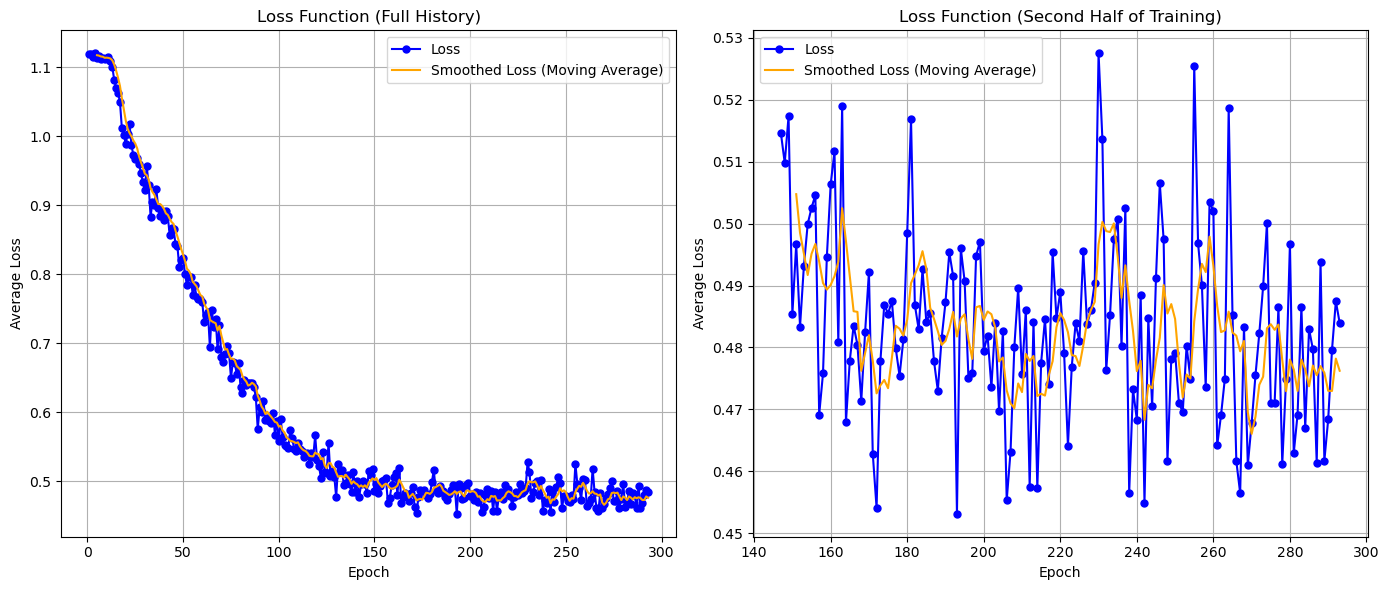

In [96]:
trainer.plot_training_history()

#### Оценка

In [97]:
trainer.evaluate(cifar100)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9980    0.9740    0.9858       500
  chimpanzee     0.9919    0.9740    0.9828       500
    mushroom     0.9501    0.9900    0.9696       500

    accuracy                         0.9793      1500
   macro avg     0.9800    0.9793    0.9794      1500
weighted avg     0.9800    0.9793    0.9794      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8468    0.9400    0.8910       100
  chimpanzee     0.8830    0.8300    0.8557       100
    mushroom     0.8526    0.8100    0.8308       100

    accuracy                         0.8600       300
   macro avg     0.8608    0.8600    0.8591       300
weighted avg     0.8608    0.8600    0.8591       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [98]:
trainer.save_model(cifar100)

Model saved as: cifar100_8_model.onnx
